# Leve 1:Modeling single layer, single path permeation of clean metal 

In [1]:
# Import packages and modules
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats



In [2]:
#import modules
from calculations.permeation_calc import calculate_simple_metal_flux
from calculations.utils import get_diffusivity, get_solubility, get_permeability
from data.material_data import MATERIALS

In [3]:
# Test at 800°C
T_celsius = 800
T_kelvin = T_celsius + 273.15

# Get material properties at temperature
material = MATERIALS['Incoloy800']
D = get_diffusivity(T_kelvin, material)
K_s = get_solubility(T_kelvin, material)


# Calculate flux through simple metal
thickness = 0.001  # 1 mm
P_up = 1e20  # Pa
P_down = 0  # Pa

In [4]:
result = calculate_simple_metal_flux(D, K_s, thickness, P_up, P_down)

In [5]:
print(f"\nFor P_up = {P_up} Pa:")
print(f"C_up = {result['C_up']:.2e} mol/m³")
print(f"C_down = {result['C_down']:.2e} mol/m³")
print(f"Diffusivity(D) = {D:.2e} m²/s; at {T_celsius}°C")
print(f"Solubility(K_s) = {K_s:.2e} mol/m³/Pa^0.5; at {T_celsius}°C")
print(f"Flux = {result['flux']:.2e} mol/m²/s")
print(f"permeability at {T_celsius}°C: {result['permeability']:.2e} mol/m/s/Pa^0.5")


For P_up = 1e+20 Pa:
C_up = 9.41e+01 mol/m³
C_down = 0.00e+00 mol/m³
Diffusivity(D) = 1.47e-09 m²/s; at 800°C
Solubility(K_s) = 9.41e-09 mol/m³/Pa^0.5; at 800°C
Flux = 1.38e-04 mol/m²/s
permeability at 800°C: 1.38e-17 mol/m/s/Pa^0.5


### Test sieverts law pressure dependence
  Test that flux ∝ √P (Sieverts' law).
    
    Performs pressure sweep and verifies:
    - log(flux) vs log(P) has slope = 0.5
    - R² > 0.999
    - Deviation from 0.5 < 1% 

In [6]:
# Pressure sweep (log-spaced)
P_min = 1e-3    # Pa
P_max = 1e20    # Pa
n_points = 50

pressures = np.logspace(np.log10(P_min), np.log10(P_max), n_points)
fluxes = []

for P in pressures:
    result = calculate_simple_metal_flux(D, K_s, thickness, P, 0)
    fluxes.append(result['flux'])

fluxes = np.array(fluxes)

In [7]:
fluxes

array([4.37866447e-16, 7.51684413e-16, 1.29041506e-15, 2.21525283e-15,
       3.80291989e-15, 6.52846462e-15, 1.12074015e-14, 1.92397228e-14,
       3.30287918e-14, 5.67004577e-14, 9.73375571e-14, 1.67099181e-13,
       2.86858813e-13, 4.92449924e-13, 8.45387754e-13, 1.45127539e-12,
       2.49140142e-12, 4.27698360e-12, 7.34228880e-12, 1.26044918e-11,
       2.16381047e-11, 3.71460891e-11, 6.37686133e-11, 1.09471445e-10,
       1.87929400e-10, 3.22618008e-10, 5.53837660e-10, 9.50771951e-10,
       1.63218822e-09, 2.80197410e-09, 4.81014306e-09, 8.25756253e-09,
       1.41757403e-08, 2.43354637e-08, 4.17766396e-08, 7.17178698e-08,
       1.23117917e-07, 2.11356270e-07, 3.62834867e-07, 6.22877856e-07,
       1.06929311e-06, 1.83565325e-06, 3.15126208e-06, 5.40976502e-06,
       9.28693229e-06, 1.59428572e-05, 2.73690696e-05, 4.69844245e-05,
       8.06580632e-05, 1.38465528e-04])

In [8]:
# Linear regression on log-log plot
log_P = np.log(pressures)
log_flux = np.log(fluxes)

slope, intercept, r_value, p_value, std_err = stats.linregress(log_P, log_flux)
r_squared = r_value ** 2

In [9]:
# print(log_P)
# print(log_flux)
print(f"Slope: {slope:.4f}, Intercept: {intercept:.4f}, R²: {r_squared:.4f}")

Slope: 0.5000, Intercept: -31.9107, R²: 1.0000


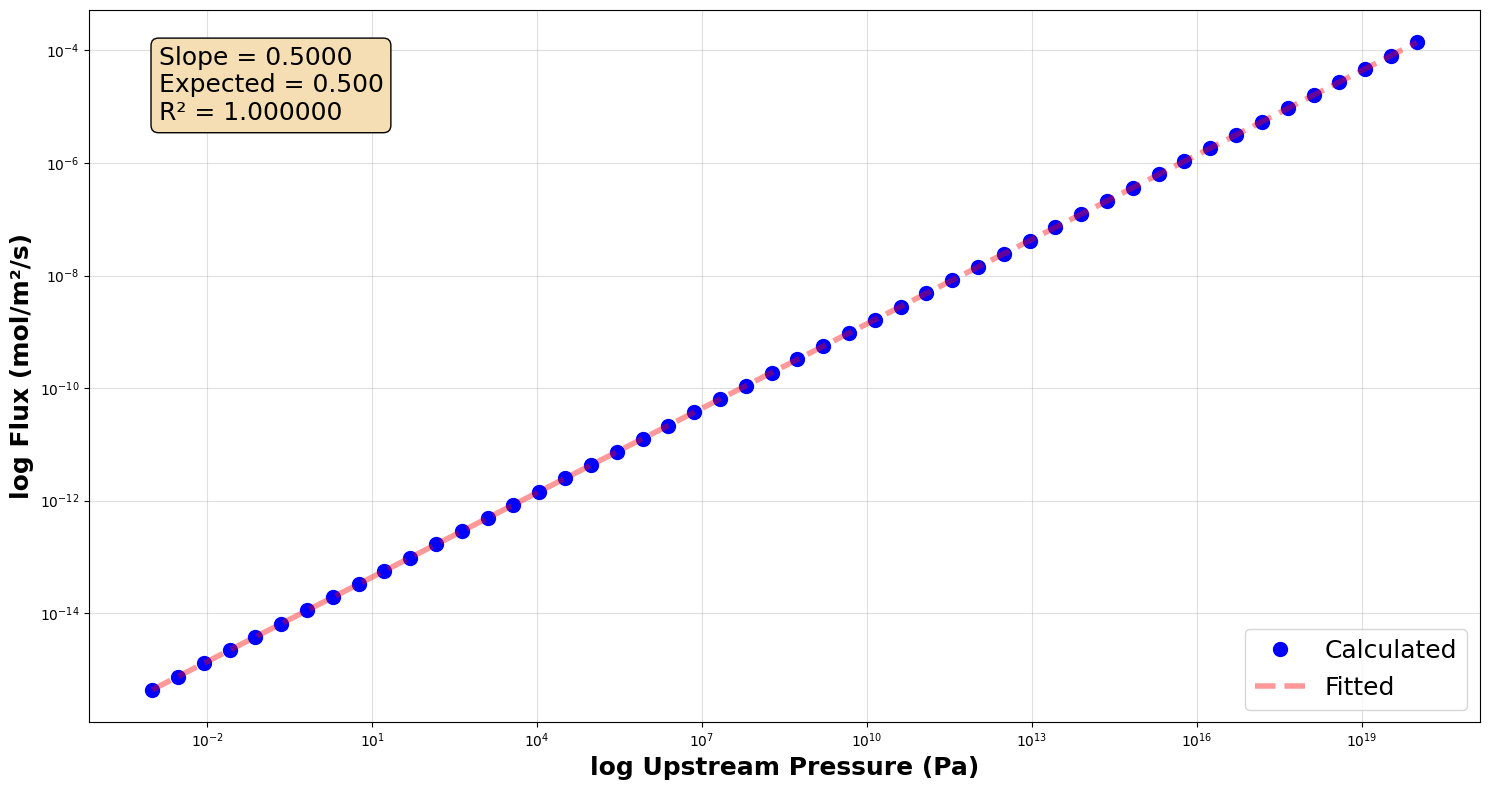

In [10]:
#Plots
# Create plot
fig, ax = plt.subplots(figsize=(15, 8))

ax.loglog(pressures, fluxes, 'o', markersize=10, label='Calculated', color='blue')

# Fitted line
fitted_flux = np.exp(slope * log_P + intercept)
ax.loglog(pressures, fitted_flux, '--', linewidth=4, label='Fitted', color='red', alpha=0.4)

ax.set_xlabel('log Upstream Pressure (Pa)', fontweight='bold', fontsize=18)
ax.set_ylabel('log Flux (mol/m²/s)', fontweight='bold', fontsize=18)
#ax.set_title(f'Sieverts\' Law Validation: {material} at {T_celsius}°C', fontsize=18)
ax.grid(True, which='both', alpha=0.4)
ax.legend(fontsize=18)
# Add text box with results
textstr = f'Slope = {slope:.4f}\nExpected = 0.500\nR² = {r_squared:.6f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=1)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=18,
        verticalalignment='top', bbox=props)
plt.tight_layout()


####     Test that C ∝ √P at surface (Sieverts'law at surfaces).
    
    Verifies surface concentration calculation.

In [11]:
pressures=pressures
D=D
K_s=K_s
thickness=thickness
expected_C_ratio = np.sqrt(pressures / pressures[0])
concentrations = []
for P in pressures:
    result = calculate_simple_metal_flux(D, K_s, thickness, P, 0)
    concentrations.append(result['C_up'])

concentrations = np.array(concentrations)
actual_C_ratio = concentrations / concentrations[0]

# Check if ratios match
relative_error = np.abs(actual_C_ratio - expected_C_ratio) / expected_C_ratio
passed = np.all(relative_error < 1e-10)

In [12]:
# concentrations
# actual_C_ratio
# expected_C_ratio
# relative_error
#passed

####     Test Arrhenius behavior: Property = A × exp(-E/RT).
    
    Performs temperature sweep and verifies:
    - ln(D) vs 1/T is linear (R² > 0.999)
    - ln(K_s) vs 1/T is linear (R² > 0.999)
    - ln(P) vs 1/T is linear (R² > 0.999)
    - Extracted E_D matches input
    - Extracted ΔH_s matches input
    - E_P = E_D + ΔH_s

In [13]:
#pressures=pressures
P_upstream=P_up
P_downstream=P_down
# D=D
# K_s=K_s
thickness=thickness
T_min_C = 300  # Minimum temperature in Celsius
T_max_C = 1100  # Maximum temperature in Celsius
n_points = 9   # Number of temperature points
# Temperature sweep
temperatures_C = np.linspace(T_min_C, T_max_C, n_points)
temperatures_K = temperatures_C + 273.15

In [14]:
temperatures_C

array([ 300.,  400.,  500.,  600.,  700.,  800.,  900., 1000., 1100.])

In [15]:
diffusivities = []
solubilities = []
permeabilities = []
fluxes = []

for T_K in temperatures_K:
    D = get_diffusivity(T_K, material)
    K_s = get_solubility(T_K, material)
    P = get_permeability(T_K, material)
    
    result = calculate_simple_metal_flux(D, K_s, thickness, P_upstream, P_downstream)
    
    diffusivities.append(D)
    solubilities.append(K_s)
    permeabilities.append(P)
    fluxes.append(result['flux'])

diffusivities = np.array(diffusivities)
solubilities = np.array(solubilities)
permeabilities = np.array(permeabilities)
fluxes = np.array(fluxes)

In [16]:
# diffusivities
# solubilities
#permeabilities
fluxes

array([6.06052645e-06, 1.64348555e-05, 3.44307126e-05, 6.08916847e-05,
       9.57814065e-05, 1.38465528e-04, 1.87981378e-04, 2.43237518e-04,
       3.03141722e-04])

In [17]:
# Arrhenius analysis: ln(Property) vs 1000/T
R = 8.314  # J/mol/K
x_data = 1000.0 / temperatures_K

# Diffusivity analysis
y_D = np.log(diffusivities)
slope_D, intercept_D, r_D, _, std_D = stats.linregress(x_data, y_D)
r_squared_D = r_D ** 2
E_D_extracted = -slope_D * R * 1000  # J/mol
D_0_extracted = np.exp(intercept_D)

# Solubility analysis
y_K = np.log(solubilities)
slope_K, intercept_K, r_K, _, std_K = stats.linregress(x_data, y_K)
r_squared_K = r_K ** 2
H_s_extracted = -slope_K * R * 1000  # J/mol
K_s0_extracted = np.exp(intercept_K)

# Permeability analysis
y_P = np.log(permeabilities)
slope_P, intercept_P, r_P, _, std_P = stats.linregress(x_data, y_P)
r_squared_P = r_P ** 2
E_P_extracted = -slope_P * R * 1000  # J/mol
P_0_extracted = np.exp(intercept_P)

# Verification checks
E_D_input = material['E_D']
H_s_input = material['H_s']
E_P_expected = E_D_input + H_s_input

tolerance_energy = 0.01  # 1% tolerance for activation energies

checks = {
    'D_linear': r_squared_D > 0.999,
    'K_linear': r_squared_K > 0.999,
    'P_linear': r_squared_P > 0.999,
    'E_D_match': abs(E_D_extracted - E_D_input) / abs(E_D_input) < tolerance_energy,
    'H_s_match': abs(H_s_extracted - H_s_input) / abs(H_s_input) < tolerance_energy,
    'E_P_additive': abs(E_P_extracted - E_P_expected) / abs(E_P_expected) < tolerance_energy
}

all_passed = all(checks.values())
print(f"\nDiffusivity Analysis:")
print(f"  Extracted E_D = {E_D_extracted/1000:.2f} kJ/mol (input: {E_D_input/1000:.2f})")
print(f"  Extracted D_0 = {D_0_extracted:.3e} m²/s (input: {material['D_0']:.3e})")
print(f"  R² = {r_squared_D:.6f}")

print(f"\nSolubility Analysis:")
print(f"  Extracted ΔH_s = {H_s_extracted/1000:.2f} kJ/mol (input: {H_s_input/1000:.2f})")
print(f"  Extracted K_s0 = {K_s0_extracted:.3e} mol/m³/Pa^0.5 (input: {material['K_s0']:.3e})")
print(f"  R² = {r_squared_K:.6f}")

print(f"\nPermeability Analysis:")
print(f"  Extracted E_P = {E_P_extracted/1000:.2f} kJ/mol (expected: {E_P_expected/1000:.2f})")
print(f"  Extracted P_0 = {P_0_extracted:.3e} mol/m/s/Pa^0.5")
print(f"  R² = {r_squared_P:.6f}")


Diffusivity Analysis:
  Extracted E_D = 52.00 kJ/mol (input: 52.00)
  Extracted D_0 = 5.000e-07 m²/s (input: 5.000e-07)
  R² = 1.000000

Solubility Analysis:
  Extracted ΔH_s = -20.00 kJ/mol (input: -20.00)
  Extracted K_s0 = 1.000e-09 mol/m³/Pa^0.5 (input: 1.000e-09)
  R² = 1.000000

Permeability Analysis:
  Extracted E_P = 32.00 kJ/mol (expected: 32.00)
  Extracted P_0 = 5.000e-16 mol/m/s/Pa^0.5
  R² = 1.000000


Text(0.5, 0, 'Temperature (°C)')

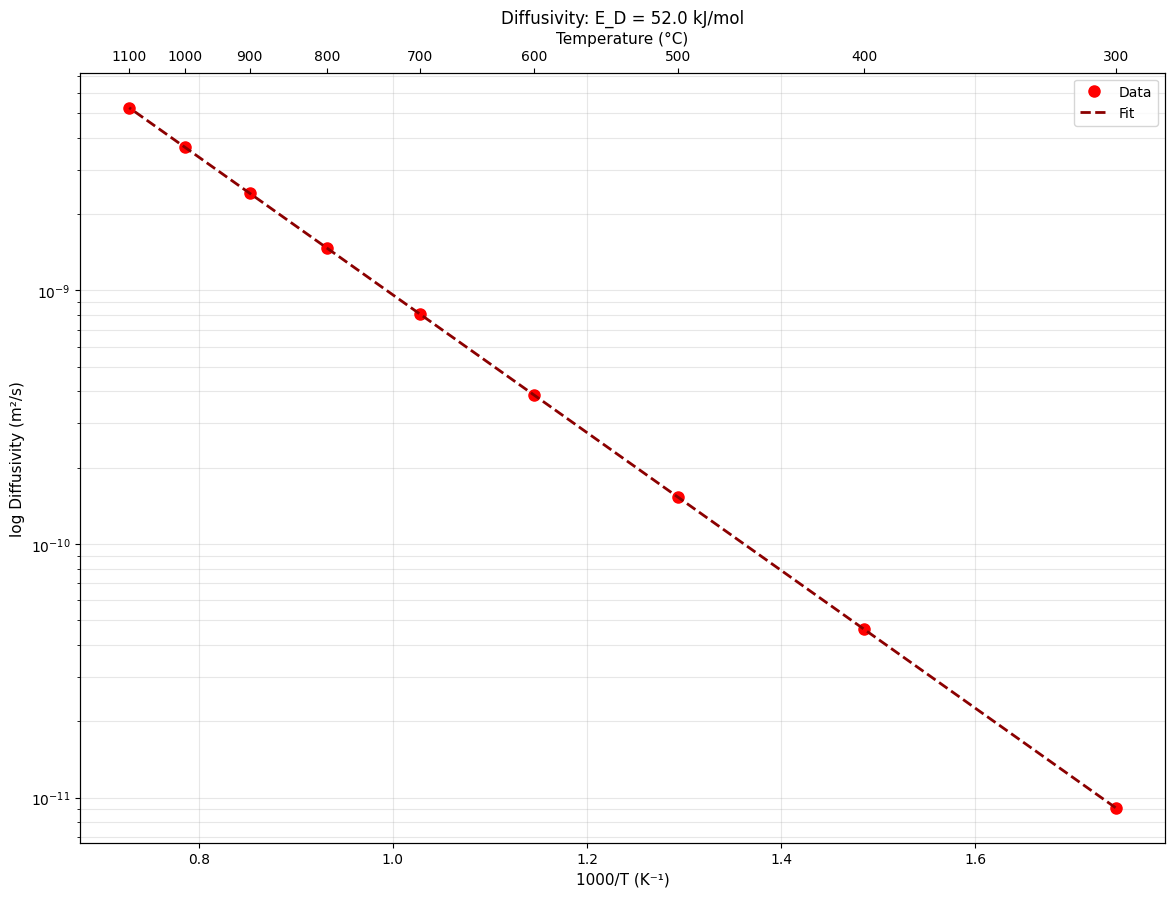

In [18]:
fig, axes = plt.subplots(figsize=(14, 10))
#fig.suptitle(f'Arrhenius Analysis: {material}', fontsize=14, fontweight='bold')

# Plot 1: Diffusivity
ax = axes
ax.semilogy(x_data, diffusivities, 'o', markersize=8, color='red', label='Data')
y_fit_D = np.exp(slope_D * x_data + intercept_D)
ax.semilogy(x_data, y_fit_D, '--', linewidth=2, color='darkred', label='Fit')
ax.set_xlabel('1000/T (K⁻¹)', fontsize=11)
ax.set_ylabel('log Diffusivity (m²/s)', fontsize=11)
ax.set_title(f'Diffusivity: E_D = {E_D_extracted/1000:.1f} kJ/mol', fontsize=12)
ax.grid(True, which='both', alpha=0.3)
ax.legend()

# Add top temperature axis
ax_top = ax.twiny()
temp_ticks = np.array([300,400,500,600,700,800,900,1000,1100])
ax_top.set_xlim(ax.get_xlim())
ax_top.set_xticks(1000/(temp_ticks + 273.15))
ax_top.set_xticklabels([f"{t}" for t in temp_ticks])
ax_top.set_xlabel('Temperature (°C)', fontsize=11)


Text(0.5, 0, 'Temperature (°C)')

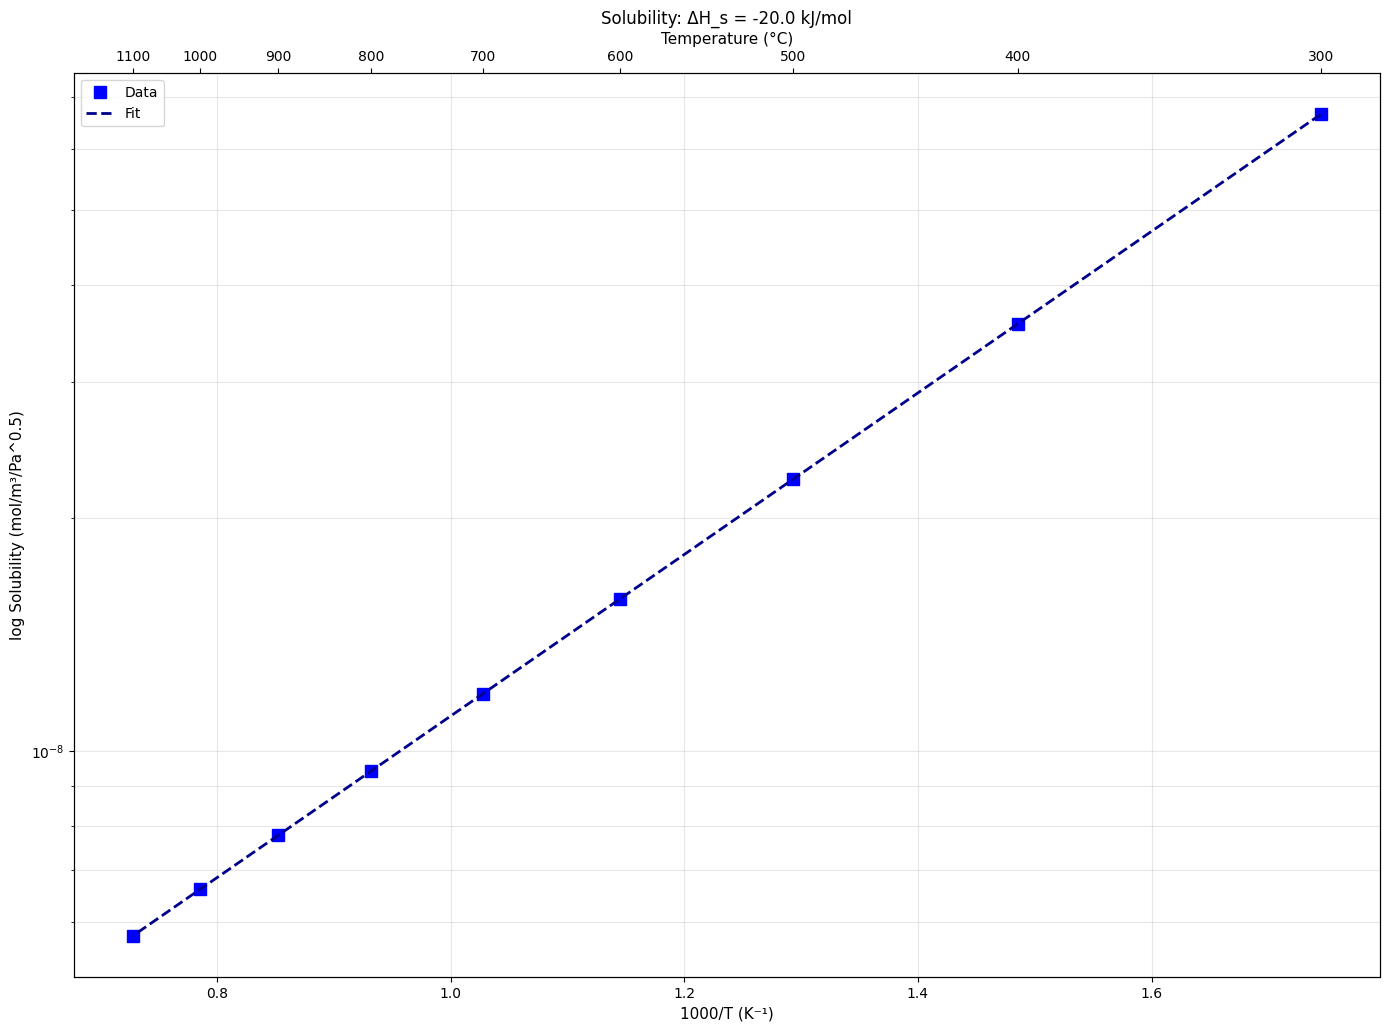

In [19]:
# Plot 2: Solubility
fig, axes = plt.subplots(figsize=(14, 10))
#fig.suptitle(f'Arrhenius Analysis: {material}', fontsize=14, fontweight='bold')

ax = axes
ax.semilogy(x_data, solubilities, 's', markersize=8, color='blue', label='Data')
y_fit_K = np.exp(slope_K * x_data + intercept_K)
ax.semilogy(x_data, y_fit_K, '--', linewidth=2, color='darkblue', label='Fit')
ax.set_xlabel('1000/T (K⁻¹)', fontsize=11)
ax.set_ylabel('log Solubility (mol/m³/Pa^0.5)', fontsize=11)
ax.set_title(f'Solubility: ΔH_s = {H_s_extracted/1000:.1f} kJ/mol', fontsize=12)
ax.grid(True, which='both', alpha=0.3)
ax.legend()
plt.tight_layout()

# Add top temperature axis
ax_top = ax.twiny()
temp_ticks = np.array([300,400,500,600,700,800,900,1000,1100])
ax_top.set_xlim(ax.get_xlim())
ax_top.set_xticks(1000/(temp_ticks + 273.15))
ax_top.set_xticklabels([f"{t}" for t in temp_ticks])
ax_top.set_xlabel('Temperature (°C)', fontsize=11)


Text(0.5, 0, 'Temperature (°C)')

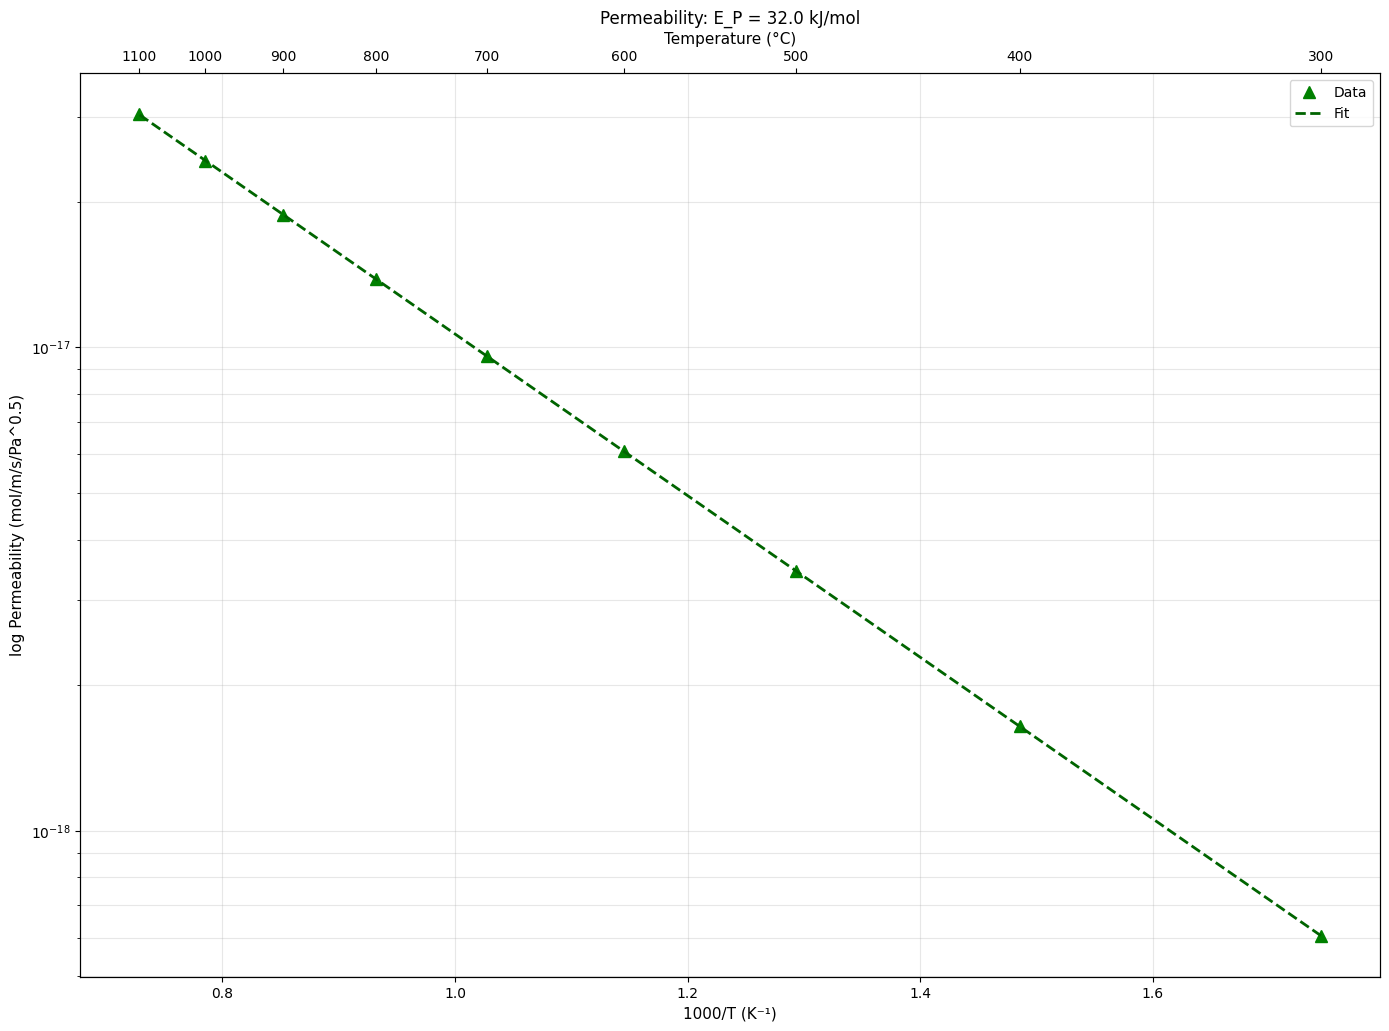

In [20]:
fig, axes = plt.subplots(figsize=(14, 10))
#fig.suptitle(f'Arrhenius Analysis: {material}', fontsize=14, fontweight='bold')

# Plot 3: Permeability
ax = axes
ax.semilogy(x_data, permeabilities, '^', markersize=8, color='green', label='Data')
y_fit_P = np.exp(slope_P * x_data + intercept_P)
ax.semilogy(x_data, y_fit_P, '--', linewidth=2, color='darkgreen', label='Fit')
ax.set_xlabel('1000/T (K⁻¹)', fontsize=11)
ax.set_ylabel('log Permeability (mol/m/s/Pa^0.5)', fontsize=11)
ax.set_title(f'Permeability: E_P = {E_P_extracted/1000:.1f} kJ/mol', fontsize=12)
ax.grid(True, which='both', alpha=0.3)
ax.legend()
plt.tight_layout()

# Add top temperature axis
ax_top = ax.twiny()
temp_ticks = np.array([300,400,500,600,700,800,900,1000,1100])
ax_top.set_xlim(ax.get_xlim())
ax_top.set_xticks(1000/(temp_ticks + 273.15))
ax_top.set_xticklabels([f"{t}" for t in temp_ticks])
ax_top.set_xlabel('Temperature (°C)', fontsize=11)


Text(0.5, 0, 'Temperature (°C)')

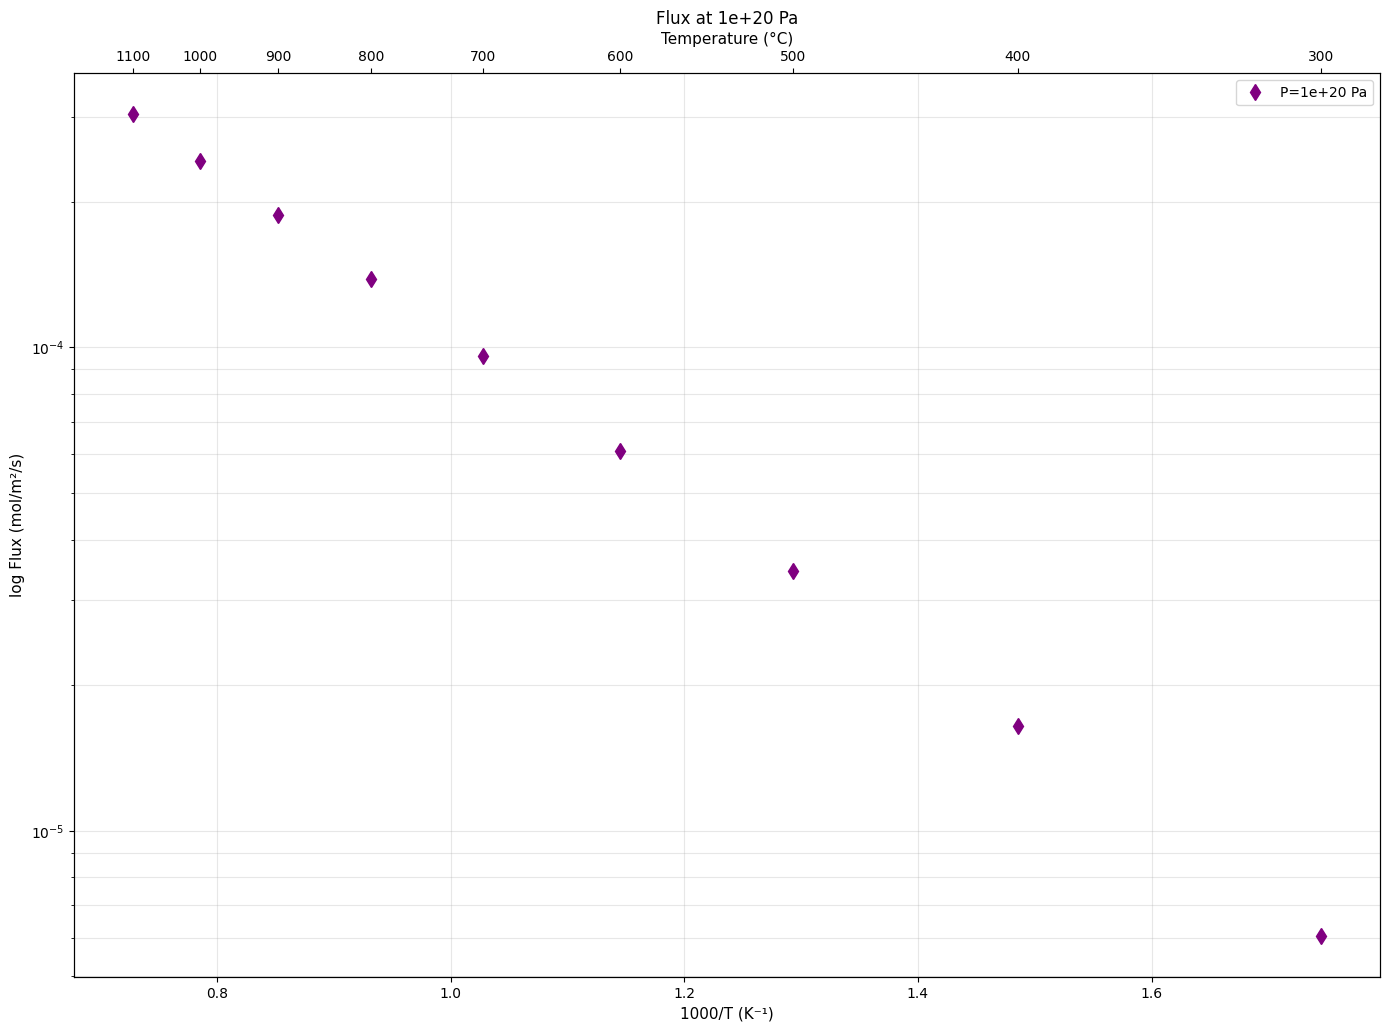

In [21]:
fig, axes = plt.subplots(figsize=(14, 10))
#fig.suptitle(f'Arrhenius Analysis: {material}', fontsize=14, fontweight='bold')
# Plot 4: Flux at fixed upstream pressure
ax = axes
ax.semilogy(x_data, fluxes, 'd', markersize=8, color='purple', label=f'P={P_upstream} Pa')
ax.set_xlabel('1000/T (K⁻¹)', fontsize=11)
ax.set_ylabel('log Flux (mol/m²/s)', fontsize=11)
ax.set_title(f'Flux at {P_upstream} Pa', fontsize=12)
ax.grid(True, which='both', alpha=0.3)
ax.legend()

plt.tight_layout()

# Add top temperature axis
ax_top = ax.twiny()
temp_ticks = np.array([300,400,500,600,700,800,900,1000,1100])
ax_top.set_xlim(ax.get_xlim())
ax_top.set_xticks(1000/(temp_ticks + 273.15))
ax_top.set_xticklabels([f"{t}" for t in temp_ticks])
ax_top.set_xlabel('Temperature (°C)', fontsize=11)


##### Sensitivity Analysis

In [22]:
from SALib.sample import morris as morris_sampler
from SALib.analyze import morris as morris_analyzer
from SALib.plotting import morris as morris_plotter
from SALib.sample import saltelli as sobol_sampler
from SALib.analyze import sobol as sobol_analyzer
import matplotlib.pyplot as plt
import pandas as pd

In [23]:
#Step 1: Define a problem file
#Step 2: generate a sample  using morris.sample() procedure from the SALib package
# Step 3: Factor Prioritisation run analysis to get output mu,sigma and mu_star
    # * **Mu** is the mean effect caused by the input parameter being moved over its range.
    # * **Sigma** is the standard deviation of the mean effect.
    # * **Mu_star** is the mean absolute effect.
#Step 4: Plot the result

#### Level 1 Sensitivity Analysis

In [24]:
from validation.sensitivity_level1 import *

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from SALib.sample import morris as morris_sampler
from SALib.analyze import morris as morris_analyzer
from SALib.sample import saltelli as sobol_sampler
from SALib.analyze import sobol as sobol_analyzer

from calculations.permeation_calc import calculate_simple_metal_flux
from calculations.utils import get_diffusivity, get_solubility, get_permeability
from data.material_data import MATERIALS

In [26]:
from validation.sensitivity_level1 import *

### Senaitivity Analysis: Level 1

In [27]:
# =============================================================================
# PART 1: DEFINE PARAMETER RANGES
# =============================================================================

# Direct parameter ranges for LEVEL 1 model
# param_ranges_direct = {
#     'D': [1e-12, 1e-6],           # Diffusivity (m²/s)
#     'K_s': [1e-4, 1e1],           # Solubility (mol/m³/Pa^0.5)
#     'thickness': [1e-4, 2e-3],    # Thickness (m): 0.1-2 mm
#     'P_up': [0.01, 1e5],           # Upstream pressure (Pa)
# }

# Arrhenius parameter ranges (alternative formulation)
param_ranges_arrhenius = {
    'D_0': [1e-10, 1e-4],         # Diffusivity prefactor (m²/s)
    'E_D': [20000, 80000],        # Activation energy for diffusion (J/mol)
    'K_s0': [1e-2, 1e4],          # Solubility prefactor (mol/m³/Pa^0.5)
    'H_s': [-40000, 30000],       # Enthalpy of solution (J/mol)
    'temperature': [873, 1273],   # Temperature (K): 600-1000°C
    'thickness': [1e-4, 2e-3],    # Thickness (m)
    'P_up': [0.001, 1e10]           # Upstream pressure (Pa)
}

print("\n" + "="*80)
print("PARAMETER RANGES DEFINED")
print("="*80)
# print("\nDirect Parameters:")
# for param, (low, high) in param_ranges_direct.items():
#     print(f"  {param:15s}: [{low:.2e}, {high:.2e}]")

print("\nArrhenius Parameters:")
for param, (low, high) in param_ranges_arrhenius.items():
    print(f"  {param:15s}: [{low:.2e}, {high:.2e}]")
print("="*80)


PARAMETER RANGES DEFINED

Arrhenius Parameters:
  D_0            : [1.00e-10, 1.00e-04]
  E_D            : [2.00e+04, 8.00e+04]
  K_s0           : [1.00e-02, 1.00e+04]
  H_s            : [-4.00e+04, 3.00e+04]
  temperature    : [8.73e+02, 1.27e+03]
  thickness      : [1.00e-04, 2.00e-03]
  P_up           : [1.00e-03, 1.00e+10]


Morris method is a screening technique that identifies important parameters with minimal computational cost (10-100 model evaluations).

Interpretation:
- μ* (mu-star): Overall importance (higher = more influential)
- σ  (sigma):   Nonlinearity/interactions (higher = complex effects)


MORRIS SENSITIVITY ANALYSIS - LEVEL 1 (Clean Metal)
Running 160 Morris samples...
Varying parameters: D_0, E_D, K_s0, H_s, temperature, thickness, P_up
Output metric: D

  Completed 10/160 samples
  Completed 20/160 samples
  Completed 30/160 samples
  Completed 40/160 samples
  Completed 50/160 samples
  Completed 60/160 samples
  Completed 70/160 samples
  Completed 80/160 samples
  Completed 90/160 samples
  Completed 100/160 samples
  Completed 110/160 samples
  Completed 120/160 samples
  Completed 130/160 samples
  Completed 140/160 samples
  Completed 150/160 samples
  Completed 160/160 samples

✓ Morris analysis complete
  Output range: [1.63e-15, 1.51e-05]


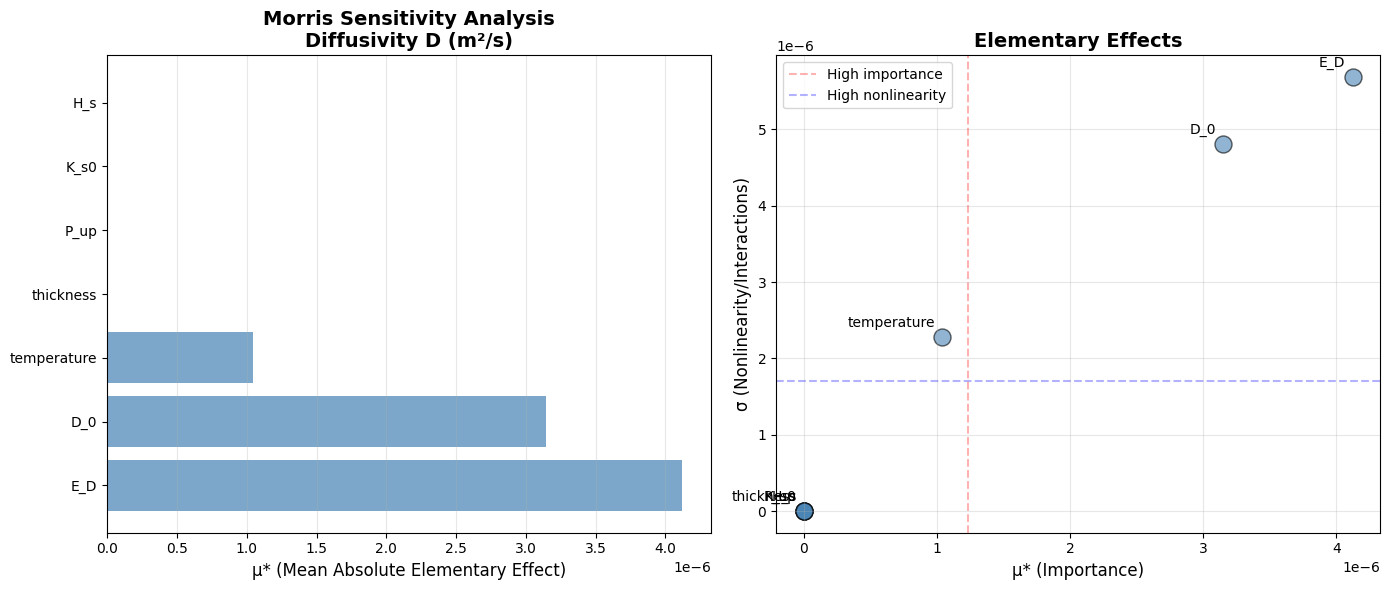


MORRIS SENSITIVITY RESULTS - Diffusivity D (m²/s)
  Parameter       μ*        σ  μ*_conf
        E_D 0.000004 0.000006 0.000003
        D_0 0.000003 0.000005 0.000002
temperature 0.000001 0.000002 0.000001
  thickness 0.000000 0.000000 0.000000
       P_up 0.000000 0.000000 0.000000
       K_s0 0.000000 0.000000 0.000000
        H_s 0.000000 0.000000 0.000000

Interpretation:
  μ* : Overall importance (higher = more influential)
  σ  : Nonlinearity/Interactions (higher = more complex)



In [28]:
# -----------------------------------------------------------------------------
# Morris Analysis: Diffusivity D
# -----------------------------------------------------------------------------
Si_morris_D, problem_D, Y_D = morris_sensitivity_level1(
    param_ranges_arrhenius,
    N_trajectories=20,
    num_levels=4,
    output_metric='D'  # ← Analyze diffusivity!
)
plot_morris_results(Si_morris_D, problem_D, 'Diffusivity D (m²/s)')



MORRIS SENSITIVITY ANALYSIS - LEVEL 1 (Clean Metal)
Running 160 Morris samples...
Varying parameters: D_0, E_D, K_s0, H_s, temperature, thickness, P_up
Output metric: K_s

  Completed 10/160 samples
  Completed 20/160 samples
  Completed 30/160 samples
  Completed 40/160 samples
  Completed 50/160 samples
  Completed 60/160 samples
  Completed 70/160 samples
  Completed 80/160 samples
  Completed 90/160 samples
  Completed 100/160 samples
  Completed 110/160 samples
  Completed 120/160 samples
  Completed 130/160 samples
  Completed 140/160 samples
  Completed 150/160 samples
  Completed 160/160 samples

✓ Morris analysis complete
  Output range: [1.60e-04, 2.47e+06]


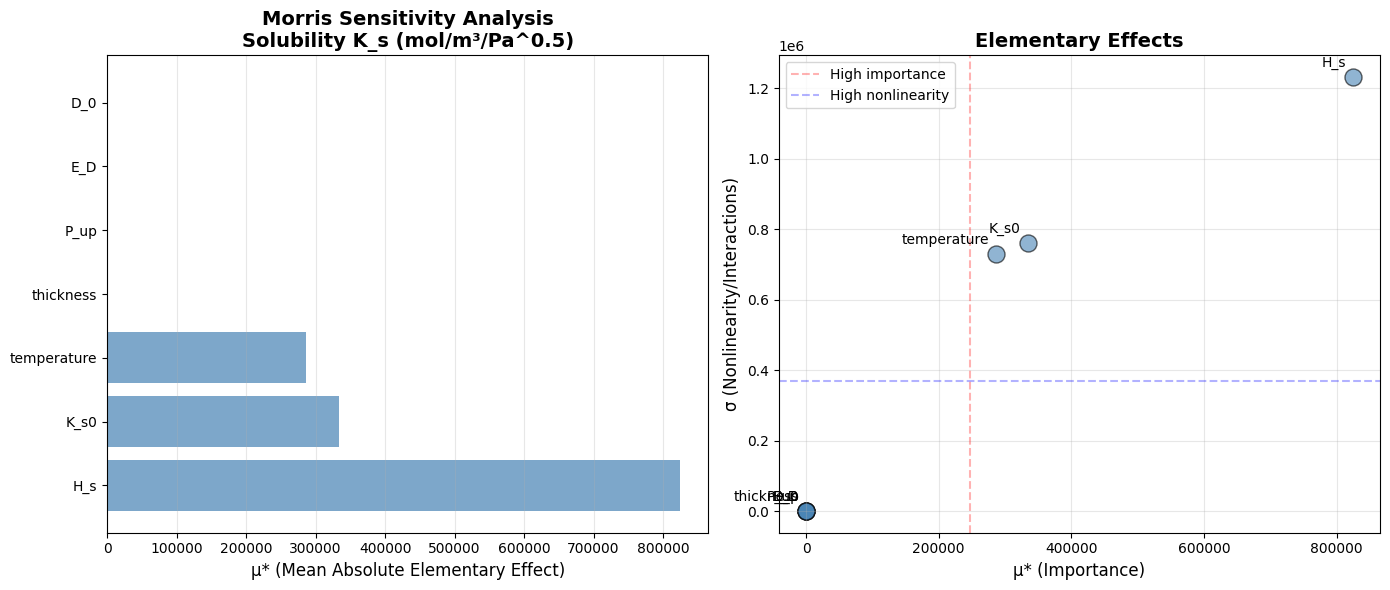


MORRIS SENSITIVITY RESULTS - Solubility K_s (mol/m³/Pa^0.5)
  Parameter            μ*            σ       μ*_conf
        H_s 824196.398045 1.231126e+06 647149.774456
       K_s0 334124.969111 7.596409e+05 356859.624465
temperature 286667.177808 7.287112e+05 337349.511692
  thickness      0.000000 0.000000e+00      0.000000
       P_up      0.000000 0.000000e+00      0.000000
        E_D      0.000000 0.000000e+00      0.000000
        D_0      0.000000 0.000000e+00      0.000000

Interpretation:
  μ* : Overall importance (higher = more influential)
  σ  : Nonlinearity/Interactions (higher = more complex)



In [29]:
# -----------------------------------------------------------------------------
# Morris Analysis: Solubility K_s
# -----------------------------------------------------------------------------
Si_morris_Ks, problem_Ks, Y_Ks = morris_sensitivity_level1(
    param_ranges_arrhenius,
    N_trajectories=20,
    num_levels=4,
    output_metric='K_s'  # ← Analyze solubility!
)
plot_morris_results(Si_morris_Ks, problem_Ks, 'Solubility K_s (mol/m³/Pa^0.5)')



MORRIS SENSITIVITY ANALYSIS - LEVEL 1 (Clean Metal)
Running 80 Morris samples...
Varying parameters: D_0, E_D, K_s0, H_s, temperature, thickness, P_up
Output metric: flux

  Completed 10/80 samples
  Completed 20/80 samples
  Completed 30/80 samples
  Completed 40/80 samples
  Completed 50/80 samples
  Completed 60/80 samples
  Completed 70/80 samples
  Completed 80/80 samples

✓ Morris analysis complete
  Output range: [9.35e-14, 7.49e+08]


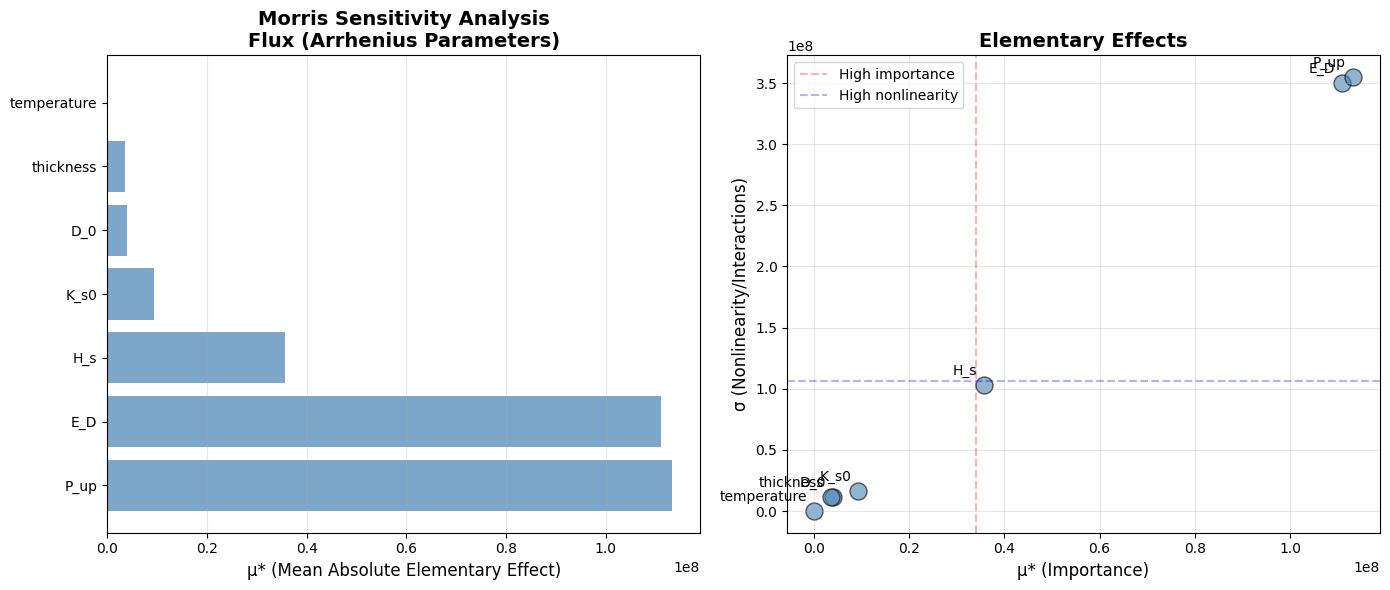


MORRIS SENSITIVITY RESULTS - Flux (Arrhenius Parameters)
  Parameter           μ*            σ      μ*_conf
       P_up 1.132507e+08 3.549073e+08 2.023565e+08
        E_D 1.109936e+08 3.499033e+08 1.965583e+08
        H_s 3.562944e+07 1.033558e+08 5.621226e+07
       K_s0 9.335419e+06 1.634485e+07 8.793732e+06
        D_0 3.908556e+06 1.167908e+07 7.161233e+06
  thickness 3.525903e+06 1.114948e+07 6.283014e+06
temperature 1.159006e+04 2.485925e+04 1.486648e+04

Interpretation:
  μ* : Overall importance (higher = more influential)
  σ  : Nonlinearity/Interactions (higher = more complex)



In [30]:
# =============================================================================
# 2.4 Morris Analysis: Arrhenius Formulation
# =============================================================================
# This analyzes temperature-dependent parameters directly

Si_morris_arrh, problem_arrh, Y_arrh = morris_sensitivity_level1(
    param_ranges_arrhenius,
    N_trajectories=10,
    num_levels=4,
    output_metric='flux',
    use_arrhenius=True
)

plot_morris_results(Si_morris_arrh, problem_arrh, 'Flux (Arrhenius Parameters)')


MORRIS SENSITIVITY ANALYSIS - LEVEL 1 (Clean Metal)
Running 80 Morris samples...
Varying parameters: D_0, E_D, K_s0, H_s, temperature, thickness, P_up
Output metric: permeability

  Completed 10/80 samples
  Completed 20/80 samples
  Completed 30/80 samples
  Completed 40/80 samples
  Completed 50/80 samples
  Completed 60/80 samples
  Completed 70/80 samples
  Completed 80/80 samples

✓ Morris analysis complete
  Output range: [2.55e-15, 3.64e+00]


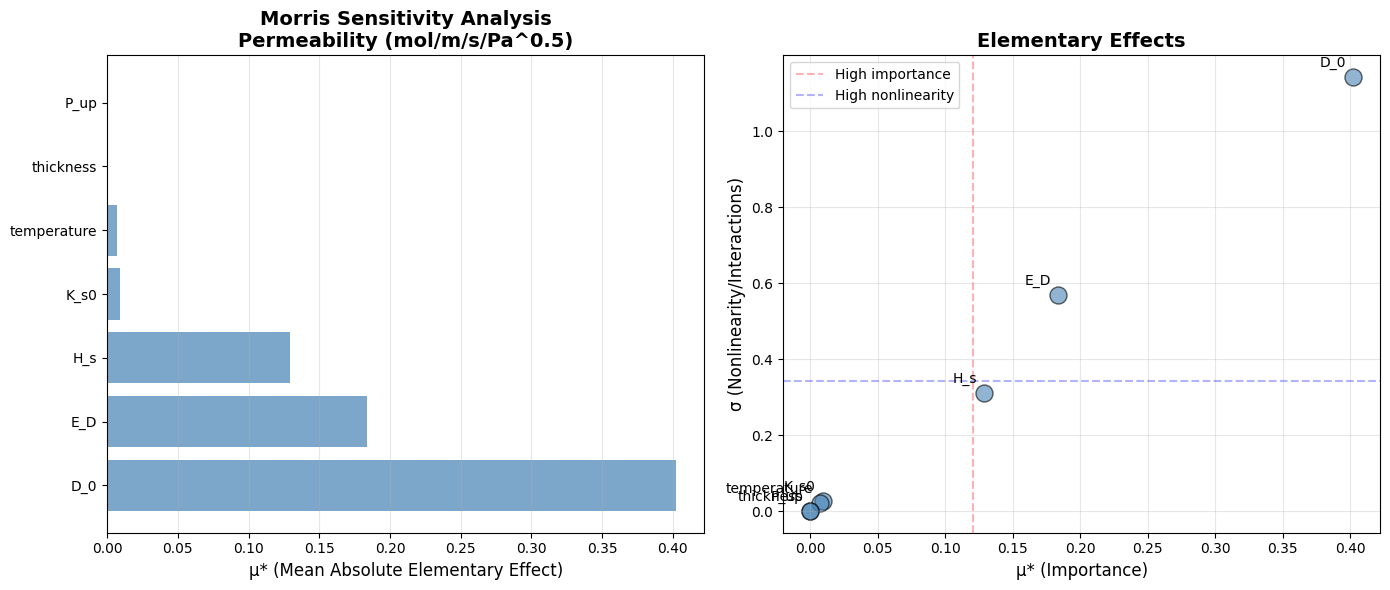


MORRIS SENSITIVITY RESULTS - Permeability (mol/m/s/Pa^0.5)
  Parameter       μ*        σ  μ*_conf
        D_0 0.402027 1.142223 0.704157
        E_D 0.183892 0.569475 0.345762
        H_s 0.129022 0.309534 0.169297
       K_s0 0.009206 0.026762 0.013263
temperature 0.007052 0.021275 0.010141
  thickness 0.000000 0.000000 0.000000
       P_up 0.000000 0.000000 0.000000

Interpretation:
  μ* : Overall importance (higher = more influential)
  σ  : Nonlinearity/Interactions (higher = more complex)



In [31]:
# =============================================================================
# 2.2 Morris Analysis: Permeability
# =============================================================================

Si_morris_perm, problem_perm, Y_perm = morris_sensitivity_level1(
    param_ranges_arrhenius,
    N_trajectories=10,
    num_levels=4,
    output_metric='permeability'
)

plot_morris_results(Si_morris_perm, problem_perm, 'Permeability (mol/m/s/Pa^0.5)')


MORRIS SENSITIVITY ANALYSIS - LEVEL 1 (Clean Metal)
Running 80 Morris samples...
Varying parameters: D_0, E_D, K_s0, H_s, temperature, thickness, P_up
Output metric: C_up

  Completed 10/80 samples
  Completed 20/80 samples
  Completed 30/80 samples
  Completed 40/80 samples
  Completed 50/80 samples
  Completed 60/80 samples
  Completed 70/80 samples
  Completed 80/80 samples

✓ Morris analysis complete
  Output range: [1.68e-04, 1.65e+11]


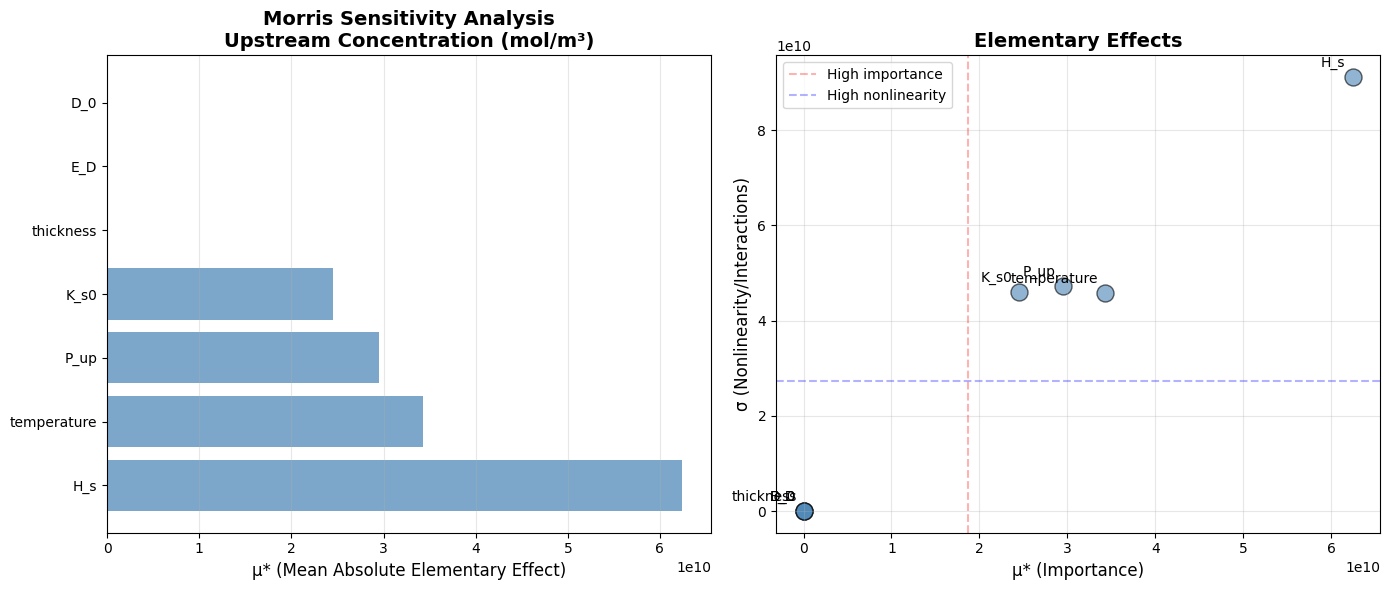


MORRIS SENSITIVITY RESULTS - Upstream Concentration (mol/m³)
  Parameter           μ*            σ      μ*_conf
        H_s 6.243914e+10 9.114615e+10 4.928923e+10
temperature 3.431987e+10 4.574006e+10 2.744177e+10
       P_up 2.947634e+10 4.731404e+10 2.895445e+10
       K_s0 2.453539e+10 4.602094e+10 2.594906e+10
  thickness 0.000000e+00 0.000000e+00 0.000000e+00
        E_D 0.000000e+00 0.000000e+00 0.000000e+00
        D_0 0.000000e+00 0.000000e+00 0.000000e+00

Interpretation:
  μ* : Overall importance (higher = more influential)
  σ  : Nonlinearity/Interactions (higher = more complex)



In [32]:
# =============================================================================
# 2.3 Morris Analysis: Upstream Concentration
# =============================================================================

Si_morris_C, problem_C, Y_C = morris_sensitivity_level1(
    param_ranges_arrhenius,
    N_trajectories=10,
    num_levels=4,
    output_metric='C_up'
)

plot_morris_results(Si_morris_C, problem_C, 'Upstream Concentration (mol/m³)')

Sobol method provides quantitative variance decomposition:
- S1 (First-order):  Direct effect of parameter alone
- ST (Total-order):  Direct effect + all interactions
- S2 (Second-order): Pairwise interaction effects

Interpretation:
- S1 ≈ ST  → Parameter has mainly direct effects (no strong interactions)
- S1 << ST → Parameter has strong interactions with others


SOBOL SENSITIVITY ANALYSIS - LEVEL 1 (Clean Metal)
Running 16384 Sobol samples...
Varying parameters: D_0, E_D, K_s0, H_s, temperature, thickness, P_up
Output metric: D
This may take a while...

  Completed 500/16384 samples
  Completed 1000/16384 samples
  Completed 1500/16384 samples
  Completed 2000/16384 samples
  Completed 2500/16384 samples
  Completed 3000/16384 samples
  Completed 3500/16384 samples
  Completed 4000/16384 samples
  Completed 4500/16384 samples
  Completed 5000/16384 samples
  Completed 5500/16384 samples
  Completed 6000/16384 samples
  Completed 6500/16384 samples
  Completed 7000/16384 samples
  Completed 7500/16384 samples
  Completed 8000/16384 samples
  Completed 8500/16384 samples
  Completed 9000/16384 samples
  Completed 9500/16384 samples
  Completed 10000/16384 samples
  Completed 10500/16384 samples
  Completed 11000/16384 samples
  Completed 11500/16384 samples
  Completed 12000/16384 samples
  Completed 12500/16384 samples
  Completed 13000/16384 

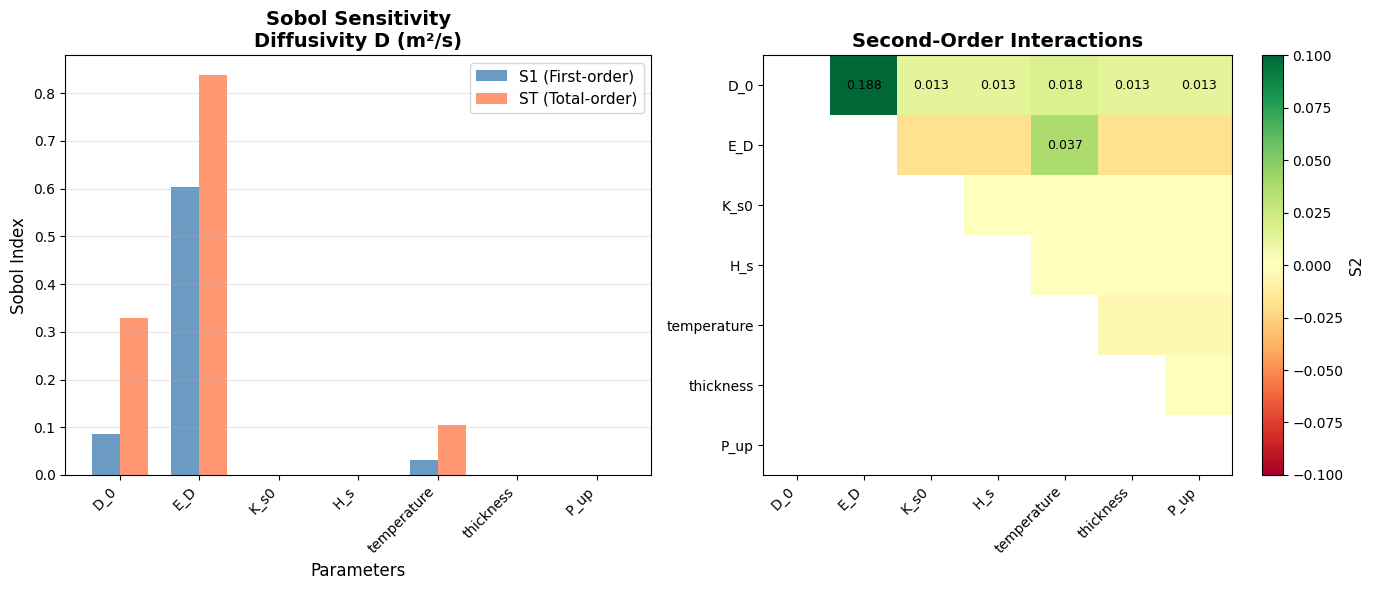


SOBOL SENSITIVITY RESULTS - Diffusivity D (m²/s)
  Parameter       S1  S1_conf       ST  ST_conf  Interactions
        D_0 0.085996 0.046758 0.328077 0.094427      0.242081
        E_D 0.602793 0.121844 0.837665 0.120974      0.234872
       K_s0 0.000000 0.000000 0.000000 0.000000      0.000000
        H_s 0.000000 0.000000 0.000000 0.000000      0.000000
temperature 0.031365 0.026386 0.104769 0.024563      0.073404
  thickness 0.000000 0.000000 0.000000 0.000000      0.000000
       P_up 0.000000 0.000000 0.000000 0.000000      0.000000

Interpretation:
  S1 : First-order effect (direct influence)
  ST : Total-order effect (direct + interactions)
  ST-S1 : Pure interaction effects

Top 3 Most Influential Parameters:
  E_D: ST = 0.838 (S1 = 0.603)
  D_0: ST = 0.328 (S1 = 0.086)
  temperature: ST = 0.105 (S1 = 0.031)



In [33]:
# -----------------------------------------------------------------------------
# Sobol Analysis: Diffusivity D
# -----------------------------------------------------------------------------
Si_sobol_D, problem_sobol_D, Y_sobol_D = sobol_sensitivity_level1(
    param_ranges_arrhenius,
    N_samples=1024,
    output_metric='D',
    calc_second_order=True
)
plot_sobol_results(Si_sobol_D, problem_sobol_D, 'Diffusivity D (m²/s)')



SOBOL SENSITIVITY ANALYSIS - LEVEL 1 (Clean Metal)
Running 16384 Sobol samples...
Varying parameters: D_0, E_D, K_s0, H_s, temperature, thickness, P_up
Output metric: K_s
This may take a while...

  Completed 500/16384 samples
  Completed 1000/16384 samples
  Completed 1500/16384 samples
  Completed 2000/16384 samples
  Completed 2500/16384 samples
  Completed 3000/16384 samples
  Completed 3500/16384 samples
  Completed 4000/16384 samples
  Completed 4500/16384 samples
  Completed 5000/16384 samples
  Completed 5500/16384 samples
  Completed 6000/16384 samples
  Completed 6500/16384 samples
  Completed 7000/16384 samples
  Completed 7500/16384 samples
  Completed 8000/16384 samples
  Completed 8500/16384 samples
  Completed 9000/16384 samples
  Completed 9500/16384 samples
  Completed 10000/16384 samples
  Completed 10500/16384 samples
  Completed 11000/16384 samples
  Completed 11500/16384 samples
  Completed 12000/16384 samples
  Completed 12500/16384 samples
  Completed 13000/1638

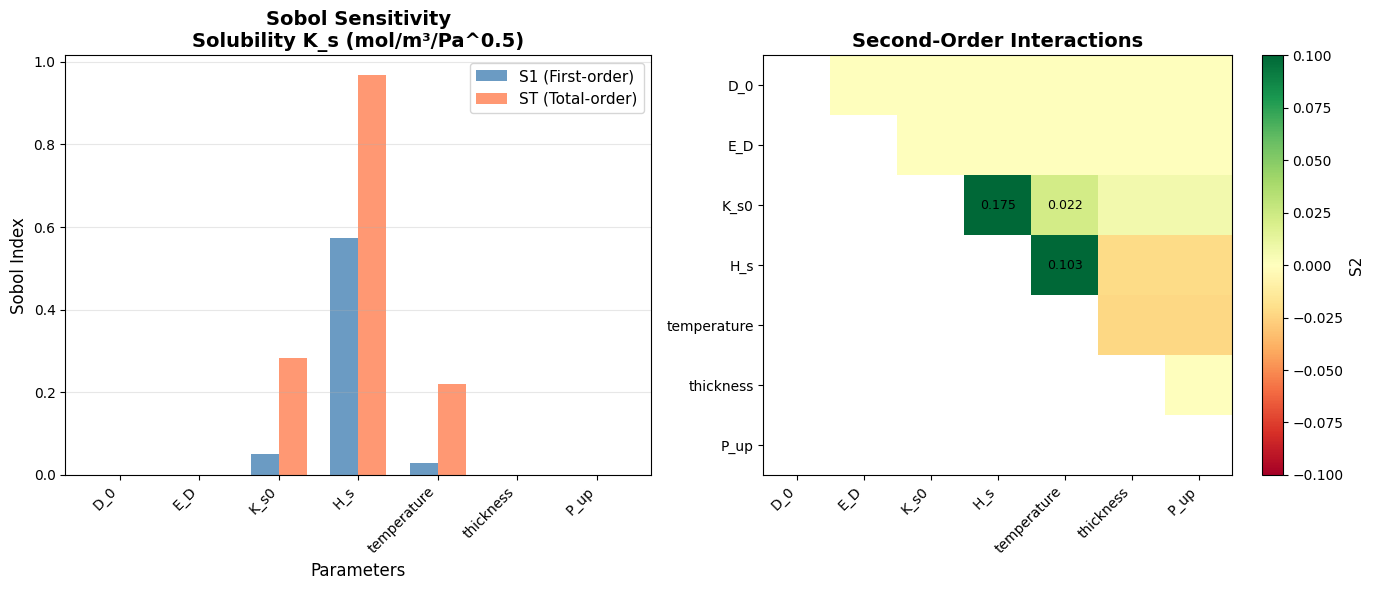


SOBOL SENSITIVITY RESULTS - Solubility K_s (mol/m³/Pa^0.5)
  Parameter       S1  S1_conf       ST  ST_conf  Interactions
        D_0 0.000000 0.000000 0.000000 0.000000      0.000000
        E_D 0.000000 0.000000 0.000000 0.000000      0.000000
       K_s0 0.051029 0.037632 0.282418 0.108166      0.231389
        H_s 0.572605 0.139256 0.967483 0.240422      0.394877
temperature 0.027910 0.027801 0.219158 0.103220      0.191248
  thickness 0.000000 0.000000 0.000000 0.000000      0.000000
       P_up 0.000000 0.000000 0.000000 0.000000      0.000000

Interpretation:
  S1 : First-order effect (direct influence)
  ST : Total-order effect (direct + interactions)
  ST-S1 : Pure interaction effects

Top 3 Most Influential Parameters:
  H_s: ST = 0.967 (S1 = 0.573)
  K_s0: ST = 0.282 (S1 = 0.051)
  temperature: ST = 0.219 (S1 = 0.028)



In [34]:
# -----------------------------------------------------------------------------
# Sobol Analysis: Solubility K_s
# -----------------------------------------------------------------------------
Si_sobol_Ks, problem_sobol_Ks, Y_sobol_Ks = sobol_sensitivity_level1(
    param_ranges_arrhenius,
    N_samples=1024,
    output_metric='K_s',
    calc_second_order=True
)
plot_sobol_results(Si_sobol_Ks, problem_sobol_Ks, 'Solubility K_s (mol/m³/Pa^0.5)')


SOBOL SENSITIVITY ANALYSIS - LEVEL 1 (Clean Metal)
Running 16384 Sobol samples...
Varying parameters: D_0, E_D, K_s0, H_s, temperature, thickness, P_up
Output metric: flux
This may take a while...

  Completed 500/16384 samples
  Completed 1000/16384 samples
  Completed 1500/16384 samples
  Completed 2000/16384 samples
  Completed 2500/16384 samples
  Completed 3000/16384 samples
  Completed 3500/16384 samples
  Completed 4000/16384 samples
  Completed 4500/16384 samples
  Completed 5000/16384 samples
  Completed 5500/16384 samples
  Completed 6000/16384 samples
  Completed 6500/16384 samples
  Completed 7000/16384 samples
  Completed 7500/16384 samples
  Completed 8000/16384 samples
  Completed 8500/16384 samples
  Completed 9000/16384 samples
  Completed 9500/16384 samples
  Completed 10000/16384 samples
  Completed 10500/16384 samples
  Completed 11000/16384 samples
  Completed 11500/16384 samples
  Completed 12000/16384 samples
  Completed 12500/16384 samples
  Completed 13000/163

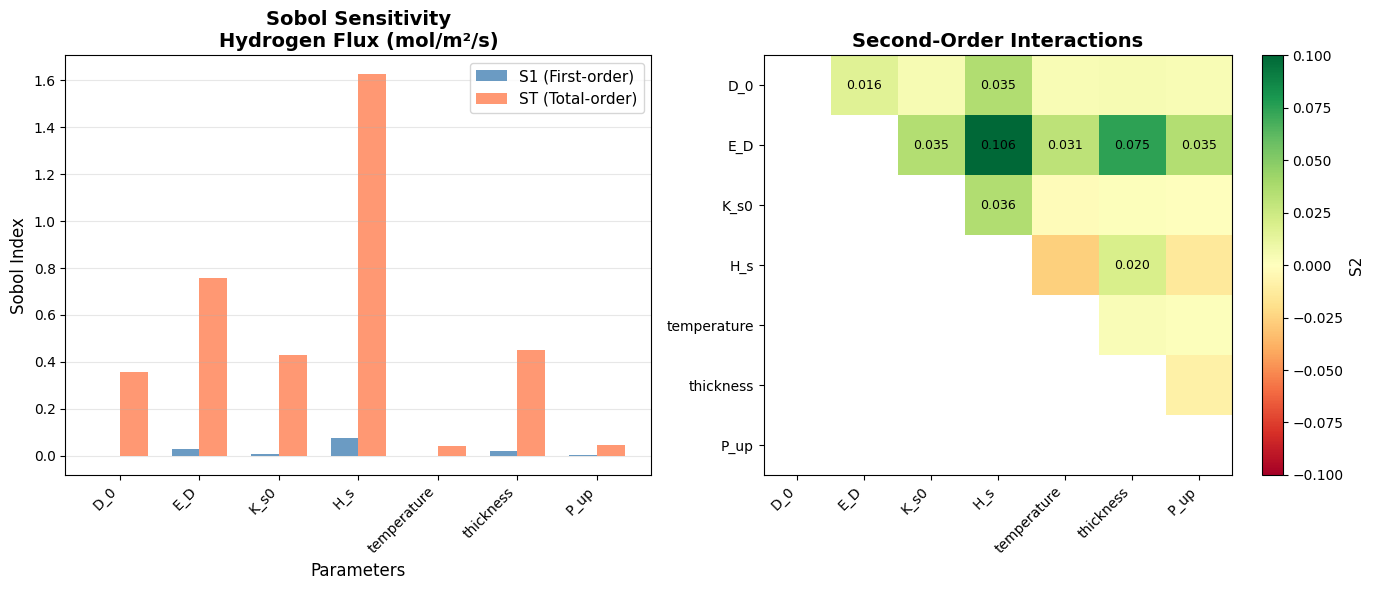


SOBOL SENSITIVITY RESULTS - Hydrogen Flux (mol/m²/s)
  Parameter        S1  S1_conf       ST  ST_conf  Interactions
        D_0 -0.000029 0.009363 0.357274 0.249525      0.357303
        E_D  0.028602 0.020851 0.755872 0.340204      0.727270
       K_s0  0.005794 0.013514 0.427884 0.553198      0.422090
        H_s  0.074278 0.108460 1.625290 1.952879      1.551012
temperature -0.000684 0.003411 0.043536 0.045792      0.044220
  thickness  0.019150 0.034044 0.452138 0.331091      0.432988
       P_up  0.004050 0.007156 0.046999 0.047782      0.042949

Interpretation:
  S1 : First-order effect (direct influence)
  ST : Total-order effect (direct + interactions)
  ST-S1 : Pure interaction effects

Top 3 Most Influential Parameters:
  H_s: ST = 1.625 (S1 = 0.074)
  E_D: ST = 0.756 (S1 = 0.029)
  thickness: ST = 0.452 (S1 = 0.019)



In [35]:
# =============================================================================
# 3.1 Sobol Analysis: Flux (Direct Parameters)
# =============================================================================

Si_sobol_flux, problem_sobol_flux, Y_sobol_flux = sobol_sensitivity_level1(
    param_ranges_arrhenius,
    N_samples=1024,              # Use 1024+ for publication-quality results
    output_metric='flux',
    calc_second_order=True      # Set False for faster computation
)

plot_sobol_results(Si_sobol_flux, problem_sobol_flux, 'Hydrogen Flux (mol/m²/s)')


SOBOL SENSITIVITY ANALYSIS - LEVEL 1 (Clean Metal)
Running 16384 Sobol samples...
Varying parameters: D_0, E_D, K_s0, H_s, temperature, thickness, P_up
Output metric: permeability
This may take a while...

  Completed 500/16384 samples
  Completed 1000/16384 samples
  Completed 1500/16384 samples
  Completed 2000/16384 samples
  Completed 2500/16384 samples
  Completed 3000/16384 samples
  Completed 3500/16384 samples
  Completed 4000/16384 samples
  Completed 4500/16384 samples
  Completed 5000/16384 samples
  Completed 5500/16384 samples
  Completed 6000/16384 samples
  Completed 6500/16384 samples
  Completed 7000/16384 samples
  Completed 7500/16384 samples
  Completed 8000/16384 samples
  Completed 8500/16384 samples
  Completed 9000/16384 samples
  Completed 9500/16384 samples
  Completed 10000/16384 samples
  Completed 10500/16384 samples
  Completed 11000/16384 samples
  Completed 11500/16384 samples
  Completed 12000/16384 samples
  Completed 12500/16384 samples
  Completed 1

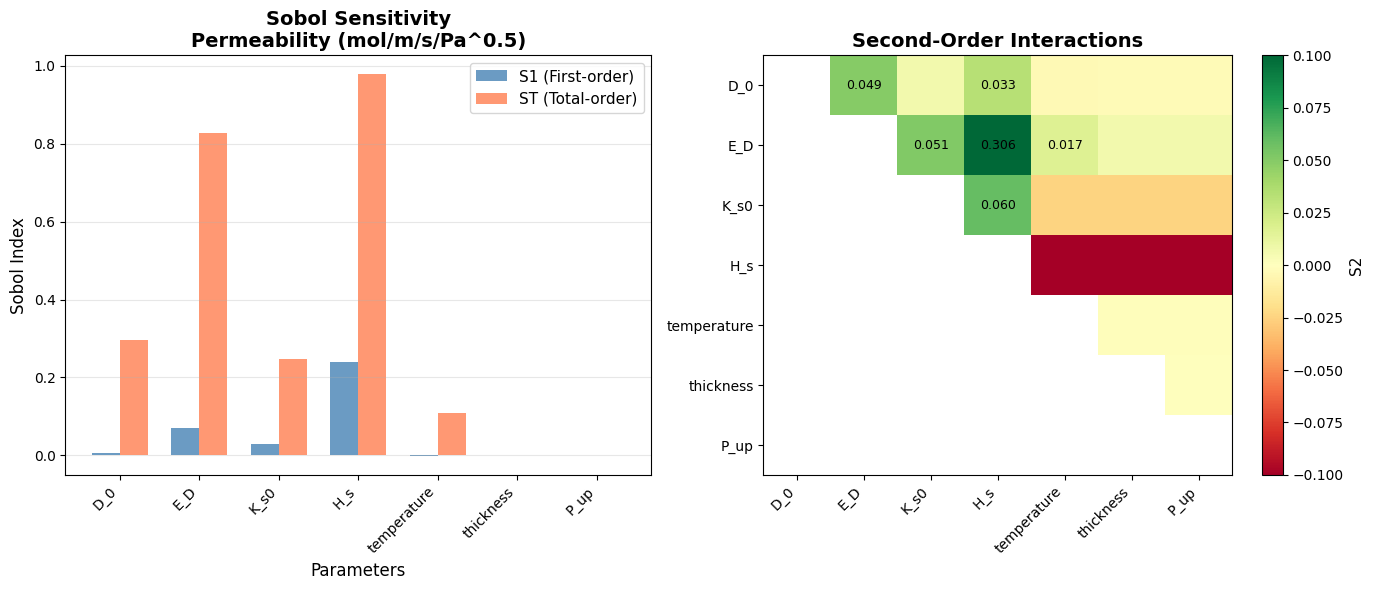


SOBOL SENSITIVITY RESULTS - Permeability (mol/m/s/Pa^0.5)
  Parameter        S1  S1_conf       ST  ST_conf  Interactions
        D_0  0.006599 0.017205 0.295468 0.328291      0.288869
        E_D  0.070732 0.060536 0.827489 0.327056      0.756756
       K_s0  0.029350 0.049964 0.247423 0.151939      0.218074
        H_s  0.239078 0.375116 0.978289 0.596141      0.739211
temperature -0.001565 0.005890 0.109770 0.142027      0.111336
  thickness  0.000000 0.000000 0.000000 0.000000      0.000000
       P_up  0.000000 0.000000 0.000000 0.000000      0.000000

Interpretation:
  S1 : First-order effect (direct influence)
  ST : Total-order effect (direct + interactions)
  ST-S1 : Pure interaction effects

Top 3 Most Influential Parameters:
  H_s: ST = 0.978 (S1 = 0.239)
  E_D: ST = 0.827 (S1 = 0.071)
  D_0: ST = 0.295 (S1 = 0.007)



In [36]:
# =============================================================================
# 3.2 Sobol Analysis: Permeability
# =============================================================================

Si_sobol_perm, problem_sobol_perm, Y_sobol_perm = sobol_sensitivity_level1(
    param_ranges_arrhenius,
    N_samples=1024,
    output_metric='permeability',
    calc_second_order=True
)

plot_sobol_results(Si_sobol_perm, problem_sobol_perm, 'Permeability (mol/m/s/Pa^0.5)')

## Level 5 Sensitivity Analysis: Full System (30 Parameters)

Morris screening to identify the most important parameters across all levels:
- **Level 1**: Metal diffusivity & solubility (Arrhenius)
- **Level 2**: Oxide barrier properties
- **Level 3**: Oxide defect paths
- **Level 4**: Metal microstructure (GB + trapping)

In [45]:
from SALib.sample import morris as morris_sampler
from SALib.analyze import morris as morris_analyzer
from SALib.plotting import morris as morris_plotter
from SALib.sample import saltelli as sobol_sampler
from SALib.analyze import sobol as sobol_analyzer
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from validation.sensitivity_level1 import (
    morris_sensitivity_level5,
    sobol_sensitivity_level5,
    plot_morris_results,
    plot_sobol_results,
    SUGGESTED_RANGES_LEVEL5,
    DEFAULT_PARAMS_LEVEL5,
    VALID_OUTPUT_METRICS_L5
)

In [3]:
# =============================================================================
# LEVEL 5 SENSITIVITY ANALYSIS SETUP
# =============================================================================
from validation.sensitivity_level1 import (
    morris_sensitivity_level5,
    sobol_sensitivity_level5,
    plot_morris_results,
    plot_sobol_results,
    SUGGESTED_RANGES_LEVEL5,
    DEFAULT_PARAMS_LEVEL5,
    VALID_OUTPUT_METRICS_L5
)

# Check what we have
print(f"Number of parameters in SUGGESTED_RANGES_LEVEL5: {len(SUGGESTED_RANGES_LEVEL5)}")
print(f"\nParameters:")
for i, (param, bounds) in enumerate(SUGGESTED_RANGES_LEVEL5.items(), 1):
    print(f"  {i:2d}. {param:<25s}: [{bounds[0]:.2e}, {bounds[1]:.2e}]")

print(f"\nValid output metrics: {VALID_OUTPUT_METRICS_L5}")

Number of parameters in SUGGESTED_RANGES_LEVEL5: 27

Parameters:
   1. D_0                      : [1.00e-08, 1.00e-05]
   2. E_D                      : [4.00e+04, 7.00e+04]
   3. K_s0                     : [1.00e-10, 1.00e-07]
   4. H_s                      : [-4.00e+04, 0.00e+00]
   5. metal_thickness          : [5.00e-04, 5.00e-03]
   6. P_upstream               : [1.00e+03, 1.00e+06]
   7. D_ox_0                   : [1.00e-08, 1.00e-04]
   8. E_D_ox                   : [1.20e+05, 2.00e+05]
   9. K_ox_0                   : [1.00e-06, 1.00e-02]
  10. H_sol_ox                 : [1.50e+05, 2.20e+05]
  11. oxide_thickness          : [1.00e-08, 1.00e-05]
  12. defect_fraction          : [1.00e-04, 1.00e-01]
  13. crack_thickness_factor   : [1.00e-02, 5.00e-01]
  14. gb_diffusivity_factor    : [1.00e+00, 1.00e+02]
  15. grain_size               : [1.00e-07, 1.00e-04]
  16. gb_thickness             : [3.00e-10, 1.00e-09]
  17. gb_enhancement_factor    : [1.00e+01, 1.00e+03]
  18. lattice_de


MORRIS SENSITIVITY ANALYSIS - LEVEL 5 (Complete Hierarchical Model)
Running 420 Morris samples...
Parameters (27): D_0, E_D, K_s0, H_s, metal_thickness, P_upstream, D_ox_0, E_D_ox, K_ox_0, H_sol_ox, oxide_thickness, defect_fraction, crack_thickness_factor, gb_diffusivity_factor, grain_size, gb_thickness, gb_enhancement_factor, lattice_density, sites_per_area, trap_dislocation_E_b, trap_dislocation_N_T, trap_gb_E_b, trap_vacancy_E_b, trap_vacancy_N_T, trap_carbide_E_b, trap_carbide_N_T, temperature
Output metric: flux

  Completed 10/420 samples


/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:621: UserWarning: Temperature 806.3 K is outside data range [873.1, 1273.2] K. Extrapolation may be inaccurate.
  warnings.warn(f"Temperature {T_kelvin:.1f} K is outside data range "
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:1951: UserWarning: GB traps already in trap_list, not adding automatically
  warnings.warn(msg)
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.01×) and trapping (0.87×) nearly cancel. Small parameter changes could significantly affect results.
  warnings.warn(msg)
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.00×) and trapping (0.99×) nearly cancel. Small parameter changes could significantly affect resul

  Completed 20/420 samples
  Completed 30/420 samples
  Completed 40/420 samples
  Completed 50/420 samples
  Completed 60/420 samples
  Completed 70/420 samples
  Completed 80/420 samples
  Completed 90/420 samples
  Completed 100/420 samples
  Completed 110/420 samples


/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.01×) and trapping (0.97×) nearly cancel. Small parameter changes could significantly affect results.
  warnings.warn(msg)
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.01×) and trapping (0.98×) nearly cancel. Small parameter changes could significantly affect results.
  warnings.warn(msg)
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:613: UserWarning: Temperature 573.0 K is far outside data range [873.1, 1273.2] K. Clamping to nearest data limit for interpolation.
  warnings.warn(
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:1232: UserWarning: Reduction factor 1.37e-03 < 0.01. Diffusion essentially stopped - model may be inappr

  Completed 120/420 samples
  Completed 130/420 samples
  Completed 140/420 samples
  Completed 150/420 samples
  Completed 160/420 samples
  Completed 170/420 samples
  Completed 180/420 samples


/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.03×) and trapping (1.00×) nearly cancel. Small parameter changes could significantly affect results.
  warnings.warn(msg)
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.01×) and trapping (1.00×) nearly cancel. Small parameter changes could significantly affect results.
  warnings.warn(msg)
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.04×) and trapping (0.99×) nearly cancel. Small parameter changes could significantly affect results.
  warnings.warn(msg)
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.04×) and trapping (0.97×) nearly cancel. Small parameter c

  Completed 190/420 samples
  Completed 200/420 samples
  Completed 210/420 samples
  Completed 220/420 samples
  Completed 230/420 samples
  Completed 240/420 samples
  Completed 250/420 samples


/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.00×) and trapping (0.91×) nearly cancel. Small parameter changes could significantly affect results.
  warnings.warn(msg)
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.00×) and trapping (0.96×) nearly cancel. Small parameter changes could significantly affect results.
  warnings.warn(msg)
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.01×) and trapping (0.96×) nearly cancel. Small parameter changes could significantly affect results.
  warnings.warn(msg)
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.03×) and trapping (0.95×) nearly cancel. Small parameter c

  Completed 260/420 samples
  Completed 270/420 samples
  Completed 280/420 samples
  Completed 290/420 samples
  Completed 300/420 samples
  Completed 310/420 samples
  Completed 320/420 samples
  Completed 330/420 samples
  Completed 340/420 samples
  Completed 350/420 samples
  Completed 360/420 samples
  Completed 370/420 samples
  Completed 380/420 samples
  Completed 390/420 samples
  Completed 400/420 samples
  Completed 410/420 samples
  Completed 420/420 samples


/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.00×) and trapping (0.89×) nearly cancel. Small parameter changes could significantly affect results.
  warnings.warn(msg)
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.00×) and trapping (0.86×) nearly cancel. Small parameter changes could significantly affect results.
  warnings.warn(msg)
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:1232: UserWarning: Reduction factor 2.12e-03 < 0.01. Diffusion essentially stopped - model may be inappropriate.
  warnings.warn(f"Reduction factor {reduction_factor:.2e} < 0.01. "
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.00×) and trapping (0.97×) nearly can


✓ Morris analysis complete
  Output range: [2.41e-22, 3.78e-08]
  Output span: 156817249173948.9× variation

  Top 10 most influential parameters:
    1. temperature: μ* = 2.39e-09
    2. D_0: μ* = 2.01e-09
    3. defect_fraction: μ* = 1.99e-09
    4. metal_thickness: μ* = 8.12e-10
    5. E_D: μ* = 6.49e-10
    6. D_ox_0: μ* = 6.46e-10
    7. K_s0: μ* = 4.39e-10
    8. grain_size: μ* = 2.69e-10
    9. K_ox_0: μ* = 2.26e-10
    10. E_D_ox: μ* = 2.19e-10


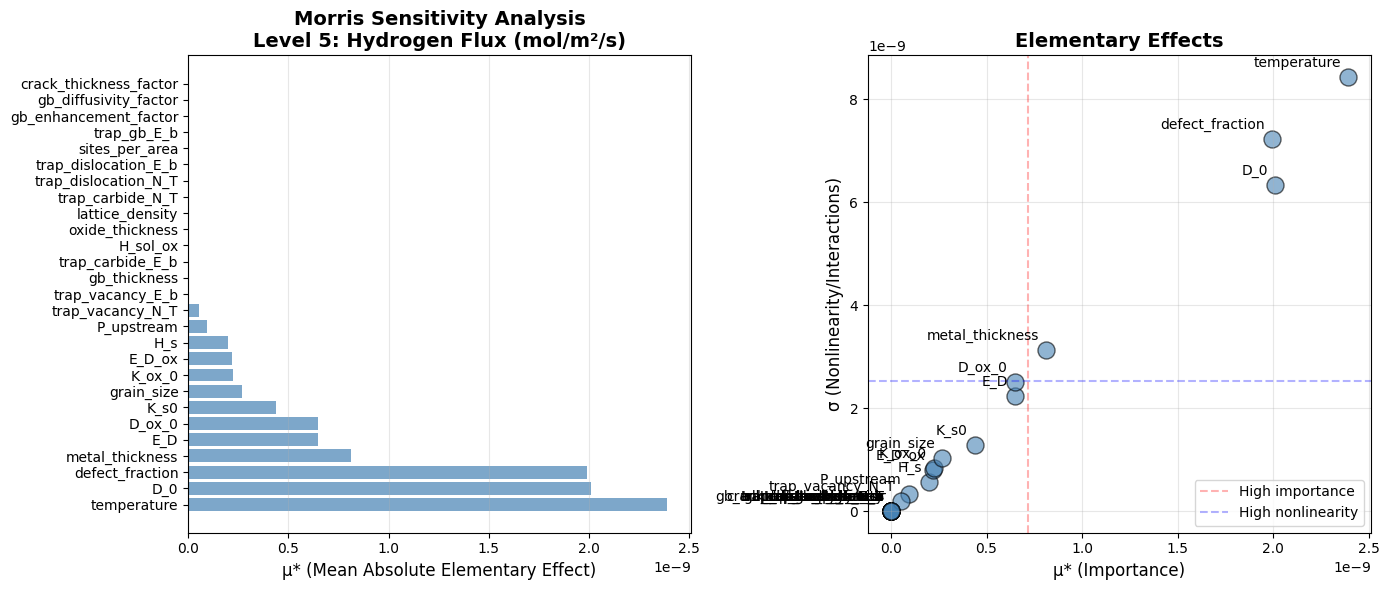


MORRIS SENSITIVITY RESULTS - Level 5: Hydrogen Flux (mol/m²/s)
             Parameter           μ*            σ      μ*_conf
           temperature 2.390102e-09 8.431819e-09 4.218496e-09
                   D_0 2.008225e-09 6.338903e-09 3.078672e-09
       defect_fraction 1.990808e-09 7.221881e-09 3.545242e-09
       metal_thickness 8.115253e-10 3.125364e-09 1.488605e-09
                   E_D 6.487646e-10 2.243729e-09 1.146757e-09
                D_ox_0 6.461805e-10 2.499520e-09 1.279905e-09
                  K_s0 4.386073e-10 1.283039e-09 6.499819e-10
            grain_size 2.689885e-10 1.028563e-09 5.417865e-10
                K_ox_0 2.256708e-10 8.330654e-10 3.977119e-10
                E_D_ox 2.188885e-10 8.016676e-10 4.287887e-10
                   H_s 2.008598e-10 5.604635e-10 2.825683e-10
            P_upstream 9.204096e-11 3.325902e-10 1.721692e-10
      trap_vacancy_N_T 5.502566e-11 2.005054e-10 1.032830e-10
      trap_vacancy_E_b 1.741431e-12 6.646463e-12 3.327536e-12
      

In [4]:
# =============================================================================
# MORRIS ANALYSIS: FLUX (Primary Output)
# =============================================================================
# With 30 parameters: 15 trajectories × 31 = 465 model evaluations

Si_flux, problem_flux, Y_flux = morris_sensitivity_level5(
    SUGGESTED_RANGES_LEVEL5,
    N_trajectories=15,
    num_levels=4,
    output_metric='flux'
)

plot_morris_results(Si_flux, problem_flux, 'Level 5: Hydrogen Flux (mol/m²/s)')


MORRIS SENSITIVITY ANALYSIS - LEVEL 5 (Complete Hierarchical Model)
Running 420 Morris samples...
Parameters (27): D_0, E_D, K_s0, H_s, metal_thickness, P_upstream, D_ox_0, E_D_ox, K_ox_0, H_sol_ox, oxide_thickness, defect_fraction, crack_thickness_factor, gb_diffusivity_factor, grain_size, gb_thickness, gb_enhancement_factor, lattice_density, sites_per_area, trap_dislocation_E_b, trap_dislocation_N_T, trap_gb_E_b, trap_vacancy_E_b, trap_vacancy_N_T, trap_carbide_E_b, trap_carbide_N_T, temperature
Output metric: PRF

  Completed 10/420 samples
  Completed 20/420 samples
  Completed 30/420 samples


/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:1951: UserWarning: GB traps already in trap_list, not adding automatically
  warnings.warn(msg)
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.01×) and trapping (0.96×) nearly cancel. Small parameter changes could significantly affect results.
  warnings.warn(msg)
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.01×) and trapping (0.90×) nearly cancel. Small parameter changes could significantly affect results.
  warnings.warn(msg)
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.00×) and trapping (0.90×) nearly cancel. Small parameter changes could significantly affect results.
  warnings.warn(msg)

  Completed 40/420 samples
  Completed 50/420 samples
  Completed 60/420 samples
  Completed 70/420 samples
  Completed 80/420 samples
  Completed 90/420 samples
  Completed 100/420 samples
  Completed 110/420 samples
  Completed 120/420 samples
  Completed 130/420 samples
  Completed 140/420 samples
  Completed 150/420 samples
  Completed 160/420 samples
  Completed 170/420 samples
  Completed 180/420 samples
  Completed 190/420 samples
  Completed 200/420 samples
  Completed 210/420 samples


/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.01×) and trapping (1.00×) nearly cancel. Small parameter changes could significantly affect results.
  warnings.warn(msg)
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.01×) and trapping (0.99×) nearly cancel. Small parameter changes could significantly affect results.
  warnings.warn(msg)
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:1232: UserWarning: Reduction factor 1.83e-03 < 0.01. Diffusion essentially stopped - model may be inappropriate.
  warnings.warn(f"Reduction factor {reduction_factor:.2e} < 0.01. "
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:1232: UserWarning: Reduction factor 6.12e-04 < 0.01. Diffusion essentiall

  Completed 220/420 samples
  Completed 230/420 samples
  Completed 240/420 samples
  Completed 250/420 samples
  Completed 260/420 samples
  Completed 270/420 samples


/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.02×) and trapping (0.94×) nearly cancel. Small parameter changes could significantly affect results.
  warnings.warn(msg)
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.00×) and trapping (0.89×) nearly cancel. Small parameter changes could significantly affect results.
  warnings.warn(msg)
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:1197: UserWarning: Trap 'carbides' has occupancy θ = 0.95 > 0.9. Approaching saturation - Oriani model may be inaccurate.
  warnings.warn(warning_msg)
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:1197: UserWarning: Trap 'carbides' has occupancy θ = 0.91 > 0.9. Approaching saturation - Oriani model 

  Completed 280/420 samples
  Completed 290/420 samples


/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.17×) and trapping (1.00×) nearly cancel. Small parameter changes could significantly affect results.
  warnings.warn(msg)


  Completed 300/420 samples
  Completed 310/420 samples
  Completed 320/420 samples
  Completed 330/420 samples
  Completed 340/420 samples
  Completed 350/420 samples
  Completed 360/420 samples


/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.04×) and trapping (0.78×) nearly cancel. Small parameter changes could significantly affect results.
  warnings.warn(msg)
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.02×) and trapping (0.78×) nearly cancel. Small parameter changes could significantly affect results.
  warnings.warn(msg)
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.02×) and trapping (0.96×) nearly cancel. Small parameter changes could significantly affect results.
  warnings.warn(msg)
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.03×) and trapping (0.99×) nearly cancel. Small parameter c

  Completed 370/420 samples
  Completed 380/420 samples
  Completed 390/420 samples
  Completed 400/420 samples
  Completed 410/420 samples
  Completed 420/420 samples

✓ Morris analysis complete
  Output range: [6.15e-11, 1.00e+04]
  Output span: 162672596004206.1× variation

  Top 10 most influential parameters:
    1. defect_fraction: μ* = 8.00e+03
    2. temperature: μ* = 3.05e+03
    3. trap_carbide_E_b: μ* = 8.82e+02
    4. P_upstream: μ* = 6.92e+02
    5. D_ox_0: μ* = 5.68e+02
    6. E_D_ox: μ* = 5.60e+02
    7. E_D: μ* = 2.90e+02
    8. H_sol_ox: μ* = 1.85e+02
    9. metal_thickness: μ* = 1.75e+02
    10. D_0: μ* = 6.67e+01


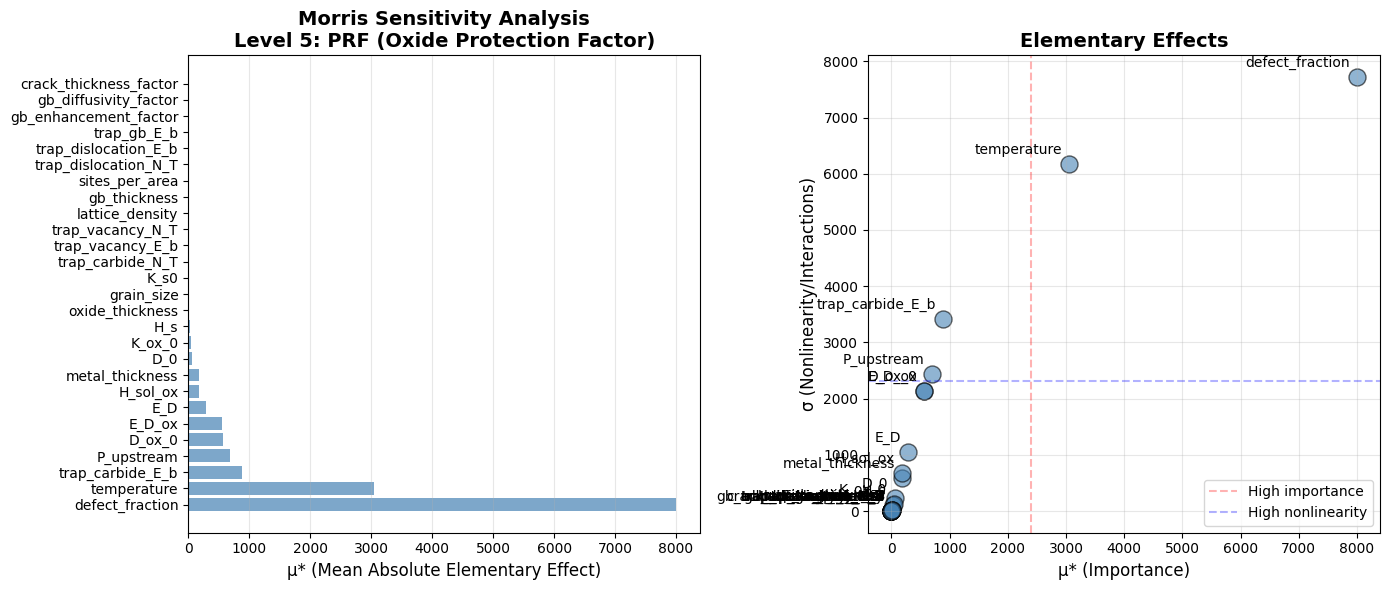


MORRIS SENSITIVITY RESULTS - Level 5: PRF (Oxide Protection Factor)
             Parameter           μ*            σ      μ*_conf
       defect_fraction 7.995048e+03 7.720583e+03 3.895410e+03
           temperature 3.053654e+03 6.179481e+03 3.269164e+03
      trap_carbide_E_b 8.820860e+02 3.416146e+03 1.830555e+03
            P_upstream 6.918162e+02 2.432729e+03 9.700388e+02
                D_ox_0 5.678693e+02 2.143951e+03 1.152526e+03
                E_D_ox 5.599096e+02 2.136135e+03 1.067417e+03
                   E_D 2.903645e+02 1.056426e+03 6.165365e+02
              H_sol_ox 1.848697e+02 6.852622e+02 3.545522e+02
       metal_thickness 1.750755e+02 5.824965e+02 2.742608e+02
                   D_0 6.667380e+01 2.360829e+02 1.014563e+02
                K_ox_0 4.478309e+01 1.275427e+02 6.955841e+01
                   H_s 2.809113e+01 1.086910e+02 5.529216e+01
       oxide_thickness 8.033743e+00 1.134978e+01 5.712822e+00
            grain_size 6.715967e+00 2.322699e+01 1.144141e+01
 

In [5]:
# =============================================================================
# MORRIS ANALYSIS: PRF (Permeation Reduction Factor)
# =============================================================================

Si_PRF, problem_PRF, Y_PRF = morris_sensitivity_level5(
    SUGGESTED_RANGES_LEVEL5,
    N_trajectories=15,
    num_levels=4,
    output_metric='PRF'
)

plot_morris_results(Si_PRF, problem_PRF, 'Level 5: PRF (Oxide Protection Factor)')


MORRIS SENSITIVITY ANALYSIS - LEVEL 5 (Complete Hierarchical Model)
Running 420 Morris samples...
Parameters (27): D_0, E_D, K_s0, H_s, metal_thickness, P_upstream, D_ox_0, E_D_ox, K_ox_0, H_sol_ox, oxide_thickness, defect_fraction, crack_thickness_factor, gb_diffusivity_factor, grain_size, gb_thickness, gb_enhancement_factor, lattice_density, sites_per_area, trap_dislocation_E_b, trap_dislocation_N_T, trap_gb_E_b, trap_vacancy_E_b, trap_vacancy_N_T, trap_carbide_E_b, trap_carbide_N_T, temperature
Output metric: D_eff

  Completed 10/420 samples
  Completed 20/420 samples
  Completed 30/420 samples
  Completed 40/420 samples
  Completed 50/420 samples
  Completed 60/420 samples
  Completed 70/420 samples


/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:1951: UserWarning: GB traps already in trap_list, not adding automatically
  warnings.warn(msg)
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.00×) and trapping (0.99×) nearly cancel. Small parameter changes could significantly affect results.
  warnings.warn(msg)
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.00×) and trapping (0.96×) nearly cancel. Small parameter changes could significantly affect results.
  warnings.warn(msg)
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.00×) and trapping (0.95×) nearly cancel. Small parameter changes could significantly affect results.
  warnings.warn(msg)

  Completed 80/420 samples
  Completed 90/420 samples
  Completed 100/420 samples
  Completed 110/420 samples
  Completed 120/420 samples
  Completed 130/420 samples
  Completed 140/420 samples
  Completed 150/420 samples
  Completed 160/420 samples
  Completed 170/420 samples
  Completed 180/420 samples
  Completed 190/420 samples
  Completed 200/420 samples
  Completed 210/420 samples
  Completed 220/420 samples
  Completed 230/420 samples
  Completed 240/420 samples
  Completed 250/420 samples
  Completed 260/420 samples
  Completed 270/420 samples
  Completed 280/420 samples
  Completed 290/420 samples
  Completed 300/420 samples
  Completed 310/420 samples
  Completed 320/420 samples
  Completed 330/420 samples
  Completed 340/420 samples


/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:1232: UserWarning: Reduction factor 7.13e-04 < 0.01. Diffusion essentially stopped - model may be inappropriate.
  warnings.warn(f"Reduction factor {reduction_factor:.2e} < 0.01. "
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:1232: UserWarning: Reduction factor 7.03e-04 < 0.01. Diffusion essentially stopped - model may be inappropriate.
  warnings.warn(f"Reduction factor {reduction_factor:.2e} < 0.01. "
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:1232: UserWarning: Reduction factor 9.04e-04 < 0.01. Diffusion essentially stopped - model may be inappropriate.
  warnings.warn(f"Reduction factor {reduction_factor:.2e} < 0.01. "
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:1232: UserWarning: Reduction 

  Completed 350/420 samples
  Completed 360/420 samples
  Completed 370/420 samples
  Completed 380/420 samples
  Completed 390/420 samples
  Completed 400/420 samples
  Completed 410/420 samples
  Completed 420/420 samples

✓ Morris analysis complete
  Output range: [6.57e-14, 2.28e-07]
  Output span: 3470831.4× variation

  Top 10 most influential parameters:
    1. E_D: μ* = 6.20e-08
    2. D_0: μ* = 5.27e-08
    3. temperature: μ* = 5.19e-08
    4. grain_size: μ* = 2.22e-08
    5. gb_thickness: μ* = 3.91e-09
    6. trap_vacancy_E_b: μ* = 7.04e-10
    7. lattice_density: μ* = 4.51e-10
    8. trap_carbide_E_b: μ* = 4.22e-10
    9. trap_carbide_N_T: μ* = 3.50e-10
    10. trap_vacancy_N_T: μ* = 2.47e-10


/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.00×) and trapping (0.87×) nearly cancel. Small parameter changes could significantly affect results.
  warnings.warn(msg)


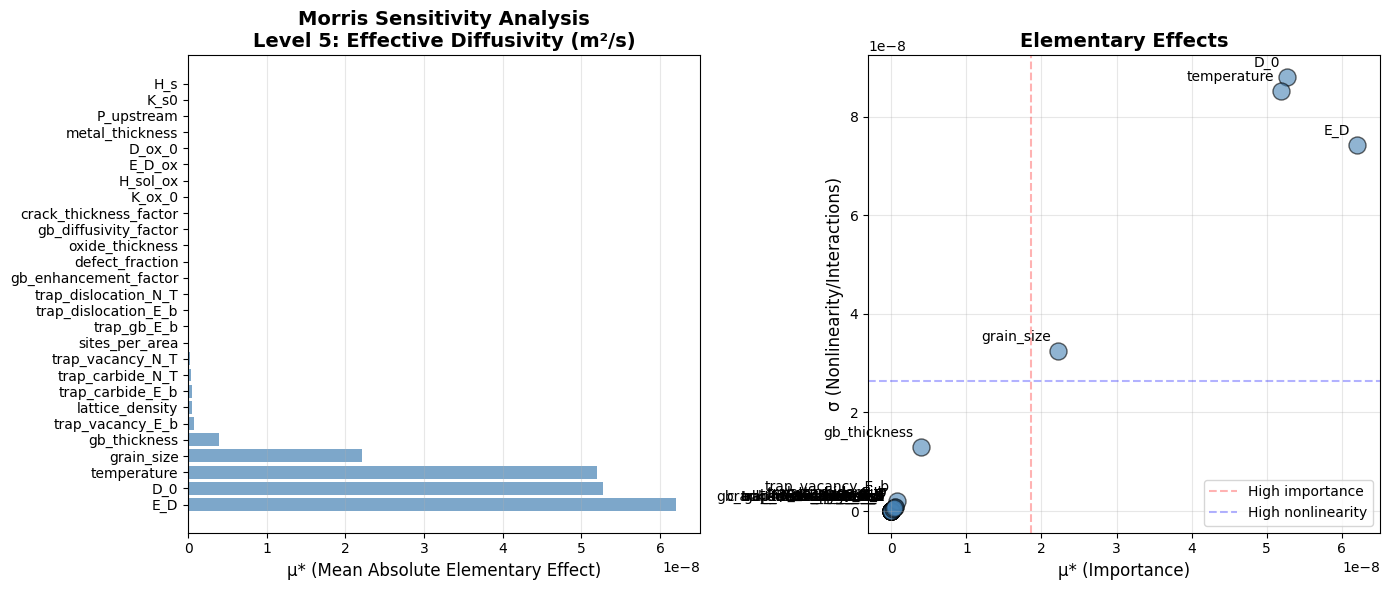


MORRIS SENSITIVITY RESULTS - Level 5: Effective Diffusivity (m²/s)
             Parameter           μ*            σ      μ*_conf
                   E_D 6.200709e-08 7.424163e-08 4.144349e-08
                   D_0 5.274801e-08 8.805479e-08 3.833617e-08
           temperature 5.194581e-08 8.519862e-08 4.019357e-08
            grain_size 2.215452e-08 3.238434e-08 1.538279e-08
          gb_thickness 3.914126e-09 1.305593e-08 5.849684e-09
      trap_vacancy_E_b 7.040044e-10 1.953412e-09 8.808207e-10
       lattice_density 4.509168e-10 8.318370e-10 3.959718e-10
      trap_carbide_E_b 4.218464e-10 7.808047e-10 4.120263e-10
      trap_carbide_N_T 3.504719e-10 6.884654e-10 2.901779e-10
      trap_vacancy_N_T 2.469646e-10 3.905267e-10 1.980855e-10
        sites_per_area 2.254923e-18 6.445873e-18 3.489163e-18
           trap_gb_E_b 6.887577e-19 1.559084e-18 7.083796e-19
  trap_dislocation_E_b 5.949752e-19 7.979237e-19 3.535715e-19
  trap_dislocation_N_T 5.015943e-19 1.410778e-18 6.792155e-19
 g

In [6]:
# =============================================================================
# MORRIS ANALYSIS: D_eff (Effective Diffusivity)
# =============================================================================

Si_Deff, problem_Deff, Y_Deff = morris_sensitivity_level5(
    SUGGESTED_RANGES_LEVEL5,
    N_trajectories=15,
    num_levels=4,
    output_metric='D_eff'
)

plot_morris_results(Si_Deff, problem_Deff, 'Level 5: Effective Diffusivity (m²/s)')

### Parameter Importance Ranking

Since different outputs (flux, PRF, D_eff) may be sensitive to different parameters, we normalize and average the Morris μ* values across all outputs. This gives us a **unified ranking** of parameter importance.

**Why normalize?** Each output has different units and scales. Normalizing to [0,1] allows fair comparison.

**Why average?** A parameter that strongly affects multiple outputs is more "globally important" than one affecting only a single output.

The top 10 parameters from this ranking will be used for detailed **Sobol analysis** (which is computationally expensive, so we limit to key parameters).

In [7]:
# =============================================================================
# PARAMETER IMPORTANCE RANKING (Combined Across Outputs)
# =============================================================================
import pandas as pd

# Collect results
param_names = problem_flux['names']

df_ranking = pd.DataFrame({
    'Parameter': param_names,
    'μ*_flux': Si_flux['mu_star'],
    'μ*_PRF': Si_PRF['mu_star'],
    'μ*_Deff': Si_Deff['mu_star'],
})

# Normalize each column to [0, 1] for fair comparison
for col in ['μ*_flux', 'μ*_PRF', 'μ*_Deff']:
    max_val = df_ranking[col].max()
    if max_val > 0:
        df_ranking[f'{col}_norm'] = df_ranking[col] / max_val
    else:
        df_ranking[f'{col}_norm'] = 0

# Average normalized importance
df_ranking['Avg_Importance'] = df_ranking[['μ*_flux_norm', 'μ*_PRF_norm', 'μ*_Deff_norm']].mean(axis=1)
df_ranking = df_ranking.sort_values('Avg_Importance', ascending=False)

print("="*80)
print("PARAMETER IMPORTANCE RANKING (Morris μ* - Normalized)")
print("="*80)
print(df_ranking[['Parameter', 'μ*_flux', 'μ*_PRF', 'μ*_Deff', 'Avg_Importance']].to_string(index=False))
print("="*80)

# Top 10 for focused Sobol analysis
top_10 = df_ranking.head(10)['Parameter'].tolist()
print(f"\n→ Top 10 parameters for focused Sobol analysis:")
for i, p in enumerate(top_10, 1):
    importance = df_ranking[df_ranking['Parameter'] == p]['Avg_Importance'].values[0]
    print(f"   {i:2d}. {p:<25s} (importance: {importance:.3f})")

PARAMETER IMPORTANCE RANKING (Morris μ* - Normalized)
             Parameter      μ*_flux       μ*_PRF      μ*_Deff  Avg_Importance
           temperature 2.390102e-09 3.053654e+03 5.194581e-08    7.398943e-01
       defect_fraction 1.990808e-09 7.995048e+03 0.000000e+00    6.109794e-01
                   D_0 2.008225e-09 6.667380e+01 5.274801e-08    5.664140e-01
                   E_D 6.487646e-10 2.903645e+02 6.200709e-08    4.359187e-01
            grain_size 2.689885e-10 6.715967e+00 2.215452e-08    1.568909e-01
       metal_thickness 8.115253e-10 1.750755e+02 0.000000e+00    1.204779e-01
                D_ox_0 6.461805e-10 5.678693e+02 0.000000e+00    1.137948e-01
                  K_s0 4.386073e-10 4.516917e+00 0.000000e+00    6.135827e-02
                E_D_ox 2.188885e-10 5.599096e+02 0.000000e+00    5.387110e-02
            P_upstream 9.204096e-11 6.918162e+02 0.000000e+00    4.167993e-02
      trap_carbide_E_b 1.296212e-12 8.820860e+02 4.218464e-10    3.922485e-02
          

### Visual Comparison Across Outputs
This bar chart shows how each parameter's importance varies across the three outputs:
- **Flux**: Total hydrogen permeation rate
- **PRF**: How much the oxide reduces permeation (protection efficiency)
- **D_eff**: Effective diffusivity in the metal substrate

Parameters with **tall bars across all three colors** are universally important.
Parameters with **only one tall bar** affect only that specific output (e.g., oxide parameters may dominate PRF but not D_eff).

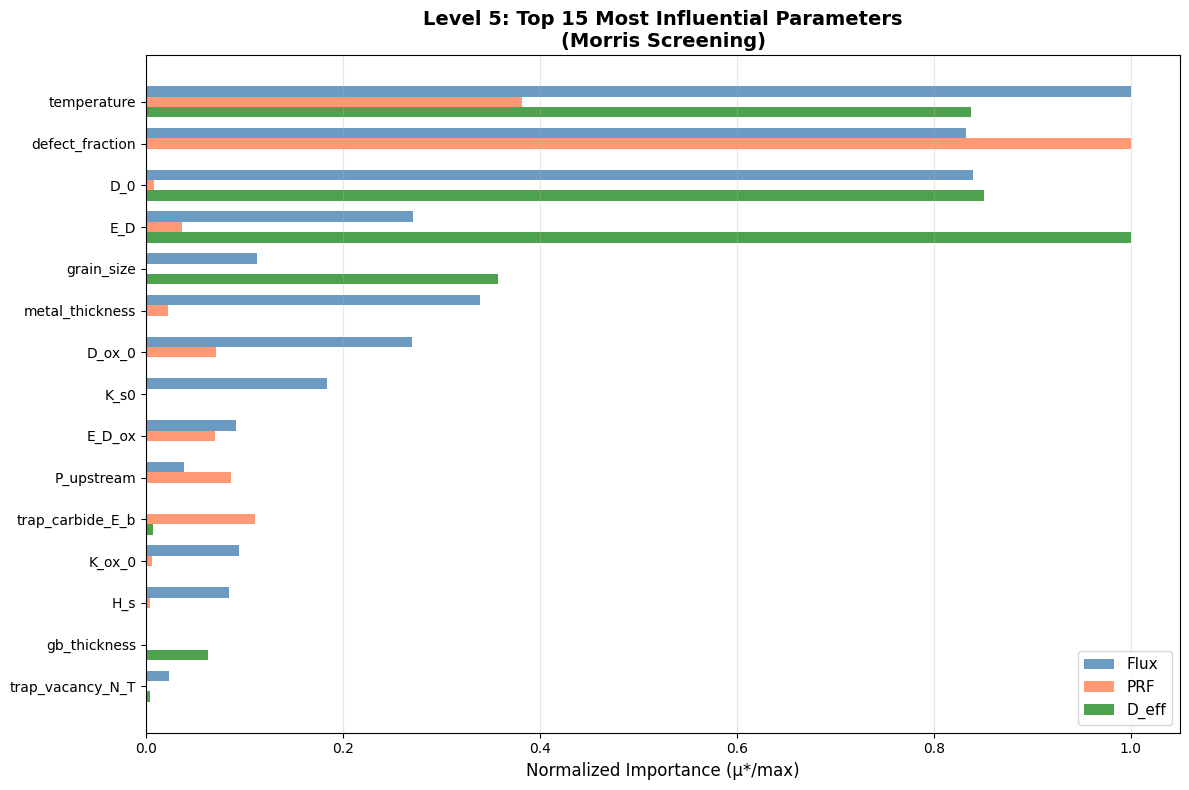

In [8]:
# =============================================================================
# VISUALIZATION: Top 15 Parameters Across All Outputs
# =============================================================================
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(12, 8))

top_15 = df_ranking.head(15)
x = np.arange(len(top_15))
width = 0.25

ax.barh(x - width, top_15['μ*_flux_norm'], width, label='Flux', color='steelblue', alpha=0.8)
ax.barh(x, top_15['μ*_PRF_norm'], width, label='PRF', color='coral', alpha=0.8)
ax.barh(x + width, top_15['μ*_Deff_norm'], width, label='D_eff', color='forestgreen', alpha=0.8)

ax.set_yticks(x)
ax.set_yticklabels(top_15['Parameter'])
ax.invert_yaxis()
ax.set_xlabel('Normalized Importance (μ*/max)', fontsize=12)
ax.set_title('Level 5: Top 15 Most Influential Parameters\n(Morris Screening)', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=11)
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

In [13]:
# =============================================================================
# MORRIS ANALYSIS: ALL VALID OUTPUT METRICS
# =============================================================================
# Run Morris screening for each output metric and store results

morris_results = {}

for output_metric in VALID_OUTPUT_METRICS_L5:
    print(f"\n{'#'*70}")
    print(f"# Running Morris for: {output_metric}")
    print(f"{'#'*70}")
    
    Si, problem, Y = morris_sensitivity_level5(
        SUGGESTED_RANGES_LEVEL5,
        N_trajectories=15,
        num_levels=4,
        output_metric=output_metric
    )
    
    morris_results[output_metric] = {
        'Si': Si,
        'problem': problem,
        'Y': Y
    }
    
print("\n" + "="*70)
print("✓ Morris analysis complete for all output metrics!")
print("="*70)


######################################################################
# Running Morris for: flux
######################################################################

MORRIS SENSITIVITY ANALYSIS - LEVEL 5 (Complete Hierarchical Model)
Running 420 Morris samples...
Parameters (27): D_0, E_D, K_s0, H_s, metal_thickness, P_upstream, D_ox_0, E_D_ox, K_ox_0, H_sol_ox, oxide_thickness, defect_fraction, crack_thickness_factor, gb_diffusivity_factor, grain_size, gb_thickness, gb_enhancement_factor, lattice_density, sites_per_area, trap_dislocation_E_b, trap_dislocation_N_T, trap_gb_E_b, trap_vacancy_E_b, trap_vacancy_N_T, trap_carbide_E_b, trap_carbide_N_T, temperature
Output metric: flux

  Completed 10/420 samples
  Completed 20/420 samples
  Completed 30/420 samples
  Completed 40/420 samples
  Completed 50/420 samples
  Completed 60/420 samples


/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:1951: UserWarning: GB traps already in trap_list, not adding automatically
  warnings.warn(msg)
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.00×) and trapping (0.86×) nearly cancel. Small parameter changes could significantly affect results.
  warnings.warn(msg)
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.00×) and trapping (0.88×) nearly cancel. Small parameter changes could significantly affect results.
  warnings.warn(msg)
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.00×) and trapping (0.99×) nearly cancel. Small parameter changes could significantly affect results.
  warnings.warn(msg)

  Completed 70/420 samples
  Completed 80/420 samples
  Completed 90/420 samples
  Completed 100/420 samples
  Completed 110/420 samples
  Completed 120/420 samples
  Completed 130/420 samples
  Completed 140/420 samples
  Completed 150/420 samples
  Completed 160/420 samples
  Completed 170/420 samples
  Completed 180/420 samples
  Completed 190/420 samples
  Completed 200/420 samples
  Completed 210/420 samples
  Completed 220/420 samples
  Completed 230/420 samples
  Completed 240/420 samples
  Completed 250/420 samples
  Completed 260/420 samples
  Completed 270/420 samples
  Completed 280/420 samples
  Completed 290/420 samples
  Completed 300/420 samples
  Completed 310/420 samples
  Completed 320/420 samples
  Completed 330/420 samples
  Completed 340/420 samples
  Completed 350/420 samples
  Completed 360/420 samples


/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.01×) and trapping (0.80×) nearly cancel. Small parameter changes could significantly affect results.
  warnings.warn(msg)
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.01×) and trapping (1.00×) nearly cancel. Small parameter changes could significantly affect results.
  warnings.warn(msg)
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.00×) and trapping (0.96×) nearly cancel. Small parameter changes could significantly affect results.
  warnings.warn(msg)
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.01×) and trapping (0.95×) nearly cancel. Small parameter c

  Completed 370/420 samples
  Completed 380/420 samples
  Completed 390/420 samples
  Completed 400/420 samples
  Completed 410/420 samples
  Completed 420/420 samples

✓ Morris analysis complete
  Output range: [2.35e-21, 2.42e-08]
  Output span: 10328982561196.0× variation

  Top 10 most influential parameters:
    1. temperature: μ* = 3.54e-09
    2. P_upstream: μ* = 1.57e-09
    3. K_s0: μ* = 1.43e-09
    4. defect_fraction: μ* = 1.25e-09
    5. E_D: μ* = 9.09e-10
    6. grain_size: μ* = 7.40e-10
    7. H_s: μ* = 6.16e-10
    8. oxide_thickness: μ* = 4.24e-10
    9. H_sol_ox: μ* = 4.07e-10
    10. E_D_ox: μ* = 2.67e-10

######################################################################
# Running Morris for: PRF
######################################################################

MORRIS SENSITIVITY ANALYSIS - LEVEL 5 (Complete Hierarchical Model)
Running 420 Morris samples...
Parameters (27): D_0, E_D, K_s0, H_s, metal_thickness, P_upstream, D_ox_0, E_D_ox, K_ox_0, H_sol_ox, 

/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.02×) and trapping (0.87×) nearly cancel. Small parameter changes could significantly affect results.
  warnings.warn(msg)
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:1232: UserWarning: Reduction factor 1.07e-03 < 0.01. Diffusion essentially stopped - model may be inappropriate.
  warnings.warn(f"Reduction factor {reduction_factor:.2e} < 0.01. "
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.17×) and trapping (0.99×) nearly cancel. Small parameter changes could significantly affect results.
  warnings.warn(msg)


  Completed 50/420 samples
  Completed 60/420 samples
  Completed 70/420 samples
  Completed 80/420 samples
  Completed 90/420 samples
  Completed 100/420 samples
  Completed 110/420 samples
  Completed 120/420 samples
  Completed 130/420 samples
  Completed 140/420 samples
  Completed 150/420 samples
  Completed 160/420 samples
  Completed 170/420 samples
  Completed 180/420 samples
  Completed 190/420 samples
  Completed 200/420 samples
  Completed 210/420 samples
  Completed 220/420 samples
  Completed 230/420 samples
  Completed 240/420 samples
  Completed 250/420 samples
  Completed 260/420 samples
  Completed 270/420 samples
  Completed 280/420 samples
  Completed 290/420 samples
  Completed 300/420 samples
  Completed 310/420 samples
  Completed 320/420 samples
  Completed 330/420 samples


/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.02×) and trapping (0.92×) nearly cancel. Small parameter changes could significantly affect results.
  warnings.warn(msg)
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.17×) and trapping (1.00×) nearly cancel. Small parameter changes could significantly affect results.
  warnings.warn(msg)
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.01×) and trapping (0.98×) nearly cancel. Small parameter changes could significantly affect results.
  warnings.warn(msg)
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (8.98×) and trapping (0.10×) nearly cancel. Small parameter c

  Completed 340/420 samples
  Completed 350/420 samples
  Completed 360/420 samples
  Completed 370/420 samples
  Completed 380/420 samples
  Completed 390/420 samples
  Completed 400/420 samples
  Completed 410/420 samples
  Completed 420/420 samples


/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:1232: UserWarning: Reduction factor 6.11e-04 < 0.01. Diffusion essentially stopped - model may be inappropriate.
  warnings.warn(f"Reduction factor {reduction_factor:.2e} < 0.01. "
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.01×) and trapping (0.97×) nearly cancel. Small parameter changes could significantly affect results.
  warnings.warn(msg)
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.00×) and trapping (0.97×) nearly cancel. Small parameter changes could significantly affect results.
  warnings.warn(msg)
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.01×) and trapping (0.82×) nearly can


✓ Morris analysis complete
  Output range: [1.00e+00, 1.00e+04]
  Output span: 9999.5× variation

  Top 10 most influential parameters:
    1. defect_fraction: μ* = 3.01e+03
    2. E_D_ox: μ* = 1.75e+03
    3. H_sol_ox: μ* = 1.68e+03
    4. temperature: μ* = 8.48e+02
    5. D_0: μ* = 8.29e+02
    6. E_D: μ* = 4.08e+02
    7. D_ox_0: μ* = 6.78e+01
    8. metal_thickness: μ* = 3.83e+01
    9. trap_carbide_E_b: μ* = 2.86e+01
    10. oxide_thickness: μ* = 2.18e+01

######################################################################
# Running Morris for: D_eff
######################################################################

MORRIS SENSITIVITY ANALYSIS - LEVEL 5 (Complete Hierarchical Model)
Running 420 Morris samples...
Parameters (27): D_0, E_D, K_s0, H_s, metal_thickness, P_upstream, D_ox_0, E_D_ox, K_ox_0, H_sol_ox, oxide_thickness, defect_fraction, crack_thickness_factor, gb_diffusivity_factor, grain_size, gb_thickness, gb_enhancement_factor, lattice_density, sites_per_area, 

/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.02×) and trapping (0.85×) nearly cancel. Small parameter changes could significantly affect results.
  warnings.warn(msg)
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.02×) and trapping (0.83×) nearly cancel. Small parameter changes could significantly affect results.
  warnings.warn(msg)
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.04×) and trapping (0.83×) nearly cancel. Small parameter changes could significantly affect results.
  warnings.warn(msg)
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.04×) and trapping (0.95×) nearly cancel. Small parameter c

  Completed 120/420 samples
  Completed 130/420 samples
  Completed 140/420 samples
  Completed 150/420 samples
  Completed 160/420 samples


/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.04×) and trapping (0.96×) nearly cancel. Small parameter changes could significantly affect results.
  warnings.warn(msg)
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.02×) and trapping (0.96×) nearly cancel. Small parameter changes could significantly affect results.
  warnings.warn(msg)
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.02×) and trapping (0.95×) nearly cancel. Small parameter changes could significantly affect results.
  warnings.warn(msg)


  Completed 170/420 samples
  Completed 180/420 samples
  Completed 190/420 samples
  Completed 200/420 samples
  Completed 210/420 samples
  Completed 220/420 samples
  Completed 230/420 samples


/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.01×) and trapping (0.87×) nearly cancel. Small parameter changes could significantly affect results.
  warnings.warn(msg)
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.01×) and trapping (0.84×) nearly cancel. Small parameter changes could significantly affect results.
  warnings.warn(msg)


  Completed 240/420 samples
  Completed 250/420 samples
  Completed 260/420 samples
  Completed 270/420 samples
  Completed 280/420 samples
  Completed 290/420 samples
  Completed 300/420 samples
  Completed 310/420 samples
  Completed 320/420 samples
  Completed 330/420 samples
  Completed 340/420 samples
  Completed 350/420 samples
  Completed 360/420 samples


/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:1232: UserWarning: Reduction factor 9.13e-04 < 0.01. Diffusion essentially stopped - model may be inappropriate.
  warnings.warn(f"Reduction factor {reduction_factor:.2e} < 0.01. "
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:1232: UserWarning: Reduction factor 1.22e-03 < 0.01. Diffusion essentially stopped - model may be inappropriate.
  warnings.warn(f"Reduction factor {reduction_factor:.2e} < 0.01. "


  Completed 370/420 samples
  Completed 380/420 samples
  Completed 390/420 samples
  Completed 400/420 samples
  Completed 410/420 samples
  Completed 420/420 samples

✓ Morris analysis complete
  Output range: [1.99e-15, 2.73e-07]
  Output span: 136878628.5× variation

  Top 10 most influential parameters:
    1. temperature: μ* = 6.51e-08
    2. D_0: μ* = 3.68e-08
    3. E_D: μ* = 2.80e-08
    4. grain_size: μ* = 3.45e-09
    5. gb_thickness: μ* = 2.84e-09
    6. trap_vacancy_E_b: μ* = 2.18e-09
    7. trap_carbide_E_b: μ* = 6.25e-10
    8. trap_vacancy_N_T: μ* = 5.37e-10
    9. lattice_density: μ* = 2.96e-10
    10. trap_carbide_N_T: μ* = 2.52e-10

######################################################################
# Running Morris for: D_modification
######################################################################

MORRIS SENSITIVITY ANALYSIS - LEVEL 5 (Complete Hierarchical Model)
Running 420 Morris samples...
Parameters (27): D_0, E_D, K_s0, H_s, metal_thickness, P_upstr

/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.04×) and trapping (0.92×) nearly cancel. Small parameter changes could significantly affect results.
  warnings.warn(msg)
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.02×) and trapping (0.84×) nearly cancel. Small parameter changes could significantly affect results.
  warnings.warn(msg)


  Completed 100/420 samples
  Completed 110/420 samples
  Completed 120/420 samples
  Completed 130/420 samples
  Completed 140/420 samples
  Completed 150/420 samples
  Completed 160/420 samples
  Completed 170/420 samples
  Completed 180/420 samples
  Completed 190/420 samples
  Completed 200/420 samples
  Completed 210/420 samples


/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.02×) and trapping (0.90×) nearly cancel. Small parameter changes could significantly affect results.
  warnings.warn(msg)
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.02×) and trapping (0.97×) nearly cancel. Small parameter changes could significantly affect results.
  warnings.warn(msg)
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.02×) and trapping (0.99×) nearly cancel. Small parameter changes could significantly affect results.
  warnings.warn(msg)
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.17×) and trapping (0.97×) nearly cancel. Small parameter c

  Completed 220/420 samples
  Completed 230/420 samples
  Completed 240/420 samples
  Completed 250/420 samples
  Completed 260/420 samples


/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.02×) and trapping (0.81×) nearly cancel. Small parameter changes could significantly affect results.
  warnings.warn(msg)
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.04×) and trapping (0.97×) nearly cancel. Small parameter changes could significantly affect results.
  warnings.warn(msg)
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.04×) and trapping (0.98×) nearly cancel. Small parameter changes could significantly affect results.
  warnings.warn(msg)
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.04×) and trapping (1.00×) nearly cancel. Small parameter c

  Completed 270/420 samples
  Completed 280/420 samples
  Completed 290/420 samples
  Completed 300/420 samples
  Completed 310/420 samples
  Completed 320/420 samples
  Completed 330/420 samples
  Completed 340/420 samples
  Completed 350/420 samples
  Completed 360/420 samples
  Completed 370/420 samples
  Completed 380/420 samples
  Completed 390/420 samples
  Completed 400/420 samples
  Completed 410/420 samples
  Completed 420/420 samples

✓ Morris analysis complete
  Output range: [1.40e-03, 1.58e+01]
  Output span: 11314.1× variation

  Top 10 most influential parameters:
    1. temperature: μ* = 3.85e+00
    2. grain_size: μ* = 3.39e+00
    3. trap_carbide_N_T: μ* = 1.27e+00
    4. trap_carbide_E_b: μ* = 1.24e+00
    5. gb_thickness: μ* = 9.30e-01
    6. trap_vacancy_N_T: μ* = 4.32e-01
    7. trap_vacancy_E_b: μ* = 4.22e-01
    8. lattice_density: μ* = 9.08e-02
    9. sites_per_area: μ* = 4.21e-09
    10. trap_gb_E_b: μ* = 3.75e-09

#############################################

/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:1232: UserWarning: Reduction factor 2.14e-03 < 0.01. Diffusion essentially stopped - model may be inappropriate.
  warnings.warn(f"Reduction factor {reduction_factor:.2e} < 0.01. "
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:1232: UserWarning: Reduction factor 2.12e-03 < 0.01. Diffusion essentially stopped - model may be inappropriate.
  warnings.warn(f"Reduction factor {reduction_factor:.2e} < 0.01. "
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:1232: UserWarning: Reduction factor 9.15e-04 < 0.01. Diffusion essentially stopped - model may be inappropriate.
  warnings.warn(f"Reduction factor {reduction_factor:.2e} < 0.01. "


  Completed 360/420 samples
  Completed 370/420 samples
  Completed 380/420 samples
  Completed 390/420 samples
  Completed 400/420 samples


/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.01×) and trapping (0.93×) nearly cancel. Small parameter changes could significantly affect results.
  warnings.warn(msg)
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.03×) and trapping (0.82×) nearly cancel. Small parameter changes could significantly affect results.
  warnings.warn(msg)


  Completed 410/420 samples
  Completed 420/420 samples

✓ Morris analysis complete
  Output range: [2.54e-25, 3.49e-12]
  Output span: 13738030316927.9× variation

  Top 10 most influential parameters:
    1. grain_size: μ* = 6.00e-13
    2. E_D: μ* = 4.76e-13
    3. temperature: μ* = 2.80e-13
    4. K_s0: μ* = 1.47e-13
    5. H_s: μ* = 8.08e-14
    6. D_0: μ* = 8.04e-14
    7. gb_thickness: μ* = 9.08e-15
    8. lattice_density: μ* = 2.26e-15
    9. trap_vacancy_N_T: μ* = 1.92e-15
    10. trap_carbide_E_b: μ* = 1.38e-15

######################################################################
# Running Morris for: P_interface
######################################################################

MORRIS SENSITIVITY ANALYSIS - LEVEL 5 (Complete Hierarchical Model)
Running 420 Morris samples...
Parameters (27): D_0, E_D, K_s0, H_s, metal_thickness, P_upstream, D_ox_0, E_D_ox, K_ox_0, H_sol_ox, oxide_thickness, defect_fraction, crack_thickness_factor, gb_diffusivity_factor, grain_size, gb_

/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.01×) and trapping (0.88×) nearly cancel. Small parameter changes could significantly affect results.
  warnings.warn(msg)


  Completed 340/420 samples
  Completed 350/420 samples
  Completed 360/420 samples
  Completed 370/420 samples
  Completed 380/420 samples
  Completed 390/420 samples
  Completed 400/420 samples
  Completed 410/420 samples
  Completed 420/420 samples

✓ Morris analysis complete
  Output range: [1.00e-07, 1.00e+06]
  Output span: 9997843490421.9× variation

  Top 10 most influential parameters:
    1. K_ox_0: μ* = 2.27e+05
    2. temperature: μ* = 1.04e+05
    3. P_upstream: μ* = 1.02e+05
    4. K_s0: μ* = 8.83e+04
    5. H_s: μ* = 8.48e+04
    6. D_0: μ* = 6.39e+04
    7. oxide_thickness: μ* = 5.43e+04
    8. D_ox_0: μ* = 4.26e+04
    9. metal_thickness: μ* = 3.68e+04
    10. H_sol_ox: μ* = 2.84e+04

######################################################################
# Running Morris for: flux_intact
######################################################################

MORRIS SENSITIVITY ANALYSIS - LEVEL 5 (Complete Hierarchical Model)
Running 420 Morris samples...
Parameters (27

/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.03×) and trapping (0.98×) nearly cancel. Small parameter changes could significantly affect results.
  warnings.warn(msg)
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.03×) and trapping (1.00×) nearly cancel. Small parameter changes could significantly affect results.
  warnings.warn(msg)
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.03×) and trapping (0.97×) nearly cancel. Small parameter changes could significantly affect results.
  warnings.warn(msg)
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.03×) and trapping (0.96×) nearly cancel. Small parameter c

  Completed 10/420 samples
  Completed 20/420 samples
  Completed 30/420 samples
  Completed 40/420 samples
  Completed 50/420 samples
  Completed 60/420 samples
  Completed 70/420 samples
  Completed 80/420 samples
  Completed 90/420 samples
  Completed 100/420 samples
  Completed 110/420 samples
  Completed 120/420 samples
  Completed 130/420 samples
  Completed 140/420 samples
  Completed 150/420 samples
  Completed 160/420 samples
  Completed 170/420 samples
  Completed 180/420 samples


/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.01×) and trapping (0.94×) nearly cancel. Small parameter changes could significantly affect results.
  warnings.warn(msg)
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:1232: UserWarning: Reduction factor 2.13e-03 < 0.01. Diffusion essentially stopped - model may be inappropriate.
  warnings.warn(f"Reduction factor {reduction_factor:.2e} < 0.01. "
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:1232: UserWarning: Reduction factor 7.14e-04 < 0.01. Diffusion essentially stopped - model may be inappropriate.
  warnings.warn(f"Reduction factor {reduction_factor:.2e} < 0.01. "
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.04×) and trapp

  Completed 190/420 samples
  Completed 200/420 samples
  Completed 210/420 samples
  Completed 220/420 samples


/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.02×) and trapping (0.88×) nearly cancel. Small parameter changes could significantly affect results.
  warnings.warn(msg)
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:1232: UserWarning: Reduction factor 9.10e-04 < 0.01. Diffusion essentially stopped - model may be inappropriate.
  warnings.warn(f"Reduction factor {reduction_factor:.2e} < 0.01. "


  Completed 230/420 samples
  Completed 240/420 samples
  Completed 250/420 samples
  Completed 260/420 samples
  Completed 270/420 samples
  Completed 280/420 samples
  Completed 290/420 samples
  Completed 300/420 samples
  Completed 310/420 samples
  Completed 320/420 samples
  Completed 330/420 samples
  Completed 340/420 samples
  Completed 350/420 samples
  Completed 360/420 samples
  Completed 370/420 samples
  Completed 380/420 samples
  Completed 390/420 samples
  Completed 400/420 samples
  Completed 410/420 samples
  Completed 420/420 samples

✓ Morris analysis complete
  Output range: [1.01e-39, 8.40e-08]
  Output span: 83189066027916163339191266050048.0× variation

  Top 10 most influential parameters:
    1. oxide_thickness: μ* = 8.43e-09
    2. D_0: μ* = 4.96e-09
    3. H_s: μ* = 2.18e-09
    4. H_sol_ox: μ* = 1.98e-09
    5. grain_size: μ* = 1.56e-09
    6. temperature: μ* = 1.15e-09
    7. P_upstream: μ* = 1.04e-09
    8. E_D: μ* = 1.01e-09
    9. metal_thickness: μ* =

/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.02×) and trapping (0.93×) nearly cancel. Small parameter changes could significantly affect results.
  warnings.warn(msg)


  Completed 50/420 samples
  Completed 60/420 samples
  Completed 70/420 samples
  Completed 80/420 samples
  Completed 90/420 samples
  Completed 100/420 samples
  Completed 110/420 samples
  Completed 120/420 samples
  Completed 130/420 samples
  Completed 140/420 samples
  Completed 150/420 samples
  Completed 160/420 samples
  Completed 170/420 samples
  Completed 180/420 samples
  Completed 190/420 samples


/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (5.49×) and trapping (0.21×) nearly cancel. Small parameter changes could significantly affect results.
  warnings.warn(msg)
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.03×) and trapping (0.86×) nearly cancel. Small parameter changes could significantly affect results.
  warnings.warn(msg)
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.03×) and trapping (0.80×) nearly cancel. Small parameter changes could significantly affect results.
  warnings.warn(msg)
/Users/akinyemi.az/Desktop/HE_papers/yoshi/Analytical_model/MHI_permeation/calculations/defective_metal.py:2006: UserWarning: GB enhancement (1.03×) and trapping (0.81×) nearly cancel. Small parameter c

  Completed 200/420 samples
  Completed 210/420 samples
  Completed 220/420 samples
  Completed 230/420 samples
  Completed 240/420 samples
  Completed 250/420 samples
  Completed 260/420 samples
  Completed 270/420 samples
  Completed 280/420 samples
  Completed 290/420 samples
  Completed 300/420 samples
  Completed 310/420 samples
  Completed 320/420 samples
  Completed 330/420 samples
  Completed 340/420 samples
  Completed 350/420 samples
  Completed 360/420 samples
  Completed 370/420 samples
  Completed 380/420 samples
  Completed 390/420 samples
  Completed 400/420 samples
  Completed 410/420 samples
  Completed 420/420 samples

✓ Morris analysis complete
  Output range: [1.44e-21, 2.29e-08]
  Output span: 15909554432596.6× variation

  Top 10 most influential parameters:
    1. grain_size: μ* = 1.81e-09
    2. temperature: μ* = 1.61e-09
    3. E_D: μ* = 4.89e-10
    4. H_s: μ* = 3.93e-10
    5. defect_fraction: μ* = 2.98e-10
    6. trap_vacancy_N_T: μ* = 1.44e-10
    7. P_upst


OUTPUT: flux


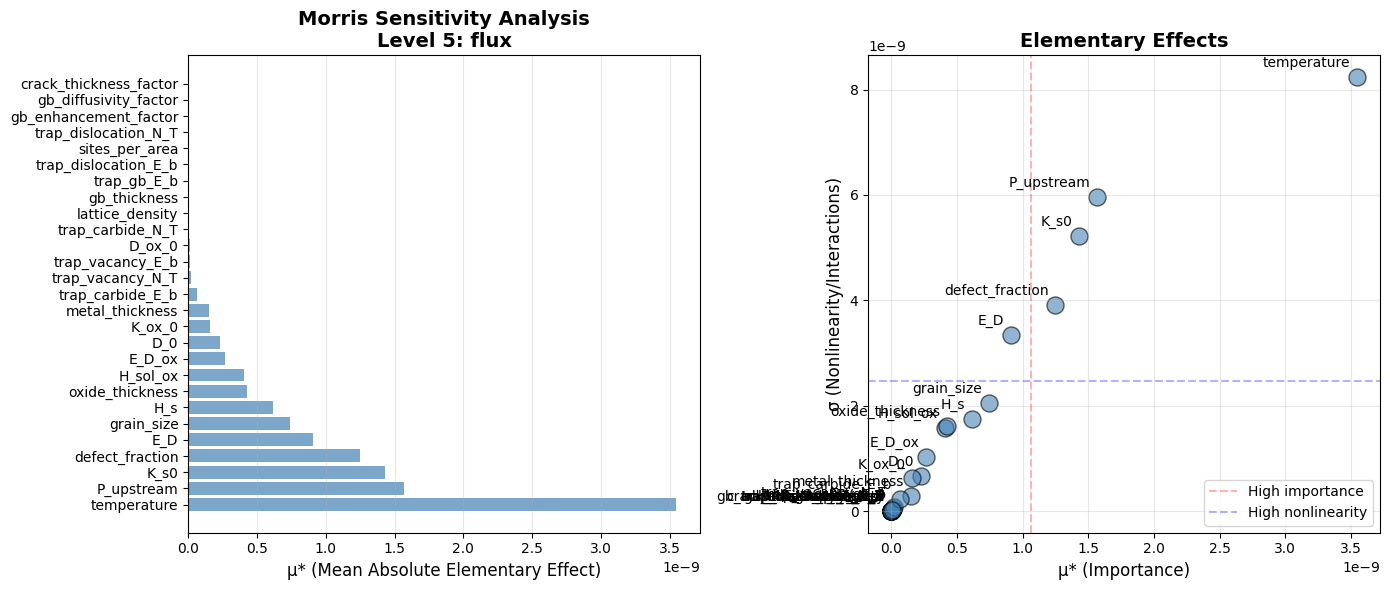


MORRIS SENSITIVITY RESULTS - Level 5: flux
             Parameter           μ*            σ      μ*_conf
           temperature 3.544206e-09 8.238530e-09 4.090949e-09
            P_upstream 1.565601e-09 5.968109e-09 2.991403e-09
                  K_s0 1.429828e-09 5.227571e-09 2.446099e-09
       defect_fraction 1.248826e-09 3.907331e-09 1.776532e-09
                   E_D 9.087202e-10 3.333556e-09 1.527732e-09
            grain_size 7.404396e-10 2.058370e-09 1.028370e-09
                   H_s 6.155128e-10 1.745131e-09 8.224232e-10
       oxide_thickness 4.244795e-10 1.611527e-09 7.903757e-10
              H_sol_ox 4.072293e-10 1.571964e-09 6.349087e-10
                E_D_ox 2.671051e-10 1.032576e-09 4.613974e-10
                   D_0 2.290820e-10 6.615807e-10 3.270607e-10
                K_ox_0 1.595494e-10 6.176078e-10 2.946630e-10
       metal_thickness 1.503667e-10 2.938548e-10 1.487254e-10
      trap_carbide_E_b 6.175726e-11 2.268973e-10 1.221036e-10
      trap_vacancy_N_T 2.1

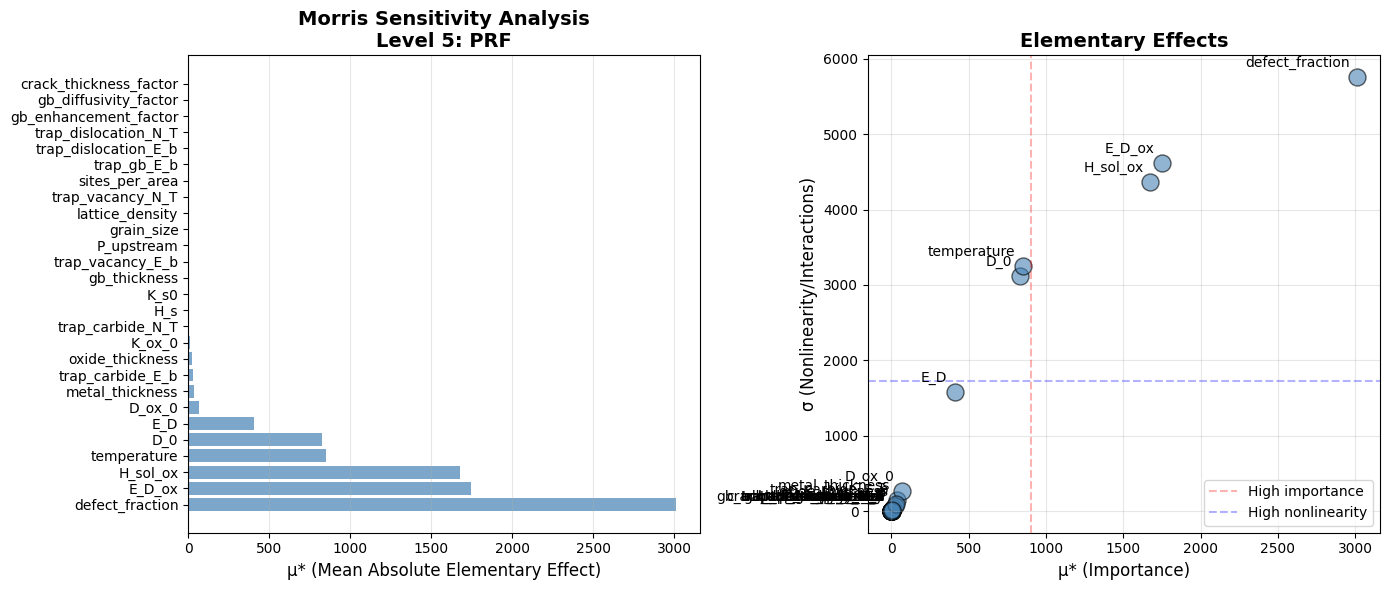


MORRIS SENSITIVITY RESULTS - Level 5: PRF
             Parameter           μ*            σ      μ*_conf
       defect_fraction 3.010485e+03 5.759729e+03 2.669681e+03
                E_D_ox 1.748809e+03 4.619369e+03 1.828079e+03
              H_sol_ox 1.675628e+03 4.365553e+03 2.308229e+03
           temperature 8.482076e+02 3.255724e+03 1.470979e+03
                   D_0 8.288341e+02 3.121971e+03 1.590574e+03
                   E_D 4.082833e+02 1.580870e+03 7.252552e+02
                D_ox_0 6.776586e+01 2.609441e+02 1.360130e+02
       metal_thickness 3.826116e+01 1.445013e+02 6.218732e+01
      trap_carbide_E_b 2.855080e+01 9.013795e+01 4.111005e+01
       oxide_thickness 2.179026e+01 6.825624e+01 3.094474e+01
                K_ox_0 1.318260e+01 3.850312e+01 1.657579e+01
      trap_carbide_N_T 2.877601e+00 1.113137e+01 4.913070e+00
                   H_s 1.852318e+00 4.128725e+00 1.806640e+00
                  K_s0 1.705656e+00 3.678880e+00 1.873881e+00
          gb_thickness 1.28

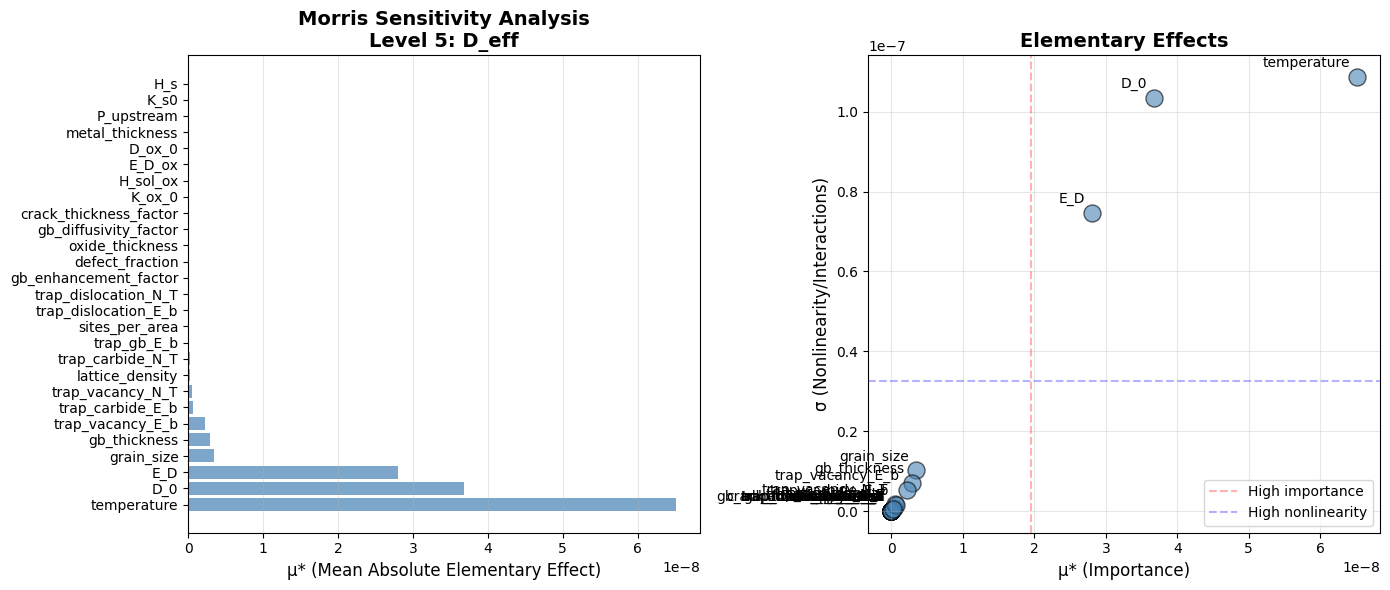


MORRIS SENSITIVITY RESULTS - Level 5: D_eff
             Parameter           μ*            σ      μ*_conf
           temperature 6.510018e-08 1.087062e-07 5.460906e-08
                   D_0 3.678770e-08 1.035674e-07 5.151548e-08
                   E_D 2.801588e-08 7.473592e-08 3.704961e-08
            grain_size 3.447212e-09 1.016001e-08 4.945527e-09
          gb_thickness 2.844634e-09 6.942168e-09 3.594402e-09
      trap_vacancy_E_b 2.175159e-09 5.341034e-09 2.471971e-09
      trap_carbide_E_b 6.246840e-10 1.521531e-09 7.219981e-10
      trap_vacancy_N_T 5.373583e-10 1.736548e-09 9.248886e-10
       lattice_density 2.964910e-10 7.615445e-10 3.831609e-10
      trap_carbide_N_T 2.515575e-10 5.961923e-10 2.476587e-10
           trap_gb_E_b 3.730885e-16 1.416538e-15 6.258691e-16
        sites_per_area 2.704916e-17 1.005176e-16 4.489538e-17
  trap_dislocation_E_b 1.073520e-18 3.302938e-18 1.706476e-18
  trap_dislocation_N_T 4.634665e-19 1.672727e-18 7.997177e-19
 gb_enhancement_factor 0.

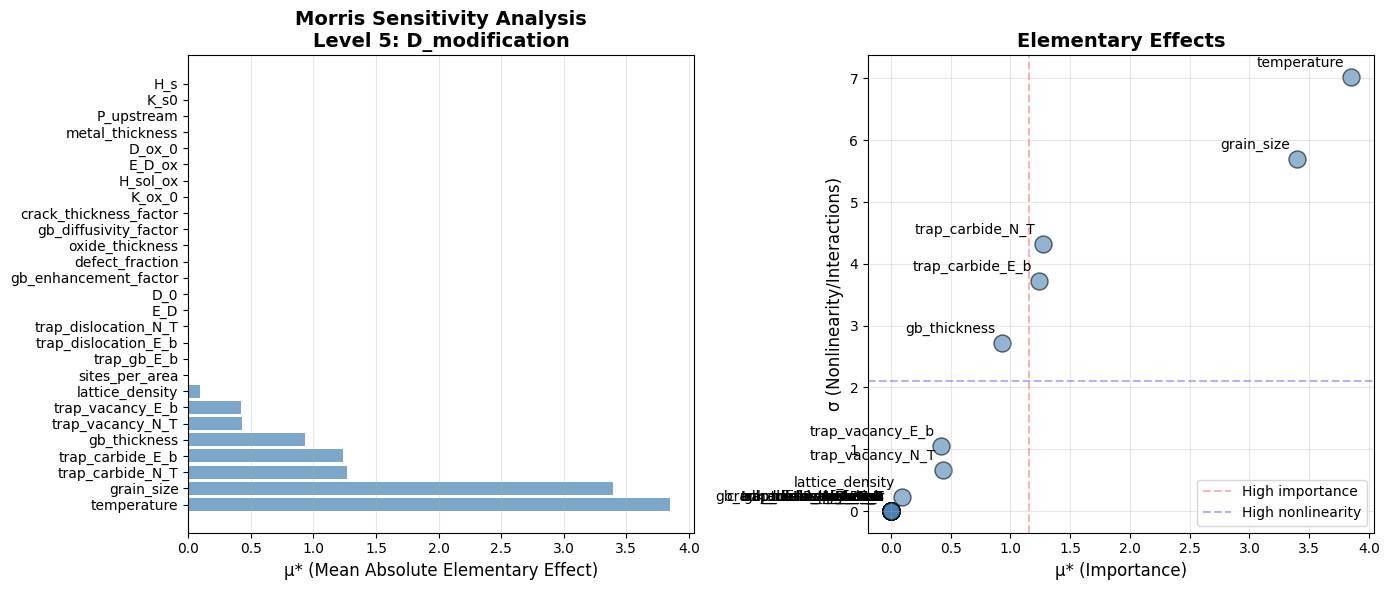


MORRIS SENSITIVITY RESULTS - Level 5: D_modification
             Parameter           μ*            σ      μ*_conf
           temperature 3.846996e+00 7.022474e+00 3.120302e+00
            grain_size 3.393867e+00 5.694008e+00 2.846823e+00
      trap_carbide_N_T 1.269943e+00 4.324868e+00 2.006527e+00
      trap_carbide_E_b 1.237539e+00 3.722847e+00 1.975354e+00
          gb_thickness 9.296401e-01 2.723080e+00 1.372537e+00
      trap_vacancy_N_T 4.322089e-01 6.594482e-01 2.713244e-01
      trap_vacancy_E_b 4.219734e-01 1.047082e+00 5.095552e-01
       lattice_density 9.084193e-02 2.322214e-01 1.240291e-01
        sites_per_area 4.208163e-09 9.901323e-09 4.342356e-09
           trap_gb_E_b 3.748240e-09 1.231504e-08 6.011359e-09
  trap_dislocation_E_b 2.329805e-10 4.498056e-10 2.152971e-10
  trap_dislocation_N_T 3.461704e-11 6.020246e-11 3.359881e-11
                   E_D 1.010303e-15 2.139037e-15 1.069991e-15
                   D_0 5.495604e-16 9.674037e-16 4.062728e-16
 gb_enhancement_

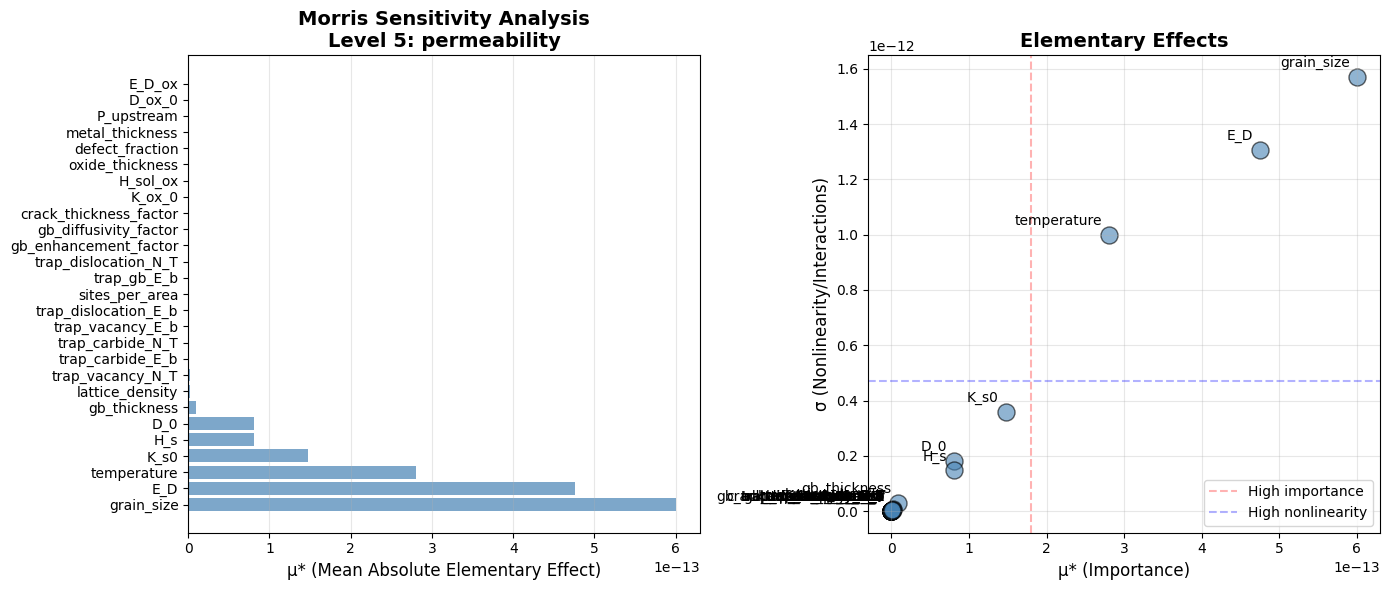


MORRIS SENSITIVITY RESULTS - Level 5: permeability
             Parameter           μ*            σ      μ*_conf
            grain_size 5.999750e-13 1.570825e-12 7.087079e-13
                   E_D 4.758167e-13 1.307238e-12 7.207579e-13
           temperature 2.803868e-13 1.000478e-12 5.049661e-13
                  K_s0 1.474191e-13 3.598845e-13 1.909543e-13
                   H_s 8.076341e-14 1.468137e-13 6.705027e-14
                   D_0 8.043648e-14 1.810700e-13 8.497134e-14
          gb_thickness 9.080261e-15 2.951844e-14 1.461146e-14
       lattice_density 2.257275e-15 8.566931e-15 4.170750e-15
      trap_vacancy_N_T 1.918767e-15 4.671716e-15 2.370965e-15
      trap_carbide_E_b 1.380474e-15 4.216943e-15 1.826278e-15
      trap_carbide_N_T 5.652179e-16 1.909407e-15 8.916942e-16
      trap_vacancy_E_b 5.049690e-16 1.362611e-15 7.031240e-16
  trap_dislocation_E_b 1.603134e-23 6.153650e-23 3.096318e-23
        sites_per_area 9.227579e-24 3.309848e-23 1.594551e-23
           trap_gb

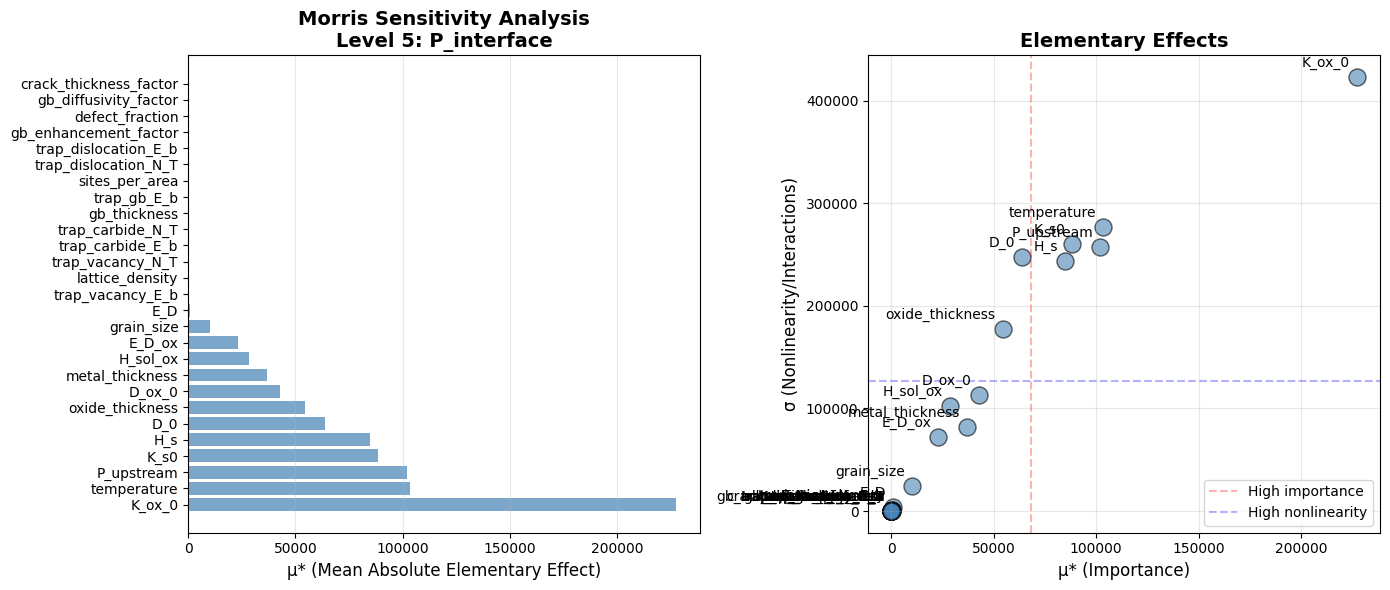


MORRIS SENSITIVITY RESULTS - Level 5: P_interface
             Parameter           μ*            σ      μ*_conf
                K_ox_0 2.272250e+05 4.228775e+05 2.385882e+05
           temperature 1.035450e+05 2.766929e+05 1.506074e+05
            P_upstream 1.017992e+05 2.569799e+05 1.354998e+05
                  K_s0 8.825245e+04 2.605736e+05 1.128355e+05
                   H_s 8.477242e+04 2.434242e+05 1.329353e+05
                   D_0 6.392677e+04 2.474937e+05 1.219400e+05
       oxide_thickness 5.434598e+04 1.777425e+05 8.395483e+04
                D_ox_0 4.260458e+04 1.131014e+05 5.064264e+04
       metal_thickness 3.678522e+04 8.231916e+04 4.035769e+04
              H_sol_ox 2.841085e+04 1.024598e+05 4.914034e+04
                E_D_ox 2.298944e+04 7.256730e+04 3.638202e+04
            grain_size 1.026172e+04 2.442520e+04 1.203869e+04
                   E_D 9.462912e+02 3.612770e+03 1.817651e+03
      trap_vacancy_E_b 2.863241e+02 1.046907e+03 5.443360e+02
       lattice_dens

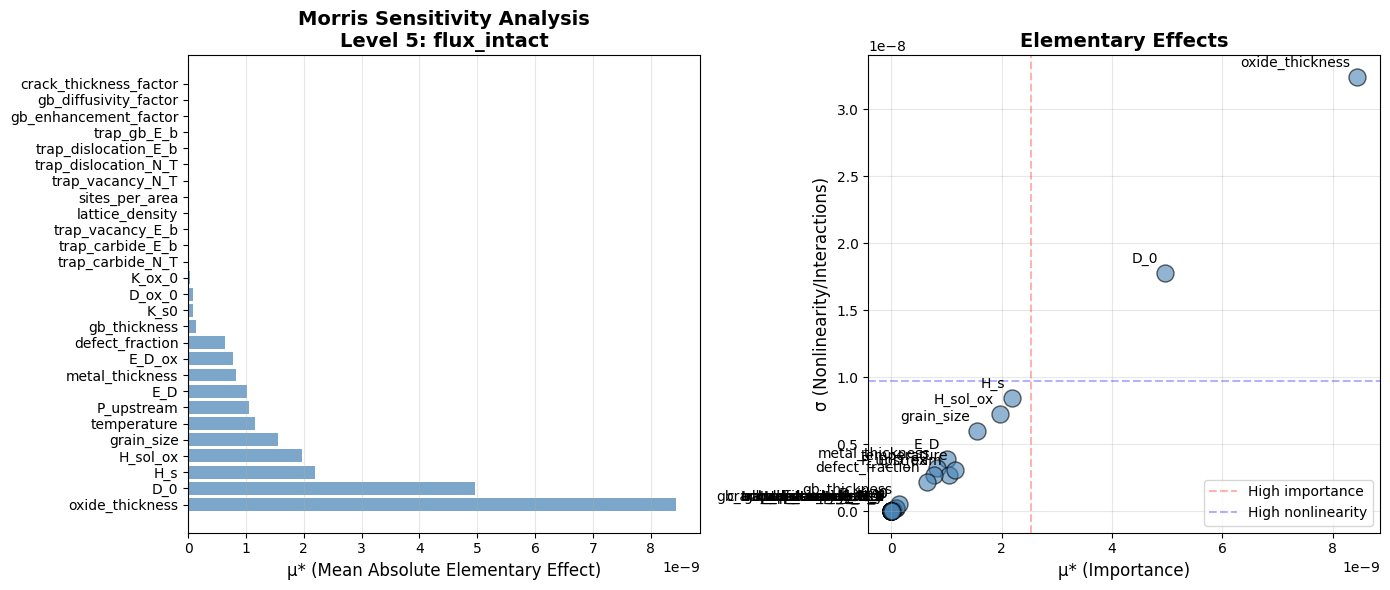


MORRIS SENSITIVITY RESULTS - Level 5: flux_intact
             Parameter           μ*            σ      μ*_conf
       oxide_thickness 8.434746e-09 3.239575e-08 1.734750e-08
                   D_0 4.960442e-09 1.775701e-08 8.649656e-09
                   H_s 2.184892e-09 8.419016e-09 3.695892e-09
              H_sol_ox 1.976221e-09 7.222359e-09 3.346888e-09
            grain_size 1.557201e-09 5.959261e-09 3.041142e-09
           temperature 1.153423e-09 3.047754e-09 1.388285e-09
            P_upstream 1.044604e-09 2.681350e-09 1.378987e-09
                   E_D 1.010627e-09 3.914139e-09 1.929712e-09
       metal_thickness 8.272935e-10 3.189842e-09 1.595985e-09
                E_D_ox 7.742903e-10 2.673919e-09 1.220214e-09
       defect_fraction 6.412372e-10 2.153995e-09 1.059454e-09
          gb_thickness 1.403726e-10 5.436560e-10 2.881005e-10
                  K_s0 7.900918e-11 2.319608e-10 1.021372e-10
                D_ox_0 7.765751e-11 2.016225e-10 9.184661e-11
                K_o

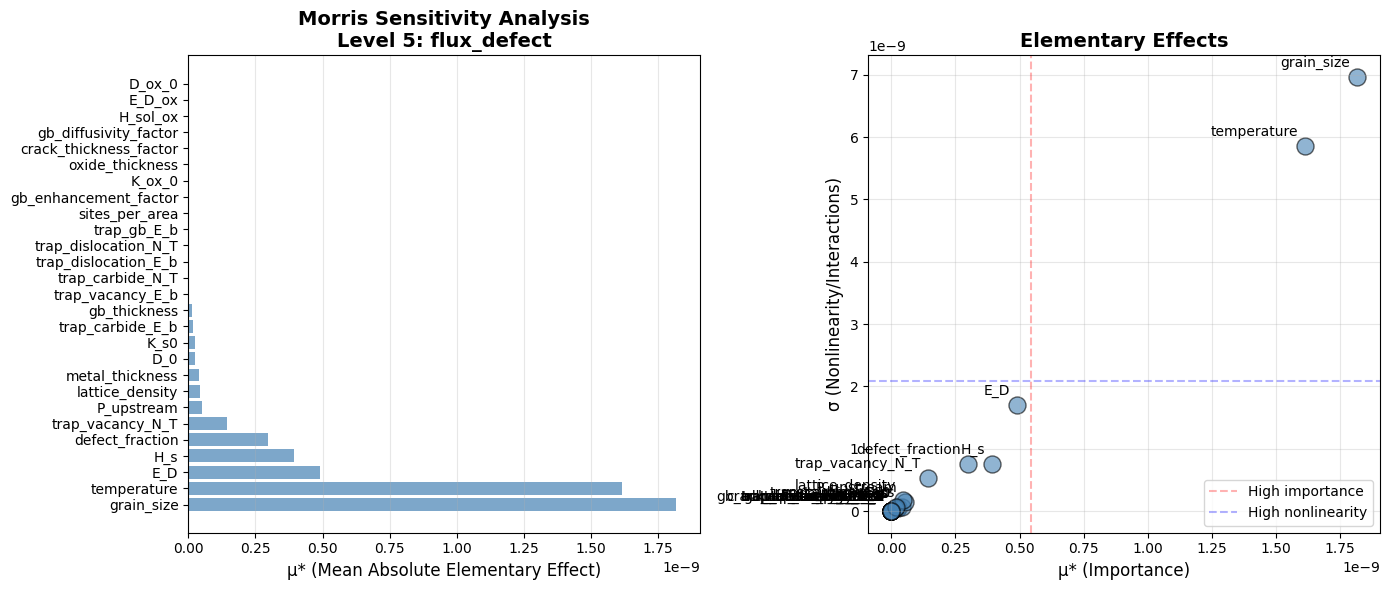


MORRIS SENSITIVITY RESULTS - Level 5: flux_defect
             Parameter           μ*            σ      μ*_conf
            grain_size 1.814893e-09 6.964026e-09 3.668468e-09
           temperature 1.614101e-09 5.862378e-09 3.077068e-09
                   E_D 4.891618e-10 1.705192e-09 7.607165e-10
                   H_s 3.927696e-10 7.580458e-10 3.846334e-10
       defect_fraction 2.982347e-10 7.474643e-10 3.671666e-10
      trap_vacancy_N_T 1.439307e-10 5.357003e-10 2.289778e-10
            P_upstream 5.125589e-11 1.380016e-10 6.844698e-11
       lattice_density 4.535992e-11 1.752219e-10 9.196439e-11
       metal_thickness 4.195694e-11 6.313216e-11 3.222715e-11
                   D_0 2.665298e-11 5.798428e-11 2.565748e-11
                  K_s0 2.533114e-11 5.334111e-11 2.669252e-11
      trap_carbide_E_b 1.811557e-11 6.905535e-11 3.774919e-11
          gb_thickness 1.556854e-11 5.256018e-11 2.724125e-11
      trap_vacancy_E_b 3.601111e-13 8.153801e-13 4.069308e-13
      trap_carbide_

In [14]:
# =============================================================================
# PLOT MORRIS RESULTS FOR ALL OUTPUTS
# =============================================================================

for output_metric in VALID_OUTPUT_METRICS_L5:
    print(f"\n{'='*70}")
    print(f"OUTPUT: {output_metric}")
    print(f"{'='*70}")
    
    Si = morris_results[output_metric]['Si']
    problem = morris_results[output_metric]['problem']
    
    plot_morris_results(Si, problem, f'Level 5: {output_metric}')

In [ ]:
# =============================================================================
# PARAMETER IMPORTANCE RANKING ACROSS ALL 8 OUTPUTS
# =============================================================================
import pandas as pd

param_names = morris_results['flux']['problem']['names']

# Build DataFrame with μ* for each output
df_all = pd.DataFrame({'Parameter': param_names})

for output_metric in VALID_OUTPUT_METRICS_L5:
    df_all[f'μ*_{output_metric}'] = morris_results[output_metric]['Si']['mu_star']

# Normalize each column
for output_metric in VALID_OUTPUT_METRICS_L5:
    col = f'μ*_{output_metric}'
    max_val = df_all[col].max()
    if max_val > 0:
        df_all[f'{col}_norm'] = df_all[col] / max_val
    else:
        df_all[f'{col}_norm'] = 0

# Average normalized importance across all outputs
norm_cols = [f'μ*_{m}_norm' for m in VALID_OUTPUT_METRICS_L5]
df_all['Avg_Importance'] = df_all[norm_cols].mean(axis=1)
df_all = df_all.sort_values('Avg_Importance', ascending=False)

# Display summary
print("="*100)
print("PARAMETER IMPORTANCE RANKING (Morris μ* - All 8 Outputs)")
print("="*100)
display_cols = ['Parameter'] + [f'μ*_{m}' for m in VALID_OUTPUT_METRICS_L5] + ['Avg_Importance']
print(df_all[display_cols].to_string(index=False))
print("="*100)

# Top 10 for Sobol
top_10 = df_all.head(10)['Parameter'].tolist()
print(f"\n→ Top 10 parameters for focused Sobol analysis:")
for i, p in enumerate(top_10, 1):
    importance = df_all[df_all['Parameter'] == p]['Avg_Importance'].values[0]
    print(f"   {i:2d}. {p:<25s} (avg importance: {importance:.3f})")

In [19]:
#morris_results

In [16]:
# =============================================================================
# PARAMETER IMPORTANCE RANKING ACROSS ALL 8 OUTPUTS
# =============================================================================
import pandas as pd

param_names = morris_results['flux']['problem']['names']

# Build DataFrame with μ* for each output
df_all = pd.DataFrame({'Parameter': param_names})

for output_metric in VALID_OUTPUT_METRICS_L5:
    df_all[f'μ*_{output_metric}'] = morris_results[output_metric]['Si']['mu_star']

# Normalize each column
for output_metric in VALID_OUTPUT_METRICS_L5:
    col = f'μ*_{output_metric}'
    max_val = df_all[col].max()
    if max_val > 0:
        df_all[f'{col}_norm'] = df_all[col] / max_val
    else:
        df_all[f'{col}_norm'] = 0

# Average normalized importance across all outputs
norm_cols = [f'μ*_{m}_norm' for m in VALID_OUTPUT_METRICS_L5]
df_all['Avg_Importance'] = df_all[norm_cols].mean(axis=1)
df_all = df_all.sort_values('Avg_Importance', ascending=False)

# Display summary
print("="*100)
print("PARAMETER IMPORTANCE RANKING (Morris μ* - All 8 Outputs)")
print("="*100)
display_cols = ['Parameter'] + [f'μ*_{m}' for m in VALID_OUTPUT_METRICS_L5] + ['Avg_Importance']
print(df_all[display_cols].to_string(index=False))
print("="*100)

# Top 10 for Sobol
top_10 = df_all.head(10)['Parameter'].tolist()
print(f"\n→ Top 10 parameters for focused Sobol analysis:")
for i, p in enumerate(top_10, 1):
    importance = df_all[df_all['Parameter'] == p]['Avg_Importance'].values[0]
    print(f"   {i:2d}. {p:<25s} (avg importance: {importance:.3f})")

PARAMETER IMPORTANCE RANKING (Morris μ* - All 8 Outputs)
             Parameter      μ*_flux       μ*_PRF     μ*_D_eff  μ*_D_modification  μ*_permeability  μ*_P_interface  μ*_flux_intact  μ*_flux_defect  Avg_Importance
           temperature 3.544206e-09 8.482076e+02 6.510018e-08       3.846996e+00     2.803868e-13    1.035450e+05    1.153423e-09    1.614101e-09    6.538608e-01
            grain_size 7.404396e-10 4.237992e-01 3.447212e-09       3.393867e+00     5.999750e-13    1.026172e+04    1.557201e-09    1.814893e-09    4.217499e-01
                   E_D 9.087202e-10 4.082833e+02 2.801588e-08       1.010303e-15     4.758167e-13    9.462912e+02    1.010627e-09    4.891618e-10    2.511170e-01
                   D_0 2.290820e-10 8.288341e+02 3.678770e-08       5.495604e-16     8.043648e-14    6.392677e+04    4.960442e-09    2.665298e-11    2.404038e-01
       defect_fraction 1.248826e-09 3.010485e+03 0.000000e+00       0.000000e+00     0.000000e+00    0.000000e+00    6.412372e-10    

### Sensitivity Heatmap

This heatmap shows which parameters affect which outputs:
- **Yellow/Light**: Low sensitivity (parameter has little effect)
- **Red/Dark**: High sensitivity (parameter strongly affects output)

**Interpretation:**
- A **row with all dark cells** = parameter affects everything (universally important)
- A **column with few dark cells** = that output is controlled by only a few parameters
- **Clusters of dark cells** reveal which parameter groups dominate specific outputs

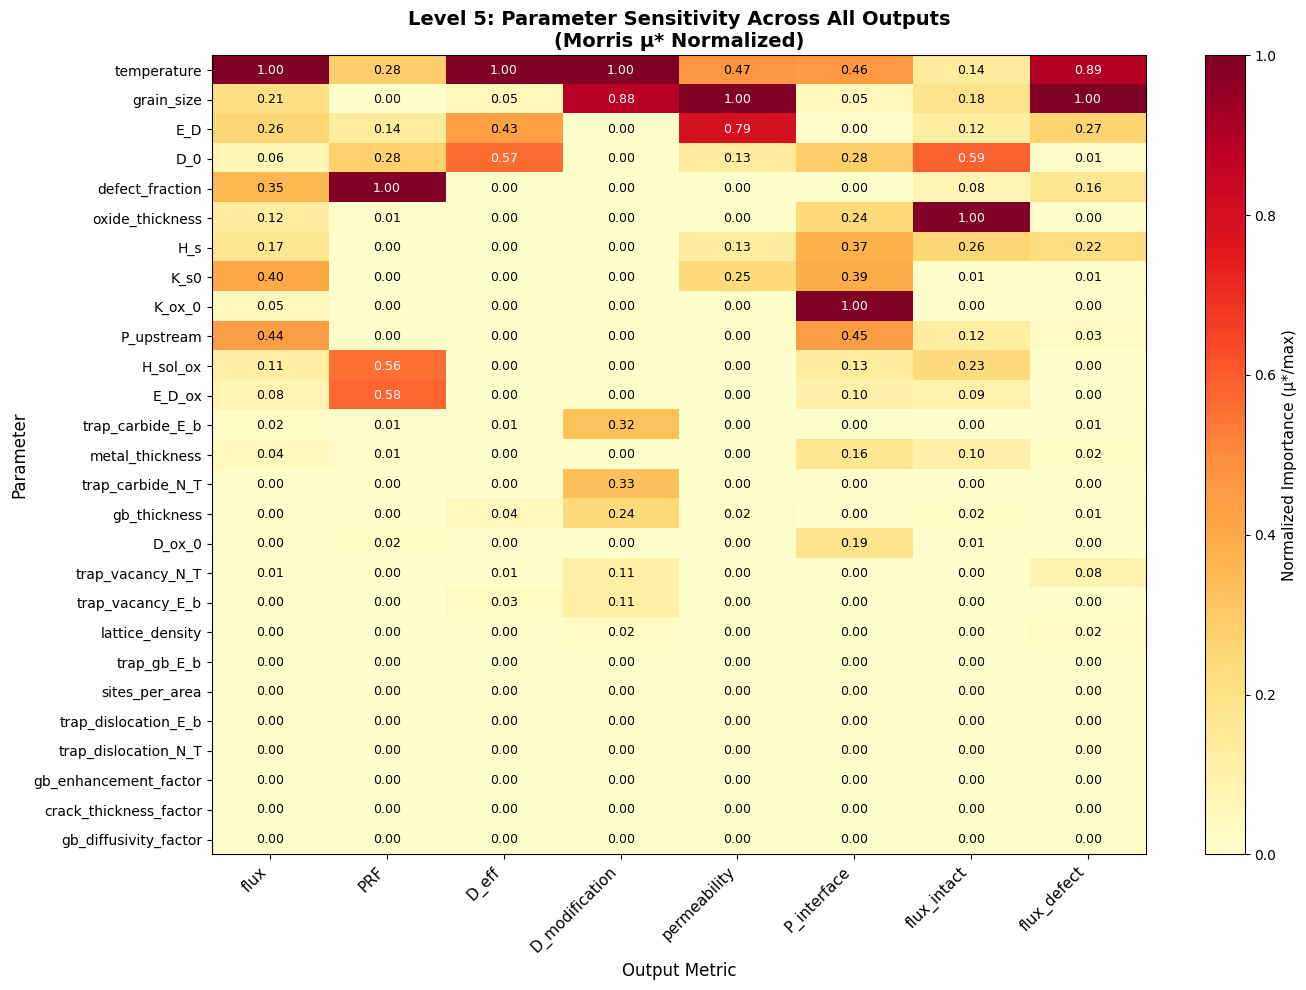

In [18]:
# =============================================================================
# HEATMAP: Parameter Importance Across All Outputs
# =============================================================================
import matplotlib.pyplot as plt
import numpy as np

# Get top 20 parameters for visualization
top_20 = df_all.head(27)

# Extract normalized values for heatmap
heatmap_data = top_20[[f'μ*_{m}_norm' for m in VALID_OUTPUT_METRICS_L5]].values
param_labels = top_20['Parameter'].tolist()
output_labels = VALID_OUTPUT_METRICS_L5

fig, ax = plt.subplots(figsize=(14, 10))

im = ax.imshow(heatmap_data, cmap='YlOrRd', aspect='auto')

# Labels
ax.set_xticks(np.arange(len(output_labels)))
ax.set_yticks(np.arange(len(param_labels)))
ax.set_xticklabels(output_labels, rotation=45, ha='right', fontsize=11)
ax.set_yticklabels(param_labels, fontsize=10)

# Colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Normalized Importance (μ*/max)', fontsize=11)

# Annotate cells with values
for i in range(len(param_labels)):
    for j in range(len(output_labels)):
        val = heatmap_data[i, j]
        color = 'white' if val > 0.5 else 'black'
        ax.text(j, i, f'{val:.2f}', ha='center', va='center', color=color, fontsize=9)

ax.set_title('Level 5: Parameter Sensitivity Across All Outputs\n(Morris μ* Normalized)', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Output Metric', fontsize=12)
ax.set_ylabel('Parameter', fontsize=12)

plt.tight_layout()
plt.show()

# Level 4: Defective Metal only 

In [ ]:
# """
# Complete Test Suite for Level 4: Defective Metal (Microstructure Effects)
# =========================================================================
# Covers:
# - Basic flux (should match Level 1 if no traps/GBs)
# - Trapping effects (trap_density, trap_energy)
# - Grain boundary effects (grain_boundary_fraction, gb_enhancement)
# - Mixed microstructure
# - Pressure, temperature, thickness dependence
# - Regime classification (lattice_limited, traps_defect_limited)
# """

In [ ]:
import numpy as np
import os
import json
from datetime import datetime
from calculations.permeation_calc import calculate_defective_metal_flux
import matplotlib.pyplot as plt
# Import microstructure parameters
from data.microstruture_parameters import PROCESSING_CONDITIONS, TRAP_PROPERTIES,LATTICE_PARAMETERS


In [ ]:
temperature= T_kelvin #800+273
P_upstream= P_upstream  # Pa
P_downstream= P_downstream  # Pa
D= D
K_s= K_s
thickness=thickness
microstructure = {
        # Smaller grain size (1 μm instead of ~50 μm) → much more GB area
        'grain_size': 1e-6,  # 1 μm - nanocrystalline/ultrafine grain
        'grain_shape': 'equiaxed',
        'gb_type': 'HAGB',  # High-angle grain boundaries
        #'gb_type': 'LAGB',
        
        # Higher trap densities and binding energies
        'trap_list': [
            {
                'name': 'dislocations',
                'density': 1e27,  # Heavy cold work (100x higher than annealed)
                'binding_energy': 45e3  # 45 kJ/mol
            },
            {
                'name': 'vacancies', 
                'density': 1e31,  # Higher vacancy concentration
                'binding_energy': 55e3  # 55 kJ/mol (stronger traps)
            },
            {
                'name': 'grain_boundaries',
                'binding_energy': 40.0e3,   # J/mol (20 kJ/mol) - reduced for testability
                'sites_per_area': 1e19,     # trap sites/m² of GB area
                'density': 3e+25,          # trap sites/m³ (from grain size and GB area)(This is atomatically calculated)
                'thickness': 0.5e-9,        # m (0.5 nm) - GB width
                'reference': 'Oudriss et al. (2012)',
                'notes': 'Acts as both trap and fast diffusion path. Binding energy varies with GB character.'
            },
            {
                'name': 'precipitates',
                'density': 1e30,  # Carbide/nitride precipitates
                'binding_energy': 60e3,  # 60 kJ/mol (deep traps)
                'interface_area': 100,  # m²/m³ (specific interface area)
                'reference': 'Lee & Lee (1986)',
                'notes': 'Strong irreversible trap at carbide/matrix interface'
            }
        ],
        'lattice_site_density': LATTICE_PARAMETERS['Incoloy800']['N_L'],
        'lattice_density': LATTICE_PARAMETERS['Incoloy800']['N_L'],
        
        'trap_density': 1e27 + 1e31 + 1e25 + 1e30,  # Total
        'E_binding': 40e3,  # Representative
        'D_gb_D_lattice': 100.0,
        'delta_gb': TRAP_PROPERTIES['grain_boundaries']['thickness'],
    }
    
microstructure

In [ ]:
from calculations.defective_metal import(trap_occupancy,grain_boundary_density,gb_enhancement_factor,vacancy_concentration,calculate_effective_diffusivity_trapping,calculate_gb_enhanced_diffusivity,combined_microstructure_model)

In [ ]:
lattice_concentration = K_s * np.sqrt(P_upstream)
binding_energy = microstructure['E_binding']
trap_density = microstructure['trap_density']
lattice_density = microstructure['lattice_density']
temperature= temperature

In [ ]:
# Calculate hydrogen trap occupancy fraction using Oriani local equilibrium model.
trap_occupancy(temperature, binding_energy, trap_density, lattice_density, 
                   lattice_concentration)

In [ ]:
# Visualize trap occupancy vs temperature for different trap types
temperatures = np.linspace(300, 1200, 100)
trap_types = microstructure['trap_list']

fig, ax = plt.subplots(figsize=(10, 6))
for trap in trap_types:
    theta_values = []
    for T in temperatures:
        result = trap_occupancy(T, trap['binding_energy'], trap['density'], 
                               lattice_density, lattice_concentration)
        theta_values.append(result['theta'])
    ax.semilogy(temperatures, theta_values, label=trap['name'])
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('log Trap Occupancy θ')
ax.set_title('Trap Occupancy vs Temperature by Trap Type')
ax.legend()
ax.grid(True)

#### Calculate grain_boundary_density

In [ ]:
grain_size = microstructure['grain_size']
grain_size
# grain_boundary_density(grain_size, microstructure['grain_shape'])

In [ ]:
grain_shape= microstructure['grain_shape']
grain_shape

In [ ]:
gb_thickness = microstructure['delta_gb']
gb_thickness

In [ ]:
# This is the Number of hydrogen trap sites per m² of GB surface [m⁻²] 
sites_per_area = 1e19  # Example value (approximately one site per atom on GB)
sites_per_area

In [ ]:
gb_density=grain_boundary_density(grain_size, gb_thickness, sites_per_area, grain_shape)
gb_density
# This returns 
# ===========
#  - 'trap_density': GB trap sites per unit volume [m⁻³]
#  - 'volume_fraction': Volume fraction of GB phase [-]
#  - 'surface_per_volume': GB surface area per unit volume [m⁻¹]
#  - 'mean_intercept': Mean linear intercept length [m]
#  - 'warnings': List of any warnings about parameters

In [ ]:
# Visualize how GB trap density changes with grain size
grain_sizes = np.logspace(-7, -5, 50)  # 100 nm to 10 μm

trap_densities = []
volume_fractions = []
for gs in grain_sizes:
    result = grain_boundary_density(gs, gb_thickness, sites_per_area, grain_shape)
    trap_densities.append(result['trap_density'])
    volume_fractions.append(result['volume_fraction'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.loglog(grain_sizes*1e6, trap_densities)
ax1.set_xlabel('log Grain Size (μm)')
ax1.set_ylabel('log GB Trap Density (m⁻³)')
ax1.set_title('GB Trap Density vs Grain Size')

ax2.loglog(grain_sizes*1e6, volume_fractions)
ax2.set_xlabel('log Grain Size (μm)')
ax2.set_ylabel('log GB Volume Fraction')
ax2.set_title('GB Volume Fraction vs Grain Size')

#### Calculate vacancy concentration in metals

In [ ]:
temperature
temperature_unit = 'K'

In [ ]:
gb_type = microstructure['gb_type']
gb_type

In [ ]:
microstructure

In [ ]:
temperature

In [ ]:
# Calculate thermal vacancy concentration in metals.
vacancy_concentration(temperature, material='Incoloy800', condition='equilibrium')

#### Calculate gb enhancement factor

In [ ]:
# Calculate grain boundary diffusion enhancement factor D_gb/D_bulk. 
gb_enhancement_factor_trap = gb_enhancement_factor(temperature, temperature_unit='K', gb_type='LAGB', data_source='default')
gb_enhancement_factor_trap

In [ ]:
trap_list = microstructure['trap_list']
trap_list

In [ ]:
# System properties
oxide_props = {
    'D_ox': 1e-18,
    'K_ox': 1e-20,
    'thickness': 6e-10  # 6 Angstroms (realistic)
}

metal_props = {
    'D_metal': 1e-9,
    'K_s_metal': 1e-20,
    'thickness': 1e-3
}

In [ ]:
D_lattice=metal_props['D_metal']
print(f"D_lattice: {D_lattice}")
print(f"temperature: {temperature}")
print(f"trap_list:{trap_list}")
print(f"lattice_concentration:{lattice_concentration}")
print(f"lattice_density:{lattice_density}")
gb_density['trap_density']

In [ ]:
#  Calculate effective hydrogen diffusivity reduced by trapping effects.
calculate_effective_diffusivity_trapping(D_lattice, temperature, trap_list, 
                                            lattice_concentration, lattice_density)


#### Calculate combined Microstructure model(GB_enhanced, Trap_reduced)

In [ ]:
microstructure_params=microstructure

In [ ]:
combined_microstructure_model(D_lattice, temperature, microstructure_params,
                                 lattice_concentration, lattice_density)

In [ ]:
# 3. Effective Diffusivity: Trapping vs GB Enhancement
# Compare competing effects across temperature
temperatures = np.linspace(873, 1273, 50)

D_eff_trapping = []
D_eff_gb = []
D_eff_combined = []
D_lattice_list = []

for T in temperatures:
    # Get lattice diffusivity at temperature
    D_lattice = get_diffusivity(T, material)
    D_lattice_list.append(D_lattice)
    # Trapping only
    trap_result = calculate_effective_diffusivity_trapping(
        D_lattice, T, trap_list, lattice_concentration, lattice_density)
    D_eff_trapping.append(trap_result['D_eff'])
    
    # GB enhancement only
    gb_result = calculate_gb_enhanced_diffusivity(
        D_lattice, T, grain_size, gb_thickness, gb_type, model='parallel')
    D_eff_gb.append(gb_result['D_eff'])
    
    # Combined model
    combined = combined_microstructure_model(
        D_lattice, T, microstructure_params, lattice_concentration, lattice_density)
    D_eff_combined.append(combined['D_eff'])

fig, ax = plt.subplots(figsize=(10, 6))
ax.semilogy(1000/temperatures, D_lattice_list, 'k--', label='D_lattice (no defects)')
ax.semilogy(1000/temperatures, D_eff_gb, 'g-', label='GB Enhancement Only')
ax.semilogy(1000/temperatures, D_eff_trapping, 'r-', label='Trapping Only')
ax.semilogy(1000/temperatures, D_eff_combined, 'b-', linewidth=2, label='Combined Model')
ax.set_xlabel('1000 / Temperature (K⁻¹)')
ax.set_ylabel('log Effective Diffusivity (m²/s)')
ax.set_title('Competing Microstructure Effects on Diffusivity')
ax.legend()
ax.grid(True)

#Add top temperature axis
ax_top = ax.twiny()
temp_ticks = np.array([600,700,800,900,1000])
ax_top.set_xlim(ax.get_xlim())
ax_top.set_xticks(1000/(temp_ticks + 273.15))
ax_top.set_xticklabels([f"{t}" for t in temp_ticks])
ax_top.set_xlabel('Temperature (°C)', fontsize=11)  
#print results
print(f'D_lattice: {D_lattice_list}')
print(f'D_eff_trapping: {D_eff_trapping}')
print(f'D_eff_gb: {D_eff_gb}')
print(f'D_eff_combined: {D_eff_combined}')


#### more plot

In [ ]:
#Regime Map: GB Enhancement vs Trapping Dominance
# 2D map: grain size vs temperature showing dominant regime
grain_sizes = np.logspace(-8, -4, 30)
temperatures = np.linspace(900, 1200, 30)

regime_map = np.zeros((len(temperatures), len(grain_sizes)))

for i, T in enumerate(temperatures):
    for j, gs in enumerate(grain_sizes):
        micro = microstructure.copy()
        micro['grain_size'] = gs
        result = combined_microstructure_model(
            D_lattice, T, micro, lattice_concentration, lattice_density)
        # Ratio > 1 means GB enhancement dominates, < 1 means trapping dominates
        regime_map[i, j] = np.log10(result['overall_factor'])

fig, ax = plt.subplots(figsize=(10, 8))
c = ax.contourf(grain_sizes*1e6, temperatures, regime_map, levels=20, cmap='RdBu')
ax.set_xscale('log')
ax.set_xlabel('Grain Size (μm)')
ax.set_ylabel('Temperature (K)')
ax.set_title('Microstructure Regime Map\n(Blue: Trapping Dominates, Red: GB Enhancement Dominates)')
plt.colorbar(c, label='log₁₀(D_eff/D_lattice)')
ax.contour(grain_sizes*1e6, temperatures, regime_map, levels=[0], colors='k', linewidths=2)

In [ ]:
# Pie chart or bar chart of trap contributions at your conditions
result = calculate_effective_diffusivity_trapping(
    D_lattice, temperature, trap_list, lattice_concentration, lattice_density)

trap_names = [t['name'] for t in result['trap_contributions']]
trap_thetas = [t['theta'] for t in result['trap_contributions']]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.bar(trap_names, trap_thetas, color='darkblue', edgecolor='k')
ax1.set_ylabel('Trap Occupancy θ', fontweight='bold', fontsize=14)
ax1.set_title(f'Trap Contributions at T={temperature} K', fontweight='bold', fontsize=14)
ax1.tick_params(axis='x', rotation=45)

ax2.pie(trap_thetas, labels=trap_names, autopct='%1.1f%%')
ax2.set_title('Relative Trap Contributions', fontweight='bold', fontsize=14)

#### Level 1,4: Defective Metal Flux compared to perfect metal flux at different degree of defect

In [ ]:
# Parameters that will show clear differences between modes
import numpy as np
import matplotlib.pyplot as plt
from calculations.permeation_calc import calculate_defective_metal_flux

# Conditions
temperature = 800 + 273.15  # K
#P_up = 1e28  # Pa (1 bar)
P_down = 0  # Pa
thickness = 1e-3  # m
D_lattice = 1e-10  # m²/s
K_s = 0.5  # mol/m³/Pa^0.5

# Microstructure designed to show BOTH effects clearly:
# - Small grain size (1 μm) → strong GB enhancement
# - Moderate trap densities → noticeable trapping
microstructure = {
    'grain_size': 1e-6,  # 1 μm - small grains = more GB area
    'grain_shape': 'equiaxed',
    'gb_type': 'HAGB',  # High-angle = maximum enhancement
    'gb_thickness': 0.5e-9,
    'trap_list': [
        {'name': 'dislocations', 'density': 1e72, 'binding_energy': 80e3},
        {'name': 'vacancies', 'density': 1e73, 'binding_energy': 95e3},
    ],
    # 'trap_list': [
    #     {
    #         'name': 'dislocations',
    #         'density': 1e27,  # Heavy cold work (100x higher than annealed)
    #         'binding_energy': 45e3  # 45 kJ/mol
    #     },
    #     {
    #         'name': 'vacancies', 
    #         'density': 1e31,  # Higher vacancy concentration
    #         'binding_energy': 55e3  # 55 kJ/mol (stronger traps)
    #     },
    #     {
    #         'name': 'grain_boundaries',
    #         'binding_energy': 40.0e3,   # J/mol (20 kJ/mol) - reduced for testability
    #         'sites_per_area': 1e19,     # trap sites/m² of GB area
    #         'density': 3e+25,          # trap sites/m³ (from grain size and GB area)(This is atomatically calculated)
    #         'thickness': 0.5e-9,        # m (0.5 nm) - GB width
    #         'reference': 'Oudriss et al. (2012)',
    #         'notes': 'Acts as both trap and fast diffusion path. Binding energy varies with GB character.'
    #     },
    #     {
    #         'name': 'precipitates',
    #         'density': 1e30,  # Carbide/nitride precipitates
    #         'binding_energy': 60e3,  # 60 kJ/mol (deep traps)
    #         'interface_area': 100,  # m²/m³ (specific interface area)
    #         'reference': 'Lee & Lee (1986)',
    #         'notes': 'Strong irreversible trap at carbide/matrix interface'
    #     }
    # ],
    'include_gb_trapping': True
}

# Compare all modes
modes = ['none', 'gb_only', 'trapping_only', 'both']
labels = {
    'none': 'Perfect Lattice (no defects)',
    'gb_only': 'GB Enhancement Only',
    'trapping_only': 'Trapping Only',
    'both': 'Combined (GB + Trapping)'
}
colors = {'none': 'k--', 'gb_only': 'g-', 'trapping_only': 'r-', 'both': 'b-'}

# Scan over pressure
pressures = np.logspace(-3, 10, 30)  # 1 kPa to 1 MPa

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 12))

for mode in modes:
    flux_values = []
    D_eff_values = []
    
    for P in pressures:
        result = calculate_defective_metal_flux(
            D_lattice=D_lattice,
            K_s=K_s,
            thickness=thickness,
            P_up=P,
            P_down=P_down,
            temperature=temperature,
            microstructure_params=microstructure,
            n_points=10,
            mode=mode
        )
        flux_values.append(result['flux'])
        D_eff_values.append(result['D_eff'])
    
    ax1.loglog(pressures, flux_values, colors[mode], label=labels[mode], linewidth=2)
    ax2.semilogx(pressures, D_eff_values, colors[mode], label=labels[mode], linewidth=2)

ax1.set_xlabel('log Upstream Pressure (Pa)')
ax1.set_ylabel('log Flux (mol/m²/s)')
ax1.set_title('Permeation Flux: Effect of Mode')
ax1.legend()
ax1.grid(True, alpha=0.7)

ax2.set_xlabel('log Upstream Pressure (Pa)')
ax2.set_ylabel('D_eff (m²/s)')
ax2.set_title('Effective Diffusivity: Effect of Mode')
ax2.legend()
ax2.grid(True, alpha=0.7)

plt.tight_layout()
plt.show()

# Print summary at one pressure
P_test = 1e5
print("\n=== Mode Comparison at P = 100 kPa ===")
for mode in modes:
    result = calculate_defective_metal_flux(
        D_lattice=D_lattice, K_s=K_s, thickness=thickness,
        P_up=P_test, P_down=P_down, temperature=temperature,
        microstructure_params=microstructure,n_points=10, mode=mode
    )
    print(f"\nMode: {labels[mode]}")
    print(f"  D_eff = {result['D_eff']:.2e} m²/s")
    print(f"  Flux  = {result['flux']:.2e} mol/m²/s")
    print(f"  Modification factor = {result['modification_factor']:.3f}×")

In [ ]:
# Microstructure parameters that show all modes clearly
microstructure = {
    # Smaller grain size to amplify GB effects
    'grain_size': 10e-6,  # 10 μm (not too extreme)
    'grain_shape': 'equiaxed',
    'gb_type': 'HAGB',  # High-angle for maximum GB enhancement
    'gb_thickness': 0.5e-9,
    
    # MODERATE trap densities - key to seeing both effects!
    'trap_list': [
        {
            'name': 'dislocations',
            'density': 1e14,  # Annealed material (was 1e27 - way too high!)
            'binding_energy': 30e3  # 30 kJ/mol
        },
        {
            'name': 'vacancies', 
            'density': 1e22,  # Reasonable vacancy level (was 1e31!)
            'binding_energy': 45e3  # 45 kJ/mol
        },
        {
            'name': 'grain_boundaries',
            'binding_energy': 25e3,  # 25 kJ/mol
            'density': 3e22,  # Will be auto-calculated if not provided
        }
    ],
    'lattice_density': 1.06e29,  # FCC lattice sites
    'include_gb_trapping': False,  # We already have GB in trap_list
}

# Use moderate temperature where both effects are significant
temperature = 700 + 273.15  # 700°C in Kelvin

# Moderate hydrogen concentration
lattice_concentration = K_s * np.sqrt(1e5)  # At ~1 bar H2

In [ ]:
# ============================================================================
# GROUP 1: BASIC FLUX CALCULATION TESTS
# ============================================================================

def test_basic_flux_level4(D, K_s, thickness, P_up, P_down, temperature, microstructure):
    result = calculate_defective_metal_flux(
        D_lattice=D, K_s=K_s, thickness=thickness,
        P_up=P_up, P_down=P_down, temperature=temperature,
        microstructure_params=microstructure
    )
    expected_flux = D * K_s / thickness * (np.sqrt(P_up) - np.sqrt(P_down))
    checks = {
        'flux_positive': result['flux'] > 0,
        'matches_level1': np.isclose(result['flux'], expected_flux, rtol=1e-3),
        'lattice_limited': result['regime_classification']['regime_detail'] == 'lattice_limited'
    }
    return result, checks

In [ ]:
P_up=1e5  # Pa
P_down=0  # Pa

In [ ]:
test_basic_flux_level4(D, K_s, thickness, P_up, P_down, temperature, microstructure)

#### Level 1,4 continues

In [ ]:
# ============================================================================
# PLOT 1: Flux vs Pressure - Level 1 vs Level 4 Comparison
# ============================================================================
# PURPOSE: Show √P scaling (Sieverts' law) and how microstructure modifies flux
#
# ADJUSTED PARAMETERS TO CLEARLY SEE EFFECTS:
# - Nanocrystalline grain size (100 nm) → very high GB fraction → strong GB enhancement
# - High trap density (1e26 m⁻³) → strong trapping effect
# - Higher binding energy (0.7 eV) → traps stay occupied at high T
# - Lower temperature (700°C) → trapping more effective
# ============================================================================

# Parameters ADJUSTED to show clear effects
T_plot1 = 973  # K (700°C) - lower T makes trapping more effective
D_0_plot1 = 1.5e-6  # m²/s (pre-exponential)
E_D_plot1 = 55000   # J/mol (~0.57 eV activation energy)
D_lattice_plot1 = D_0_plot1 * np.exp(-E_D_plot1 / (R * T_plot1))  # Arrhenius D(T)

K_s_plot1 = 2e-4    # mol/m³/Pa^0.5 (Sieverts' constant)
thickness_plot1 = 1e-3  # 1 mm
P_min_plot1 = 1      # Pa (low pressure)
P_max_plot1 = 10000  # Pa (high pressure - wide range to see √P)
n_points = 30

# Microstructure: NANOCRYSTALLINE for strong GB effect + high trap density
grain_size_plot1 = 100e-9  # 100 nm (nanocrystalline!) → huge GB fraction
trap_density_plot1 = 1e26  # m⁻³ (very high - cold worked or irradiated)
E_binding_plot1 = 0.7 * 96485  # 0.7 eV in J/mol (stronger traps)

microstructure_plot1 = {
    'grain_size': grain_size_plot1,
    'grain_boundary_fraction': 0.5,  # Nanocrystalline: ~50% GB region
    'grain_shape': 'equiaxed',
    'gb_type': 'HAGB',
    'trap_density': trap_density_plot1,
    'binding_energy': E_binding_plot1,
    'trap_list': [
        {'name': 'dislocations', 'type': 'dislocations', 
         'binding_energy': E_binding_plot1, 'density': trap_density_plot1}
    ]
}

# Pressure array
pressures_plot1 = np.logspace(np.log10(P_min_plot1), np.log10(P_max_plot1), n_points)

# Level 1: Perfect lattice (baseline)
fluxes_L1 = []
for P in pressures_plot1:
    result = calculate_simple_metal_flux(D_lattice_plot1, K_s_plot1, thickness_plot1, P, 0.0)
    fluxes_L1.append(result['flux'])

# Level 4: All modes
#modes = ['both', 'gb_only', 'trapping_only', 'none']
modes = ['gb_only', 'both', 'none']
mode_labels = {
    'both': 'L4: GB + Trapping',
    'gb_only': 'L4: GB Only (enhancement)',
    'trapping_only': 'L4: Trapping Only (reduction)',
    'none': 'L4: No Effects (=L1)'
}
mode_colors = {'both': 'red', 'gb_only': 'green', 'trapping_only': 'orange', 'none': 'purple'}
mode_linestyles = {'both': '-', 'gb_only': '--', 'trapping_only': '-.', 'none': ':'}

fluxes_L4 = {mode: [] for mode in modes}
for P in pressures_plot1:
    for mode in modes:
        result = calculate_defective_metal_flux(
            D_lattice=D_lattice_plot1, K_s=K_s_plot1, thickness=thickness_plot1,
            P_up=P, P_down=0.0, temperature=T_plot1,
            microstructure_params=microstructure_plot1, mode=mode
        )
        fluxes_L4[mode].append(result['flux'])

# Plot
fig, ax = plt.subplots(figsize=(10, 7))

# Level 1 baseline (thick black dashed)
ax.loglog(pressures_plot1, fluxes_L1, 'k--', linewidth=3, label='Level 1: Perfect Lattice', zorder=10)

# Level 4 modes
for mode in modes:
    ax.loglog(pressures_plot1, fluxes_L4[mode], linestyle=mode_linestyles[mode],
              color=mode_colors[mode], linewidth=2, label=mode_labels[mode], 
              marker='o', markersize=4, markevery=3)

# Reference line for √P scaling
sqrt_P_ref = fluxes_L1[0] * np.sqrt(pressures_plot1 / pressures_plot1[0])
ax.loglog(pressures_plot1, sqrt_P_ref, 'b:', linewidth=1, alpha=0.5, label='√P reference (slope=0.5)')

ax.set_xlabel('Upstream Pressure (Pa)', fontsize=12)
ax.set_ylabel('Flux (mol/m²/s)', fontsize=12)
ax.set_title(f'Plot 1: Flux vs Pressure - Level 1 vs Level 4\n'
             f'T={T_plot1-273:.0f}°C, grain={grain_size_plot1*1e9:.0f}nm (nanocrystalline), '
             f'ρ_trap={trap_density_plot1:.0e}/m³', fontsize=11)
ax.grid(True, which='both', alpha=0.3)
ax.legend(loc='best', fontsize=9)

# Add annotation showing key physics
ax.text(0.02, 0.98, 
        'Key observations:\n'
        '• All curves follow √P (Sieverts\' law)\n'
        '• GB enhancement: green above black\n'
        '• Trapping reduction: orange below black\n'
        '• Combined effect: red (GB + trap)',
        transform=ax.transAxes, fontsize=9, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print(f"\n✓ Plot 1 Complete")
print(f"  D_lattice at {T_plot1}K: {D_lattice_plot1:.3e} m²/s")
print(f"  Flux ratio (GB only / L1) at max P: {fluxes_L4['gb_only'][-1]/fluxes_L1[-1]:.2f}")
# print(f"  Flux ratio (Trapping / L1) at max P: {fluxes_L4['trapping_only'][-1]/fluxes_L1[-1]:.2f}")
print(f"  Flux ratio (Both / L1) at max P: {fluxes_L4['both'][-1]/fluxes_L1[-1]:.2f}")

In [ ]:
# ============================================================================
# PLOT 1b: Flux vs Pressure - STRONG TRAPPING EFFECT
# ============================================================================
# PURPOSE: Show dramatic trapping reduction
#
# KEY INSIGHT: Trapping effect scales with θ = K×C_L/N_L / (1 + K×C_L/N_L)
# To see large θ, we need HIGH CONCENTRATION (high P and/or high K_s)
#
# SOLUTION: Use VERY HIGH K_s (high solubility material) or HIGH pressure
# ============================================================================

# Parameters optimized for STRONG TRAPPING effect
T_plot1b = 500  # K (327°C) - VERY LOW T → huge K = exp(E_b/RT)
D_0_plot1b = 1.5e-6
E_D_plot1b = 55000
D_lattice_plot1b = D_0_plot1b * np.exp(-E_D_plot1b / (R * T_plot1b))

# KEY: High K_s to get high lattice concentration!
K_s_plot1b = 1e-2  # mol/m³/Pa^0.5 (50× higher - like Pd or V)
thickness_plot1b = 1e-3
P_min_plot1b = 100      # Higher minimum pressure
P_max_plot1b = 1e6      # 1 MPa - very high pressure!
n_points = 30

# Microstructure: Focus on trapping
grain_size_plot1b = 100e-6  # 100 μm (large grains → minimal GB effect)
trap_density_plot1b = 1e26  # m⁻³ 
E_binding_plot1b = 0.6 * 96485  # 0.6 eV in J/mol

microstructure_plot1b = {
    'grain_size': grain_size_plot1b,
    'grain_boundary_fraction': 0.01,  # Minimal GB
    'grain_shape': 'equiaxed',
    'gb_type': 'HAGB',
    'trap_density': trap_density_plot1b,
    'binding_energy': E_binding_plot1b,
    'trap_list': [
        {'name': 'vacancies', 'type': 'vacancies', 
         'binding_energy': E_binding_plot1b, 'density': trap_density_plot1b}
    ]
}

# Pressure array
pressures_plot1b = np.logspace(np.log10(P_min_plot1b), np.log10(P_max_plot1b), n_points)

# Level 1: Perfect lattice (baseline)
fluxes_L1_b = []
for P in pressures_plot1b:
    result = calculate_simple_metal_flux(D_lattice_plot1b, K_s_plot1b, thickness_plot1b, P, 0.0)
    fluxes_L1_b.append(result['flux'])

# Level 4: Focus on trapping
modes_b = ['trapping_only']
mode_labels_b = {
    'trapping_only': 'L4: Trapping Only',
    'both': 'L4: GB + Trapping',
    'none': 'L4: No Effects (=L1)'
}
mode_colors_b = {'trapping_only': 'orange', 'both': 'red', 'none': 'purple'}

fluxes_L4_b = {mode: [] for mode in modes_b}
for P in pressures_plot1b:
    for mode in modes_b:
        result = calculate_defective_metal_flux(
            D_lattice=D_lattice_plot1b, K_s=K_s_plot1b, thickness=thickness_plot1b,
            P_up=P, P_down=0.0, temperature=T_plot1b,
            microstructure_params=microstructure_plot1b, mode=mode
        )
        fluxes_L4_b[mode].append(result['flux'])

# Calculate what θ should be at max pressure
C_max = K_s_plot1b * np.sqrt(P_max_plot1b)
K_eq = np.exp(E_binding_plot1b / (R * T_plot1b))
N_L = 1.06e29
theta_L = C_max * 6.022e23 / N_L
K_theta_L = K_eq * theta_L
theta_predicted = K_theta_L / (1 + K_theta_L)

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 1))

# Left: Flux comparison
ax1.loglog(pressures_plot1b, fluxes_L1_b, 'k--', linewidth=3, label='Level 1: Perfect Lattice', zorder=10)
for mode in modes_b:
    ax1.loglog(pressures_plot1b, fluxes_L4_b[mode], 'o-', color=mode_colors_b[mode], 
               linewidth=2, label=mode_labels_b[mode], markersize=4, markevery=3)

ax1.set_xlabel('Upstream Pressure (Pa)', fontsize=12)
ax1.set_ylabel('Flux (mol/m²/s)', fontsize=12)
ax1.set_title(f'Plot 1b: STRONG TRAPPING\n'
              f'T={T_plot1b}K ({T_plot1b-273:.0f}°C), K_s={K_s_plot1b:.0e}, E_b={E_binding_plot1b/96485:.1f}eV', 
              fontsize=11)
ax1.grid(True, which='both', alpha=0.3)
ax1.legend(loc='best', fontsize=9)

# Right: Flux reduction factor (L1/L4)
reduction_factor = np.array(fluxes_L1_b) / np.array(fluxes_L4_b['trapping_only'])
ax2.semilogx(pressures_plot1b, reduction_factor, 'o-', color='orange', linewidth=2, markersize=5)
ax2.axhline(y=1, color='k', linestyle='--', linewidth=1, label='No effect (ratio=1)')
ax2.set_xlabel('Upstream Pressure (Pa)', fontsize=12)
ax2.set_ylabel('Flux Reduction Factor (L1 / L4_trap)', fontsize=12)
ax2.set_title('Trapping Reduces Flux by This Factor', fontsize=12)
ax2.grid(True, alpha=0.3)

# Annotation
ax1.text(0.02, 0.02, 
         f'Low T + High K_s → High C_L\n'
         f'→ High trap occupancy θ\n'
         f'→ Large flux reduction',
         transform=ax1.transAxes, fontsize=10, verticalalignment='bottom',
         bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

plt.tight_layout()
plt.show()

print(f"\n✓ Plot 1b Complete - STRONG TRAPPING")
print(f"  Temperature: {T_plot1b}K ({T_plot1b-273:.0f}°C)")
print(f"  K_s: {K_s_plot1b:.0e} mol/m³/Pa^0.5 (HIGH - like Pd)")
print(f"  Trap density: {trap_density_plot1b:.0e} m⁻³")
print(f"  Binding energy: {E_binding_plot1b/96485:.2f} eV")
print(f"\n  At P_max = {P_max_plot1b:.0e} Pa:")
print(f"    C_lattice = {C_max:.2e} mol/m³")
print(f"    K_eq = exp(E_b/RT) = {K_eq:.2e}")
print(f"    θ_predicted ≈ {theta_predicted:.3f}")
print(f"\n  Flux ratio (Trapping / L1) at min P: {fluxes_L4_b['trapping_only'][0]/fluxes_L1_b[0]:.4f}")
print(f"  Flux ratio (Trapping / L1) at max P: {fluxes_L4_b['trapping_only'][-1]/fluxes_L1_b[-1]:.4f}")
print(f"  Max reduction factor: {max(reduction_factor):.1f}x")

In [ ]:
# ============================================================================
# PLOT 2: Flux vs Temperature - Level 1 vs Level 4 Comparison
# ============================================================================
# PURPOSE: Show Arrhenius behavior D(T) = D_0×exp(-E_D/RT) and how 
#          microstructure effects change with temperature
#
# KEY PHYSICS:
# - GB enhancement: Decreases with T (α = D_gb/D_bulk decreases at high T)
# - Trapping: Decreases with T (θ decreases as thermal detrapping increases)
# - Combined: Net effect varies with T
#
# PARAMETERS: Use NANOCRYSTALLINE (strong GB) + moderate trapping
# ============================================================================

# Temperature range
T_min_plot2 = 900   # K (527°C) - low enough to see trapping
T_max_plot2 = 1200  # K (927°C) - high T industrial range
n_points_plot2 = 25

# Arrhenius parameters
D_0_plot2 = 1.5e-6   # m²/s
E_D_plot2 = 55000    # J/mol

# Other parameters - HIGH pressure and K_s to see trapping effect
K_s_plot2 = 5e-3     # mol/m³/Pa^0.5 (high solubility)
thickness_plot2 = 1e-3
P_up_plot2 = 1e5     # 100 kPa (1 bar) - high pressure

# Microstructure: NANOCRYSTALLINE for strong GB effect
grain_size_plot2 = 100e-9  # 100 nm
trap_density_plot2 = 1e25  # m⁻³
E_binding_plot2 = 0.5 * 96485  # 0.5 eV

microstructure_plot2 = {
    'grain_size': grain_size_plot2,
    'grain_boundary_fraction': 0.4,  # High GB fraction for nanocrystalline
    'grain_shape': 'equiaxed',
    'gb_type': 'HAGB',
    'trap_density': trap_density_plot2,
    'binding_energy': E_binding_plot2,
    'trap_list': [
        {'name': 'dislocations', 'type': 'dislocations', 
         'binding_energy': E_binding_plot2, 'density': trap_density_plot2}
    ]
}

# Temperature array
temperatures_plot2 = np.linspace(T_min_plot2, T_max_plot2, n_points_plot2)

# Level 1: Perfect lattice with Arrhenius D(T)
fluxes_L1_plot2 = []
D_values_plot2 = []
for T in temperatures_plot2:
    D_T = D_0_plot2 * np.exp(-E_D_plot2 / (R * T))
    D_values_plot2.append(D_T)
    result = calculate_simple_metal_flux(D_T, K_s_plot2, thickness_plot2, P_up_plot2, 0.0)
    fluxes_L1_plot2.append(result['flux'])

# Level 4: All modes
# modes_plot2 = ['both', 'gb_only', 'trapping_only', 'none']
modes_plot2= ['gb_only']
mode_labels_plot2 = {
    'both': 'L4: GB + Trapping',
    'gb_only': 'L4: GB Only',
    'trapping_only': 'L4: Trapping Only',
    'none': 'L4: None (=L1)'
}
mode_colors_plot2 = {'both': 'red', 'gb_only': 'green', 'trapping_only': 'orange', 'none': 'purple'}

fluxes_L4_plot2 = {mode: [] for mode in modes_plot2}
for T in temperatures_plot2:
    D_T = D_0_plot2 * np.exp(-E_D_plot2 / (R * T))
    for mode in modes_plot2:
        result = calculate_defective_metal_flux(
            D_lattice=D_T, K_s=K_s_plot2, thickness=thickness_plot2,
            P_up=P_up_plot2, P_down=0.0, temperature=T,
            microstructure_params=microstructure_plot2, mode=mode
        )
        fluxes_L4_plot2[mode].append(result['flux'])

# Convert to arrays for ratios
fluxes_L1_arr = np.array(fluxes_L1_plot2)

# Plot - two panels
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8))

# Left: Flux vs Temperature
ax1.semilogy(1000/temperatures_plot2, fluxes_L1_plot2, 'k--', linewidth=3, 
             label='Level 1: Perfect Lattice', zorder=10)
for mode in modes_plot2:
    ax1.semilogy(1000/temperatures_plot2, fluxes_L4_plot2[mode], 'o-', 
                 color=mode_colors_plot2[mode], linewidth=2,
                 label=mode_labels_plot2[mode], markersize=4, markevery=2)

ax1.set_xlabel('1000/Temperature (K)', fontsize=12)
ax1.set_ylabel('log Flux (mol/m²/s)', fontsize=12)
ax1.set_title(f'Plot 2: Flux vs Temperature\n'
              f'P={P_up_plot2/1e3:.0f} kPa, grain={grain_size_plot2*1e9:.0f} nm', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.legend(loc='best', fontsize=9)

# # Add secondary x-axis for °C
# ax1_top = ax1.twiny()
# ax1_top.set_xlim(ax1.get_xlim())
# celsius_ticks = np.array([627,727,827,927])
# ax1_top.set_xticks(celsius_ticks + 273)
# ax1_top.set_xticklabels([f'{t}°C' for t in celsius_ticks])

# Add secondary x-axis for °C (correct mapping)
ax1_top = ax1.twiny()
ax1_top.set_xlim(ax1.get_xlim())

celsius_ticks = np.array([627, 727, 827, 927])
kelvin_ticks = celsius_ticks + 273.15
x_positions = 1000.0 / kelvin_ticks

ax1_top.set_xticks(x_positions)
ax1_top.set_xticklabels([f'{t}°C' for t in celsius_ticks])
ax1_top.set_xlabel('Temperature (°C)', fontsize=11)


# Right: Modification factor vs Temperature
ax2.plot(1000/temperatures_plot2, np.array(fluxes_L4_plot2['gb_only'])/fluxes_L1_arr, 
         'g-o', linewidth=2, label='GB Enhancement (J_L4/J_L1)', markersize=4, markevery=2)
# ax2.plot(1000/temperatures_plot2, np.array(fluxes_L4_plot2['trapping_only'])/fluxes_L1_arr, 
#          'orange', linestyle='-', marker='s', linewidth=2, 
#          label='Trapping Reduction (J_L4/J_L1)', markersize=4, markevery=2)
# ax2.plot(1000/temperatures_plot2, np.array(fluxes_L4_plot2['both'])/fluxes_L1_arr, 
#          'r-^', linewidth=2, label='Combined (J_L4/J_L1)', markersize=4, markevery=2)
ax2.axhline(y=1, color='k', linestyle='--', linewidth=1, label='Level 1 baseline')

ax2.set_xlabel('1000/Temperature (K)', fontsize=12)
ax2.set_ylabel('Flux Ratio (L4 / L1)', fontsize=12)
ax2.set_title('Microstructure Modification Factor vs T', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.legend(loc='best', fontsize=9)

# Annotation
ax1.text(0.02, 0.02, 
         f'Arrhenius: D(T) = D₀·exp(-E_D/RT)\n'
         f'D₀ = {D_0_plot2:.1e} m²/s\n'
         f'E_D = {E_D_plot2/1000:.0f} kJ/mol',
         transform=ax1.transAxes, fontsize=9, verticalalignment='bottom',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print(f"\n✓ Plot 2 Complete - Flux vs Temperature")
print(f"  Temperature range: {T_min_plot2}K to {T_max_plot2}K")
print(f"  D_lattice range: {min(D_values_plot2):.2e} to {max(D_values_plot2):.2e} m²/s")
print(f"\n  At T_min = {T_min_plot2}K:")
print(f"    GB ratio: {fluxes_L4_plot2['gb_only'][0]/fluxes_L1_plot2[0]:.3f}")
# print(f"    Trap ratio: {fluxes_L4_plot2['trapping_only'][0]/fluxes_L1_plot2[0]:.3f}")
print(f"  At T_max = {T_max_plot2}K:")
print(f"    GB ratio: {fluxes_L4_plot2['gb_only'][-1]/fluxes_L1_plot2[-1]:.3f}")
# print(f"    Trap ratio: {fluxes_L4_plot2['trapping_only'][-1]/fluxes_L1_plot2[-1]:.3f}")

In [ ]:
# ============================================================================
# PLOT 2b: Flux vs Temperature - STRONG TRAPPING EFFECT
# ============================================================================
# PURPOSE: Show how trapping reduces flux, especially at LOW temperatures
#
# KEY PHYSICS FOR TRAPPING:
# - θ = K×C_L/(1 + K×C_L) where K = exp(E_b/RT)
# - At LOW T: K is HUGE → θ → 1 (traps full) → strong reduction
# - At HIGH T: K decreases → θ → 0 (thermal detrapping) → no effect
#
# PARAMETERS TO SEE TRAPPING:
# - LOW temperature range (400-800 K) - where traps stay occupied
# - HIGH K_s and HIGH P - to get high C_L
# - LARGE grains - to minimize GB effect (isolate trapping)
# - HIGH trap density + moderate E_b
# ============================================================================

# Temperature range - LOWER to see trapping
T_min_plot2b = 400   # K (127°C) - LOW T where trapping dominates
T_max_plot2b = 900   # K (627°C) - high enough to see detrapping
n_points_plot2b = 25

# Arrhenius parameters
D_0_plot2b = 1.5e-6   # m²/s
E_D_plot2b = 55000    # J/mol

# HIGH concentration conditions to saturate traps
K_s_plot2b = 1e-2     # mol/m³/Pa^0.5 (VERY high solubility - like Pd)
thickness_plot2b = 1e-3
P_up_plot2b = 1e6     # 1 MPa - HIGH pressure!

# Microstructure: LARGE grains (no GB effect) + HIGH trap density
grain_size_plot2b = 100e-6  # 100 μm (LARGE - minimize GB)
trap_density_plot2b = 1e26  # m⁻³ (HIGH)
E_binding_plot2b = 0.5 * 96485  # 0.5 eV (moderate - not too deep)

microstructure_plot2b = {
    'grain_size': grain_size_plot2b,
    'grain_boundary_fraction': 0.01,  # Minimal GB (large grains)
    'grain_shape': 'equiaxed',
    'gb_type': 'HAGB',
    'trap_density': trap_density_plot2b,
    'binding_energy': E_binding_plot2b,
    'trap_list': [
        {'name': 'vacancies', 'type': 'vacancies', 
         'binding_energy': E_binding_plot2b, 'density': trap_density_plot2b}
    ]
}

# Temperature array
temperatures_plot2b = np.linspace(T_min_plot2b, T_max_plot2b, n_points_plot2b)

# Level 1: Perfect lattice with Arrhenius D(T)
fluxes_L1_plot2b = []
D_values_plot2b = []
for T in temperatures_plot2b:
    D_T = D_0_plot2b * np.exp(-E_D_plot2b / (R * T))
    D_values_plot2b.append(D_T)
    result = calculate_simple_metal_flux(D_T, K_s_plot2b, thickness_plot2b, P_up_plot2b, 0.0)
    fluxes_L1_plot2b.append(result['flux'])

# Level 4: Trapping only
modes_plot2b = ['trapping_only']
mode_labels_plot2b = {'trapping_only': 'L4: Trapping Only'}
mode_colors_plot2b = {'trapping_only': 'orange'}

fluxes_L4_plot2b = {mode: [] for mode in modes_plot2b}
for T in temperatures_plot2b:
    D_T = D_0_plot2b * np.exp(-E_D_plot2b / (R * T))
    for mode in modes_plot2b:
        result = calculate_defective_metal_flux(
            D_lattice=D_T, K_s=K_s_plot2b, thickness=thickness_plot2b,
            P_up=P_up_plot2b, P_down=0.0, temperature=T,
            microstructure_params=microstructure_plot2b, mode=mode
        )
        fluxes_L4_plot2b[mode].append(result['flux'])

# Calculate theoretical θ at each temperature
C_L = K_s_plot2b * np.sqrt(P_up_plot2b)  # Concentration at surface
N_L = 1.06e29  # Lattice site density
theta_L = C_L * 6.022e23 / N_L
theta_predicted = []
for T in temperatures_plot2b:
    K_eq = np.exp(E_binding_plot2b / (R * T))
    K_theta = K_eq * theta_L
    theta = K_theta / (1 + K_theta)
    theta_predicted.append(theta)

# Convert to arrays
fluxes_L1_arr = np.array(fluxes_L1_plot2b)

# Plot - two panels
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8))

# Left: Flux vs 1000/T (Arrhenius plot)
ax1.semilogy(1000/temperatures_plot2b, fluxes_L1_plot2b, 'k--', linewidth=3, 
             label='Level 1: Perfect Lattice', zorder=10)
for mode in modes_plot2b:
    ax1.semilogy(1000/temperatures_plot2b, fluxes_L4_plot2b[mode], 'o-', 
                 color=mode_colors_plot2b[mode], linewidth=2,
                 label=mode_labels_plot2b[mode], markersize=5, markevery=2)

ax1.set_xlabel('1000/T (1/K)', fontsize=12)
ax1.set_ylabel('log Flux (mol/m²/s)', fontsize=12)
ax1.set_title(f'Plot 2b: TRAPPING Effect vs Temperature\n'
              f'P={P_up_plot2b/1e6:.0f} MPa, K_s={K_s_plot2b:.0e}, grain={grain_size_plot2b*1e6:.0f} μm', 
              fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.legend(loc='best', fontsize=10)

# Right: Trap occupancy and flux ratio
ax2_left = ax2
ax2_right = ax2.twinx()

# Flux ratio (reduction factor)
flux_ratio = np.array(fluxes_L4_plot2b['trapping_only']) / fluxes_L1_arr
ax2_left.plot(1000/temperatures_plot2b, flux_ratio, 'o-', color='orange', 
              linewidth=2, label='Flux Ratio (L4/L1)', markersize=5, markevery=2)
ax2_left.axhline(y=1, color='k', linestyle='--', linewidth=1)
ax2_left.set_ylabel('Flux Ratio (L4 / L1)', fontsize=12, color='orange')
ax2_left.tick_params(axis='y', labelcolor='orange')
ax2_left.set_ylim([0, 1.1])

# Trap occupancy θ
ax2_right.plot(1000/temperatures_plot2b, theta_predicted, 's-', color='blue', 
               linewidth=2, label='Trap Occupancy θ', markersize=5, markevery=2)
ax2_right.set_ylabel('Trap Occupancy θ', fontsize=12, color='blue')
ax2_right.tick_params(axis='y', labelcolor='blue')
ax2_right.set_ylim([0, 1.1])

ax2_left.set_xlabel('1000/T (1/K)', fontsize=12)
ax2_left.set_title('Trapping: Flux Ratio & Trap Occupancy', fontsize=12)
ax2_left.grid(True, alpha=0.3)

# Combined legend
lines1, labels1 = ax2_left.get_legend_handles_labels()
lines2, labels2 = ax2_right.get_legend_handles_labels()
ax2_left.legend(lines1 + lines2, labels1 + labels2, loc='center right', fontsize=9)

# Annotation
ax1.text(0.98, 0.98, 
         f'At low T:\n'
         f'θ → 1 (traps full)\n'
         f'D_eff = D/(1+θ) → D/2\n'
         f'Flux reduced!',
         transform=ax1.transAxes, fontsize=9, verticalalignment='top',
         horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

plt.tight_layout()
plt.show()

print(f"\n✓ Plot 2b Complete - TRAPPING Effect vs Temperature")
print(f"  Temperature range: {T_min_plot2b}K to {T_max_plot2b}K")
print(f"  K_s = {K_s_plot2b:.0e} mol/m³/Pa^0.5")
print(f"  P = {P_up_plot2b/1e6:.1f} MPa")
print(f"  C_L (surface) = {C_L:.2e} mol/m³")
print(f"\n  At T_min = {T_min_plot2b}K ({T_min_plot2b-273:.0f}°C):")
print(f"    θ_predicted = {theta_predicted[0]:.3f}")
print(f"    Flux ratio = {flux_ratio[0]:.3f}")
print(f"  At T_max = {T_max_plot2b}K ({T_max_plot2b-273:.0f}°C):")
print(f"    θ_predicted = {theta_predicted[-1]:.3f}")
print(f"    Flux ratio = {flux_ratio[-1]:.3f}")

In [ ]:
# ============================================================================
# PLOT 3: Sensitivity to Trap Density (FIXED)
# ============================================================================
# PURPOSE: Show how flux decreases as trap density increases
#
# FIX: Disado it ble 'include_gb_trapping' so our trap_list density is used!
# ============================================================================

# Fixed conditions - optimized for visible trapping
T_plot3 = 600        # K (327°C) - LOW T for strong trapping
D_0_plot3 = 1.5e-6
E_D_plot3 = 55000
D_lattice_plot3 = D_0_plot3 * np.exp(-E_D_plot3 / (R * T_plot3))

K_s_plot3 = 1e-2     # mol/m³/Pa^0.5 (HIGH - like Pd)
thickness_plot3 = 1e-3
P_up_plot3 = 1e6     # 1 MPa (HIGH)

# Trap density sweep - wide range
trap_density_min = 1e20  # Very low (annealed)
trap_density_max = 1e27  # Very high (heavily irradiated)
n_points_plot3 = 30
trap_densities_plot3 = np.logspace(np.log10(trap_density_min), np.log10(trap_density_max), n_points_plot3)

# Binding energy
E_binding_plot3 = 0.5 * 96485  # 0.5 eV

# Level 1: Constant (no traps) - baseline
result_L1 = calculate_simple_metal_flux(D_lattice_plot3, K_s_plot3, thickness_plot3, P_up_plot3, 0.0)
flux_L1_plot3 = result_L1['flux']

# Level 4: Vary trap density
fluxes_L4_plot3 = []
mod_factors_plot3 = []

for N_T in trap_densities_plot3:
    microstructure_plot3 = {
        'grain_size': 100e-6,  # 100 μm (large - minimize GB)
        'grain_boundary_fraction': 0.01,
        'grain_shape': 'equiaxed',
        'gb_type': 'HAGB',
        'trap_density': N_T,
        'binding_energy': E_binding_plot3,
        'include_gb_trapping': False,  # <<< KEY FIX: disable auto GB trap!
        'trap_list': [
            {'name': 'traps', 'type': 'dislocations', 
             'binding_energy': E_binding_plot3, 'density': N_T}
        ]
    }
    
    result = calculate_defective_metal_flux(
        D_lattice=D_lattice_plot3, K_s=K_s_plot3, thickness=thickness_plot3,
        P_up=P_up_plot3, P_down=0.0, temperature=T_plot3,
        microstructure_params=microstructure_plot3, mode='trapping_only'
    )
    fluxes_L4_plot3.append(result['flux'])
    mod_factors_plot3.append(result['modification_factor'])

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left: Flux comparison
ax1.loglog(trap_densities_plot3, [flux_L1_plot3]*n_points_plot3, 'k--', 
           linewidth=3, label='Level 1: Perfect Lattice')
ax1.loglog(trap_densities_plot3, fluxes_L4_plot3, 'o-', color='orange', 
           linewidth=2, label='Level 4: Trapping Only', markersize=5, markevery=2)
ax1.set_xlabel('Trap Density (m⁻³)', fontsize=12)
ax1.set_ylabel('Flux (mol/m²/s)', fontsize=12)
ax1.set_title(f'Plot 3: Flux vs Trap Density\n'
              f'T={T_plot3}K, P={P_up_plot3/1e6:.0f} MPa, K_s={K_s_plot3:.0e}', fontsize=11)
ax1.grid(True, which='both', alpha=0.3)
ax1.legend(fontsize=10, loc='lower left')

# Add annotations for trap density regimes
ax1.axvline(x=1e22, color='gray', linestyle=':', alpha=0.5)
ax1.axvline(x=1e24, color='gray', linestyle=':', alpha=0.5)
ax1.text(1e21, ax1.get_ylim()[1]*0.5, 'Annealed', fontsize=8, rotation=90, va='center')
ax1.text(1e23, ax1.get_ylim()[1]*0.5, 'Cold worked', fontsize=8, rotation=90, va='center')
ax1.text(1e25, ax1.get_ylim()[1]*0.5, 'Irradiated', fontsize=8, rotation=90, va='center')

# Right: Modification factor (D_eff/D_lattice)
ax2.semilogx(trap_densities_plot3, mod_factors_plot3, 's-', color='blue', 
             linewidth=2, markersize=5, markevery=2, label='D_eff/D_lattice')
ax2.axhline(y=1.0, color='k', linestyle='--', linewidth=1, label='No modification')
ax2.axhline(y=0.5, color='r', linestyle=':', linewidth=1, alpha=0.5, label='50% reduction (θ=1)')
ax2.set_xlabel('Trap Density (m⁻³)', fontsize=12)
ax2.set_ylabel('Modification Factor (D_eff/D_lattice)', fontsize=12)
ax2.set_title('D_eff Reduction vs Trap Density', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=10)
ax2.set_ylim([0, 1.1])

# Annotation
ax1.text(0.98, 0.02, 
         f'Higher N_T → more traps\n'
         f'→ higher θ → lower D_eff\n'
         f'→ reduced flux',
         transform=ax1.transAxes, fontsize=9, verticalalignment='bottom',
         horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

plt.tight_layout()
plt.show()

print(f"\n✓ Plot 3 Complete - Sensitivity to Trap Density")
print(f"  Temperature: {T_plot3}K ({T_plot3-273:.0f}°C)")
print(f"  Pressure: {P_up_plot3/1e6:.1f} MPa")
print(f"  K_s: {K_s_plot3:.0e} mol/m³/Pa^0.5")
print(f"  E_binding: {E_binding_plot3/96485:.2f} eV")
print(f"  include_gb_trapping: False (using only trap_list)")
print(f"\n  Level 1 flux (constant): {flux_L1_plot3:.3e} mol/m²/s")
print(f"  At N_T = {trap_density_min:.0e}: flux ratio = {fluxes_L4_plot3[0]/flux_L1_plot3:.4f}")
print(f"  At N_T = {trap_density_max:.0e}: flux ratio = {fluxes_L4_plot3[-1]/flux_L1_plot3:.4f}")
print(f"  Minimum mod factor: {min(mod_factors_plot3):.3f}")

### Plot 4: Sensitivity to Grain Size (GB Enhancement)

Shows how flux **increases** as grain size decreases (more GB area → more fast paths).

- **Level 1 Baseline**: Perfect single crystal (constant)
- **Level 4**: GB enhancement only (no trapping)

Key physics:
- Smaller grains → higher GB volume fraction f_gb = 3δ/d
- D_eff = (1-f_gb)×D_bulk + f_gb×D_gb
- At nanoscale: GB dominates transport


In [ ]:
# ============================================================================
# PLOT 4: Sensitivity to Grain Size (GB Enhancement Effect)
# ============================================================================
# PURPOSE: Show how flux INCREASES as grain size DECREASES
#          (more GB area = more fast diffusion paths)
# ============================================================================

# Fixed conditions
T_plot4 = 873        # K (600°C) - moderate T where GB enhancement is ~100x
D_0_plot4 = 1.5e-6   # m²/s
E_D_plot4 = 55000    # J/mol
D_lattice_plot4 = D_0_plot4 * np.exp(-E_D_plot4 / (R * T_plot4))

K_s_plot4 = 1e-4     # mol/m³/Pa^0.5
thickness_plot4 = 1e-3  # 1 mm
P_up_plot4 = 1e6     # 1 MPa

# Grain size sweep - from nanocrystalline to coarse
grain_size_min = 10e-9    # 10 nm (nanocrystalline)
grain_size_max = 1000e-6  # 1 mm (very coarse)
n_points_plot4 = 40
grain_sizes_plot4 = np.logspace(np.log10(grain_size_min), np.log10(grain_size_max), n_points_plot4)

# GB thickness
gb_thickness_plot4 = 0.5e-9  # 0.5 nm

# Level 1: Constant baseline (perfect crystal, no GB effect)
result_L1_plot4 = calculate_simple_metal_flux(D_lattice_plot4, K_s_plot4, thickness_plot4, P_up_plot4, 0.0)
flux_L1_plot4 = result_L1_plot4['flux']

# Level 4: Vary grain size with GB enhancement only
fluxes_L4_plot4 = []
enhancement_factors_plot4 = []
gb_fractions_plot4 = []

for d_grain in grain_sizes_plot4:
    microstructure_plot4 = {
        'grain_size': d_grain,
        'gb_thickness': gb_thickness_plot4,
        'grain_shape': 'equiaxed',
        'gb_type': 'HAGB',
        'include_gb_trapping': False,
        'trap_list': []  # No trapping - pure GB enhancement
    }
    
    result = calculate_defective_metal_flux(
        D_lattice=D_lattice_plot4, K_s=K_s_plot4, thickness=thickness_plot4,
        P_up=P_up_plot4, P_down=0.0, temperature=T_plot4,
        microstructure_params=microstructure_plot4, mode='gb_only'
    )
    fluxes_L4_plot4.append(result['flux'])
    enhancement_factors_plot4.append(result['modification_factor'])
    
    # Calculate GB volume fraction for reference
    f_gb = (3.0 * gb_thickness_plot4) / d_grain
    gb_fractions_plot4.append(min(f_gb, 0.5))  # Cap at 50%

# Convert to arrays
fluxes_L4_plot4 = np.array(fluxes_L4_plot4)
enhancement_factors_plot4 = np.array(enhancement_factors_plot4)
gb_fractions_plot4 = np.array(gb_fractions_plot4)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left: Flux comparison
ax1.loglog(grain_sizes_plot4 * 1e6, [flux_L1_plot4]*n_points_plot4, 'k--', 
           linewidth=3, label='Level 1: Perfect Lattice')
ax1.loglog(grain_sizes_plot4 * 1e6, fluxes_L4_plot4, 'o-', color='green', 
           linewidth=2, label='Level 4: GB Enhancement', markersize=5, markevery=3)
ax1.set_xlabel('Grain Size (μm)', fontsize=12)
ax1.set_ylabel('Flux (mol/m²/s)', fontsize=12)
ax1.set_title(f'Plot 4: Flux vs Grain Size\n'
              f'T={T_plot4}K, P={P_up_plot4/1e6:.0f} MPa', fontsize=11)
ax1.grid(True, which='both', alpha=0.3)
ax1.legend(fontsize=10, loc='lower right')
ax1.invert_xaxis()  # Smaller grains on right (more effect)

# Add regime annotations
ax1.axvline(x=0.1, color='gray', linestyle=':', alpha=0.5)  # 100 nm
ax1.axvline(x=1.0, color='gray', linestyle=':', alpha=0.5)  # 1 μm
ax1.axvline(x=10, color='gray', linestyle=':', alpha=0.5)   # 10 μm
ax1.text(0.03, ax1.get_ylim()[0]*2, 'Nano', fontsize=9, rotation=90, va='bottom')
ax1.text(0.3, ax1.get_ylim()[0]*2, 'UFG', fontsize=9, rotation=90, va='bottom')
ax1.text(3, ax1.get_ylim()[0]*2, 'Fine', fontsize=9, rotation=90, va='bottom')
ax1.text(50, ax1.get_ylim()[0]*2, 'Coarse', fontsize=9, rotation=90, va='bottom')

# Right: Enhancement factor and GB fraction
ax2_left = ax2
ax2_right = ax2.twinx()

# Enhancement factor
ax2_left.semilogx(grain_sizes_plot4 * 1e6, enhancement_factors_plot4, 'o-', color='green', 
                  linewidth=2, label='D_eff/D_lattice', markersize=5, markevery=3)
ax2_left.axhline(y=1, color='k', linestyle='--', linewidth=1)
ax2_left.set_ylabel('Enhancement Factor (D_eff/D_lattice)', fontsize=12, color='green')
ax2_left.tick_params(axis='y', labelcolor='green')
ax2_left.set_xlabel('Grain Size (μm)', fontsize=12)

# GB volume fraction
ax2_right.semilogx(grain_sizes_plot4 * 1e6, gb_fractions_plot4 * 100, 's-', color='purple', 
                   linewidth=2, label='f_gb (%)', markersize=5, markevery=3)
ax2_right.set_ylabel('GB Volume Fraction (%)', fontsize=12, color='purple')
ax2_right.tick_params(axis='y', labelcolor='purple')

ax2_left.set_title('GB Enhancement & Volume Fraction', fontsize=12)
ax2_left.grid(True, alpha=0.3)
ax2_left.invert_xaxis()

# Combined legend
lines1, labels1 = ax2_left.get_legend_handles_labels()
lines2, labels2 = ax2_right.get_legend_handles_labels()
ax2_left.legend(lines1 + lines2, labels1 + labels2, loc='center right', fontsize=10)

# Annotation
ax1.text(0.02, 0.98, 
         f'Smaller grains:\n'
         f'→ higher f_gb\n'
         f'→ more fast paths\n'
         f'→ enhanced flux!',
         transform=ax1.transAxes, fontsize=9, verticalalignment='top',
         horizontalalignment='left',
         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))

plt.tight_layout()
plt.show()

print(f"\n✓ Plot 4 Complete - Sensitivity to Grain Size")
print(f"  Temperature: {T_plot4}K ({T_plot4-273:.0f}°C)")
print(f"  Pressure: {P_up_plot4/1e6:.1f} MPa")
print(f"  D_lattice: {D_lattice_plot4:.2e} m²/s")
print(f"  GB thickness: {gb_thickness_plot4*1e9:.1f} nm")
print(f"\n  Level 1 flux (constant): {flux_L1_plot4:.3e} mol/m²/s")
print(f"  At d = {grain_size_min*1e9:.0f} nm: enhancement = {enhancement_factors_plot4[0]:.1f}x, f_gb = {gb_fractions_plot4[0]*100:.1f}%")
print(f"  At d = {grain_size_max*1e6:.0f} μm: enhancement = {enhancement_factors_plot4[-1]:.2f}x, f_gb = {gb_fractions_plot4[-1]*100:.4f}%")


### Plot 5: Flux vs Thickness

Verifies the inverse thickness scaling: J ∝ 1/L

- **Level 1**: J = D × K_s × √P / L
- **Level 4**: J = D_eff × K_s × √P / L (same scaling, different D)

Both should show slope = -1 on log-log plot.

In [ ]:
# ============================================================================
# PLOT 5: Flux vs Thickness
# ============================================================================
# PURPOSE: Verify J ∝ 1/L scaling for both Level 1 and Level 4
#          Both should show slope = -1 on log-log plot
# ============================================================================

# Fixed conditions
T_plot5 = 873        # K (600°C)
D_0_plot5 = 1.5e-6   # m²/s
E_D_plot5 = 55000    # J/mol
D_lattice_plot5 = D_0_plot5 * np.exp(-E_D_plot5 / (R * T_plot5))

K_s_plot5 = 1e-4     # mol/m³/Pa^0.5
P_up_plot5 = 1e6     # 1 MPa

# Thickness sweep
thickness_min = 10e-6    # 10 μm (thin film)
thickness_max = 10e-3    # 10 mm (thick wall)
n_points_plot5 = 30
thicknesses_plot5 = np.logspace(np.log10(thickness_min), np.log10(thickness_max), n_points_plot5)

# Microstructure for Level 4 (nanocrystalline with trapping)
grain_size_plot5 = 100e-9  # 100 nm
N_T_plot5 = 1e27           # Moderate trap density
E_b_plot5 = 0.4 * 96485    # 0.4 eV

microstructure_plot5 = {
    'grain_size': grain_size_plot5,
    'gb_thickness': 0.5e-9,
    'grain_shape': 'equiaxed',
    'gb_type': 'HAGB',
    'include_gb_trapping': False,
    'trap_list': [{'name': 'vacancies', 'binding_energy': E_b_plot5, 'density': N_T_plot5}]
}

# Calculate fluxes
fluxes_L1_plot5 = []
fluxes_L4_gb_plot5 = []
fluxes_L4_trap_plot5 = []
fluxes_L4_combined_plot5 = []

for L in thicknesses_plot5:
    # Level 1: Perfect lattice
    result_L1 = calculate_simple_metal_flux(D_lattice_plot5, K_s_plot5, L, P_up_plot5, 0.0)
    fluxes_L1_plot5.append(result_L1['flux'])
    
    # Level 4: GB only
    result_gb = calculate_defective_metal_flux(
        D_lattice=D_lattice_plot5, K_s=K_s_plot5, thickness=L,
        P_up=P_up_plot5, P_down=0.0, temperature=T_plot5,
        microstructure_params=microstructure_plot5, mode='gb_only'
    )
    fluxes_L4_gb_plot5.append(result_gb['flux'])
    
    # Level 4: Trapping only
    result_trap = calculate_defective_metal_flux(
        D_lattice=D_lattice_plot5, K_s=K_s_plot5, thickness=L,
        P_up=P_up_plot5, P_down=0.0, temperature=T_plot5,
        microstructure_params=microstructure_plot5, mode='trapping_only'
    )
    fluxes_L4_trap_plot5.append(result_trap['flux'])
    
    # Level 4: Combined
    result_comb = calculate_defective_metal_flux(
        D_lattice=D_lattice_plot5, K_s=K_s_plot5, thickness=L,
        P_up=P_up_plot5, P_down=0.0, temperature=T_plot5,
        microstructure_params=microstructure_plot5, mode='both'
    )
    fluxes_L4_combined_plot5.append(result_comb['flux'])

# Convert to arrays
fluxes_L1_plot5 = np.array(fluxes_L1_plot5)
fluxes_L4_gb_plot5 = np.array(fluxes_L4_gb_plot5)
fluxes_L4_trap_plot5 = np.array(fluxes_L4_trap_plot5)
fluxes_L4_combined_plot5 = np.array(fluxes_L4_combined_plot5)

# Calculate slopes (should be -1)
log_L = np.log10(thicknesses_plot5)
slope_L1, _ = np.polyfit(log_L, np.log10(fluxes_L1_plot5), 1)
slope_L4_gb, _ = np.polyfit(log_L, np.log10(fluxes_L4_gb_plot5), 1)
slope_L4_trap, _ = np.polyfit(log_L, np.log10(fluxes_L4_trap_plot5), 1)
slope_L4_comb, _ = np.polyfit(log_L, np.log10(fluxes_L4_combined_plot5), 1)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left: Flux vs Thickness (log-log)
ax1.loglog(thicknesses_plot5 * 1e3, fluxes_L1_plot5, 'k--', linewidth=3, 
           label=f'Level 1 (slope={slope_L1:.2f})')
ax1.loglog(thicknesses_plot5 * 1e3, fluxes_L4_gb_plot5, 'g-', linewidth=2, 
           label=f'L4: GB only (slope={slope_L4_gb:.2f})')
ax1.loglog(thicknesses_plot5 * 1e3, fluxes_L4_trap_plot5, 'orange', linewidth=2, 
           label=f'L4: Trap only (slope={slope_L4_trap:.2f})')
ax1.loglog(thicknesses_plot5 * 1e3, fluxes_L4_combined_plot5, 'b-', linewidth=2, 
           label=f'L4: Combined (slope={slope_L4_comb:.2f})')

ax1.set_xlabel('Thickness (mm)', fontsize=12)
ax1.set_ylabel('Flux (mol/m²/s)', fontsize=12)
ax1.set_title(f'Plot 5: Flux vs Thickness\n'
              f'T={T_plot5}K, P={P_up_plot5/1e6:.0f} MPa, d={grain_size_plot5*1e9:.0f} nm', fontsize=11)
ax1.grid(True, which='both', alpha=0.3)
ax1.legend(fontsize=10)

# Add expected slope line
L_ref = 1e-3  # 1 mm reference
J_ref = fluxes_L1_plot5[np.argmin(np.abs(thicknesses_plot5 - L_ref))]
L_theory = np.array([thickness_min, thickness_max])
J_theory = J_ref * (L_ref / L_theory)  # J ∝ 1/L
ax1.loglog(L_theory * 1e3, J_theory, 'r:', linewidth=1.5, alpha=0.7, label='Theory: slope=-1')

# Right: Flux ratio (L4/L1)
ax2.semilogx(thicknesses_plot5 * 1e3, fluxes_L4_gb_plot5/fluxes_L1_plot5, 'g-', 
             linewidth=2, label='GB/L1')
ax2.semilogx(thicknesses_plot5 * 1e3, fluxes_L4_trap_plot5/fluxes_L1_plot5, 'orange', 
             linewidth=2, label='Trap/L1')
ax2.semilogx(thicknesses_plot5 * 1e3, fluxes_L4_combined_plot5/fluxes_L1_plot5, 'b-', 
             linewidth=2, label='Combined/L1')
ax2.axhline(y=1, color='k', linestyle='--', linewidth=1)

ax2.set_xlabel('Thickness (mm)', fontsize=12)
ax2.set_ylabel('Flux Ratio (L4 / L1)', fontsize=12)
ax2.set_title('L4/L1 Ratio vs Thickness\n(Should be constant - no L dependence)', fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=10)

# Annotation
ax1.text(0.02, 0.02, 
         f'All slopes ≈ -1\n'
         f'J ∝ 1/L verified\n'
         f'Microstructure shifts\n'
         f'magnitude, not scaling',
         transform=ax1.transAxes, fontsize=9, verticalalignment='bottom',
         horizontalalignment='left',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

print(f"\n✓ Plot 5 Complete - Flux vs Thickness")
print(f"  Temperature: {T_plot5}K ({T_plot5-273:.0f}°C)")
print(f"  Pressure: {P_up_plot5/1e6:.1f} MPa")
print(f"  Grain size: {grain_size_plot5*1e9:.0f} nm")
print(f"  Trap density: {N_T_plot5:.0e} m⁻³")
print(f"\n  Log-log slopes (expected: -1.00):")
print(f"    Level 1:     {slope_L1:.3f}")
print(f"    L4 GB only:  {slope_L4_gb:.3f}")
print(f"    L4 Trap only:{slope_L4_trap:.3f}")
print(f"    L4 Combined: {slope_L4_comb:.3f}")
print(f"\n  Flux ratios (L4/L1) - should be constant:")
print(f"    GB/L1:       {fluxes_L4_gb_plot5[0]/fluxes_L1_plot5[0]:.3f} to {fluxes_L4_gb_plot5[-1]/fluxes_L1_plot5[-1]:.3f}")
print(f"    Trap/L1:     {fluxes_L4_trap_plot5[0]/fluxes_L1_plot5[0]:.3f} to {fluxes_L4_trap_plot5[-1]/fluxes_L1_plot5[-1]:.3f}")
print(f"    Combined/L1: {fluxes_L4_combined_plot5[0]/fluxes_L1_plot5[0]:.3f} to {fluxes_L4_combined_plot5[-1]/fluxes_L1_plot5[-1]:.3f}")
print("""
═══════════════════════════════════════════════════════════════════════════════
WHY FLUX RATIO (L4/L1) IS CONSTANT
═══════════════════════════════════════════════════════════════════════════════

The Math:
─────────
Level 1 flux:   J_L1 = (D_lattice × K_s × √P) / L

Level 4 flux:   J_L4 = (D_eff × K_s × √P) / L

Ratio:
        J_L4     D_eff × K_s × √P / L     D_eff
        ──── = ───────────────────────── = ─────────
        J_L1   D_lattice × K_s × √P / L   D_lattice

        ⟹ The L cancels out!

The ratio depends ONLY on:
──────────────────────────
  • Temperature    → affects D_eff via GB enhancement and trapping
  • Grain size     → affects f_gb (GB volume fraction)
  • Trap density   → affects trapping term Σ(N_T × K / N_L)
  • Binding energy → affects K = exp(E_b/RT)

  ✗ NOT on thickness L

Physical meaning:
─────────────────
  GB/L1 ratio     = D_eff(GB) / D_lattice      → GB enhancement factor
  Trap/L1 ratio   = D_eff(trap) / D_lattice    → Trapping reduction factor  
  Combined/L1     = D_eff(combined) / D_lattice → Net microstructure effect

Conclusion: Microstructure modifies D_eff but doesn't change J ∝ 1/L scaling ✓
═══════════════════════════════════════════════════════════════════════════════
""")

### Plot 6: Arrhenius Plot (ln J vs 1/T)

Classic representation to extract activation energy from permeation data.

- **Level 1**: ln(J) vs 1/T → slope = -E_D/R
- **Level 4 GB**: Lower effective activation energy (GB paths)
- **Level 4 Trap**: Higher effective activation energy (trapping adds E_b contribution)

Key physics:
- J ∝ D ∝ exp(-E_a/RT) → ln(J) = const - E_a/(RT)
- Slope of ln(J) vs 1/T gives -E_a/R

In [ ]:
# ============================================================================
# PLOT 6: Arrhenius Plot (ln J vs 1/T)
# ============================================================================
# PURPOSE: Extract apparent activation energies from permeation data
#          - Level 1: E_a = E_D (diffusion activation energy)
#          - Level 4 GB: E_a < E_D (GB lowers barrier)
#          - Level 4 Trap: E_a > E_D (trapping adds E_b contribution)
# ============================================================================

# Fixed conditions
D_0_plot6 = 1.5e-6   # m²/s (pre-exponential)
E_D_plot6 = 55000    # J/mol (diffusion activation energy)
K_s_plot6 = 1e-4     # mol/m³/Pa^0.5
thickness_plot6 = 1e-3  # 1 mm
P_up_plot6 = 1e6     # 1 MPa

# Temperature sweep
T_min_plot6 =674    # K (300°C)
T_max_plot6 = 1273   # K (900°C)
n_points_plot6 = 40
temperatures_plot6 = np.linspace(T_min_plot6, T_max_plot6, n_points_plot6)

# Microstructure parameters
grain_size_plot6 = 100e-9   # 100 nm (nanocrystalline for visible GB effect)
N_T_plot6 = 1e25            # High trap density
E_b_plot6 = 0.5 * 96485     # 0.5 eV binding energy

microstructure_plot6 = {
    'grain_size': grain_size_plot6,
    'gb_thickness': 0.5e-9,
    'grain_shape': 'equiaxed',
    'gb_type': 'HAGB',
    'include_gb_trapping': False,
    'trap_list': [{'name': 'traps', 'binding_energy': E_b_plot6, 'density': N_T_plot6}]
}

# Calculate fluxes at each temperature
fluxes_L1_plot6 = []
fluxes_L4_gb_plot6 = []
fluxes_L4_trap_plot6 = []
fluxes_L4_combined_plot6 = []

for T in temperatures_plot6:
    D_lattice = D_0_plot6 * np.exp(-E_D_plot6 / (R * T))
    
    # Level 1
    result_L1 = calculate_simple_metal_flux(D_lattice, K_s_plot6, thickness_plot6, P_up_plot6, 0.0)
    fluxes_L1_plot6.append(result_L1['flux'])
    
    # Level 4: GB only
    result_gb = calculate_defective_metal_flux(
        D_lattice=D_lattice, K_s=K_s_plot6, thickness=thickness_plot6,
        P_up=P_up_plot6, P_down=0.0, temperature=T,
        microstructure_params=microstructure_plot6, mode='gb_only'
    )
    fluxes_L4_gb_plot6.append(result_gb['flux'])
    
    # Level 4: Trapping only
    result_trap = calculate_defective_metal_flux(
        D_lattice=D_lattice, K_s=K_s_plot6, thickness=thickness_plot6,
        P_up=P_up_plot6, P_down=0.0, temperature=T,
        microstructure_params=microstructure_plot6, mode='trapping_only'
    )
    fluxes_L4_trap_plot6.append(result_trap['flux'])
    
    # Level 4: Combined
    result_comb = calculate_defective_metal_flux(
        D_lattice=D_lattice, K_s=K_s_plot6, thickness=thickness_plot6,
        P_up=P_up_plot6, P_down=0.0, temperature=T,
        microstructure_params=microstructure_plot6, mode='both'
    )
    fluxes_L4_combined_plot6.append(result_comb['flux'])

# Convert to arrays
fluxes_L1_plot6 = np.array(fluxes_L1_plot6)
fluxes_L4_gb_plot6 = np.array(fluxes_L4_gb_plot6)
fluxes_L4_trap_plot6 = np.array(fluxes_L4_trap_plot6)
fluxes_L4_combined_plot6 = np.array(fluxes_L4_combined_plot6)

# Calculate inverse temperature (1000/T for better scale)
inv_T_plot6 = 1000.0 / temperatures_plot6

# Fit Arrhenius slopes (linear fit of ln(J) vs 1/T)
# Note: using 1/T not 1000/T for correct E_a extraction
inv_T_raw = 1.0 / temperatures_plot6

slope_L1, intercept_L1 = np.polyfit(inv_T_raw, np.log(fluxes_L1_plot6), 1)
slope_gb, intercept_gb = np.polyfit(inv_T_raw, np.log(fluxes_L4_gb_plot6), 1)
slope_trap, intercept_trap = np.polyfit(inv_T_raw, np.log(fluxes_L4_trap_plot6), 1)
slope_comb, intercept_comb = np.polyfit(inv_T_raw, np.log(fluxes_L4_combined_plot6), 1)

# Convert slopes to activation energies: slope = -E_a/R → E_a = -slope × R
E_a_L1 = -slope_L1 * R / 1000      # kJ/mol
E_a_gb = -slope_gb * R / 1000      # kJ/mol
E_a_trap = -slope_trap * R / 1000  # kJ/mol
E_a_comb = -slope_comb * R / 1000  # kJ/mol

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left: Arrhenius plot (ln J vs 1000/T)
ax1.semilogy(inv_T_plot6, fluxes_L1_plot6, 'k--', linewidth=3, 
             label=f'Level 1: E_a = {E_a_L1:.1f} kJ/mol')
ax1.semilogy(inv_T_plot6, fluxes_L4_gb_plot6, 'g-', linewidth=2, 
             label=f'L4 GB: E_a = {E_a_gb:.1f} kJ/mol')
ax1.semilogy(inv_T_plot6, fluxes_L4_trap_plot6, 'orange', linewidth=2, 
             label=f'L4 Trap: E_a = {E_a_trap:.1f} kJ/mol')
ax1.semilogy(inv_T_plot6, fluxes_L4_combined_plot6, 'b-', linewidth=2, 
             label=f'L4 Combined: E_a = {E_a_comb:.1f} kJ/mol')

ax1.set_xlabel('1000/T (K⁻¹)', fontsize=12)
ax1.set_ylabel('Flux (mol/m²/s)', fontsize=12)
ax1.set_title(f'Plot 6: Arrhenius Plot\n'
              f'P={P_up_plot6/1e6:.0f} MPa, L={thickness_plot6*1e3:.0f} mm, d={grain_size_plot6*1e9:.0f} nm', 
              fontsize=11)
ax1.grid(True, which='both', alpha=0.3)
ax1.legend(fontsize=10, loc='lower left')

# Add temperature scale on top
ax1_top = ax1.twiny()
temp_ticks = [600, 700, 800, 900, 1000, 1100]
ax1_top.set_xlim(ax1.get_xlim())
ax1_top.set_xticks([1000/T for T in temp_ticks])
ax1_top.set_xticklabels([f'{T}' for T in temp_ticks])
ax1_top.set_xlabel('Temperature (K)', fontsize=10)

# Right: Activation energy comparison
models = ['Level 1\n(Lattice)', 'L4: GB\nOnly', 'L4: Trap\nOnly', 'L4:\nCombined']
E_a_values = [E_a_L1, E_a_gb, E_a_trap, E_a_comb]
colors = ['black', 'green', 'orange', 'blue']

bars = ax2.bar(models, E_a_values, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax2.axhline(y=E_D_plot6/1000, color='red', linestyle='--', linewidth=2, 
            label=f'Input E_D = {E_D_plot6/1000:.1f} kJ/mol')
ax2.axhline(y=(E_D_plot6 + E_b_plot6)/1000, color='purple', linestyle=':', linewidth=2,
            label=f'E_D + E_b = {(E_D_plot6+E_b_plot6)/1000:.1f} kJ/mol')

ax2.set_ylabel('Apparent Activation Energy (kJ/mol)', fontsize=12)
ax2.set_title('Extracted Activation Energies', fontsize=12)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, val in zip(bars, E_a_values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{val:.1f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Annotation
ax1.text(0.98, 0.98, 
         f'Input E_D = {E_D_plot6/1000:.1f} kJ/mol\n'
         f'E_b = {E_b_plot6/1000:.1f} kJ/mol\n\n'
         f'GB: lowers E_a\n'
         f'Trap: raises E_a',
         transform=ax1.transAxes, fontsize=9, verticalalignment='top',
         horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

print(f"\n✓ Plot 6 Complete - Arrhenius Analysis")
print(f"  Temperature range: {T_min_plot6}K to {T_max_plot6}K")
print(f"  Input parameters:")
print(f"    E_D (diffusion) = {E_D_plot6/1000:.1f} kJ/mol")
print(f"    E_b (binding)   = {E_b_plot6/1000:.1f} kJ/mol ({E_b_plot6/96485:.2f} eV)")
print(f"\n  Extracted apparent activation energies:")
print(f"    Level 1:     E_a = {E_a_L1:.2f} kJ/mol (should ≈ E_D)")
print(f"    L4 GB only:  E_a = {E_a_gb:.2f} kJ/mol (< E_D due to GB paths)")
print(f"    L4 Trap only:E_a = {E_a_trap:.2f} kJ/mol (> E_D due to trapping)")
print(f"    L4 Combined: E_a = {E_a_comb:.2f} kJ/mol (competition)")


### Plot 7: √P Scaling Verification (Sieverts' Law)

Verifies that flux scales as √P (Sieverts' law for atomic H diffusion).

- **Sieverts' law**: C_surface = K_s × √P
- **Flux**: J = D × C / L = D × K_s × √P / L
- **Test**: Plot J vs √P should be linear (slope = D × K_s / L)

Both Level 1 and Level 4 should show linear J vs √P with different slopes.

In [ ]:
# ============================================================================
# PLOT 7: √P Scaling Verification (Sieverts' Law)
# ============================================================================
# PURPOSE: Verify J ∝ √P for both Level 1 and Level 4
#          - J vs √P should be LINEAR
#          - Slope = D_eff × K_s / L
# ============================================================================

# Fixed conditions
T_plot7 = 873        # K (600°C)
D_0_plot7 = 1.5e-6   # m²/s
E_D_plot7 = 55000    # J/mol
D_lattice_plot7 = D_0_plot7 * np.exp(-E_D_plot7 / (R * T_plot7))

K_s_plot7 = 1e-4     # mol/m³/Pa^0.5
thickness_plot7 = 1e-3  # 1 mm

# Pressure sweep
P_min_plot7 = 1e3    # 1 kPa
P_max_plot7 = 10e6   # 10 MPa
n_points_plot7 = 40
pressures_plot7 = np.logspace(np.log10(P_min_plot7), np.log10(P_max_plot7), n_points_plot7)
sqrt_P_plot7 = np.sqrt(pressures_plot7)

# Microstructure parameters
grain_size_plot7 = 100e-9   # 100 nm
N_T_plot7 = 1e25            # High trap density
E_b_plot7 = 0.5 * 96485     # 0.5 eV

microstructure_plot7 = {
    'grain_size': grain_size_plot7,
    'gb_thickness': 0.5e-9,
    'grain_shape': 'equiaxed',
    'gb_type': 'HAGB',
    'include_gb_trapping': False,
    'trap_list': [{'name': 'traps', 'binding_energy': E_b_plot7, 'density': N_T_plot7}]
}

# Calculate fluxes
fluxes_L1_plot7 = []
fluxes_L4_gb_plot7 = []
fluxes_L4_trap_plot7 = []
fluxes_L4_combined_plot7 = []

for P in pressures_plot7:
    # Level 1
    result_L1 = calculate_simple_metal_flux(D_lattice_plot7, K_s_plot7, thickness_plot7, P, 0.0)
    fluxes_L1_plot7.append(result_L1['flux'])
    
    # Level 4: GB only
    result_gb = calculate_defective_metal_flux(
        D_lattice=D_lattice_plot7, K_s=K_s_plot7, thickness=thickness_plot7,
        P_up=P, P_down=0.0, temperature=T_plot7,
        microstructure_params=microstructure_plot7, mode='gb_only'
    )
    fluxes_L4_gb_plot7.append(result_gb['flux'])
    
    # Level 4: Trapping only
    result_trap = calculate_defective_metal_flux(
        D_lattice=D_lattice_plot7, K_s=K_s_plot7, thickness=thickness_plot7,
        P_up=P, P_down=0.0, temperature=T_plot7,
        microstructure_params=microstructure_plot7, mode='trapping_only'
    )
    fluxes_L4_trap_plot7.append(result_trap['flux'])
    
    # Level 4: Combined
    result_comb = calculate_defective_metal_flux(
        D_lattice=D_lattice_plot7, K_s=K_s_plot7, thickness=thickness_plot7,
        P_up=P, P_down=0.0, temperature=T_plot7,
        microstructure_params=microstructure_plot7, mode='both'
    )
    fluxes_L4_combined_plot7.append(result_comb['flux'])

# Convert to arrays
fluxes_L1_plot7 = np.array(fluxes_L1_plot7)
fluxes_L4_gb_plot7 = np.array(fluxes_L4_gb_plot7)
fluxes_L4_trap_plot7 = np.array(fluxes_L4_trap_plot7)
fluxes_L4_combined_plot7 = np.array(fluxes_L4_combined_plot7)

# Linear fit J vs √P (should pass through origin)
slope_L1, intercept_L1 = np.polyfit(sqrt_P_plot7, fluxes_L1_plot7, 1)
slope_gb, intercept_gb = np.polyfit(sqrt_P_plot7, fluxes_L4_gb_plot7, 1)
slope_trap, intercept_trap = np.polyfit(sqrt_P_plot7, fluxes_L4_trap_plot7, 1)
slope_comb, intercept_comb = np.polyfit(sqrt_P_plot7, fluxes_L4_combined_plot7, 1)

# Calculate R² for linearity check
def r_squared(y_actual, y_fit):
    ss_res = np.sum((y_actual - y_fit)**2)
    ss_tot = np.sum((y_actual - np.mean(y_actual))**2)
    return 1 - ss_res/ss_tot

r2_L1 = r_squared(fluxes_L1_plot7, slope_L1 * sqrt_P_plot7 + intercept_L1)
r2_gb = r_squared(fluxes_L4_gb_plot7, slope_gb * sqrt_P_plot7 + intercept_gb)
r2_trap = r_squared(fluxes_L4_trap_plot7, slope_trap * sqrt_P_plot7 + intercept_trap)
r2_comb = r_squared(fluxes_L4_combined_plot7, slope_comb * sqrt_P_plot7 + intercept_comb)

# Theoretical slopes: slope = D_eff × K_s / L
slope_theory_L1 = D_lattice_plot7 * K_s_plot7 / thickness_plot7

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left: J vs √P (linear scale)
ax1.plot(sqrt_P_plot7, fluxes_L1_plot7, 'ko', markersize=4, label='Level 1 data')
ax1.plot(sqrt_P_plot7, slope_L1 * sqrt_P_plot7 + intercept_L1, 'k--', linewidth=2, 
         label=f'L1 fit (R²={r2_L1:.4f})')

ax1.plot(sqrt_P_plot7, fluxes_L4_gb_plot7, 'g^', markersize=4, label='L4 GB data')
ax1.plot(sqrt_P_plot7, slope_gb * sqrt_P_plot7 + intercept_gb, 'g-', linewidth=2,
         label=f'GB fit (R²={r2_gb:.4f})')

ax1.plot(sqrt_P_plot7, fluxes_L4_trap_plot7, 'o', color='orange', markersize=4, label='L4 Trap data')
ax1.plot(sqrt_P_plot7, slope_trap * sqrt_P_plot7 + intercept_trap, '-', color='orange', linewidth=2,
         label=f'Trap fit (R²={r2_trap:.4f})')

ax1.plot(sqrt_P_plot7, fluxes_L4_combined_plot7, 'bs', markersize=4, label='L4 Combined data')
ax1.plot(sqrt_P_plot7, slope_comb * sqrt_P_plot7 + intercept_comb, 'b-', linewidth=2,
         label=f'Comb fit (R²={r2_comb:.4f})')

ax1.set_xlabel('√P (Pa^0.5)', fontsize=12)
ax1.set_ylabel('Flux (mol/m²/s)', fontsize=12)
ax1.set_title(f'Plot 7: √P Scaling Verification\n'
              f'T={T_plot7}K, L={thickness_plot7*1e3:.0f} mm', fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=8, loc='upper left', ncol=2)
ax1.set_xlim([0, None])
ax1.set_ylim([0, None])

# Right: Log-log to check power law exponent
# J ∝ P^n → log(J) = n×log(P) + const
log_P = np.log10(pressures_plot7)

exp_L1, _ = np.polyfit(log_P, np.log10(fluxes_L1_plot7), 1)
exp_gb, _ = np.polyfit(log_P, np.log10(fluxes_L4_gb_plot7), 1)
exp_trap, _ = np.polyfit(log_P, np.log10(fluxes_L4_trap_plot7), 1)
exp_comb, _ = np.polyfit(log_P, np.log10(fluxes_L4_combined_plot7), 1)

ax2.loglog(pressures_plot7/1e6, fluxes_L1_plot7, 'k--', linewidth=3, 
           label=f'Level 1 (n={exp_L1:.3f})')
ax2.loglog(pressures_plot7/1e6, fluxes_L4_gb_plot7, 'g-', linewidth=2, 
           label=f'L4 GB (n={exp_gb:.3f})')
ax2.loglog(pressures_plot7/1e6, fluxes_L4_trap_plot7, '-', color='orange', linewidth=2, 
           label=f'L4 Trap (n={exp_trap:.3f})')
ax2.loglog(pressures_plot7/1e6, fluxes_L4_combined_plot7, 'b-', linewidth=2, 
           label=f'L4 Combined (n={exp_comb:.3f})')

# Reference line with slope 0.5
P_ref = np.array([P_min_plot7, P_max_plot7])
J_ref = fluxes_L1_plot7[0] * (P_ref/P_min_plot7)**0.5
ax2.loglog(P_ref/1e6, J_ref, 'r:', linewidth=2, alpha=0.7, label='Theory: n=0.5')

ax2.set_xlabel('Pressure (MPa)', fontsize=12)
ax2.set_ylabel('Flux (mol/m²/s)', fontsize=12)
ax2.set_title('Log-Log: Power Law Exponent\n(J ∝ P^n, expect n=0.5)', fontsize=11)
ax2.grid(True, which='both', alpha=0.3)
ax2.legend(fontsize=10)

# Annotation
ax1.text(0.98, 0.02, 
         f'Sieverts\' Law:\n'
         f'J = (D×K_s/L) × √P\n\n'
         f'All R² ≈ 1.0\n'
         f'→ Linear in √P ✓',
         transform=ax1.transAxes, fontsize=9, verticalalignment='bottom',
         horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='lightcyan', alpha=0.8))

plt.tight_layout()
plt.show()

print(f"\n✓ Plot 7 Complete - √P Scaling Verification")
print(f"  Temperature: {T_plot7}K ({T_plot7-273:.0f}°C)")
print(f"  Thickness: {thickness_plot7*1e3:.1f} mm")
print(f"  Pressure range: {P_min_plot7/1e3:.0f} kPa to {P_max_plot7/1e6:.0f} MPa")
print(f"\n  Linearity check (J vs √P), R²:")
print(f"    Level 1:     R² = {r2_L1:.6f}")
print(f"    L4 GB only:  R² = {r2_gb:.6f}")
print(f"    L4 Trap only:R² = {r2_trap:.6f}")
print(f"    L4 Combined: R² = {r2_comb:.6f}")
print(f"\n  Power law exponents (J ∝ P^n, expect n=0.5):")
print(f"    Level 1:     n = {exp_L1:.4f}")
print(f"    L4 GB only:  n = {exp_gb:.4f}")
print(f"    L4 Trap only:n = {exp_trap:.4f}")
print(f"    L4 Combined: n = {exp_comb:.4f}")
print(f"\n  Slopes (D_eff × K_s / L):")
print(f"    Theory L1:   {slope_theory_L1:.2e} mol/m²/s/Pa^0.5")
print(f"    Fit L1:      {slope_L1:.2e} mol/m²/s/Pa^0.5")

### Plot 8: D_eff/D_lattice vs Pressure

Shows how the effective diffusivity modification factor varies with pressure.

- **GB enhancement**: D_eff/D_lattice > 1 (constant with P)
- **Trapping**: D_eff/D_lattice < 1 (may vary slightly with P if θ changes)
- **Combined**: Net effect of both mechanisms

Key insight: For dilute H (low P), modification factor should be ~constant.
At high P, trap saturation may reduce trapping effect.

In [ ]:
# ============================================================================
# PLOT 8: D_eff/D_lattice vs Pressure
# ============================================================================
# PURPOSE: Show how modification factor varies with pressure
#          - GB: constant enhancement (no P dependence)
#          - Trapping: may saturate at high P (θ → 1)
# ============================================================================

# Fixed conditions
T_plot8 = 873        # K (600°C)
D_0_plot8 = 1.5e-6   # m²/s
E_D_plot8 = 55000    # J/mol
D_lattice_plot8 = D_0_plot8 * np.exp(-E_D_plot8 / (R * T_plot8))

K_s_plot8 = 1e-4     # mol/m³/Pa^0.5
thickness_plot8 = 1e-3  # 1 mm

# Pressure sweep - wide range
P_min_plot8 = 1e2    # 100 Pa (low vacuum)
P_max_plot8 = 100e10  # 100 MPa (high pressure)
n_points_plot8 = 50
pressures_plot8 = np.logspace(np.log10(P_min_plot8), np.log10(P_max_plot8), n_points_plot8)

# Microstructure parameters
grain_size_plot8 = 100e-9   # 100 nm (nanocrystalline)
N_T_plot8 = 1e25            # High trap density
E_b_plot8 = 0.5 * 96485     # 0.5 eV

microstructure_plot8 = {
    'grain_size': grain_size_plot8,
    'gb_thickness': 0.5e-9,
    'grain_shape': 'equiaxed',
    'gb_type': 'HAGB',
    'include_gb_trapping': False,
    'trap_list': [{'name': 'traps', 'binding_energy': E_b_plot8, 'density': N_T_plot8}]
}

# Calculate modification factors
mod_factors_gb_plot8 = []
mod_factors_trap_plot8 = []
mod_factors_combined_plot8 = []
D_eff_gb_plot8 = []
D_eff_trap_plot8 = []
D_eff_combined_plot8 = []

for P in pressures_plot8:
    # Level 4: GB only
    result_gb = calculate_defective_metal_flux(
        D_lattice=D_lattice_plot8, K_s=K_s_plot8, thickness=thickness_plot8,
        P_up=P, P_down=0.0, temperature=T_plot8,
        microstructure_params=microstructure_plot8, mode='gb_only'
    )
    mod_factors_gb_plot8.append(result_gb['modification_factor'])
    D_eff_gb_plot8.append(result_gb['D_eff'])
    
    # Level 4: Trapping only
    result_trap = calculate_defective_metal_flux(
        D_lattice=D_lattice_plot8, K_s=K_s_plot8, thickness=thickness_plot8,
        P_up=P, P_down=0.0, temperature=T_plot8,
        microstructure_params=microstructure_plot8, mode='trapping_only'
    )
    mod_factors_trap_plot8.append(result_trap['modification_factor'])
    D_eff_trap_plot8.append(result_trap['D_eff'])
    
    # Level 4: Combined
    result_comb = calculate_defective_metal_flux(
        D_lattice=D_lattice_plot8, K_s=K_s_plot8, thickness=thickness_plot8,
        P_up=P, P_down=0.0, temperature=T_plot8,
        microstructure_params=microstructure_plot8, mode='both'
    )
    mod_factors_combined_plot8.append(result_comb['modification_factor'])
    D_eff_combined_plot8.append(result_comb['D_eff'])

# Convert to arrays
mod_factors_gb_plot8 = np.array(mod_factors_gb_plot8)
mod_factors_trap_plot8 = np.array(mod_factors_trap_plot8)
mod_factors_combined_plot8 = np.array(mod_factors_combined_plot8)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left: Modification factor vs Pressure (log-linear)
ax1.semilogx(pressures_plot8/1e6, mod_factors_gb_plot8, 'g-', linewidth=2.5, 
             label='GB Enhancement')
ax1.semilogx(pressures_plot8/1e6, mod_factors_trap_plot8, '-', color='orange', linewidth=2.5, 
             label='Trapping Reduction')
ax1.semilogx(pressures_plot8/1e6, mod_factors_combined_plot8, 'b-', linewidth=2.5, 
             label='Combined')
ax1.axhline(y=1.0, color='k', linestyle='--', linewidth=1.5, label='No modification')

ax1.set_xlabel('Pressure (MPa)', fontsize=12)
ax1.set_ylabel('Modification Factor (D_eff / D_lattice)', fontsize=12)
ax1.set_title(f'Plot 8: D_eff/D_lattice vs Pressure\n'
              f'T={T_plot8}K, d={grain_size_plot8*1e9:.0f} nm, N_T={N_T_plot8:.0e} m⁻³', 
              fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=10, loc='best')

# Add shaded regions
ax1.axhspan(1, ax1.get_ylim()[1] if ax1.get_ylim()[1] > 1 else 10, alpha=0.1, color='green', label='_Enhancement')
ax1.axhspan(0, 1, alpha=0.1, color='orange', label='_Reduction')
ax1.set_ylim([0, max(mod_factors_gb_plot8) * 1.1])

# Right: Log-scale to see small effects
ax2.loglog(pressures_plot8/1e6, mod_factors_gb_plot8, 'g-', linewidth=2.5, 
           label='GB Enhancement')
ax2.loglog(pressures_plot8/1e6, mod_factors_trap_plot8, '-', color='orange', linewidth=2.5, 
           label='Trapping Reduction')
ax2.loglog(pressures_plot8/1e6, mod_factors_combined_plot8, 'b-', linewidth=2.5, 
           label='Combined')
ax2.axhline(y=1.0, color='k', linestyle='--', linewidth=1.5)

ax2.set_xlabel('Pressure (MPa)', fontsize=12)
ax2.set_ylabel('Modification Factor (log scale)', fontsize=12)
ax2.set_title('Log-Log Scale\n(to see orders of magnitude)', fontsize=11)
ax2.grid(True, which='both', alpha=0.3)
ax2.legend(fontsize=10)

# Annotation
ax1.text(0.02, 0.98, 
         f'GB effect: constant\n'
         f'(no P dependence)\n\n'
         f'Trapping: ~constant\n'
         f'(dilute H regime)',
         transform=ax1.transAxes, fontsize=9, verticalalignment='top',
         horizontalalignment='left',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

print(f"\n✓ Plot 8 Complete - D_eff/D_lattice vs Pressure")
print(f"  Temperature: {T_plot8}K ({T_plot8-273:.0f}°C)")
print(f"  Grain size: {grain_size_plot8*1e9:.0f} nm")
print(f"  Trap density: {N_T_plot8:.0e} m⁻³")
print(f"  Binding energy: {E_b_plot8/96485:.2f} eV")
print(f"\n  Modification factors:")
print(f"    GB enhancement:     {mod_factors_gb_plot8[0]:.3f} to {mod_factors_gb_plot8[-1]:.3f}")
print(f"    Trapping reduction: {mod_factors_trap_plot8[0]:.4f} to {mod_factors_trap_plot8[-1]:.4f}")
print(f"    Combined:           {mod_factors_combined_plot8[0]:.4f} to {mod_factors_combined_plot8[-1]:.4f}")
print(f"\n  Variation over pressure range:")
print(f"    GB:      {(max(mod_factors_gb_plot8)-min(mod_factors_gb_plot8))/np.mean(mod_factors_gb_plot8)*100:.2f}%")
print(f"    Trap:    {(max(mod_factors_trap_plot8)-min(mod_factors_trap_plot8))/np.mean(mod_factors_trap_plot8)*100:.2f}%")
print(f"    Combined:{(max(mod_factors_combined_plot8)-min(mod_factors_combined_plot8))/np.mean(mod_factors_combined_plot8)*100:.2f}%")

### Plot 9: D_eff/D_lattice vs Temperature

Shows how the modification factor varies with temperature.

- **GB enhancement**: Decreases with T (GB advantage diminishes at high T)
- **Trapping**: Increases with T (traps release H at high T, θ decreases)
- **Combined**: Crossover behavior possible

Key physics:
- D_gb/D_bulk = α(T) decreases with T
- Trapping term = N_T × K / N_L where K = exp(E_b/RT) decreases with T

In [ ]:
# ============================================================================
# PLOT 9: D_eff/D_lattice vs Temperature
# ============================================================================
# PURPOSE: Show temperature dependence of modification factors
#          - GB: enhancement decreases at high T
#          - Trapping: reduction weakens at high T (K decreases)
# ============================================================================

# Fixed conditions
D_0_plot9 = 1.5e-6   # m²/s
E_D_plot9 = 55000    # J/mol
K_s_plot9 = 1e-4     # mol/m³/Pa^0.5
thickness_plot9 = 1e-3  # 1 mm
P_up_plot9 = 1e6     # 1 MPa

# Temperature sweep
T_min_plot9 = 873    # K (200°C) - low T for strong trapping
T_max_plot9 = 1173   # K (900°C)
n_points_plot9 = 50
temperatures_plot9 = np.linspace(T_min_plot9, T_max_plot9, n_points_plot9)

# Microstructure parameters
grain_size_plot9 = 100e-9   # 100 nm
N_T_plot9 = 1e26            # Higher trap density to see effect
E_b_plot9 = 0.5 * 96485     # 0.5 eV

microstructure_plot9 = {
    'grain_size': grain_size_plot9,
    'gb_thickness': 0.5e-9,
    'grain_shape': 'equiaxed',
    'gb_type': 'HAGB',
    'include_gb_trapping': False,
    'trap_list': [{'name': 'traps', 'binding_energy': E_b_plot9, 'density': N_T_plot9}]
}

# Calculate modification factors
mod_factors_gb_plot9 = []
mod_factors_trap_plot9 = []
mod_factors_combined_plot9 = []
trapping_terms_plot9 = []  # N_T × K / N_L

N_L = 1.06e29  # Lattice site density

for T in temperatures_plot9:
    D_lattice = D_0_plot9 * np.exp(-E_D_plot9 / (R * T))
    
    # Calculate trapping term for reference
    K_eq = np.exp(E_b_plot9 / (R * T))
    trapping_term = N_T_plot9 * K_eq / N_L
    trapping_terms_plot9.append(trapping_term)
    
    # Level 4: GB only
    result_gb = calculate_defective_metal_flux(
        D_lattice=D_lattice, K_s=K_s_plot9, thickness=thickness_plot9,
        P_up=P_up_plot9, P_down=0.0, temperature=T,
        microstructure_params=microstructure_plot9, mode='gb_only'
    )
    mod_factors_gb_plot9.append(result_gb['modification_factor'])
    
    # Level 4: Trapping only
    result_trap = calculate_defective_metal_flux(
        D_lattice=D_lattice, K_s=K_s_plot9, thickness=thickness_plot9,
        P_up=P_up_plot9, P_down=0.0, temperature=T,
        microstructure_params=microstructure_plot9, mode='trapping_only'
    )
    mod_factors_trap_plot9.append(result_trap['modification_factor'])
    
    # Level 4: Combined
    result_comb = calculate_defective_metal_flux(
        D_lattice=D_lattice, K_s=K_s_plot9, thickness=thickness_plot9,
        P_up=P_up_plot9, P_down=0.0, temperature=T,
        microstructure_params=microstructure_plot9, mode='both'
    )
    mod_factors_combined_plot9.append(result_comb['modification_factor'])

# Convert to arrays
mod_factors_gb_plot9 = np.array(mod_factors_gb_plot9)
mod_factors_trap_plot9 = np.array(mod_factors_trap_plot9)
mod_factors_combined_plot9 = np.array(mod_factors_combined_plot9)
trapping_terms_plot9 = np.array(trapping_terms_plot9)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left: Modification factors vs Temperature
ax1.semilogy(temperatures_plot9, mod_factors_gb_plot9, 'g-', linewidth=2.5, 
             label='GB Enhancement')
ax1.semilogy(temperatures_plot9, mod_factors_trap_plot9, '-', color='orange', linewidth=2.5, 
             label='Trapping Reduction')
ax1.semilogy(temperatures_plot9, mod_factors_combined_plot9, 'b-', linewidth=2.5, 
             label='Combined')
ax1.axhline(y=1.0, color='k', linestyle='--', linewidth=1.5, label='No modification')

ax1.set_xlabel('Temperature (K)', fontsize=12)
ax1.set_ylabel('Modification Factor (D_eff / D_lattice)', fontsize=12)
ax1.set_title(f'Plot 9: D_eff/D_lattice vs Temperature\n'
              f'd={grain_size_plot9*1e9:.0f} nm, N_T={N_T_plot9:.0e} m⁻³, E_b={E_b_plot9/96485:.1f} eV', 
              fontsize=11)
ax1.grid(True, which='both', alpha=0.3)
ax1.legend(fontsize=10, loc='best')

# Add secondary x-axis for Celsius
ax1_top = ax1.twiny()
ax1_top.set_xlim(ax1.get_xlim())
celsius_ticks = [200, 400, 600, 800]
ax1_top.set_xticks([T + 273 for T in celsius_ticks])
ax1_top.set_xticklabels([f'{T}°C' for T in celsius_ticks])

# Right: Trapping term and trap occupancy factor
ax2_left = ax2
ax2_right = ax2.twinx()

# Trapping term (N_T × K / N_L)
ax2_left.semilogy(temperatures_plot9, trapping_terms_plot9, 'r-', linewidth=2.5, 
                  label='Trapping term (N_T×K/N_L)')
ax2_left.axhline(y=1.0, color='k', linestyle=':', linewidth=1, alpha=0.7)
ax2_left.set_ylabel('Trapping Term (N_T × K / N_L)', fontsize=12, color='red')
ax2_left.tick_params(axis='y', labelcolor='red')
ax2_left.set_xlabel('Temperature (K)', fontsize=12)

# Reduction factor = 1 / (1 + trapping_term)
ax2_right.plot(temperatures_plot9, mod_factors_trap_plot9, '-', color='orange', linewidth=2.5, 
               label='D_eff/D_lattice')
ax2_right.set_ylabel('Reduction Factor (D_eff/D_lattice)', fontsize=12, color='orange')
ax2_right.tick_params(axis='y', labelcolor='orange')
ax2_right.set_ylim([0, 1.1])

ax2_left.set_title('Trapping Term & Reduction Factor\nvs Temperature', fontsize=11)
ax2_left.grid(True, which='both', alpha=0.3)

# Combined legend
lines1, labels1 = ax2_left.get_legend_handles_labels()
lines2, labels2 = ax2_right.get_legend_handles_labels()
ax2_left.legend(lines1 + lines2, labels1 + labels2, loc='center right', fontsize=10)

# Find crossover temperature (where combined = 1)
crossover_idx = np.argmin(np.abs(mod_factors_combined_plot9 - 1.0))
T_crossover = temperatures_plot9[crossover_idx]

# Annotation
ax1.text(0.98, 0.02, 
         f'Low T: Trapping dominates\n'
         f'High T: GB dominates\n\n'
         f'Crossover ≈ {T_crossover:.0f}K ({T_crossover-273:.0f}°C)',
         transform=ax1.transAxes, fontsize=9, verticalalignment='bottom',
         horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Mark crossover on plot
if 0.5 < mod_factors_combined_plot9[crossover_idx] < 2.0:
    ax1.axvline(x=T_crossover, color='purple', linestyle=':', linewidth=1.5, alpha=0.7)
    ax1.plot(T_crossover, 1.0, 'p', color='purple', markersize=12, label=f'Crossover: {T_crossover:.0f}K')

plt.tight_layout()
plt.show()

print(f"\n✓ Plot 9 Complete - D_eff/D_lattice vs Temperature")
print(f"  Grain size: {grain_size_plot9*1e9:.0f} nm")
print(f"  Trap density: {N_T_plot9:.0e} m⁻³")
print(f"  Binding energy: {E_b_plot9/96485:.2f} eV ({E_b_plot9/1000:.1f} kJ/mol)")
print(f"\n  At T = {T_min_plot9}K ({T_min_plot9-273:.0f}°C):")
print(f"    Trapping term: {trapping_terms_plot9[0]:.2e}")
print(f"    GB factor:     {mod_factors_gb_plot9[0]:.2f}")
print(f"    Trap factor:   {mod_factors_trap_plot9[0]:.4f}")
print(f"    Combined:      {mod_factors_combined_plot9[0]:.4f}")
print(f"\n  At T = {T_max_plot9}K ({T_max_plot9-273:.0f}°C):")
print(f"    Trapping term: {trapping_terms_plot9[-1]:.2e}")
print(f"    GB factor:     {mod_factors_gb_plot9[-1]:.2f}")
print(f"    Trap factor:   {mod_factors_trap_plot9[-1]:.4f}")
print(f"    Combined:      {mod_factors_combined_plot9[-1]:.4f}")
print(f"\n  Crossover (Combined ≈ 1): T ≈ {T_crossover:.0f}K ({T_crossover-273:.0f}°C)")

### Plot 10-11: Mode Comparison (All Modes vs Pressure)

Comprehensive comparison of all Level 4 modes against Level 1 baseline:

- **Level 1**: Perfect lattice (baseline)
- **gb_only**: GB enhancement only
- **trapping_only**: Trapping reduction only  
- **combined**: Both effects together

Shows how microstructure effects shift flux relative to ideal metal.

In [ ]:
# ============================================================================
# PLOT 10-11: Mode Comparison (All Modes vs Pressure)
# ============================================================================
# PURPOSE: Compare all Level 4 modes against Level 1 on same plot
# ============================================================================

# Fixed conditions
T_plot11 = 673       # K (400°C) - lower T for stronger trapping
D_0_plot11 = 1.5e-6
E_D_plot11 = 55000
D_lattice_plot11 = D_0_plot11 * np.exp(-E_D_plot11 / (R * T_plot11))

K_s_plot11 = 1e-4
thickness_plot11 = 1e-3
P_down_plot11 = 0.0

# Pressure sweep
P_min_plot11 = 1e3
P_max_plot11 = 10e6
n_points_plot11 = 40
pressures_plot11 = np.logspace(np.log10(P_min_plot11), np.log10(P_max_plot11), n_points_plot11)

# Microstructure - nanocrystalline with strong trapping
grain_size_plot11 = 50e-9    # 50 nm (very fine)
N_T_plot11 = 1e26            # High trap density
E_b_plot11 = 0.5 * 96485     # 0.5 eV

microstructure_plot11 = {
    'grain_size': grain_size_plot11,
    'gb_thickness': 0.5e-9,
    'grain_shape': 'equiaxed',
    'gb_type': 'HAGB',
    'include_gb_trapping': False,
    'trap_list': [{'name': 'traps', 'binding_energy': E_b_plot11, 'density': N_T_plot11}]
}

# Calculate fluxes for all modes
fluxes_L1_plot11 = []
fluxes_gb_plot11 = []
fluxes_trap_plot11 = []
fluxes_combined_plot11 = []

for P in pressures_plot11:
    # Level 1
    result_L1 = calculate_simple_metal_flux(D_lattice_plot11, K_s_plot11, thickness_plot11, P, P_down_plot11)
    fluxes_L1_plot11.append(result_L1['flux'])
    
    # Level 4 modes
    for mode, flux_list in [('gb_only', fluxes_gb_plot11), 
                             ('trapping_only', fluxes_trap_plot11),
                             ('both', fluxes_combined_plot11)]:
        result = calculate_defective_metal_flux(
            D_lattice=D_lattice_plot11, K_s=K_s_plot11, thickness=thickness_plot11,
            P_up=P, P_down=P_down_plot11, temperature=T_plot11,
            microstructure_params=microstructure_plot11, mode=mode
        )
        flux_list.append(result['flux'])

# Convert to arrays
fluxes_L1_plot11 = np.array(fluxes_L1_plot11)
fluxes_gb_plot11 = np.array(fluxes_gb_plot11)
fluxes_trap_plot11 = np.array(fluxes_trap_plot11)
fluxes_combined_plot11 = np.array(fluxes_combined_plot11)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left: Absolute flux comparison (log-log)
ax1.loglog(pressures_plot11/1e6, fluxes_L1_plot11, 'k-', linewidth=3, 
           label='Level 1: Perfect Lattice')
ax1.loglog(pressures_plot11/1e6, fluxes_gb_plot11, 'g-', linewidth=2, 
           label='L4: GB Only (enhancement)')
ax1.loglog(pressures_plot11/1e6, fluxes_trap_plot11, '-', color='orange', linewidth=2, 
           label='L4: Trapping Only (reduction)')
ax1.loglog(pressures_plot11/1e6, fluxes_combined_plot11, 'b-', linewidth=2.5, 
           label='L4: Combined')

ax1.set_xlabel('Pressure (MPa)', fontsize=12)
ax1.set_ylabel('Flux (mol/m²/s)', fontsize=12)
ax1.set_title(f'Plot 11: All Modes vs Pressure\n'
              f'T={T_plot11}K ({T_plot11-273:.0f}°C), d={grain_size_plot11*1e9:.0f} nm, N_T={N_T_plot11:.0e} m⁻³',
              fontsize=11)
ax1.grid(True, which='both', alpha=0.3)
ax1.legend(fontsize=10, loc='lower right')

# Fill between to show enhancement/reduction regions
ax1.fill_between(pressures_plot11/1e6, fluxes_L1_plot11, fluxes_gb_plot11, 
                 alpha=0.2, color='green', label='_GB enhancement')
ax1.fill_between(pressures_plot11/1e6, fluxes_trap_plot11, fluxes_L1_plot11, 
                 alpha=0.2, color='orange', label='_Trapping reduction')

# Right: Flux ratios (L4/L1)
ax2.semilogx(pressures_plot11/1e6, fluxes_gb_plot11/fluxes_L1_plot11, 'g-', linewidth=2.5, 
             label='GB/L1')
ax2.semilogx(pressures_plot11/1e6, fluxes_trap_plot11/fluxes_L1_plot11, '-', color='orange', linewidth=2.5, 
             label='Trap/L1')
ax2.semilogx(pressures_plot11/1e6, fluxes_combined_plot11/fluxes_L1_plot11, 'b-', linewidth=2.5, 
             label='Combined/L1')
ax2.axhline(y=1.0, color='k', linestyle='--', linewidth=1.5, label='Level 1 baseline')

ax2.set_xlabel('Pressure (MPa)', fontsize=12)
ax2.set_ylabel('Flux Ratio (L4 / L1)', fontsize=12)
ax2.set_title('Flux Ratio vs Pressure\n(>1: enhanced, <1: reduced)', fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=10)

# Add shaded regions
ylim = ax2.get_ylim()
ax2.axhspan(1, ylim[1], alpha=0.1, color='green')
ax2.axhspan(ylim[0], 1, alpha=0.1, color='orange')
ax2.set_ylim(ylim)

# Calculate summary statistics
ratio_gb = np.mean(fluxes_gb_plot11/fluxes_L1_plot11)
ratio_trap = np.mean(fluxes_trap_plot11/fluxes_L1_plot11)
ratio_combined = np.mean(fluxes_combined_plot11/fluxes_L1_plot11)

# Annotation
ax2.text(0.98, 0.98, 
         f'Average ratios:\n'
         f'GB/L1 = {ratio_gb:.2f}x\n'
         f'Trap/L1 = {ratio_trap:.3f}x\n'
         f'Combined/L1 = {ratio_combined:.2f}x',
         transform=ax2.transAxes, fontsize=10, verticalalignment='top',
         horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

plt.tight_layout()
plt.show()

print(f"\n✓ Plot 11 Complete - Mode Comparison vs Pressure")
print(f"  Temperature: {T_plot11}K ({T_plot11-273:.0f}°C)")
print(f"  Grain size: {grain_size_plot11*1e9:.0f} nm")
print(f"  Trap density: {N_T_plot11:.0e} m⁻³")
print(f"  Binding energy: {E_b_plot11/96485:.2f} eV")
print(f"\n  Average flux ratios (L4/L1):")
print(f"    GB only:      {ratio_gb:.3f}x (enhancement)")
print(f"    Trapping only:{ratio_trap:.4f}x (reduction)")
print(f"    Combined:     {ratio_combined:.3f}x")
print(f"\n  At 1 MPa:")
idx_1MPa = np.argmin(np.abs(pressures_plot11 - 1e6))
print(f"    L1 flux:      {fluxes_L1_plot11[idx_1MPa]:.3e} mol/m²/s")
print(f"    GB flux:      {fluxes_gb_plot11[idx_1MPa]:.3e} mol/m²/s")
print(f"    Trap flux:    {fluxes_trap_plot11[idx_1MPa]:.3e} mol/m²/s")
print(f"    Combined flux:{fluxes_combined_plot11[idx_1MPa]:.3e} mol/m²/s")


### Plot 12: Modification Factor vs Temperature (Detailed)

Expanded view of how modification factors change with temperature, showing:
- Individual trap types contribution
- GB enhancement decay with T
- Crossover regime identification

In [ ]:
# ============================================================================
# PLOT 12: Modification Factor vs Temperature (Detailed)
# ============================================================================
# PURPOSE: Detailed view with multiple trap types and regime identification
# ============================================================================

# Fixed conditions
D_0_plot12 = 1.5e-6
E_D_plot12 = 55000
K_s_plot12 = 1e-4
thickness_plot12 = 1e-3
P_up_plot12 = 1e6

# Temperature sweep - extended range
T_min_plot12 = 373    # K (100°C) - very low for strong trapping
T_max_plot12 = 1273   # K (1000°C)
n_points_plot12 = 60
temperatures_plot12 = np.linspace(T_min_plot12, T_max_plot12, n_points_plot12)

# Different microstructures to compare
grain_sizes = [50e-9, 100e-9, 1e-6]  # 50nm, 100nm, 1μm
grain_labels = ['50 nm', '100 nm', '1 μm']
grain_colors = ['darkgreen', 'green', 'lightgreen']

# Trap parameters
N_T_plot12 = 1e26
E_b_plot12 = 0.5 * 96485

# Storage for results
results_plot12 = {gs: {'gb': [], 'trap': [], 'combined': []} for gs in grain_sizes}

for T in temperatures_plot12:
    D_lattice = D_0_plot12 * np.exp(-E_D_plot12 / (R * T))
    
    for gs in grain_sizes:
        microstructure = {
            'grain_size': gs,
            'gb_thickness': 0.5e-9,
            'grain_shape': 'equiaxed',
            'gb_type': 'HAGB',
            'include_gb_trapping': False,
            'trap_list': [{'name': 'traps', 'binding_energy': E_b_plot12, 'density': N_T_plot12}]
        }
        
        for mode in ['gb_only', 'trapping_only', 'both']:
            result = calculate_defective_metal_flux(
                D_lattice=D_lattice, K_s=K_s_plot12, thickness=thickness_plot12,
                P_up=P_up_plot12, P_down=0.0, temperature=T,
                microstructure_params=microstructure, mode=mode
            )
            # Map mode names to dict keys
            if mode == 'gb_only':
                mode_key = 'gb'
            elif mode == 'trapping_only':
                mode_key = 'trap'
            else:  # 'both'
                mode_key = 'combined'
            results_plot12[gs][mode_key].append(result['modification_factor'])

# Convert to arrays
for gs in grain_sizes:
    for key in results_plot12[gs]:
        results_plot12[gs][key] = np.array(results_plot12[gs][key])

# Plot
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Panel 1: GB Enhancement for different grain sizes
ax1 = axes[0]
for gs, label, color in zip(grain_sizes, grain_labels, grain_colors):
    ax1.semilogy(temperatures_plot12 - 273, results_plot12[gs]['gb'], '-', 
                 color=color, linewidth=2.5, label=f'd = {label}')
ax1.axhline(y=1.0, color='k', linestyle='--', linewidth=1)
ax1.set_xlabel('Temperature (°C)', fontsize=12)
ax1.set_ylabel('GB Enhancement Factor', fontsize=12)
ax1.set_title('GB Enhancement\n(smaller grains = higher)', fontsize=11)
ax1.legend(fontsize=10)
ax1.grid(True, which='both', alpha=0.3)

# Panel 2: Trapping Reduction (same for all grain sizes)
ax2 = axes[1]
ax2.semilogy(temperatures_plot12 - 273, results_plot12[grain_sizes[0]]['trap'], 
             '-', color='orange', linewidth=2.5, label='Trapping reduction')
ax2.axhline(y=1.0, color='k', linestyle='--', linewidth=1)
ax2.axhline(y=0.5, color='r', linestyle=':', linewidth=1, alpha=0.7, label='50% reduction')

# Add trapping term on secondary axis
ax2_right = ax2.twinx()
N_L = 1.06e29
trapping_terms = N_T_plot12 * np.exp(E_b_plot12 / (R * temperatures_plot12)) / N_L
ax2_right.semilogy(temperatures_plot12 - 273, trapping_terms, 'r--', linewidth=2, alpha=0.7)
ax2_right.set_ylabel('Trapping Term (N_T×K/N_L)', fontsize=10, color='red')
ax2_right.tick_params(axis='y', labelcolor='red')

ax2.set_xlabel('Temperature (°C)', fontsize=12)
ax2.set_ylabel('Trapping Reduction Factor', fontsize=12)
ax2.set_title('Trapping Reduction\n(higher T = weaker trapping)', fontsize=11)
ax2.legend(fontsize=10, loc='lower right')
ax2.grid(True, which='both', alpha=0.3)
ax2.set_ylim([1e-3, 2])

# Panel 3: Combined effect for different grain sizes
ax3 = axes[2]
for gs, label, color in zip(grain_sizes, grain_labels, ['darkblue', 'blue', 'lightblue']):
    ax3.semilogy(temperatures_plot12 - 273, results_plot12[gs]['combined'], '-', 
                 color=color, linewidth=2.5, label=f'd = {label}')
ax3.axhline(y=1.0, color='k', linestyle='--', linewidth=1.5, label='No net effect')
ax3.fill_between(temperatures_plot12 - 273, 1, ax3.get_ylim()[1] if ax3.get_ylim()[1] > 1 else 100, 
                 alpha=0.1, color='green')
ax3.fill_between(temperatures_plot12 - 273, ax3.get_ylim()[0] if ax3.get_ylim()[0] < 1 else 0.01, 1, 
                 alpha=0.1, color='orange')
ax3.set_xlabel('Temperature (°C)', fontsize=12)
ax3.set_ylabel('Combined Modification Factor', fontsize=12)
ax3.set_title('Combined Effect\n(GB vs Trapping competition)', fontsize=11)
ax3.legend(fontsize=10)
ax3.grid(True, which='both', alpha=0.3)

# Find crossover temperatures
print(f"\n✓ Plot 12 Complete - Modification Factor vs Temperature (Detailed)")
print(f"  Trap density: {N_T_plot12:.0e} m⁻³")
print(f"  Binding energy: {E_b_plot12/96485:.2f} eV")
print(f"\n  Crossover temperatures (Combined = 1):")
for gs, label in zip(grain_sizes, grain_labels):
    combined = results_plot12[gs]['combined']
    # Find where combined crosses 1
    crossings = np.where(np.diff(np.sign(combined - 1)))[0]
    if len(crossings) > 0:
        T_cross = temperatures_plot12[crossings[0]]
        print(f"    d = {label}: T_cross ≈ {T_cross:.0f}K ({T_cross-273:.0f}°C)")
    else:
        if combined[0] > 1:
            print(f"    d = {label}: Always enhanced (GB dominates)")
        else:
            print(f"    d = {label}: Always reduced (Trapping dominates)")

print(f"\n  At 400°C:")
T_idx = np.argmin(np.abs(temperatures_plot12 - 673))
for gs, label in zip(grain_sizes, grain_labels):
    print(f"    d = {label}: GB={results_plot12[gs]['gb'][T_idx]:.2f}x, "
          f"Trap={results_plot12[gs]['trap'][T_idx]:.3f}x, "
          f"Combined={results_plot12[gs]['combined'][T_idx]:.2f}x")

plt.tight_layout()
plt.show()

### Plot 13: Permeability Consistency Check

Verifies that permeability Φ = J × L / √P is a material constant.

- **Definition**: Φ = D × K_s (permeability)
- **From flux**: J = Φ × √P / L → Φ = J × L / √P
- **Check**: Φ should be constant across different P and L values

For Level 4: Φ_eff = D_eff × K_s (modified permeability)

In [ ]:
# ============================================================================
# PLOT 13: Permeability Consistency Check
# ============================================================================
# PURPOSE: Verify Φ = J × L / √P is constant (material property)
#          Φ = D × K_s for Level 1
#          Φ_eff = D_eff × K_s for Level 4
# ============================================================================

# Fixed conditions
T_plot13 = 874        # K (600°C)
D_0_plot13 = 1.5e-6
E_D_plot13 = 55000
D_lattice_plot13 = D_0_plot13 * np.exp(-E_D_plot13 / (R * T_plot13))

K_s_plot13 = 1e-4     # mol/m³/Pa^0.5

# Microstructure
grain_size_plot13 = 100e-9
N_T_plot13 = 1e26
E_b_plot13 = 0.5 * 96485

microstructure_plot13 = {
    'grain_size': grain_size_plot13,
    'gb_thickness': 0.5e-9,
    'grain_shape': 'equiaxed',
    'gb_type': 'HAGB',
    'include_gb_trapping': False,
    'trap_list': [{'name': 'traps', 'binding_energy': E_b_plot13, 'density': N_T_plot13}]
}

# Sweep both pressure AND thickness
pressures_plot13 = np.logspace(3, 7, 20)  # 1 kPa to 10 MPa
thicknesses_plot13 = np.array([0.1e-3, 0.5e-3, 1e-3, 2e-3, 5e-3])  # 0.1 to 5 mm

# Calculate permeability for each combination
perm_L1_plot13 = []
perm_L4_gb_plot13 = []
perm_L4_trap_plot13 = []
perm_L4_both_plot13 = []

P_values = []
L_values = []

for L in thicknesses_plot13:
    for P in pressures_plot13:
        P_values.append(P)
        L_values.append(L)
        
        # Level 1
        result_L1 = calculate_simple_metal_flux(D_lattice_plot13, K_s_plot13, L, P, 0.0)
        phi_L1 = result_L1['flux'] * L / np.sqrt(P)
        perm_L1_plot13.append(phi_L1)
        
        # Level 4 modes
        for mode, perm_list in [('gb_only', perm_L4_gb_plot13),
                                 ('trapping_only', perm_L4_trap_plot13),
                                 ('both', perm_L4_both_plot13)]:
            result = calculate_defective_metal_flux(
                D_lattice=D_lattice_plot13, K_s=K_s_plot13, thickness=L,
                P_up=P, P_down=0.0, temperature=T_plot13,
                microstructure_params=microstructure_plot13, mode=mode
            )
            phi = result['flux'] * L / np.sqrt(P)
            perm_list.append(phi)

# Convert to arrays
perm_L1_plot13 = np.array(perm_L1_plot13)
perm_L4_gb_plot13 = np.array(perm_L4_gb_plot13)
perm_L4_trap_plot13 = np.array(perm_L4_trap_plot13)
perm_L4_both_plot13 = np.array(perm_L4_both_plot13)

# Theoretical values
phi_theory_L1 = D_lattice_plot13 * K_s_plot13

# Calculate statistics
def calc_stats(arr):
    return np.mean(arr), np.std(arr), np.std(arr)/np.mean(arr)*100

mean_L1, std_L1, cv_L1 = calc_stats(perm_L1_plot13)
mean_gb, std_gb, cv_gb = calc_stats(perm_L4_gb_plot13)
mean_trap, std_trap, cv_trap = calc_stats(perm_L4_trap_plot13)
mean_both, std_both, cv_both = calc_stats(perm_L4_both_plot13)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left: Permeability values for all conditions
x_idx = np.arange(len(perm_L1_plot13))
ax1.semilogy(x_idx, perm_L1_plot13, 'k.', markersize=8, alpha=0.6, label=f'L1: Φ={mean_L1:.2e} (CV={cv_L1:.2f}%)')
ax1.semilogy(x_idx, perm_L4_gb_plot13, 'g.', markersize=8, alpha=0.6, label=f'GB: Φ={mean_gb:.2e} (CV={cv_gb:.2f}%)')
ax1.semilogy(x_idx, perm_L4_trap_plot13, '.', color='orange', markersize=8, alpha=0.6, label=f'Trap: Φ={mean_trap:.2e} (CV={cv_trap:.2f}%)')
ax1.semilogy(x_idx, perm_L4_both_plot13, 'b.', markersize=8, alpha=0.6, label=f'Both: Φ={mean_both:.2e} (CV={cv_both:.2f}%)')

# Add horizontal lines for means
ax1.axhline(y=mean_L1, color='k', linestyle='-', linewidth=2, alpha=0.8)
ax1.axhline(y=mean_gb, color='g', linestyle='-', linewidth=2, alpha=0.8)
ax1.axhline(y=mean_trap, color='orange', linestyle='-', linewidth=2, alpha=0.8)
ax1.axhline(y=mean_both, color='b', linestyle='-', linewidth=2, alpha=0.8)

ax1.set_xlabel('Test Condition Index (varying P and L)', fontsize=12)
ax1.set_ylabel('Permeability Φ = J×L/√P (mol/m/s/Pa^0.5)', fontsize=12)
ax1.set_title(f'Plot 13: Permeability Consistency\n'
              f'T={T_plot13}K, {len(thicknesses_plot13)} thicknesses × {len(pressures_plot13)} pressures',
              fontsize=11)
ax1.legend(fontsize=9, loc='best')
ax1.grid(True, alpha=0.3)

# Right: Bar chart comparison
models = ['Level 1', 'L4: GB', 'L4: Trap', 'L4: Both']
means = [mean_L1, mean_gb, mean_trap, mean_both]
stds = [std_L1, std_gb, std_trap, std_both]
colors = ['black', 'green', 'orange', 'blue']

bars = ax2.bar(models, means, yerr=stds, color=colors, alpha=0.7, 
               edgecolor='black', linewidth=1.5, capsize=5)

ax2.axhline(y=phi_theory_L1, color='red', linestyle='--', linewidth=2, 
            label=f'Theory L1: D×K_s = {phi_theory_L1:.2e}')

ax2.set_ylabel('Permeability Φ (mol/m/s/Pa^0.5)', fontsize=12)
ax2.set_title('Mean Permeability ± Std Dev\n(should be constant for each model)', fontsize=11)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, mean, cv in zip(bars, means, [cv_L1, cv_gb, cv_trap, cv_both]):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() * 1.05, 
             f'{mean:.2e}\nCV={cv:.3f}%', ha='center', va='bottom', fontsize=9)

# Annotation
ax1.text(0.02, 0.98, 
         f'CV = Coefficient of Variation\n'
         f'CV ≈ 0% confirms Φ is constant\n'
         f'across all P and L combinations',
         transform=ax1.transAxes, fontsize=9, verticalalignment='top',
         horizontalalignment='left',
         bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

plt.tight_layout()
plt.show()

print(f"\n✓ Plot 13 Complete - Permeability Consistency Check")
print(f"  Temperature: {T_plot13}K ({T_plot13-273:.0f}°C)")
print(f"  Test conditions: {len(thicknesses_plot13)} thicknesses × {len(pressures_plot13)} pressures = {len(perm_L1_plot13)} points")
print(f"\n  Theoretical permeability (L1): Φ = D × K_s = {phi_theory_L1:.4e} mol/m/s/Pa^0.5")
print(f"\n  Measured permeabilities (Φ = J×L/√P):")
print(f"    Level 1:     Φ = {mean_L1:.4e} ± {std_L1:.2e} (CV = {cv_L1:.4f}%)")
print(f"    L4 GB only:  Φ = {mean_gb:.4e} ± {std_gb:.2e} (CV = {cv_gb:.4f}%)")
print(f"    L4 Trap only:Φ = {mean_trap:.4e} ± {std_trap:.2e} (CV = {cv_trap:.4f}%)")
print(f"    L4 Both:     Φ = {mean_both:.4e} ± {std_both:.2e} (CV = {cv_both:.4f}%)")
print(f"\n  L1 theory match: {mean_L1/phi_theory_L1*100:.4f}% of theoretical value")
print(f"\n  ✓ CV ≈ 0% confirms permeability is constant (independent of P and L)")
# Add this after Plot 13 to explain the concept

print("=" * 80)
print("UNDERSTANDING PERMEABILITY CONSISTENCY CHECK")
print("=" * 80)

print("""
WHAT IS PERMEABILITY?
---------------------
Permeability (Φ) is a MATERIAL PROPERTY that combines diffusivity and solubility:

    Φ = D × K_s

It tells you how easily hydrogen permeates through a material, INDEPENDENT of geometry.


THE KEY EQUATION
----------------
The steady-state flux is:

    J = (D × K_s × √P) / L = (Φ × √P) / L

Rearranging to solve for permeability:

    Φ = (J × L) / √P


WHY THIS CHECK MATTERS
----------------------
If our model is correct:
  • Change pressure P → flux J changes, but Φ = J×L/√P stays CONSTANT
  • Change thickness L → flux J changes, but Φ = J×L/√P stays CONSTANT

The permeability should be the SAME NUMBER regardless of what P or L you use.
That's because Φ is a material property, not dependent on test conditions.


EXAMPLE TABLE
-------------
| Condition | Flux J      | Thickness L | Pressure P | Φ = J×L/√P |
|-----------|-------------|-------------|------------|------------|
| Test 1    | 1.00e-6     | 1.0 mm      | 1 MPa      | 1.0e-12    |
| Test 2    | 2.00e-6     | 0.5 mm      | 1 MPa      | 1.0e-12    |
| Test 3    | 3.16e-6     | 1.0 mm      | 10 MPa     | 1.0e-12    |
| ...       | ...         | ...         | ...        | SAME!      |

CV (Coefficient of Variation) ≈ 0% means all calculated Φ values are identical.
→ This confirms the model is self-consistent.


FOR LEVEL 4
-----------
The effective permeability becomes:

    Φ_eff = D_eff × K_s

Where D_eff includes GB enhancement or trapping reduction.
The check confirms that EVEN WITH MICROSTRUCTURE EFFECTS, the permeability 
concept still holds - it's just a different (modified) value.


SUMMARY
-------
This plot is essentially a SANITY CHECK that confirms:
  ✓ J ∝ √P (Sieverts' law)
  ✓ J ∝ 1/L (inverse thickness scaling)
  ✓ Φ is a true material property
""")
print("=" * 80)

### Plot 14: Trap Occupancy θ vs Pressure

Shows how trap occupancy fraction changes with upstream pressure.

- **Low P**: Low H concentration → low θ (dilute limit)
- **High P**: Higher H concentration → θ approaches saturation
- **Oriani equilibrium**: θ/(1-θ) = K × (C_L/N_L)

Note: With corrected formula, D_eff depends on trapping_term = N_T×K/N_L, not θ directly.
But θ is still useful for understanding trap saturation limits.

In [ ]:
# ============================================================================
# PLOT 14: Trap Occupancy θ vs Pressure
# ============================================================================
# PURPOSE: Show how trap occupancy varies with pressure
#          θ increases with P due to higher H concentration
# ============================================================================

from calculations.defective_metal import trap_occupancy

# Fixed conditions
T_plot14 = 673        # K (400°C) - lower T for visible θ variation
D_0_plot14 = 1.5e-6
E_D_plot14 = 55000
D_lattice_plot14 = D_0_plot14 * np.exp(-E_D_plot14 / (R * T_plot14))

K_s_plot14 = 1e-4     # mol/m³/Pa^0.5
N_L_plot14 = 1.06e29  # Lattice site density

# Pressure sweep - wide range
P_min_plot14 = 1e0     # 1 Pa (very low)
P_max_plot14 = 1e9     # 1 GPa (very high)
n_points_plot14 = 60
pressures_plot14 = np.logspace(np.log10(P_min_plot14), np.log10(P_max_plot14), n_points_plot14)

# Different trap types with different binding energies
trap_types = [
    {'name': 'Dislocations', 'E_b': 0.3 * 96485, 'N_T': 1e24, 'color': 'blue'},
    {'name': 'Vacancies', 'E_b': 0.5 * 96485, 'N_T': 1e24, 'color': 'orange'},
    {'name': 'Carbides', 'E_b': 0.7 * 96485, 'N_T': 1e24, 'color': 'red'},
]

# Calculate θ for each trap type at each pressure
results_plot14 = {trap['name']: {'theta': [], 'trapping_term': []} for trap in trap_types}

for P in pressures_plot14:
    # Surface concentration from Sieverts' law
    C_L = K_s_plot14 * np.sqrt(P)  # mol/m³
    
    for trap in trap_types:
        result = trap_occupancy(
            temperature=T_plot14,
            binding_energy=trap['E_b'],
            trap_density=trap['N_T'],
            lattice_density=N_L_plot14,
            lattice_concentration=C_L
        )
        results_plot14[trap['name']]['theta'].append(result['theta'])
        
        # Also calculate trapping term
        K_eq = result['K_equilibrium']
        trapping_term = trap['N_T'] * K_eq / N_L_plot14
        results_plot14[trap['name']]['trapping_term'].append(trapping_term)

# Convert to arrays
for trap in trap_types:
    results_plot14[trap['name']]['theta'] = np.array(results_plot14[trap['name']]['theta'])
    results_plot14[trap['name']]['trapping_term'] = np.array(results_plot14[trap['name']]['trapping_term'])

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left: Trap occupancy θ vs Pressure
for trap in trap_types:
    ax1.semilogx(pressures_plot14, results_plot14[trap['name']]['theta'], '-', 
                 color=trap['color'], linewidth=2.5, 
                 label=f"{trap['name']} (E_b={trap['E_b']/96485:.1f} eV)")

ax1.axhline(y=0.5, color='gray', linestyle=':', linewidth=1, alpha=0.7, label='θ = 0.5')
ax1.axhline(y=0.9, color='red', linestyle=':', linewidth=1, alpha=0.7, label='θ = 0.9 (saturation warning)')

ax1.set_xlabel('Pressure (Pa)', fontsize=12)
ax1.set_ylabel('Trap Occupancy θ', fontsize=12)
ax1.set_title(f'Plot 14: Trap Occupancy vs Pressure\n'
              f'T={T_plot14}K ({T_plot14-273:.0f}°C), K_s={K_s_plot14:.0e}', fontsize=11)
ax1.legend(fontsize=10, loc='upper left')
ax1.grid(True, alpha=0.3)
ax1.set_ylim([0, 1.05])

# Add pressure scale labels
ax1.axvline(x=1e5, color='gray', linestyle='--', alpha=0.3)
ax1.text(1e5, 0.02, '1 atm', fontsize=8, ha='center')
ax1.axvline(x=1e6, color='gray', linestyle='--', alpha=0.3)
ax1.text(1e6, 0.02, '1 MPa', fontsize=8, ha='center')

# Right: Trapping term (N_T × K / N_L) - this is what affects D_eff
for trap in trap_types:
    # Trapping term is constant with P (doesn't depend on concentration in dilute limit)
    ax2.semilogx(pressures_plot14, results_plot14[trap['name']]['trapping_term'], '-', 
                 color=trap['color'], linewidth=2.5, 
                 label=f"{trap['name']}")

ax2.axhline(y=1.0, color='k', linestyle='--', linewidth=1.5, label='Trapping term = 1 (D_eff = D/2)')

ax2.set_xlabel('Pressure (Pa)', fontsize=12)
ax2.set_ylabel('Trapping Term (N_T × K / N_L)', fontsize=12)
ax2.set_title('Trapping Term vs Pressure\n(This determines D_eff reduction)', fontsize=11)
ax2.legend(fontsize=10,loc='upper left' )
ax2.grid(True, alpha=0.3)
ax2.set_yscale('log')

# Annotation
# ax1.text(0.02, 0.98, 
#          f'Higher E_b → higher θ\n'
#          f'(stronger binding)\n\n'
#          f'θ → 1 at high P\n'
#          f'(trap saturation)',
#          transform=ax1.transAxes, fontsize=9, verticalalignment='top',
#          horizontalalignment='left',
#          bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

# ax2.text(0.1, 0.3, 
#          f'Trapping term is CONSTANT\n'
#          f'with pressure!\n\n'
#          f'N_T×K/N_L depends only on\n'
#          f'T, E_b, N_T (not P)',
#          transform=ax2.transAxes, fontsize=9, verticalalignment='bottom',
#          horizontalalignment='left',
#          bbox=dict(boxstyle='round', facecolor='lightcyan', alpha=0.8))

plt.tight_layout()
plt.show()

print(f"\n✓ Plot 14 Complete - Trap Occupancy θ vs Pressure")
print(f"  Temperature: {T_plot14}K ({T_plot14-273:.0f}°C)")
print(f"  K_s: {K_s_plot14:.0e} mol/m³/Pa^0.5")
print(f"\n  Trap properties and results:")
for trap in trap_types:
    theta_low = results_plot14[trap['name']]['theta'][0]
    theta_high = results_plot14[trap['name']]['theta'][-1]
    trapping_term = results_plot14[trap['name']]['trapping_term'][0]
    print(f"    {trap['name']:12s}: E_b={trap['E_b']/96485:.1f} eV, "
          f"θ={theta_low:.2e} to {theta_high:.3f}, "
          f"trapping_term={trapping_term:.2e}")
print(f"\n  Key insight: Trapping term (N_T×K/N_L) is INDEPENDENT of pressure!")
print(f"  This is why D_eff/D_lattice is constant vs P (as seen in Plot 8)")

### Plot 15: Trap Occupancy θ vs Temperature

Shows how trap occupancy and trapping term change with temperature.

- **Low T**: High K = exp(E_b/RT) → strong trapping
- **High T**: Low K → traps release H, θ decreases
- **Trapping term**: N_T×K/N_L decreases exponentially with T

This explains why trapping effect weakens at high temperature.

In [ ]:
# ============================================================================
# PLOT 15: Trap Occupancy θ vs Temperature
# ============================================================================
# PURPOSE: Show how trap occupancy and trapping term vary with temperature
#          Both decrease at high T (thermal detrapping)
# ============================================================================

from calculations.defective_metal import trap_occupancy

# Fixed conditions
P_plot15 = 1e6        # 1 MPa
K_s_plot15 = 1e-4     # mol/m³/Pa^0.5
N_L_plot15 = 1.06e29  # Lattice site density

# Temperature sweep
T_min_plot15 = 300    # K (27°C) - room temperature
T_max_plot15 = 1200   # K (927°C)
n_points_plot15 = 60
temperatures_plot15 = np.linspace(T_min_plot15, T_max_plot15, n_points_plot15)

# Different trap types
trap_types_plot15 = [
    {'name': 'Dislocations', 'E_b': 0.3 * 96485, 'N_T': 1e24, 'color': 'blue'},
    {'name': 'Vacancies', 'E_b': 0.5 * 96485, 'N_T': 1e24, 'color': 'orange'},
    {'name': 'Carbides', 'E_b': 0.7 * 96485, 'N_T': 1e24, 'color': 'red'},
]

# Calculate θ and trapping term for each trap type at each temperature
results_plot15 = {trap['name']: {'theta': [], 'trapping_term': [], 'K_eq': []} for trap in trap_types_plot15}

# Surface concentration (constant since P is fixed)
C_L_plot15 = K_s_plot15 * np.sqrt(P_plot15)

for T in temperatures_plot15:
    for trap in trap_types_plot15:
        result = trap_occupancy(
            temperature=T,
            binding_energy=trap['E_b'],
            trap_density=trap['N_T'],
            lattice_density=N_L_plot15,
            lattice_concentration=C_L_plot15
        )
        results_plot15[trap['name']]['theta'].append(result['theta'])
        results_plot15[trap['name']]['K_eq'].append(result['K_equilibrium'])
        
        # Trapping term
        trapping_term = trap['N_T'] * result['K_equilibrium'] / N_L_plot15
        results_plot15[trap['name']]['trapping_term'].append(trapping_term)

# Convert to arrays
for trap in trap_types_plot15:
    for key in results_plot15[trap['name']]:
        results_plot15[trap['name']][key] = np.array(results_plot15[trap['name']][key])

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left: Trap occupancy θ vs Temperature
for trap in trap_types_plot15:
    ax1.semilogy(temperatures_plot15 - 273, results_plot15[trap['name']]['theta'], '-', 
                 color=trap['color'], linewidth=2.5, 
                 label=f"{trap['name']} (E_b={trap['E_b']/96485:.1f} eV)")

ax1.axhline(y=0.5, color='gray', linestyle=':', linewidth=1, alpha=0.7)
ax1.axhline(y=0.01, color='gray', linestyle=':', linewidth=1, alpha=0.7)

ax1.set_xlabel('Temperature (°C)', fontsize=12)
ax1.set_ylabel('Trap Occupancy θ (log scale)', fontsize=12)
ax1.set_title(f'Plot 15: Trap Occupancy vs Temperature\n'
              f'P={P_plot15/1e6:.0f} MPa, K_s={K_s_plot15:.0e}', fontsize=11)
ax1.legend(fontsize=10, loc='lower left')
ax1.grid(True, which='both', alpha=0.3)

# Right: Trapping term (N_T × K / N_L) vs Temperature - Arrhenius-like
for trap in trap_types_plot15:
    ax2.semilogy(temperatures_plot15 - 273, results_plot15[trap['name']]['trapping_term'], '-', 
                 color=trap['color'], linewidth=2.5, 
                 label=f"{trap['name']}")

ax2.axhline(y=1.0, color='k', linestyle='--', linewidth=1.5, label='N_T×K/N_L = 1 (D_eff = D/2)')
ax2.axhline(y=0.1, color='gray', linestyle=':', linewidth=1, alpha=0.7, label='10% reduction')

ax2.set_xlabel('Temperature (°C)', fontsize=12)
ax2.set_ylabel('Trapping Term (N_T × K / N_L)', fontsize=12)
ax2.set_title('Trapping Term vs Temperature\n(Arrhenius decay)', fontsize=11)
ax2.legend(fontsize=10, loc='upper right')
ax2.grid(True, which='both', alpha=0.3)

# Add inset: Arrhenius plot (ln(trapping_term) vs 1000/T)
ax_inset = ax2.inset_axes([0.25, 0.25, 0.45, 0.45])
inv_T = 1000 / temperatures_plot15
for trap in trap_types_plot15:
    ax_inset.plot(inv_T, np.log(results_plot15[trap['name']]['trapping_term']), '-', 
                  color=trap['color'], linewidth=1.5)
ax_inset.set_xlabel('1000/T (K⁻¹)', fontsize=8)
ax_inset.set_ylabel('ln(N_T×K/N_L)', fontsize=8)
ax_inset.set_title('Arrhenius', fontsize=8)
ax_inset.grid(True, alpha=0.3)

# Annotation
ax1.text(0.98, 0.98, 
         f'Higher T → lower θ\n'
         f'(thermal detrapping)\n\n'
         f'Higher E_b → slower decay\n'
         f'(stronger binding)',
         transform=ax1.transAxes, fontsize=9, verticalalignment='top',
         horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

ax2.text(0.98, 0.02, 
         f'Trapping term = N_T×K/N_L\n'
         f'K = exp(E_b/RT)\n\n'
         f'Slope in Arrhenius plot\n'
         f'= E_b/R',
         transform=ax2.transAxes, fontsize=9, verticalalignment='bottom',
         horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='lightcyan', alpha=0.8))

plt.tight_layout()
plt.show()

print(f"\n✓ Plot 15 Complete - Trap Occupancy θ vs Temperature")
print(f"  Pressure: {P_plot15/1e6:.0f} MPa")
print(f"  K_s: {K_s_plot15:.0e} mol/m³/Pa^0.5")
print(f"  C_L (surface): {C_L_plot15:.2e} mol/m³")
print(f"\n  Results at key temperatures:")
for T_check in [300, 600, 900]:
    T_idx = np.argmin(np.abs(temperatures_plot15 - (T_check + 273)))
    print(f"\n  T = {T_check}°C ({T_check+273}K):")
    for trap in trap_types_plot15:
        theta = results_plot15[trap['name']]['theta'][T_idx]
        term = results_plot15[trap['name']]['trapping_term'][T_idx]
        D_ratio = 1 / (1 + term)
        print(f"    {trap['name']:12s}: θ={theta:.2e}, N_T×K/N_L={term:.2e}, D_eff/D={D_ratio:.4f}")

### Plot 16: Mode Dominance vs Temperature

Shows which effect (GB enhancement vs trapping) dominates at each temperature.

- **Low T**: Trapping dominates (high K → strong reduction)
- **High T**: GB enhancement dominates (trapping weakens)
- **Crossover T**: Where effects balance (combined factor = 1)

Creates a "regime diagram" for microstructure effects.

In [ ]:
# ============================================================================
# PLOT 16: Mode Dominance vs Temperature
# ============================================================================
# PURPOSE: Identify which effect dominates at each temperature
#          and find crossover temperature
# ============================================================================

# Fixed conditions
D_0_plot16 = 1.5e-6
E_D_plot16 = 55000
K_s_plot16 = 1e-4
thickness_plot16 = 1e-3
P_up_plot16 = 1e6

# Temperature sweep
T_min_plot16 = 300
T_max_plot16 = 1200
n_points_plot16 = 80
temperatures_plot16 = np.linspace(T_min_plot16, T_max_plot16, n_points_plot16)

# Different microstructure scenarios
scenarios = [
    {'name': 'Nanocrystalline + Strong Traps', 'grain_size': 50e-9, 'N_T': 1e26, 'E_b': 0.5*96485, 
     'color': 'purple', 'linestyle': '-'},
    {'name': 'Fine-grained + Moderate Traps', 'grain_size': 1e-6, 'N_T': 1e25, 'E_b': 0.4*96485, 
     'color': 'blue', 'linestyle': '--'},
    {'name': 'Coarse-grained + Weak Traps', 'grain_size': 100e-6, 'N_T': 1e24, 'E_b': 0.3*96485, 
     'color': 'green', 'linestyle': ':'},
]

# Storage for results
results_plot16 = {s['name']: {'gb': [], 'trap': [], 'combined': [], 'dominant': []} for s in scenarios}

for T in temperatures_plot16:
    D_lattice = D_0_plot16 * np.exp(-E_D_plot16 / (R * T))
    
    for scenario in scenarios:
        microstructure = {
            'grain_size': scenario['grain_size'],
            'gb_thickness': 0.5e-9,
            'grain_shape': 'equiaxed',
            'gb_type': 'HAGB',
            'include_gb_trapping': False,
            'trap_list': [{'name': 'traps', 'binding_energy': scenario['E_b'], 'density': scenario['N_T']}]
        }
        
        # Get modification factors for each mode
        for mode, key in [('gb_only', 'gb'), ('trapping_only', 'trap'), ('both', 'combined')]:
            result = calculate_defective_metal_flux(
                D_lattice=D_lattice, K_s=K_s_plot16, thickness=thickness_plot16,
                P_up=P_up_plot16, P_down=0.0, temperature=T,
                microstructure_params=microstructure, mode=mode
            )
            results_plot16[scenario['name']][key].append(result['modification_factor'])
        
        # Determine dominant effect
        gb_factor = results_plot16[scenario['name']]['gb'][-1]
        trap_factor = results_plot16[scenario['name']]['trap'][-1]
        combined = results_plot16[scenario['name']]['combined'][-1]
        
        if combined > 1.1:
            dominant = 'GB_enhanced'
        elif combined < 0.9:
            dominant = 'Trap_reduced'
        else:
            dominant = 'Balanced'
        results_plot16[scenario['name']]['dominant'].append(dominant)

# Convert to arrays
for s in scenarios:
    for key in ['gb', 'trap', 'combined']:
        results_plot16[s['name']][key] = np.array(results_plot16[s['name']][key])

# Plot
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Panel 1: Combined modification factor for all scenarios
ax1 = axes[0]
for scenario in scenarios:
    ax1.semilogy(temperatures_plot16 - 273, results_plot16[scenario['name']]['combined'], 
                 linestyle=scenario['linestyle'], color=scenario['color'], linewidth=2.5, 
                 label=scenario['name'])

ax1.axhline(y=1.0, color='k', linestyle='-', linewidth=2, label='No net effect')
ax1.fill_between(temperatures_plot16 - 273, 1, 100, alpha=0.1, color='green')
ax1.fill_between(temperatures_plot16 - 273, 0.001, 1, alpha=0.1, color='orange')

ax1.set_xlabel('Temperature (°C)', fontsize=12)
ax1.set_ylabel('Combined Modification Factor', fontsize=12)
ax1.set_title('Plot 16: Mode Dominance\nCombined Effect vs Temperature', fontsize=11)
ax1.legend(fontsize=8, loc='best')
ax1.grid(True, which='both', alpha=0.3)
ax1.set_ylim([0.01, 100])
ax1.text(50, 30, 'GB Dominated', fontsize=10, color='darkgreen', fontweight='bold')
ax1.text(50, 0.03, 'Trap Dominated', fontsize=10, color='darkorange', fontweight='bold')

# Panel 2: Stacked area showing relative contributions
ax2 = axes[1]
scenario = scenarios[0]  # Use first scenario for detailed view
gb = results_plot16[scenario['name']]['gb']
trap = results_plot16[scenario['name']]['trap']

# Normalize to show relative strength
gb_strength = np.log10(gb)  # log scale for comparison
trap_strength = -np.log10(trap)  # negative because trap < 1

ax2.fill_between(temperatures_plot16 - 273, 0, gb_strength, alpha=0.5, color='green', label='GB Enhancement')
ax2.fill_between(temperatures_plot16 - 273, 0, -trap_strength, alpha=0.5, color='orange', label='Trapping Reduction')
ax2.axhline(y=0, color='k', linewidth=1.5)

ax2.set_xlabel('Temperature (°C)', fontsize=12)
ax2.set_ylabel('log₁₀(Factor)', fontsize=12)
ax2.set_title(f'Relative Effect Strength\n({scenario["name"]})', fontsize=11)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# Panel 3: Crossover temperature finder
ax3 = axes[2]

crossover_temps = []
for scenario in scenarios:
    combined = results_plot16[scenario['name']]['combined']
    # Find where combined crosses 1
    crossings = np.where(np.diff(np.sign(combined - 1)))[0]
    
    ax3.plot(temperatures_plot16 - 273, combined, linestyle=scenario['linestyle'], 
             color=scenario['color'], linewidth=2, label=scenario['name'].split('+')[0])
    
    if len(crossings) > 0:
        T_cross = temperatures_plot16[crossings[0]]
        crossover_temps.append((scenario['name'], T_cross))
        ax3.axvline(x=T_cross - 273, color=scenario['color'], linestyle=':', alpha=0.7)
        ax3.plot(T_cross - 273, 1.0, 'o', color=scenario['color'], markersize=10)

ax3.axhline(y=1.0, color='k', linewidth=2)
ax3.set_xlabel('Temperature (°C)', fontsize=12)
ax3.set_ylabel('Combined Factor', fontsize=12)
ax3.set_title('Crossover Temperature\n(Combined = 1)', fontsize=11)
ax3.legend(fontsize=9, loc='upper right')
ax3.grid(True, alpha=0.3)
ax3.set_yscale('log')
ax3.set_ylim([0.1, 50])

plt.tight_layout()
plt.show()

print(f"\n✓ Plot 16 Complete - Mode Dominance vs Temperature")
print(f"\n  Crossover temperatures (where Combined = 1):")
for name, T_cross in crossover_temps:
    print(f"    {name}: T_cross = {T_cross:.0f}K ({T_cross-273:.0f}°C)")

print(f"\n  Summary at 400°C:")
T_idx = np.argmin(np.abs(temperatures_plot16 - 673))
for scenario in scenarios:
    combined = results_plot16[scenario['name']]['combined'][T_idx]
    gb = results_plot16[scenario['name']]['gb'][T_idx]
    trap = results_plot16[scenario['name']]['trap'][T_idx]
    dominant = results_plot16[scenario['name']]['dominant'][T_idx]
    print(f"    {scenario['name'][:30]:30s}: GB={gb:.2f}x, Trap={trap:.3f}x, Combined={combined:.2f}x ({dominant})")


### Plot 17 (Updated): D_eff and C(x) Profiles Through Thickness

Uses the actual profile data calculated by `calculate_defective_metal_flux`.

The function calculates:
- Position array x through thickness
- Concentration C(x) from linear √P profile
- D_eff(x) at each position using local concentration
- Returns profiles in result['profiles']

In [ ]:

# ============================================================================
# PLOT 17 (UPDATED): D_eff Profiles for Different Grain Sizes
# ============================================================================

# Fixed conditions
T_plot17 = 873
D_0_plot17 = 1.5e-6
E_D_plot17 = 55000
D_lattice_plot17 = D_0_plot17 * np.exp(-E_D_plot17 / (R * T_plot17))

K_s_plot17 = 1e-4
thickness_plot17 = 1e-3
P_up_plot17 = 1e6
P_down_plot17 = 0.0

# Trap parameters (same for all)
N_T_plot17 = 1e25
E_b_plot17 = 0.5 * 96485

# Different grain size scenarios
scenarios_plot17 = [
    {'name': 'Level 1: Perfect Lattice', 'grain_size': None, 'color': 'black', 'linestyle': '--'},
    {'name': 'Nanocrystalline (50 nm)', 'grain_size': 50e-9, 'color': 'green', 'linestyle': '-'},
    {'name': 'Fine-grained (1 μm)', 'grain_size': 1e-6, 'color': 'blue', 'linestyle': '-'},
    {'name': 'Coarse-grained (100 μm)', 'grain_size': 100e-6, 'color': 'orange', 'linestyle': '-'},
]

# Storage for profile data
profiles_plot17 = {}

for scenario in scenarios_plot17:
    if scenario['grain_size'] is None:
        # Level 1: Perfect lattice - create simple profiles
        n_pts = 50
        x_arr = np.linspace(0, thickness_plot17, n_pts)
        sqrt_P_up = np.sqrt(P_up_plot17)
        sqrt_P_down = np.sqrt(max(P_down_plot17, 0))
        sqrt_P_arr = sqrt_P_up - (sqrt_P_up - sqrt_P_down) * x_arr / thickness_plot17
        C_arr = K_s_plot17 * sqrt_P_arr
        
        profiles_plot17[scenario['name']] = {
            'x': x_arr,
            'D': np.ones(n_pts) * D_lattice_plot17,
            'C': C_arr,
            'theta': np.zeros(n_pts),
            'D_eff_avg': D_lattice_plot17,
            'mod_factor': 1.0
        }
    else:
        microstructure = {
            'grain_size': scenario['grain_size'],
            'gb_thickness': 0.5e-9,
            'grain_shape': 'equiaxed',
            'gb_type': 'HAGB',
            'include_gb_trapping': False,
            'trap_list': [{'name': 'traps', 'binding_energy': E_b_plot17, 'density': N_T_plot17}]
        }
        
        result = calculate_defective_metal_flux(
            D_lattice=D_lattice_plot17, K_s=K_s_plot17, thickness=thickness_plot17,
            P_up=P_up_plot17, P_down=P_down_plot17, temperature=T_plot17,
            microstructure_params=microstructure, mode='both',
            n_points=50
        )
        
        profiles_plot17[scenario['name']] = {
            'x': result['profiles']['x'],
            'D': result['profiles']['D'],
            'C': result['profiles']['C'],
            'theta': result['profiles']['theta'],
            'D_eff_avg': result['D_eff'],
            'mod_factor': result['modification_factor']
        }

# Plot
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Panel 1: D_eff profile for all grain sizes
ax1 = axes[0, 0]
for scenario in scenarios_plot17:
    data = profiles_plot17[scenario['name']]
    x_norm = data['x'] / thickness_plot17
    ax1.semilogy(x_norm, data['D'], linestyle=scenario['linestyle'], 
                 color=scenario['color'], linewidth=2.5, label=scenario['name'])

ax1.axhline(y=D_lattice_plot17, color='gray', linestyle=':', linewidth=1, alpha=0.7)
ax1.set_xlabel('Normalized Position x/L', fontsize=12)
ax1.set_ylabel('D_eff (m²/s)', fontsize=12)
ax1.set_title('Plot 17: D_eff Profile Through Thickness\nFor Different Grain Sizes', fontsize=11)
ax1.legend(fontsize=9, loc='best')
ax1.grid(True, which='both', alpha=0.3)
ax1.set_xlim([0, 1])



# Panel 2: Concentration profile (same for all)
ax2 = axes[0, 1]
data = profiles_plot17[scenarios_plot17[0]['name']]  # Use first scenario
x_norm = data['x'] / thickness_plot17
ax2.plot(x_norm, data['C'] * 1e3, 'b-', linewidth=2.5, label='C(x)')
ax2.fill_between(x_norm, 0, data['C'] * 1e3, alpha=0.2, color='blue')
ax2.set_xlabel('Normalized Position x/L', fontsize=12)
ax2.set_ylabel('Concentration (mmol/m³)', fontsize=12)
ax2.set_title('Concentration Profile C(x)\n(Same for all - Sieverts\' law)', fontsize=11)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_xlim([0, 1])

# Add boundary labels
C_up = data['C'][0] * 1e3
ax2.text(0.02, C_up * 0.95, f'C_up = {C_up:.2f} mmol/m³', fontsize=10, va='top')
ax2.text(0.98, data['C'][-1] * 1e3 + C_up * 0.05, f'C_down ≈ 0', fontsize=10, va='bottom', ha='right')

# Panel 3: Trap occupancy vs Concentration (not vs position)
ax3 = axes[1, 0]

# Use one of the Level 4 scenarios to show θ vs C relationship
scenario = scenarios_plot17[1]  # Nanocrystalline
data = profiles_plot17[scenario['name']]

ax3.plot(data['C'] * 1e3, data['theta'], 'o-', color='orange', linewidth=2, markersize=4)
ax3.set_xlabel('Concentration C (mmol/m³)', fontsize=12)
ax3.set_ylabel('Trap Occupancy θ', fontsize=12)
ax3.set_title('Trap Occupancy vs Concentration\n(θ increases with C - Oriani equilibrium)', fontsize=11)
ax3.grid(True, alpha=0.3)

# Add annotations for upstream/downstream
ax3.annotate('Upstream\n(high C)', xy=(data['C'][0]*1e3, data['theta'][0]), 
             xytext=(data['C'][0]*1e3*0.7, data['theta'][0]*1.3),
             fontsize=9, ha='center',
             arrowprops=dict(arrowstyle='->', color='gray'))
ax3.annotate('Downstream\n(low C)', xy=(data['C'][-1]*1e3 + 0.01, data['theta'][-1]), 
             xytext=(data['C'].max()*1e3*0.3, data['theta'].max()*0.3),
             fontsize=9, ha='center',
             arrowprops=dict(arrowstyle='->', color='gray'))

# Add theoretical curve: θ = K × C_L / N_L for dilute limit
C_theory = np.linspace(data['C'].min(), data['C'].max(), 100)
N_A = 6.022e23
K_eq = np.exp(E_b_plot17 / (R * T_plot17))
N_L = 1.06e29
theta_theory = K_eq * (C_theory * N_A) / N_L
theta_theory = np.minimum(theta_theory, 1.0)  # Cap at 1

ax3.plot(C_theory * 1e3, theta_theory, 'r--', linewidth=1.5, alpha=0.7, 
         label=f'Theory: θ = K×C_L/N_L')
ax3.legend(fontsize=9, loc='lower right')
# # Panel 3: Trap occupancy profile for all
# ax3 = axes[1, 0]
# for scenario in scenarios_plot17:
#     if scenario['grain_size'] is not None:  # Skip Level 1
#         data = profiles_plot17[scenario['name']]
#         x_norm = data['x'] / thickness_plot17
#         ax3.plot(x_norm, data['theta'], linestyle=scenario['linestyle'], 
#                  color=scenario['color'], linewidth=2.5, label=scenario['name'].split('(')[0])

# ax3.set_xlabel('Normalized Position x/L', fontsize=12)
# ax3.set_ylabel('Trap Occupancy θ', fontsize=12)
# ax3.set_title('Trap Occupancy Profile θ(x)\n(Same for all - depends only on C)', fontsize=11)
# ax3.legend(fontsize=10)
# ax3.grid(True, alpha=0.3)
# ax3.set_xlim([0, 1])

# Panel 4: Bar chart of D_eff values
ax4 = axes[1, 1]
names = [s['name'].split('(')[0].strip() for s in scenarios_plot17]
D_effs = [profiles_plot17[s['name']]['D_eff_avg'] for s in scenarios_plot17]
mod_factors = [profiles_plot17[s['name']]['mod_factor'] for s in scenarios_plot17]
colors = [s['color'] for s in scenarios_plot17]

bars = ax4.bar(names, D_effs, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax4.axhline(y=D_lattice_plot17, color='red', linestyle='--', linewidth=2, label='D_lattice')
ax4.set_ylabel('D_eff (m²/s)', fontsize=12)
ax4.set_title('Average D_eff Comparison', fontsize=11)
ax4.legend(fontsize=10)
ax4.grid(True, alpha=0.3, axis='y')
ax4.tick_params(axis='x', rotation=15)

# Add modification factor labels
for bar, mf in zip(bars, mod_factors):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() * 1.02, 
             f'{mf:.2f}×', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n✓ Plot 17 Complete - D_eff Profiles for Different Grain Sizes")
print(f"  Temperature: {T_plot17}K ({T_plot17-273:.0f}°C)")
print(f"  D_lattice: {D_lattice_plot17:.3e} m²/s")
print(f"  Trap density: {N_T_plot17:.0e} m⁻³, E_b = {E_b_plot17/96485:.1f} eV")
print(f"\n  D_eff values:")
for scenario in scenarios_plot17:
    data = profiles_plot17[scenario['name']]
    D_var = (data['D'].max() - data['D'].min()) / data['D_eff_avg'] * 100
    print(f"    {scenario['name']:30s}: D_eff = {data['D_eff_avg']:.3e} m²/s "
          f"({data['mod_factor']:.2f}× D_lattice, variation: {D_var:.2f}%)")

### Plot 19: Competing Effects (GB Enhancement vs Trapping Reduction)

Shows the competition between GB enhancement and trapping reduction across parameter space.

Key question: **When does GB win? When does trapping win?**

Explores:
- Grain size vs trap density at fixed T
- Temperature vs trap density at fixed grain size
- Identifies the "crossover line" where effects balance

In [ ]:
# ============================================================================
# PLOT 19: Competing Effects (GB Enhancement vs Trapping Reduction)
# ============================================================================
# PURPOSE: Visualize the competition between GB and trapping effects
# ============================================================================

# Fixed conditions
D_0_plot19 = 1.5e-6
E_D_plot19 = 55000
K_s_plot19 = 1e-4
thickness_plot19 = 1e-3
P_up_plot19 = 1e6

# Binding energy
E_b_plot19 = 0.5 * 96485  # 0.5 eV

# ============================================================================
# PART A: Grain Size vs Trap Density at fixed T
# ============================================================================

T_fixed = 873  # K (600°C)
D_lattice_fixed = D_0_plot19 * np.exp(-E_D_plot19 / (R * T_fixed))

# Parameter ranges
grain_sizes_19 = np.logspace(-9, -4, 25)  # 1 nm to 100 μm
trap_densities_19 = np.logspace(22, 27, 25)  # 1e22 to 1e27 m⁻³

# Create meshgrid
GS, NT = np.meshgrid(grain_sizes_19, trap_densities_19)
combined_factor_A = np.zeros_like(GS)

for i in range(len(trap_densities_19)):
    for j in range(len(grain_sizes_19)):
        microstructure = {
            'grain_size': grain_sizes_19[j],
            'gb_thickness': 0.5e-10,
            'grain_shape': 'equiaxed',
            'gb_type': 'HAGB',
            'include_gb_trapping': False,
            'trap_list': [{'name': 'traps', 'binding_energy': E_b_plot19, 'density': trap_densities_19[i]}]
        }
        
        result = calculate_defective_metal_flux(
            D_lattice=D_lattice_fixed, K_s=K_s_plot19, thickness=thickness_plot19,
            P_up=P_up_plot19, P_down=0.0, temperature=T_fixed,
            microstructure_params=microstructure, mode='both'
        )
        combined_factor_A[i, j] = result['modification_factor']

# ============================================================================
# PART B: Temperature vs Trap Density at fixed grain size
# ============================================================================

grain_size_fixed = 100e-9  # 100 nm

temperatures_19 = np.linspace(400, 1200, 25)  # K
trap_densities_19b = np.logspace(23, 27, 25)

T_grid, NT_grid = np.meshgrid(temperatures_19, trap_densities_19b)
combined_factor_B = np.zeros_like(T_grid)

for i in range(len(trap_densities_19b)):
    for j in range(len(temperatures_19)):
        T = temperatures_19[j]
        D_lattice = D_0_plot19 * np.exp(-E_D_plot19 / (R * T))
        
        microstructure = {
            'grain_size': grain_size_fixed,
            'gb_thickness': 0.5e-10,
            'grain_shape': 'equiaxed',
            'gb_type': 'HAGB',
            'include_gb_trapping': False,
            'trap_list': [{'name': 'traps', 'binding_energy': E_b_plot19, 'density': trap_densities_19b[i]}]
        }
        
        result = calculate_defective_metal_flux(
            D_lattice=D_lattice, K_s=K_s_plot19, thickness=thickness_plot19,
            P_up=P_up_plot19, P_down=0.0, temperature=T,
            microstructure_params=microstructure, mode='both'
        )
        combined_factor_B[i, j] = result['modification_factor']

# ============================================================================
# PLOTTING
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Panel A: Grain Size vs Trap Density
ax1 = axes[0]
levels_A = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 50.0]
cmap = plt.cm.RdYlGn  # Red (reduction) - Yellow (neutral) - Green (enhancement)

# Contour plot
cf1 = ax1.contourf(GS * 1e6, NT, combined_factor_A, levels=np.logspace(-2, 2, 20), 
                   cmap=cmap, norm=plt.matplotlib.colors.LogNorm(vmin=0.01, vmax=100))
cs1 = ax1.contour(GS * 1e6, NT, combined_factor_A, levels=[1.0], colors='black', linewidths=3)
ax1.clabel(cs1, fmt='%.0f', fontsize=10)

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('Grain Size (μm)', fontsize=12)
ax1.set_ylabel('Trap Density (m⁻³)', fontsize=12)
ax1.set_title(f'Plot 19A: Competing Effects\nGrain Size vs Trap Density (T={T_fixed}K)', fontsize=11)

cbar1 = plt.colorbar(cf1, ax=ax1)
cbar1.set_label('Combined Factor (D_eff/D_lattice)', fontsize=10)

# Add region labels
ax1.text(0.003, 1e23, 'GB\nDominates\n(>1)', fontsize=10, ha='center', color='darkgreen', fontweight='bold')
ax1.text(50, 1e26, 'Trapping\nDominates\n(<1)', fontsize=10, ha='center', color='darkred', fontweight='bold')

# Panel B: Temperature vs Trap Density
ax2 = axes[1]

cf2 = ax2.contourf(T_grid - 273, NT_grid, combined_factor_B, levels=np.logspace(-2, 2, 20), 
                   cmap=cmap, norm=plt.matplotlib.colors.LogNorm(vmin=0.01, vmax=100))
cs2 = ax2.contour(T_grid - 273, NT_grid, combined_factor_B, levels=[1.0], colors='black', linewidths=3)
ax2.clabel(cs2, fmt='%.0f', fontsize=10)

ax2.set_yscale('log')
ax2.set_xlabel('Temperature (°C)', fontsize=12)
ax2.set_ylabel('Trap Density (m⁻³)', fontsize=12)
ax2.set_title(f'Plot 19B: Competing Effects\nTemperature vs Trap Density (d={grain_size_fixed*1e9:.0f} nm)', fontsize=11)

cbar2 = plt.colorbar(cf2, ax=ax2)
cbar2.set_label('Combined Factor (D_eff/D_lattice)', fontsize=10)

# Add region labels
ax2.text(800, 1e24, 'GB\nDominates', fontsize=10, ha='center', color='darkgreen', fontweight='bold')
ax2.text(200, 1e26, 'Trapping\nDominates', fontsize=10, ha='center', color='darkred', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n✓ Plot 19 Complete - Competing Effects (GB vs Trapping)")
print(f"  Binding energy: {E_b_plot19/96485:.2f} eV")
print(f"\n  Panel A: Grain Size vs Trap Density")
print(f"    Fixed T = {T_fixed}K ({T_fixed-273:.0f}°C)")
print(f"    Grain size range: {grain_sizes_19[0]*1e9:.0f} nm to {grain_sizes_19[-1]*1e6:.0f} μm")
print(f"    Trap density range: {trap_densities_19[0]:.0e} to {trap_densities_19[-1]:.0e} m⁻³")
print(f"\n  Panel B: Temperature vs Trap Density")
print(f"    Fixed grain size = {grain_size_fixed*1e9:.0f} nm")
print(f"    Temperature range: {temperatures_19[0]-273:.0f}°C to {temperatures_19[-1]-273:.0f}°C")
print(f"\n  Black contour line: Combined factor = 1 (crossover)")
print(f"    Above line: Trapping dominates (red)")
print(f"    Below line: GB enhancement dominates (green)")

### Plot 20: 2D Regime Map (Temperature vs Grain Size)

Comprehensive regime map showing which microstructure effect dominates across the entire T-d parameter space.

Regimes:
- **GB Dominated** (green): D_eff/D_lattice > 2
- **Trap Dominated** (red): D_eff/D_lattice < 0.5
- **Balanced** (yellow): 0.5 < D_eff/D_lattice < 2
- **Lattice-like** (white): D_eff ≈ D_lattice

This is a practical design tool for selecting operating conditions!

In [ ]:
# ============================================================================
# PLOT 20: 2D Regime Map (Temperature vs Grain Size)
# ============================================================================
# PURPOSE: Comprehensive regime map for microstructure effect dominance
# ============================================================================

# Fixed conditions
D_0_plot20 = 1.5e-6
E_D_plot20 = 55000
K_s_plot20 = 1e-4
thickness_plot20 = 1e-3
P_up_plot20 = 1e6

# Trap parameters (representative for cold-worked steel)
N_T_plot20 = 1e25  # Moderate trap density
E_b_plot20 = 0.5 * 96485  # 0.5 eV

# Parameter ranges
temperatures_20 = np.linspace(400, 1200, 40)  # K
grain_sizes_20 = np.logspace(-9, -3, 40)  # 1 nm to 1 mm

# Create meshgrid
T_grid, GS_grid = np.meshgrid(temperatures_20, grain_sizes_20)

# Storage arrays
combined_factor = np.zeros_like(T_grid)
gb_factor = np.zeros_like(T_grid)
trap_factor = np.zeros_like(T_grid)
regime_map = np.zeros_like(T_grid)  # 0=lattice, 1=GB, 2=trap, 3=balanced

for i in range(len(grain_sizes_20)):
    for j in range(len(temperatures_20)):
        T = temperatures_20[j]
        gs = grain_sizes_20[i]
        D_lattice = D_0_plot20 * np.exp(-E_D_plot20 / (R * T))
        
        microstructure = {
            'grain_size': gs,
            'gb_thickness': 0.5e-10,
            'grain_shape': 'equiaxed',
            'gb_type': 'HAGB',
            'include_gb_trapping': False,
            'trap_list': [{'name': 'traps', 'binding_energy': E_b_plot20, 'density': N_T_plot20}]
        }
        
        # Get all modes
        result_gb = calculate_defective_metal_flux(
            D_lattice=D_lattice, K_s=K_s_plot20, thickness=thickness_plot20,
            P_up=P_up_plot20, P_down=0.0, temperature=T,
            microstructure_params=microstructure, mode='gb_only'
        )
        
        result_trap = calculate_defective_metal_flux(
            D_lattice=D_lattice, K_s=K_s_plot20, thickness=thickness_plot20,
            P_up=P_up_plot20, P_down=0.0, temperature=T,
            microstructure_params=microstructure, mode='trapping_only'
        )
        
        result_both = calculate_defective_metal_flux(
            D_lattice=D_lattice, K_s=K_s_plot20, thickness=thickness_plot20,
            P_up=P_up_plot20, P_down=0.0, temperature=T,
            microstructure_params=microstructure, mode='both'
        )
        
        gb_factor[i, j] = result_gb['modification_factor']
        trap_factor[i, j] = result_trap['modification_factor']
        combined_factor[i, j] = result_both['modification_factor']
        
        # Classify regime
        cf = combined_factor[i, j]
        gf = gb_factor[i, j]
        tf = trap_factor[i, j]
        
        if cf > 2.0:
            regime_map[i, j] = 1  # GB dominated
        elif cf < 0.5:
            regime_map[i, j] = 2  # Trap dominated
        elif 0.9 < cf < 1.1:
            regime_map[i, j] = 0  # Lattice-like
        else:
            regime_map[i, j] = 3  # Balanced/mixed

# ============================================================================
# PLOTTING
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Panel 1: Combined modification factor (contour)
ax1 = axes[0, 0]
levels = np.logspace(-1, 2, 20)
cf1 = ax1.contourf(T_grid - 273, GS_grid * 1e6, combined_factor, levels=levels,
                   cmap='RdYlGn', norm=plt.matplotlib.colors.LogNorm(vmin=0.1, vmax=100))
cs1 = ax1.contour(T_grid - 273, GS_grid * 1e6, combined_factor, levels=[0.5, 1.0, 2.0], 
                  colors=['red', 'black', 'green'], linewidths=2)
ax1.clabel(cs1, fmt='%.1f', fontsize=9)

ax1.set_yscale('log')
ax1.set_xlabel('Temperature (°C)', fontsize=12)
ax1.set_ylabel('Grain Size (μm)', fontsize=12)
ax1.set_title('Combined Modification Factor\n(D_eff/D_lattice)', fontsize=11)
cbar1 = plt.colorbar(cf1, ax=ax1)
cbar1.set_label('D_eff/D_lattice', fontsize=10)

# Panel 2: Regime classification map
ax2 = axes[0, 1]
cmap_regime = plt.matplotlib.colors.ListedColormap(['lightgray', 'lightgreen', 'lightsalmon', 'lightyellow'])
bounds = [-0.5, 0.5, 1.5, 2.5, 3.5]
norm_regime = plt.matplotlib.colors.BoundaryNorm(bounds, cmap_regime.N)

im2 = ax2.pcolormesh(T_grid - 273, GS_grid * 1e6, regime_map, cmap=cmap_regime, norm=norm_regime)
ax2.set_yscale('log')
ax2.set_xlabel('Temperature (°C)', fontsize=12)
ax2.set_ylabel('Grain Size (μm)', fontsize=12)
ax2.set_title('Regime Classification Map', fontsize=11)

# Add regime labels
ax2.text(800, 0.01, 'GB\nDominated', fontsize=11, ha='center', color='darkgreen', fontweight='bold')
ax2.text(200, 100, 'Trap\nDominated', fontsize=11, ha='center', color='darkred', fontweight='bold')
ax2.text(600, 10, 'Balanced', fontsize=10, ha='center', color='olive', fontweight='bold')
ax2.text(900, 500, 'Lattice-\nlike', fontsize=10, ha='center', color='gray', fontweight='bold')

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='lightgray', edgecolor='black', label='Lattice-like (0.9-1.1)'),
    Patch(facecolor='lightgreen', edgecolor='black', label='GB Dominated (>2)'),
    Patch(facecolor='lightsalmon', edgecolor='black', label='Trap Dominated (<0.5)'),
    Patch(facecolor='lightyellow', edgecolor='black', label='Balanced (0.5-2)')
]
ax2.legend(handles=legend_elements, loc='lower right', fontsize=8)

# Panel 3: GB factor alone
ax3 = axes[1, 0]
cf3 = ax3.contourf(T_grid - 273, GS_grid * 1e6, gb_factor, levels=np.logspace(0, 3, 20),
                   cmap='Greens', norm=plt.matplotlib.colors.LogNorm(vmin=1, vmax=1000))
ax3.set_yscale('log')
ax3.set_xlabel('Temperature (°C)', fontsize=12)
ax3.set_ylabel('Grain Size (μm)', fontsize=12)
ax3.set_title('GB Enhancement Factor\n(gb_only mode)', fontsize=11)
cbar3 = plt.colorbar(cf3, ax=ax3)
cbar3.set_label('GB Factor', fontsize=10)

# Panel 4: Trap factor alone
ax4 = axes[1, 1]
cf4 = ax4.contourf(T_grid - 273, GS_grid * 1e6, trap_factor, levels=np.linspace(0, 1, 20),
                   cmap='Oranges_r')
cs4 = ax4.contour(T_grid - 273, GS_grid * 1e6, trap_factor, levels=[0.5], colors='red', linewidths=2)
ax4.clabel(cs4, fmt='%.1f', fontsize=9)
ax4.set_yscale('log')
ax4.set_xlabel('Temperature (°C)', fontsize=12)
ax4.set_ylabel('Grain Size (μm)', fontsize=12)
ax4.set_title('Trapping Reduction Factor\n(trapping_only mode)', fontsize=11)
cbar4 = plt.colorbar(cf4, ax=ax4)
cbar4.set_label('Trap Factor', fontsize=10)

plt.tight_layout()
plt.show()

# Summary statistics
print(f"\n✓ Plot 20 Complete - 2D Regime Map")
print(f"  Trap density: {N_T_plot20:.0e} m⁻³")
print(f"  Binding energy: {E_b_plot20/96485:.2f} eV")
print(f"\n  Parameter ranges:")
print(f"    Temperature: {temperatures_20[0]-273:.0f}°C to {temperatures_20[-1]-273:.0f}°C")
print(f"    Grain size: {grain_sizes_20[0]*1e9:.1f} nm to {grain_sizes_20[-1]*1e3:.1f} mm")
print(f"\n  Regime statistics:")
n_total = regime_map.size
n_lattice = np.sum(regime_map == 0)
n_gb = np.sum(regime_map == 1)
n_trap = np.sum(regime_map == 2)
n_balanced = np.sum(regime_map == 3)
print(f"    Lattice-like: {n_lattice/n_total*100:.1f}% of parameter space")
print(f"    GB dominated: {n_gb/n_total*100:.1f}% of parameter space")
print(f"    Trap dominated: {n_trap/n_total*100:.1f}% of parameter space")
print(f"    Balanced: {n_balanced/n_total*100:.1f}% of parameter space")

print(f"\n  Design guidelines:")
print(f"    • For permeation barrier: Use coarse grains + high T (trap dominated)")
print(f"    • For H transport: Use nanocrystalline + moderate T (GB dominated)")
print(f"    • For predictable behavior: Avoid balanced regime")


# LEVEL 2: Adding Oxide Layer 

In [ ]:
from calculations.oxide_permeation import *
from calculations.interface_solver import *
from calculations.utils import *
from data.material_data import MATERIALS
from data.oxide_properties import OXIDE_PROPERTIES

In [ ]:
from calculations.interface_solver import (
    solve_interface_pressure,
    calculate_oxide_metal_system,
    calculate_concentration_profile,
    flux_balance_equation,
    calculate_metal_flux_sieverts
)
from calculations.oxide_permeation import (
    molecular_diffusion_flux,
    calculate_transition_pressure)

#### Oxide functions test


In [ ]:
from calculations.oxide_permeation import (
    molecular_diffusion_flux,
    calculate_oxide_resistance,
    calculate_metal_resistance,
    get_oxide_properties_at_T,
    compare_resistances,
    calculate_transition_pressure,
    pressure_dependence_analysis
)

In [ ]:
# WIDE PRESSURE RANGE
PRESSURE_MIN = 1e-3  # Pa (ultra-high vacuum)
PRESSURE_MAX = 1e20   # Pa 
N_POINTS = 50        # Number of points for smooth curves


In [ ]:
def test_molecular_flux_linearity():
    """Test that oxide flux is linear in pressure over wide range."""
    print("\n=== Test 1: Molecular Flux Linearity ===")
    
    D_ox = 1e-18  # m²/s
    K_ox = 1e-20  # mol/m³/Pa
    thickness = 1e-9  # 1 nm
    
    # Wide pressure range
    pressures = np.logspace(np.log10(PRESSURE_MIN), np.log10(PRESSURE_MAX), N_POINTS)
    fluxes = [molecular_diffusion_flux(D_ox, K_ox, thickness, P, 0) for P in pressures]
    
    # Test points across the range
    test_pressures = [1e-3, 1e-2, 1e0, 1e4, 1e8, 1e12, 1e16, 1e20]
    test_fluxes = [molecular_diffusion_flux(D_ox, K_ox, thickness, P, 0) for P in test_pressures]
    
    print(f"Pressure range: {PRESSURE_MIN:.1e} to {PRESSURE_MAX:.1e} Pa")
    for P, flux in zip(test_pressures, test_fluxes):
        print(f"  P = {P:.1e} Pa: Flux = {flux:.2e} mol/m²/s")
    
    # Check linearity
    ratio = test_fluxes[-1] / test_fluxes[0]
    expected_ratio = test_pressures[-1] / test_pressures[0]
    print(f"\nFlux ratio (P={test_pressures[-1]:.0e}/P={test_pressures[0]:.0e}): {ratio:.2e}")
    print(f"Expected ratio: {expected_ratio:.2e}")
    print(f"Linearity maintained: {abs(ratio - expected_ratio) / expected_ratio < 0.01}")
    
    # Visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Log-log scale (main plot)
    ax1.loglog(pressures, fluxes, 'b-', linewidth=2, label='Oxide flux')
    ax1.scatter(test_pressures, test_fluxes, color='red', s=100, zorder=5, label='Test points')
    
    # Add slope indicator
    p_mid = 1e0
    f_mid = molecular_diffusion_flux(D_ox, K_ox, thickness, p_mid, 0)
    ax1.plot([p_mid/100, p_mid*100], [f_mid/100, f_mid*100], 'k--', alpha=0.5, label='Slope = 1')
    
    ax1.set_xlabel('Pressure (Pa)')
    ax1.set_ylabel('Flux (mol/m²/s)')
    ax1.set_title(f'Molecular Diffusion: {PRESSURE_MIN:.0e} to {PRESSURE_MAX:.0e} Pa')
    ax1.grid(True, which="both", alpha=0.3)
    ax1.legend()
    
    # Slope verification plot
    ax2.semilogx(pressures[1:], np.diff(np.log(fluxes))/np.diff(np.log(pressures)), 'g-')
    ax2.axhline(y=1.0, color='r', linestyle='--', label='Expected slope = 1.0')
    ax2.set_xlabel('Pressure (Pa)')
    ax2.set_ylabel('Local slope d(log flux)/d(log P)')
    ax2.set_title('Slope Verification')
    ax2.set_ylim([0.95, 1.05])
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    plt.tight_layout()
    #plt.savefig(f'{RESULTS_DIR}/test1_linearity_{timestamp}.png', dpi=150)
    plt.show()
    
    print("✓ Flux is linear in pressure across entire range")
    
    return {
        'test': 'molecular_flux_linearity',
        'pressure_range': [PRESSURE_MIN, PRESSURE_MAX],
        'test_pressures': test_pressures,
        'test_fluxes': test_fluxes
    }

In [ ]:
test_molecular_flux_linearity()

In [ ]:
def test_resistance_calculations():
    """Test oxide and metal resistance calculations over wide range."""
    print("\n=== Test 2: Resistance Calculations ===")
    
    # Properties
    D_ox = 1e-18  # m²/s
    K_ox = 1e-20  # mol/m³/Pa
    thickness_ox = 1e-9  # 1 nm
    
    D_metal = 1e-9  # m²/s
    K_s_metal = 1e-20  # mol/m³/Pa^0.5
    thickness_metal = 1e-3  # 1 mm
    
    R_ox = calculate_oxide_resistance(D_ox, K_ox, thickness_ox)
    
    # Wide pressure range
    P_interface_range = np.logspace(np.log10(PRESSURE_MIN), np.log10(PRESSURE_MAX), N_POINTS)
    R_metal_values = [calculate_metal_resistance(D_metal, K_s_metal, thickness_metal, P) 
                      for P in P_interface_range]
    R_oxide_values = [R_ox] * len(P_interface_range)
    
    # Find all regime transitions
    ratios = np.array(R_oxide_values) / np.array(R_metal_values)
    oxide_limited = ratios > 10
    metal_limited = ratios < 0.1
    transition = (~oxide_limited) & (~metal_limited)
    
    # Visualization
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
    
    # Resistances
    ax1.loglog(P_interface_range, R_metal_values, 'b-', linewidth=2, label='Metal resistance ∝ √P')
    ax1.loglog(P_interface_range, R_oxide_values, 'r-', linewidth=2, label='Oxide resistance (constant)')
    
    # Mark transition points if they exist in our range
    if np.any(transition):
        P_trans_low = P_interface_range[np.where(transition)[0][0]]
        P_trans_high = P_interface_range[np.where(transition)[0][-1]]
        ax1.axvspan(P_trans_low, P_trans_high, alpha=0.2, color='green', label='Transition regime')
        ax1.axvline(P_trans_low, color='green', linestyle=':', alpha=0.5)
        ax1.axvline(P_trans_high, color='green', linestyle=':', alpha=0.5)
    
    ax1.set_ylabel('Resistance (Pa·s·m²/mol)')
    ax1.set_title(f'Resistance Evolution: {PRESSURE_MIN:.0e} to {PRESSURE_MAX:.0e} Pa')
    ax1.grid(True, which="both", alpha=0.3)
    ax1.legend()
    
    # Resistance ratio
    ax2.loglog(P_interface_range, ratios, 'k-', linewidth=2)
    ax2.axhline(y=10, color='red', linestyle='--', alpha=0.5, label='Oxide-limited boundary')
    ax2.axhline(y=0.1, color='blue', linestyle='--', alpha=0.5, label='Metal-limited boundary')
    ax2.fill_between(P_interface_range, 0.1, 10, alpha=0.2, color='green')
    
    ax2.set_xlabel('Interface Pressure (Pa)')
    ax2.set_ylabel('R_oxide / R_metal')
    ax2.set_title('Regime Classification')
    ax2.grid(True, which="both", alpha=0.3)
    ax2.legend()
    
    plt.tight_layout()
    #plt.savefig(f'{RESULTS_DIR}/test2_resistances_{timestamp}.png', dpi=150)
    plt.show()
    
    # Print summary
    print(f"Oxide resistance (constant): {R_ox:.2e} Pa·s·m²/mol")
    print(f"\nMetal resistance varies with pressure:")
    for P in [1e-10, 1e-5, 1e0, 1e5, 1e28]:
        R_m = calculate_metal_resistance(D_metal, K_s_metal, thickness_metal, P)
        ratio = R_ox / R_m
        if ratio > 10:
            regime = "Oxide-limited"
        elif ratio < 0.1:
            regime = "Metal-limited"
        else:
            regime = "Transition"
        print(f"  P = {P:.0e} Pa: R_metal = {R_m:.2e}, Ratio = {ratio:.2e} ({regime})")
    
    print("✓ Resistance calculations complete")
    
    return {
        'test': 'resistance_calculations',
        'R_oxide': R_ox,
        'pressure_range': [PRESSURE_MIN, PRESSURE_MAX]
    }


In [ ]:
test_resistance_calculations()

In [ ]:
def test_flux_regimes():
    """Test flux behavior across all regimes in wide pressure range."""
    print("\n=== Test 3: Flux Regimes ===")
    
    # System properties
    oxide_props = {
        'D_ox': 1e-18,
        'K_ox': 1e-20,
        'thickness': 6e-10  # 6 Angstroms (realistic)
    }
    
    metal_props = {
        'D_metal': 1e-9,
        'K_s_metal': 1e-20,
        'thickness': 1e-3
    }
    
    # Calculate transition pressure
    P_trans = calculate_transition_pressure(oxide_props, metal_props)
    print(f"Theoretical transition pressure: {P_trans:.2e} Pa")
    
    if P_trans > PRESSURE_MAX:
        print(f"WARNING: Transition pressure exceeds test range!")
        print(f"System is oxide-dominated throughout {PRESSURE_MIN:.0e} to {PRESSURE_MAX:.0e} Pa")
    
    # Wide pressure range
    pressures = np.logspace(np.log10(PRESSURE_MIN), np.log10(PRESSURE_MAX), N_POINTS)
    
    # Calculate fluxes for different scenarios
    oxide_only_flux = [molecular_diffusion_flux(oxide_props['D_ox'], oxide_props['K_ox'], 
                                                oxide_props['thickness'], P, 0) for P in pressures]
    
    # For metal-only, we need to use the classic Sieverts formula
    metal_only_flux = [(metal_props['D_metal'] * metal_props['K_s_metal'] / metal_props['thickness']) * 
                       np.sqrt(P) for P in pressures]
    
    # Visualization
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    # Plot fluxes
    ax.loglog(pressures, oxide_only_flux, 'r-', linewidth=2, label='Oxide only (slope=1)', alpha=0.7)
    ax.loglog(pressures, metal_only_flux, 'b-', linewidth=2, label='Metal only (slope=0.5)', alpha=0.7)
    
    # Mark transition pressure if in range
    if P_trans <= PRESSURE_MAX:
        ax.axvline(P_trans, color='green', linestyle='--', linewidth=2, 
                   label=f'Transition P = {P_trans:.2e} Pa')
    else:
        # Add text indicating transition is out of range
        ax.text(1e0, 1e-30, f'Transition at {P_trans:.1e} Pa\n(outside plot range)', 
                ha='center', fontsize=10, bbox=dict(boxstyle="round,pad=0.3", 
                facecolor="yellow", alpha=0.5))
    
    # Add slope indicators
    # Slope = 1 line
    p1 = 1e-8
    f1 = 1e-50
    ax.plot([p1, p1*100], [f1, f1*100], 'r--', alpha=0.5, linewidth=1)
    ax.text(p1*10, f1*10, 'slope=1', rotation=45, fontsize=8, color='red')
    
    # Slope = 0.5 line
    p2 = 1e6
    f2 = 1e-10
    ax.plot([p2, p2*100], [f2, f2*10], 'b--', alpha=0.5, linewidth=1)
    ax.text(p2*10, f2*3, 'slope=0.5', rotation=26.6, fontsize=8, color='blue')
    
    ax.set_xlabel('Upstream Pressure (Pa)')
    ax.set_ylabel('Flux (mol/m²/s)')
    ax.set_title(f'Flux Regimes: {PRESSURE_MIN:.0e} to {PRESSURE_MAX:.0e} Pa')
    ax.grid(True, which="both", alpha=0.3)
    ax.legend(loc='upper left')
    
    # Add pressure context annotations
    ax.axvspan(1e-7, 1e3, alpha=0.1, color='yellow')
    ax.text(1e-2, 1e-60, 'Typical fusion\nconditions', ha='center', fontsize=8, 
            bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.3))
    
    plt.tight_layout()
    #plt.savefig(f'{RESULTS_DIR}/test3_flux_regimes_{timestamp}.png', dpi=150)
    plt.show()
    
    print("✓ Flux regime analysis complete")
    
    return {
        'test': 'flux_regimes',
        'P_transition': P_trans,
        'pressure_range': [PRESSURE_MIN, PRESSURE_MAX]
    }

In [ ]:
test_flux_regimes()

In [ ]:
def test_temperature_effects():
    """Test temperature-dependent properties."""
    print("\n=== Test 4: Temperature Effects on Cr2O3 ===")
    
    temperatures_C = np.linspace(600, 1000, 20)
    temperatures_K = temperatures_C + 273.15
    
    D_values = []
    K_values = []
    
    for T_K in temperatures_K:
        props = get_oxide_properties_at_T('Cr2O3', T_K)
        D_values.append(props['D_ox'])
        K_values.append(props['K_ox'])
    
    # Print selected values
    print("Selected temperature points:")
    for i in [0, 4, 9, 14, 19]:
        print(f"T={temperatures_C[i]:4.0f}°C: D_ox={D_values[i]:.2e} m²/s, "
              f"K_ox={K_values[i]:.2e} mol/m³/Pa")
    
    # Arrhenius plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # D_ox Arrhenius plot
    ax1.semilogy(1000/temperatures_K, D_values, 'b-o', markersize=6)
    ax1.set_xlabel('1000/T (K⁻¹)')
    ax1.set_ylabel('D_ox (m²/s)')
    ax1.set_title('Arrhenius Plot: Diffusion Coefficient')
    ax1.grid(True, which="both", alpha=0.3)
    
    # Add temperature labels on top x-axis
    ax1_top = ax1.twiny()
    ax1_top.set_xlim(ax1.get_xlim())
    tick_positions = [1000/(600+273.15), 1000/(800+273.15), 1000/(1000+273.15)]
    ax1_top.set_xticks(tick_positions)
    ax1_top.set_xticklabels(['600°C', '800°C', '1000°C'])
    
    # K_ox Arrhenius plot
    ax2.semilogy(1000/temperatures_K, K_values, 'r-o', markersize=6)
    ax2.set_xlabel('1000/T (K⁻¹)')
    ax2.set_ylabel('K_ox (mol/m³/Pa)')
    ax2.set_title('Arrhenius Plot: Solubility Constant')
    ax2.grid(True, which="both", alpha=0.3)
    
    # Add temperature labels on top x-axis
    ax2_top = ax2.twiny()
    ax2_top.set_xlim(ax2.get_xlim())
    ax2_top.set_xticks(tick_positions)
    ax2_top.set_xticklabels(['600°C', '800°C', '1000°C'])
    
    plt.tight_layout()
    #plt.savefig(f'{RESULTS_DIR}/test4_temperature_{timestamp}.png', dpi=150)
    plt.show()
    
    # Check Arrhenius behavior
    for i in range(1, len(D_values)):
        assert D_values[i] > D_values[i-1], "D_ox should increase with temperature"
    
    print("✓ Temperature dependence follows Arrhenius behavior")
    
    return {
        'test': 'temperature_effects',
        'temperatures_C': temperatures_C.tolist(),
        'D_values': D_values,
        'K_values': K_values
    }

In [ ]:
test_temperature_effects()

#### interface solver test

In [ ]:
P_upstream=P_upstream
P_downstream=P_downstream
# material=MATERIALS['Incoloy800']
oxide=OXIDE_PROPERTIES['Cr2O3']
thickness=thickness
T_kelvin=T_kelvin

In [ ]:
oxide

In [ ]:
material=MATERIALS['Incoloy800']
material

In [ ]:
metal=get_metal_properties_at_T(metal_name='Incoloy800', temperature_K=T_kelvin)
oxide=get_oxide_properties_at_T(oxide_name='Cr2O3', temperature_K=T_kelvin)

In [ ]:
metal

In [ ]:
oxide

In [ ]:
metal_props = {
    'D_metal': metal['D_metal'],       # m²/s
    'K_s_metal': metal['K_s_metal'],    # mol/m³/Pa^0.5
    'thickness': thickness      # 1 mm
}
oxide_props = {
    'D_ox': oxide['D_ox'],      # m²/s
    'K_ox': oxide['K_ox'],      # mol/m³/Pa
    'thickness': oxide['thickness']  # 6 Angstroms
}

In [ ]:
result = solve_interface_pressure(P_upstream, P_downstream, oxide_props, metal_props, method='brentq')

In [ ]:
result

In [ ]:
# PRESSURE RANGE FOR INTERFACE TESTS
PRESSURE_MIN = 1e-3  # Pa
PRESSURE_MAX = 1e20   # Pa  
N_POINTS = 50        # Number of points for smooth curves


def test_interface_pressure_solutions():
    """Test interface pressure solver across wide pressure range."""
    print("\n=== Test 1: Interface Pressure Solutions ===")

    # System properties (realistic values)
    oxide_props = {
        'D_ox': 1e-18,      # m²/s
        'K_ox': 1e-20,      # mol/m³/Pa
        'thickness': 6e-10  # 6 Angstroms
    }

    metal_props = {
        'D_metal': 1e-9,       # m²/s
        'K_s_metal': 1e-20,    # mol/m³/Pa^0.5
        'thickness': 1e-3      # 1 mm
    }

    # Test pressures spanning wide range
    test_pressures = np.logspace(np.log10(PRESSURE_MIN), np.log10(PRESSURE_MAX), 50)

    results_data = {
        'P_upstream': [],
        'P_interface': [],
        'P_normalized': [],
        'flux': [],
        'regime': [],
        'converged': []
    }

    print(f"Testing interface solutions from {PRESSURE_MIN:.1e} to {PRESSURE_MAX:.1e} Pa")
    print("-" * 60)

    # Sample points to print
    sample_indices = [0, 12, 25, 37, 49]

    for idx, P_up in enumerate(test_pressures):
        result = calculate_oxide_metal_system(P_up, 0, oxide_props, metal_props)
        
        results_data['P_upstream'].append(P_up)
        results_data['P_interface'].append(result['P_interface'])
        results_data['P_normalized'].append(result['P_interface_normalized'])
        results_data['flux'].append(result['flux'])
        results_data['regime'].append(result['regime'])
        results_data['converged'].append(result['converged'])
        
        if idx in sample_indices:
            print(f"P_upstream = {P_up:.1e} Pa:")
            print(f"  P_interface = {result['P_interface']:.2e} Pa")
            print(f"  Normalized = {result['P_interface_normalized']:.3f}")
            print(f"  Flux = {result['flux']:.2e} mol/m²/s")
            print(f"  Regime: {result['regime']}")
            print(f"  Converged: {result['converged']}")

    # Visualization
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

    # Interface pressure vs upstream pressure
    ax1.loglog(results_data['P_upstream'], results_data['P_interface'], 'b-', linewidth=2)
    ax1.loglog(results_data['P_upstream'], results_data['P_upstream'], 'k--', alpha=0.3, label='P_interface = P_upstream')
    ax1.set_xlabel('Upstream Pressure (Pa)')
    ax1.set_ylabel('Interface Pressure (Pa)')
    ax1.set_title('Interface Pressure vs Upstream Pressure')
    ax1.grid(True, which="both", alpha=0.3)
    ax1.legend()

    # Normalized interface position
    ax2.semilogx(results_data['P_upstream'], results_data['P_normalized'], 'g-', linewidth=2)
    ax2.set_xlabel('Upstream Pressure (Pa)')
    ax2.set_ylabel('(P_interface - P_down)/(P_up - P_down)')
    ax2.set_title('Normalized Interface Position')
    ax2.set_ylim([0, 1])
    ax2.grid(True, alpha=0.3)

    # System flux
    ax3.loglog(results_data['P_upstream'], results_data['flux'], 'r-', linewidth=2)
    ax3.set_xlabel('Upstream Pressure (Pa)')
    ax3.set_ylabel('System Flux (mol/m²/s)')
    ax3.set_title('Total System Flux')
    ax3.grid(True, which="both", alpha=0.3)

    # Regime classification
    regime_map = {'oxide_limited': 0, 'transition': 1, 'metal_limited': 2}
    regime_values = [regime_map[r] for r in results_data['regime']]
    ax4.semilogx(results_data['P_upstream'], regime_values, 'mo-', markersize=4)
    ax4.set_xlabel('Upstream Pressure (Pa)')
    ax4.set_ylabel('Regime')
    ax4.set_yticks([0, 1, 2])
    ax4.set_yticklabels(['Oxide Limited', 'Transition', 'Metal Limited'])
    ax4.set_title('Operating Regime')
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    #plt.savefig(f'{RESULTS_DIR}/test1_interface_solutions_{timestamp}.png', dpi=150)
    plt.show()

    print("✓ Interface pressure solutions complete")

    return {
        'test': 'interface_pressure_solutions',
        'pressure_range': [PRESSURE_MIN, PRESSURE_MAX],
        'n_points_tested': len(test_pressures),
        'all_converged': all(results_data['converged'])
    }


In [ ]:
test_interface_pressure_solutions()

In [ ]:
def test_flux_continuity():
    """Test flux continuity at interface."""
    print("\n=== Test 2: Flux Continuity Validation ===")
    
    oxide_props = {
        'D_ox': 1e-18,      # m²/s
        'K_ox': 1e-20,      # mol/m³/Pa
        'thickness': 6e-10  # 6 Angstroms
    }

    metal_props = {
        'D_metal': 1e-9,       # m²/s
        'K_s_metal': 1e-20,    # mol/m³/Pa^0.5
        'thickness': 1e-3      # 1 mm
    }
    
    # Test at various pressures
    test_pressures = np.logspace(-3, 20, 25)
    flux_errors = []
    
    print("Checking flux continuity at interface...")
    print(f"{'P_upstream (Pa)':>15} {'Flux Error':>12} {'Status':>10}")
    print("-" * 40)
    
    max_error = 0
    worst_case_P = 0
    
    for P_up in test_pressures:
        result = calculate_oxide_metal_system(P_up, 0, oxide_props, metal_props)
        
        # Manually check flux continuity
        flux_ox = molecular_diffusion_flux(
            oxide_props['D_ox'], oxide_props['K_ox'], oxide_props['thickness'],
            P_up, result['P_interface']
        )
        flux_met = calculate_metal_flux_sieverts(
            metal_props['D_metal'], metal_props['K_s_metal'], metal_props['thickness'],
            result['P_interface'], 0
        )
        
        error = abs(flux_ox - flux_met) / flux_ox if flux_ox > 0 else 0
        flux_errors.append(error)
        
        if error > max_error:
            max_error = error
            worst_case_P = P_up
        
        status = "✓" if error < 1e-10 else "⚠"
        if P_up in [1e-6, 1e-3, 1e0, 1e3, 1e6]:
            print(f"{P_up:>15.1e} {error:>12.2e} {status:>10}")
    
    print(f"\nMaximum error: {max_error:.2e} at P = {worst_case_P:.1e} Pa")
    
    # Visualization
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    ax.loglog(test_pressures, flux_errors, 'b-o', markersize=6)
    ax.axhline(y=1e-10, color='g', linestyle='--', label='Target precision (1e-10)')
    ax.set_xlabel('Upstream Pressure (Pa)')
    ax.set_ylabel('Relative Flux Error at Interface')
    ax.set_title('Flux Continuity Verification')
    ax.grid(True, which="both", alpha=0.3)
    ax.legend()
    
    plt.tight_layout()
    # plt.savefig(f'{RESULTS_DIR}/test2_flux_continuity_{timestamp}.png', dpi=150)
    plt.show()
    
    print("✓ Flux continuity validated")
    
    return {
        'test': 'flux_continuity',
        'max_error': max_error,
        'worst_case_pressure': worst_case_P,
        'passed': max_error < 1e-5
    }


In [ ]:
test_flux_continuity()

In [ ]:
def test_concentration_profiles():
    """Test concentration profiles through oxide and metal."""
    print("\n=== Test 3: Concentration Profiles ===")
    
    oxide_props = {
        'D_ox': 1e-18,
        'K_ox': 1e-20,
        'thickness': 6e-10
    }
    
    metal_props = {
        'D_metal': 1e-9,
        'K_s_metal': 1e-20,
        'thickness': 1e-3
    }
    
    # Test at different pressures
    test_pressures = [1e-3, 1e0, 1e3, 1e6, 1e9, 1e12, 1e15, 1e18]
    
    fig, axes = plt.subplots(2, 4, figsize=(14, 10))
    axes = axes.flatten()
    
    discontinuities = []
    
    for idx, P_up in enumerate(test_pressures):
        profile = calculate_concentration_profile(P_up, 0, oxide_props, metal_props)
        discontinuities.append(profile['C_discontinuity'])
        
        ax = axes[idx]
        
        # Plot complete profile
        ax.plot(profile['x_all']*1e9, profile['C_all'], 'b-', linewidth=2)
        
        # Mark interface
        interface_pos = oxide_props['thickness']*1e9
        ax.axvline(interface_pos, color='r', linestyle='--', alpha=0.5, label='Interface')
        
        # Mark discontinuity
        ax.plot([interface_pos, interface_pos], 
               [profile['C_oxide'][-1], profile['C_metal'][0]], 
               'ro-', markersize=8, linewidth=2, label='Discontinuity')
        
        ax.set_xlabel('Position (nm)')
        ax.set_ylabel('Concentration (mol/m³)')
        ax.set_title(f'P_upstream = {P_up:.1e} Pa\n'
                    f'P_interface = {profile["P_interface"]:.2e} Pa')
        ax.grid(True, alpha=0.3)
        ax.legend()
        
        # Add text showing discontinuity magnitude
        ax.text(0.5, 0.95, f'ΔC = {abs(profile["C_discontinuity"]):.2e} mol/m³',
                transform=ax.transAxes, ha='center', va='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    #plt.savefig(f'{RESULTS_DIR}/test3_concentration_profiles_{timestamp}.png', dpi=150)
    plt.show()
    
    print(f"Concentration discontinuities at interface:")
    for P, disc in zip(test_pressures, discontinuities):
        print(f"  P = {P:.1e} Pa: ΔC = {abs(disc):.2e} mol/m³")
    
    print("✓ Concentration profiles calculated")
    
    return {
        'test': 'concentration_profiles',
        'test_pressures': test_pressures,
        'discontinuities': discontinuities
    }


In [ ]:
test_concentration_profiles()

In [ ]:
'''
## Interpretation of Test 3 Results

The concentration profiles demonstrate **Sieverts' law behavior at surfaces** combined with **Fick's law in the bulk**:

### Key Observations:

1. **Concentration Discontinuity at Interface**
    - The oxide-metal interface shows a sharp concentration jump (ΔC)
    - This discontinuity arises from different solubility laws:
      - **Oxide side**: C = K_ox × P (linear in pressure)
      - **Metal side**: C = K_s × √P (square-root dependence)
    - The discontinuity magnitude increases with pressure

2. **Linear Gradients Within Each Layer**
    - **Oxide layer**: Nearly vertical profile (very thin, ~6 Å)
    - **Metal layer**: Gradual linear decrease over 1 mm thickness
    - Slopes reflect the diffusive flux: J = -D × (dC/dx)

3. **Pressure Dependence**
    - At **low pressure** (1e-3 Pa): 
      - Small concentrations (~10⁻¹² mol/m³)
      - Tiny discontinuity (oxide and metal concentrations nearly match)
    - At **high pressure** (1e18 Pa):
      - Large concentrations (~10² mol/m³ in metal)
      - Significant discontinuity (orders of magnitude difference)

4. **Physical Meaning**
    - The discontinuity is **thermodynamically required** due to equilibrium partitioning
    - Flux continuity is maintained: same hydrogen flow crosses the interface despite the concentration jump
    - Interface pressure (P_interface) determines both surface concentrations via their respective solubility laws

    '''

In [ ]:
def test_limiting_cases():
    """Test limiting cases for validation."""
    print("\n=== Test 4: Limiting Cases ===")
    
    metal_props = {
        'D_metal': 1e-9,
        'K_s_metal': 1e-20,
        'thickness': 1e-3
    }
    
    test_results = []
    
    # Case 1: Very thick oxide
    print("\nCase 1: Very thick oxide (1 μm)")
    oxide_props_thick = {
        'D_ox': 1e-18,
        'K_ox': 1e-20,
        'thickness': 1e-6  # 1 micron
    }
    
    result_thick = calculate_oxide_metal_system(1.0, 0, oxide_props_thick, metal_props)
    print(f"  P_interface/P_upstream = {result_thick['P_interface']/1.0:.2e}")
    print(f"  Normalized position = {result_thick['P_interface_normalized']:.2e}")
    print(f"  Regime: {result_thick['regime']}")
    print(f"  Expected: oxide_limited ✓" if result_thick['regime'] == 'oxide_limited' else "  UNEXPECTED!")
    test_results.append(('thick_oxide', result_thick['regime'] == 'oxide_limited'))
    
    # Case 2: Very thin oxide
    print("\nCase 2: Very thin oxide (1 pm)")
    oxide_props_thin = {
        'D_ox': 1e-18,
        'K_ox': 1e-20,
        'thickness': 1e-12  # 1 pm
    }
    
    result_thin = calculate_oxide_metal_system(1.0, 0, oxide_props_thin, metal_props)
    print(f"  P_interface/P_upstream = {result_thin['P_interface']/1.0:.2e}")
    print(f"  Normalized position = {result_thin['P_interface_normalized']:.2e}")
    print(f"  Regime: {result_thin['regime']}")
    print(f"  Expected: approaches metal behavior ✓")
    test_results.append(('thin_oxide', result_thin['P_interface_normalized'] > 0.99))
    
    # Case 3: Equal resistances (should be transition)
    print("\nCase 3: Matched resistances")
    # Find conditions for equal resistances
    P_test = 1e6
    oxide_props_matched = {
        'D_ox': 1e-18,
        'K_ox': 1e-20,
        'thickness': 2e-10
    }
    
    result_matched = calculate_oxide_metal_system(P_test, 0, oxide_props_matched, metal_props)
    print(f"  Resistance ratio = {result_matched['resistance_ratio']:.2f}")
    print(f"  Regime: {result_matched['regime']}")
    
    # Visualization of limiting cases
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Pressure drop distribution
    cases = ['Thick Oxide\n(1 μm)', 'Thin Oxide\n(1 pm)', 'Matched\nResistances']
    normalized_positions = [
        result_thick['P_interface_normalized'],
        result_thin['P_interface_normalized'],
        result_matched['P_interface_normalized']
    ]
    
    colors = ['red', 'blue', 'green']
    ax1.bar(cases, normalized_positions, color=colors, alpha=0.7)
    ax1.set_ylabel('Normalized Interface Position')
    ax1.set_title('Pressure Drop Distribution')
    ax1.set_ylim([0, 1.1])
    ax1.grid(True, alpha=0.3)
    
    # Resistance ratios
    resistance_ratios = [
        result_thick['resistance_ratio'],
        result_thin['resistance_ratio'],
        result_matched['resistance_ratio']
    ]
    
    ax2.semilogy(cases, resistance_ratios, 'ko-', markersize=10, linewidth=2)
    ax2.axhline(y=10, color='r', linestyle='--', alpha=0.5, label='Oxide-limited boundary')
    ax2.axhline(y=0.1, color='b', linestyle='--', alpha=0.5, label='Metal-limited boundary')
    ax2.fill_between([-0.5, 2.5], 0.1, 10, alpha=0.2, color='green', label='Transition')
    ax2.set_ylabel('R_oxide / R_metal')
    ax2.set_title('Resistance Ratios')
    ax2.set_xlim([-0.5, 2.5])
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    plt.tight_layout()
    #plt.savefig(f'{RESULTS_DIR}/test4_limiting_cases_{timestamp}.png', dpi=150)
    plt.show()
    
    print("\n✓ Limiting cases validated")
    
    all_tests_passed = all(result for _, result in test_results)
    
    return {
        'test': 'limiting_cases',
        'all_passed': all_tests_passed,
        'individual_results': test_results
    }

In [ ]:
test_limiting_cases()

In [ ]:
def test_parametric_studies():
    """Perform parametric studies on key system parameters."""
    print("\n=== Test 5: Parametric Studies ===")
    
    # Base properties
    base_oxide_props = {
        'D_ox': 1e-18,
        'K_ox': 1e-20,
        'thickness': 6e-10
    }
    
    base_metal_props = {
        'D_metal': 1e-9,
        'K_s_metal': 1e-20,
        'thickness': 1e-3
    }
    
    # Create figure with subplots for different studies
    fig = plt.figure(figsize=(16, 12))
    
    # Study 1: Oxide Thickness Effect
    print("\nStudy 1: Oxide Thickness Effect on Transition Pressure")
    print("-" * 50)
    ax1 = plt.subplot(2, 3, 1)
    
    thicknesses = np.logspace(-10, -6, 30)  # 1Å to 1μm
    transition_pressures = []
    
    for t in thicknesses:
        oxide_props = base_oxide_props.copy()
        oxide_props['thickness'] = t
        P_trans = calculate_transition_pressure(oxide_props, base_metal_props)
        transition_pressures.append(P_trans)
    
    ax1.loglog(thicknesses*1e10, transition_pressures, 'b-', linewidth=2)
    ax1.set_xlabel('Oxide Thickness (Å)')
    ax1.set_ylabel('Transition Pressure (Pa)')
    ax1.set_title('Effect of Oxide Thickness')
    ax1.grid(True, which="both", alpha=0.3)
    
    # Add fusion-relevant pressure range
    ax1.axhspan(1e-7, 1e3, alpha=0.2, color='yellow', label='Fusion range')
    ax1.legend()
    
    # Print key values
    idx_6A = np.argmin(np.abs(thicknesses - 6e-10))
    print(f"At 6Å: P_transition = {transition_pressures[idx_6A]:.2e} Pa")
    idx_100A = np.argmin(np.abs(thicknesses - 1e-8))
    print(f"At 100Å: P_transition = {transition_pressures[idx_100A]:.2e} Pa")
    
    # Study 2: Oxide Diffusivity Effect
    print("\nStudy 2: Oxide Diffusivity Effect")
    print("-" * 50)
    ax2 = plt.subplot(2, 3, 2)
    
    D_ox_values = np.logspace(-24, -16, 30)  # Wide range
    transition_pressures_D = []
    
    for D in D_ox_values:
        oxide_props = base_oxide_props.copy()
        oxide_props['D_ox'] = D
        P_trans = calculate_transition_pressure(oxide_props, base_metal_props)
        transition_pressures_D.append(P_trans)
    
    ax2.loglog(D_ox_values, transition_pressures_D, 'r-', linewidth=2)
    ax2.set_xlabel('Oxide Diffusivity D_ox (m²/s)')
    ax2.set_ylabel('Transition Pressure (Pa)')
    ax2.set_title('Effect of Oxide Diffusivity')
    ax2.grid(True, which="both", alpha=0.3)
    ax2.axhspan(1e-7, 1e3, alpha=0.2, color='yellow')
    
    # Study 3: Oxide Solubility Effect
    print("\nStudy 3: Oxide Solubility Effect")
    print("-" * 50)
    ax3 = plt.subplot(2, 3, 3)
    
    K_ox_values = np.logspace(-26, -18, 30)
    transition_pressures_K = []
    
    for K in K_ox_values:
        oxide_props = base_oxide_props.copy()
        oxide_props['K_ox'] = K
        P_trans = calculate_transition_pressure(oxide_props, base_metal_props)
        transition_pressures_K.append(P_trans)
    
    ax3.loglog(K_ox_values, transition_pressures_K, 'g-', linewidth=2)
    ax3.set_xlabel('Oxide Solubility K_ox (mol/m³/Pa)')
    ax3.set_ylabel('Transition Pressure (Pa)')
    ax3.set_title('Effect of Oxide Solubility')
    ax3.grid(True, which="both", alpha=0.3)
    ax3.axhspan(1e-7, 1e3, alpha=0.2, color='yellow')
    
    # Study 4: Combined Oxide Permeability (D*K)
    print("\nStudy 4: Combined Oxide Permeability Effect")
    print("-" * 50)
    ax4 = plt.subplot(2, 3, 4)
    
    # Vary D*K product while keeping ratio constant
    permeability_multipliers = np.logspace(-2, 2, 30)
    transition_pressures_perm = []
    
    for mult in permeability_multipliers:
        oxide_props = base_oxide_props.copy()
        oxide_props['D_ox'] = base_oxide_props['D_ox'] * mult
        oxide_props['K_ox'] = base_oxide_props['K_ox'] * mult
        P_trans = calculate_transition_pressure(oxide_props, base_metal_props)
        transition_pressures_perm.append(P_trans)
    
    base_permeability = base_oxide_props['D_ox'] * base_oxide_props['K_ox']
    actual_permeabilities = base_permeability * permeability_multipliers
    
    ax4.loglog(actual_permeabilities, transition_pressures_perm, 'm-', linewidth=2)
    ax4.set_xlabel('Oxide Permeability D_ox×K_ox (mol/m/Pa/s)')
    ax4.set_ylabel('Transition Pressure (Pa)')
    ax4.set_title('Effect of Oxide Permeability')
    ax4.grid(True, which="both", alpha=0.3)
    ax4.axhspan(1e-7, 1e3, alpha=0.2, color='yellow')
    ax4.axvline(base_permeability, color='k', linestyle='--', alpha=0.5, label='Base case')
    ax4.legend()
    
    # Study 5: Metal Properties Effect
    print("\nStudy 5: Metal Properties Effect")
    print("-" * 50)
    ax5 = plt.subplot(2, 3, 5)
    
    metal_perm_multipliers = np.logspace(-2, 2, 30)
    transition_pressures_metal = []
    
    for mult in metal_perm_multipliers:
        metal_props = base_metal_props.copy()
        metal_props['D_metal'] = base_metal_props['D_metal'] * mult
        metal_props['K_s_metal'] = base_metal_props['K_s_metal'] * mult
        P_trans = calculate_transition_pressure(base_oxide_props, metal_props)
        transition_pressures_metal.append(P_trans)
    
    base_metal_perm = base_metal_props['D_metal'] * base_metal_props['K_s_metal']
    actual_metal_perms = base_metal_perm * metal_perm_multipliers
    
    ax5.loglog(actual_metal_perms, transition_pressures_metal, 'c-', linewidth=2)
    ax5.set_xlabel('Metal Permeability D_m×K_s (mol/m/Pa^0.5/s)')
    ax5.set_ylabel('Transition Pressure (Pa)')
    ax5.set_title('Effect of Metal Properties')
    ax5.grid(True, which="both", alpha=0.3)
    ax5.axhspan(1e-7, 1e3, alpha=0.2, color='yellow')
    
    # Study 6: System Flux at Fixed Pressure
    print("\nStudy 6: System Flux vs Oxide Thickness")
    print("-" * 50)
    ax6 = plt.subplot(2, 3, 6)
    
    test_pressure = 1e0  # 1 Pa
    thicknesses_flux = np.logspace(-10, -6, 30)
    system_fluxes = []
    
    for t in thicknesses_flux:
        oxide_props = base_oxide_props.copy()
        oxide_props['thickness'] = t
        result = calculate_oxide_metal_system(test_pressure, 0, oxide_props, base_metal_props)
        system_fluxes.append(result['flux'])
    
    ax6.loglog(thicknesses_flux*1e10, system_fluxes, 'k-', linewidth=2)
    ax6.set_xlabel('Oxide Thickness (Å)')
    ax6.set_ylabel('System Flux (mol/m²/s)')
    ax6.set_title(f'Flux at P = {test_pressure:.0e} Pa')
    ax6.grid(True, which="both", alpha=0.3)
    
    # Add reference line for pure metal flux
    pure_metal_flux = (base_metal_props['D_metal'] * base_metal_props['K_s_metal'] / 
                      base_metal_props['thickness']) * np.sqrt(test_pressure)
    ax6.axhline(pure_metal_flux, color='b', linestyle='--', alpha=0.5, label='Pure metal')
    ax6.legend()
    
    plt.tight_layout()
    #plt.savefig(f'{RESULTS_DIR}/test5_parametric_studies_{timestamp}.png', dpi=150)
    plt.show()
    
    print("\n✓ Parametric studies complete")
    
    # Create summary table
    print("\n" + "="*60)
    print("SUMMARY: Key Parameter Effects on Transition Pressure")
    print("="*60)
    print("Parameter            | Change    | P_trans Change")
    print("-"*60)
    print(f"Oxide thickness      | 10x ↑     | {transition_pressures[20]/transition_pressures[10]:.1f}x ↓")
    print(f"Oxide diffusivity    | 10x ↑     | {transition_pressures_D[20]/transition_pressures_D[10]:.1f}x ↓")
    print(f"Oxide solubility     | 10x ↑     | {transition_pressures_K[20]/transition_pressures_K[10]:.1f}x ↓")
    print(f"Metal permeability   | 10x ↑     | {transition_pressures_metal[20]/transition_pressures_metal[10]:.1f}x ↑")
    
    return {
        'test': 'parametric_studies',
        'studies_performed': 6,
        'base_transition_pressure': transition_pressures[idx_6A]
    }

In [ ]:
test_parametric_studies()

## LEVEL 3: Defective Oxide Layer 

In [ ]:
# Import Level 1 and 2 for comparison
from calculations.permeation_calc import calculate_simple_metal_flux
from calculations.interface_solver import calculate_oxide_metal_system

# Import Level 3 functions
from calculations.parallel_oxide_defect_paths import (
    calculate_defect_path_flux,
    calculate_parallel_path_flux,
    calculate_PRF
)

# Import parameters
from data.oxide_defect_parameters import DEFECT_CONFIGURATIONS, PARAMETER_RANGES, PRF_RANGES
from data.oxide_properties import OXIDE_PROPERTIES
from data.material_data import MATERIALS


In [ ]:
T_TEST = 1073  # K (800°C)
R = 8.314  # J/mol/K

In [ ]:
oxide_props = {
    'D_ox': 1e-18,
    'K_ox': 1e-20,
    'thickness': 6e-10
}

metal_props = {
    'D_metal': 1e-9,
    'K_s_metal': 1e-20,
    'thickness': 1e-3
}

P_upstream, P_downstream = 1e5, 0.0
defect_configs = {
    'pinhole': {'type': 'pinhole', 'area_fraction': 0.1},
    'crack': {'type': 'crack', 'area_fraction': 0.15, 'thickness_factor': 0.1},
    'grain_boundary': {'type': 'grain_boundary', 'area_fraction': 0.2, 'diffusivity_factor': 10},
    'mixed': {
        'type': 'mixed', 
        'area_fraction': 0.40,
        'components': {'pinholes': 0.5, 'cracks': 0.1, 'grain_boundaries': 0.2},
        'thickness_factor': 0.1,
        'diffusivity_factor': 5
    }
}

In [ ]:
def test_1_basic_functionality(oxide_props, metal_props, P_upstream, P_downstream, defect_configs):
    """Test all defect types including mixed."""
    print("\n" + "="*60)
    print("TEST 1: Basic Functionality")
    print("="*60)
    
    # Base properties
    # oxide_props = {
    #     'D_ox': 1e-18,
    #     'K_ox': 1e-20,
    #     'thickness': 6e-10
    # }
    
    # metal_props = {
    #     'D_metal': 1e-9,
    #     'K_s_metal': 1e-20,
    #     'thickness': 1e-3
    # }
    
    # P_upstream, P_downstream = 1e5, 0.0
    
    # defect_configs = {
    #     'pinhole': {'type': 'pinhole', 'area_fraction': 0.5},
    #     'crack': {'type': 'crack', 'area_fraction': 0.5, 'thickness_factor': 0.1},
    #     'grain_boundary': {'type': 'grain_boundary', 'area_fraction': 0.5, 'diffusivity_factor': 10},
    #     'mixed': {
    #         'type': 'mixed', 
    #         'area_fraction': 0.40,
    #         'components': {'pinholes': 0.5, 'cracks': 0.1, 'grain_boundaries': 0.2},
    #         'thickness_factor': 0.1,
    #         'diffusivity_factor': 5
    #     }
    # }
    
    results = {}
    all_passed = True
    
    print("\n" + "="*80)
    print("DEFECT TYPE COMPARISON (showing flux density through each path type)")
    print("="*80)
    print(f"{'Defect Type':<18} {'Area %':<8} {'J_defect_path':<15} {'J_intact_path':<15} {'Ratio':<10}")
    print("-" * 80)
    
    for name, config in defect_configs.items():
        try:
            result = calculate_parallel_path_flux(
                P_upstream, P_downstream, oxide_props, metal_props, config
            )
            flux = result['flux_total']
            results[name] = result
            
            # Calculate ratio of defect flux density to intact flux density
            ratio = result['flux_defect_per_area'] / result['flux_intact_per_area']
            
            print(f"{name:<18} {config['area_fraction']*100:>6.1f}% "
                  f"{result['flux_defect_per_area']:>14.3e} "
                  f"{result['flux_intact_per_area']:>14.3e} "
                  f"{ratio:>9.1f}x")
            
        except Exception as e:
            print(f"✗ {name:15}: FAILED - {e}")
            import traceback
            traceback.print_exc()
            all_passed = False
    
    print("\n" + "="*80)
    print("TOTAL FLUX CONTRIBUTIONS (area-weighted)")
    print("="*80)
    print(f"{'Defect Type':<18} {'Total Flux':<15} {'Intact Contrib':<15} {'Defect Contrib':<15} {'Dominant':<12}")
    print("-" * 80)
    
    for name in defect_configs.keys():
        if name in results:
            r = results[name]
            print(f"{name:<18} {r['flux_total']:>14.3e} "
                  f"{r['flux_intact_contribution']:>14.3e} "
                  f"{r['flux_defect_contribution']:>14.3e} "
                  f"{r['dominant_path']:<12}")
    
    # Create plot comparing defect flux densities
    if all_passed and results:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        
        names = list(results.keys())
        j_defect = [results[n]['flux_defect_per_area'] for n in names]
        j_intact = [results[n]['flux_intact_per_area'] for n in names]
        j_total = [results[n]['flux_total'] for n in names]
        
        # Plot 1: Flux density through each path type
        x = np.arange(len(names))
        width = 0.35
        
        bars1 = ax1.bar(x - width/2, j_defect, width, label='Defect path', 
                       color='#e74c3c', edgecolor='black', linewidth=1.5)
        bars2 = ax1.bar(x + width/2, j_intact, width, label='Intact oxide path',
                       color='#3498db', edgecolor='black', linewidth=1.5)
        
        ax1.set_yscale('log')
        ax1.set_xlabel('Defect Type', fontsize=12)
        ax1.set_ylabel('Flux Density (mol/m²/s)', fontsize=12)
        ax1.set_title('Flux Density Through Each Path\n(Before area weighting)', fontsize=12)
        ax1.set_xticks(x)
        ax1.set_xticklabels(names)
        ax1.legend()
        ax1.grid(True, alpha=0.3, axis='y')
        
        # Plot 2: Total flux contributions
        colors = ['#2ecc71', '#3498db', '#e74c3c', '#9b59b6']
        bars = ax2.bar(names, j_total, color=colors, edgecolor='black', linewidth=1.5)
        
        ax2.set_yscale('log')
        ax2.set_xlabel('Defect Type', fontsize=12)
        ax2.set_ylabel('Total Flux (mol/m²/s)', fontsize=12)
        ax2.set_title(f'Total Permeation Flux\nP = {P_upstream:.1e} Pa', fontsize=12)
        ax2.grid(True, alpha=0.3, axis='y')
        
        # After bars are created
        for bar, flux in zip(bars, j_total):
            ax2.annotate(f'{flux:.2e}',
                        xy=(bar.get_x() + bar.get_width()/2., flux),
                        xytext=(0, 5),
                        textcoords='offset points',
                        ha='center',
                        va='bottom',
                        fontsize=9,
                        fontweight='bold')

        plt.tight_layout()
        plt.show()

    
    if all_passed:
        print("\nTest 1: PASSED ✓")
    return all_passed


In [ ]:
test_1_basic_functionality(oxide_props=oxide_props, metal_props=metal_props, P_upstream=1e5, P_downstream=P_downstream, defect_configs=defect_configs)

In [ ]:
# ============================================================================
# TEST 2: Limiting Cases
# ============================================================================

def test_2_limiting_cases(oxide_props, metal_props, P_upstream, P_downstream):
    """Verify f=0 → Level 2 and f=1 → Level 1."""
    print("\n" + "="*60)
    print("TEST 2: Limiting Cases Validation")
    print("="*60)
    
    # oxide_props, metal_props = setup_material_properties()
    # P_upstream, P_downstream = 1.0, 0.0
        # Base properties
    # oxide_props = {
    #     'D_ox': 1e-18,
    #     'K_ox': 1e-20,
    #     'thickness': 6e-10
    # }
    
    # metal_props = {
    #     'D_metal': 1e-9,
    #     'K_s_metal': 1e-20,
    #     'thickness': 1e-3
    # }
    
    # P_upstream, P_downstream = 1e5, 0.0
    
    # Test 2a: f_defect = 0 → Level 2
    print("\nTest 2a: f_defect = 0 (should match Level 2)")
    
    result_l3_f0 = calculate_parallel_path_flux(
        P_upstream, P_downstream, oxide_props, metal_props,
        {'area_fraction': 0.0, 'type': 'pinhole'}
    )
    result_l2 = calculate_oxide_metal_system(P_upstream, P_downstream, oxide_props, metal_props)
    
    if result_l2['flux'] > 0:
        error_2a = abs(result_l3_f0['flux_total'] - result_l2['flux']) / result_l2['flux'] * 100
    else:
        error_2a = 0 if result_l3_f0['flux_total'] == 0 else float('inf')
    
    print(f"  Level 3 (f=0): {result_l3_f0['flux_total']:.3e} mol/m²/s")
    print(f"  Level 2:       {result_l2['flux']:.3e} mol/m²/s")
    print(f"  Error: {error_2a:.2e}%")
    
    # Test 2b: f_defect = 1 → Level 1
    print("\nTest 2b: f_defect = 1 (should match Level 1)")
    
    result_l3_f1 = calculate_parallel_path_flux(
        P_upstream, P_downstream, oxide_props, metal_props,
        {'area_fraction': 1.0, 'type': 'pinhole'}
    )
    result_l1 = calculate_simple_metal_flux(
        metal_props['D_metal'], metal_props['K_s_metal'], 
        metal_props['thickness'], P_upstream, P_downstream
    )
    
    error_2b = abs(result_l3_f1['flux_total'] - result_l1['flux']) / result_l1['flux'] * 100
    
    print(f"  Level 3 (f=1): {result_l3_f1['flux_total']:.3e} mol/m²/s")
    print(f"  Level 1:       {result_l1['flux']:.3e} mol/m²/s")
    print(f"  Error: {error_2b:.2e}%")
    
    passed = error_2a < 1e-6 and error_2b < 1e-6
    
    # Create plot
    #ensure_output_dir()
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 2a: f=0 comparison
    ax1 = axes[0]
    labels_a = ['Level 3 (f=0)', 'Level 2\n(Perfect Oxide)']
    values_a = [result_l3_f0['flux_total'], result_l2['flux']]
    colors_a = ['#3498db', '#e74c3c']
    
    bars_a = ax1.bar(labels_a, values_a, color=colors_a, edgecolor='black', linewidth=1.5)
    ax1.set_yscale('log')
    ax1.set_ylabel('log Flux (mol/m²/s)', fontsize=12)
    ax1.set_title(f'f_defect = 0 → Level 2\nError: {error_2a:.2e}%', fontsize=12)
    ax1.grid(True, alpha=0.3, axis='y')
    
    for bar, val in zip(bars_a, values_a):
        ax1.text(bar.get_x() + bar.get_width()/2., val * 1.5, 
                f'{val:.2e}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Plot 2b: f=1 comparison
    ax2 = axes[1]
    labels_b = ['Level 3 (f=1)', 'Level 1\n(Bare Metal)']
    values_b = [result_l3_f1['flux_total'], result_l1['flux']]
    colors_b = ['#3498db', '#2ecc71']
    
    bars_b = ax2.bar(labels_b, values_b, color=colors_b, edgecolor='black', linewidth=1.5)
    ax2.set_yscale('log')
    ax2.set_ylabel('log Flux (mol/m²/s)', fontsize=12)
    ax2.set_title(f'f_defect = 1 → Level 1\nError: {error_2b:.2e}%', fontsize=12)
    ax2.grid(True, alpha=0.3, axis='y')
    
    for bar, val in zip(bars_b, values_b):
        ax2.text(bar.get_x() + bar.get_width()/2., val * 1.5, 
                f'{val:.2e}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    plt.suptitle('Test 2: Limiting Cases Validation', fontsize=14, fontweight='bold')
    #plt.tight_layout()
    
    #plot_path = f"{OUTPUT_DIR}/test2_limiting_cases_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png"
    #plt.savefig(plot_path, dpi=150, bbox_inches='tight')
    #plt.close()
    #print(f"\n✓ Plot saved: {plot_path}")
    
    if passed:
        print("\nTest 2: PASSED ✓")
    else:
        print("\nTest 2: FAILED ✗")
    return passed

In [ ]:
test_2_limiting_cases(oxide_props, metal_props, P_upstream, P_downstream)

In [ ]:
# ============================================================================
# TEST 3: Monotonic Behavior
# ============================================================================

def test_3_monotonic_behavior(oxide_props, metal_props, P_upstream, P_downstream):
    """Verify flux increases monotonically with defect fraction."""
    print("\n" + "="*60)
    print("TEST 3: Monotonic Behavior with Defect Fraction")
    print("="*60)
    
    # oxide_props, metal_props = setup_material_properties()
    # P_upstream, P_downstream = 1.0, 0.0
    
    defect_fractions = [0, 0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]
    fluxes = []
    enhancements = []
    
    print("\nDefect Fraction | Flux (mol/m²/s) | Enhancement")
    print("-" * 55)
    
    for f in defect_fractions:
        result = calculate_parallel_path_flux(
            P_upstream, P_downstream, oxide_props, metal_props,
            {'area_fraction': f, 'type': 'pinhole'}
        )
        fluxes.append(result['flux_total'])
        enhancements.append(result['defect_enhancement_factor'])
        print(f"  {f:12.4f}  | {result['flux_total']:15.3e} | {result['defect_enhancement_factor']:12.2e}x")
    
    is_monotonic = all(fluxes[i] <= fluxes[i+1] for i in range(len(fluxes)-1))
    
    # Create plot
    #ensure_output_dir()
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Flux vs Defect Fraction
    ax1 = axes[0]
    ax1.loglog(defect_fractions, fluxes, 'b-o', linewidth=2, markersize=10, markerfacecolor='white')
    ax1.set_xlabel('log Defect Fraction', fontsize=12)
    ax1.set_ylabel('log Flux (mol/m²/s)', fontsize=12)
    ax1.set_title('Flux vs Defect Fraction', fontsize=12)
    ax1.grid(True, alpha=0.3, which='both')
    
    # Mark monotonic behavior
    for i, (f, flux) in enumerate(zip(defect_fractions, fluxes)):
        ax1.annotate(f'{flux:.1e}', (f, flux), textcoords="offset points", 
                    xytext=(0, 10), ha='center', fontsize=9)
    
    # Plot 2: Enhancement Factor
    ax2 = axes[1]
    colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(defect_fractions)))
    bars = ax2.bar([f'{f:.1%}' for f in defect_fractions], enhancements, color=colors, edgecolor='black')
    ax2.set_yscale('log')
    ax2.set_xlabel('Defect Fraction', fontsize=12)
    ax2.set_ylabel('log Enhancement Factor', fontsize=12)
    ax2.set_title('Enhancement Factor vs Defect Fraction', fontsize=12)
    ax2.grid(True, alpha=0.3, axis='y')
    
    for bar, enh in zip(bars, enhancements):
        ax2.text(bar.get_x() + bar.get_width()/2., enh * 1.5, 
                f'{enh:.1e}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    status = "MONOTONIC ✓" if is_monotonic else "NON-MONOTONIC ✗"
    plt.suptitle(f'Test 3: Monotonic Behavior Verification - {status}', fontsize=14, fontweight='bold')
    #plt.tight_layout()
    
    # plot_path = f"{OUTPUT_DIR}/test3_monotonic_behavior_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png"
    # plt.savefig(plot_path, dpi=150, bbox_inches='tight')
    # plt.close()
    # print(f"\n✓ Plot saved: {plot_path}")
    
    if is_monotonic:
        print("\n✓ Flux increases monotonically")
        print("Test 3: PASSED ✓")
    else:
        print("\n✗ Non-monotonic behavior detected")
        print("Test 3: FAILED ✗")
    return is_monotonic


In [ ]:
test_3_monotonic_behavior(oxide_props, metal_props, P_upstream, P_downstream)

In [ ]:
def test_4_PRF_validation(oxide_props, metal_props, P_test=P_upstream):
    """Verify PRF values across all configurations."""
    print("\n" + "="*60)
    print("TEST 4: PRF Validation")
    print("="*60)
    
    # oxide_props, metal_props = setup_material_properties()
    # P_test = 1.0
    
    print("\nConfiguration       | PRF           | Efficiency | Regime")
    print("-" * 65)
    
    all_passed = True
    results = {}
    
    for config_name, config in DEFECT_CONFIGURATIONS.items():
        try:
            if config_name == 'perfect':
                result = calculate_PRF(P_test, oxide_props, metal_props, None)
            else:
                result = calculate_PRF(P_test, oxide_props, metal_props, config)
            
            results[config_name] = result
            prf_str = f"{result['PRF']:.2e}" if result['PRF'] > 1e6 else f"{result['PRF']:.1f}"
            print(f"  {config_name:17} | {prf_str:13} | {result['efficiency']:10.2%} | {result['regime']}")
        except Exception as e:
            print(f"  {config_name:17} | FAILED: {e}")
            all_passed = False
    
    # Create plot
    if results:
        #ensure_output_dir()
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        names = list(results.keys())
        prfs = [results[n]['PRF'] for n in names]
        efficiencies = [results[n]['efficiency'] * 100 for n in names]
        
        # Plot 1: PRF by configuration
        ax1 = axes[0]
        colors = plt.cm.RdYlGn_r(np.linspace(0.1, 0.9, len(names)))
        bars1 = ax1.bar(names, prfs, color=colors, edgecolor='black', linewidth=1.5)
        ax1.set_yscale('log')
        
        # Add literature range
        ax1.axhspan(10, 3828, alpha=0.2, color='blue', label='Literature range (10-3828)')
        
        ax1.set_xlabel('Configuration', fontsize=12)
        ax1.set_ylabel('log PRF', fontsize=12)
        ax1.set_title('Permeation Reduction Factor by Configuration', fontsize=12)
        ax1.legend(loc='upper right')
        ax1.grid(True, alpha=0.3, axis='y')
        plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')
        
        # Plot 2: Barrier Efficiency
        ax2 = axes[1]
        colors2 = plt.cm.RdYlGn(np.array(efficiencies) / 100)
        bars2 = ax2.bar(names, efficiencies, color=colors2, edgecolor='black', linewidth=1.5)
        ax2.axhline(90, color='green', linestyle='--', alpha=0.7, label='90% threshold')
        ax2.axhline(50, color='orange', linestyle='--', alpha=0.7, label='50% threshold')
        
        ax2.set_xlabel('Configuration', fontsize=12)
        ax2.set_ylabel('Barrier Efficiency (%)', fontsize=12)
        ax2.set_title('Barrier Efficiency by Configuration', fontsize=12)
        ax2.set_ylim([0, 105])
        ax2.legend(loc='lower right')
        ax2.grid(True, alpha=0.3, axis='y')
        plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')
        
        for bar, eff in zip(bars2, efficiencies):
            ax2.text(bar.get_x() + bar.get_width()/2., eff + 2, 
                    f'{eff:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')
        
        plt.suptitle('Test 4: PRF Validation Across Configurations', fontsize=14, fontweight='bold')
        plt.tight_layout()
        
        # plot_path = f"{OUTPUT_DIR}/test4_PRF_validation_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png"
        # plt.savefig(plot_path, dpi=150, bbox_inches='tight')
        # plt.close()
        # print(f"\n✓ Plot saved: {plot_path}")
    
    if all_passed:
        print("\nTest 4: PASSED ✓")
    return all_passed



In [ ]:
# test_4_PRF_validation(oxide_props, metal_props, P_test=P_upstream)
test_4_PRF_validation(oxide_props, metal_props, P_test=1e-7)

In [ ]:
# ============================================================================
# TEST 5: Pressure Sweep Analysis
# ============================================================================

def test_5_pressure_sweep(oxide_props, metal_props, P_downstream=0.0):
    """Analyze three-regime behavior across pressure range."""
    print("\n" + "="*60)
    print("TEST 5: Pressure Sweep Analysis")
    print("="*60)
    
    # oxide_props, metal_props = setup_material_properties()
    # P_downstream = 0.0
    
    pressures = np.logspace(-3, 10, 50)  # 0.001 Pa to 1e20 Pa
    defect_fractions = [ 0, 0.1]
    
    results = {f: {'pressures': [], 'fluxes': [], 'regimes': []} for f in defect_fractions}
    
    # Also calculate bare metal (Level 1) for reference
    bare_metal_fluxes = []
    for P in pressures:
        result_L1 = calculate_simple_metal_flux(
            metal_props['D_metal'], metal_props['K_s_metal'],
            metal_props['thickness'], P, P_downstream
        )
        bare_metal_fluxes.append(result_L1['flux'])
    
    print("\nCalculating flux vs pressure for different defect fractions...")
    
    for P in pressures:
        for f in defect_fractions:
            try:
                if f == 0:
                    result = calculate_oxide_metal_system(P, P_downstream, oxide_props, metal_props)
                    flux = result['flux']
                    regime = result.get('regime', 'unknown')
                else:
                    result = calculate_parallel_path_flux(
                        P, P_downstream, oxide_props, metal_props,
                        {'area_fraction': f, 'type': 'pinhole'}
                    )
                    flux = result['flux_total']
                    regime = result.get('regime_intact', 'unknown')
                
                results[f]['pressures'].append(P)
                results[f]['fluxes'].append(flux)
                results[f]['regimes'].append(regime)
            except Exception as e:
                pass  # Skip failed points
    
    # Create plot
    #ensure_output_dir()
    fig, ax = plt.subplots(figsize=(10, 7))
    
    # Plot bare metal (Level 1) as upper bound
    ax.loglog(pressures, bare_metal_fluxes, 'k--', linewidth=2.5, 
              label='Level 1: Bare metal (upper limit)', alpha=0.8)
    
    # Colors and labels for all defect fractions
    colors = plt.cm.viridis(np.linspace(0, 1.0, len(defect_fractions)))
    
    # Create labels with special case for f=0
    labels = []
    for f in defect_fractions:
        if f == 0:
            labels.append('Level 2: Perfect oxide (f=0%)')
        elif f < 0.01:
            labels.append(f'f={f*100:.2f}%')
        else:
            labels.append(f'f={f*100:.0f}%')
    
    for i, f in enumerate(defect_fractions):
        if results[f]['fluxes']:
            ax.loglog(results[f]['pressures'], results[f]['fluxes'], 
                     color=colors[i], linewidth=2, label=labels[i])
            
    ax.set_xlabel('log Upstream Pressure (Pa)', fontsize=12)
    ax.set_ylabel('log Flux (mol/m²/s)', fontsize=12)
    ax.set_title('Level 3: Effect of Defect Fraction on Permeation\n(Dashed line = bare metal upper limit)', fontsize=14)
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    
    # Add annotation for metal-limited region
    ax.annotate('Metal-limited\nregion', xy=(1e5, bare_metal_fluxes[40]*0.95), 
                fontsize=10, color='darkred', ha='center')
    
    # plot_path = f"{OUTPUT_DIR}/test5_pressure_sweep_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png"
    # plt.savefig(plot_path, dpi=150, bbox_inches='tight')
    # plt.close()
    
    #print(f"\n✓ Plot saved: {plot_path}")
    print("Test 5: PASSED ✓")
    return True




In [ ]:
test_5_pressure_sweep(oxide_props, metal_props, P_downstream=0.0)

In [ ]:
# Test hierarchical regime classification functions
from calculations.parallel_oxide_defect_paths import (
    classify_regime_level2,
    classify_regime_level3,
    classify_regime_level4_metal,
    classify_regime_level14,
    classify_regime_level24,
    classify_regime_level34
)

print("✅ All classification functions imported successfully!\n")

# Test 1: Level 2 classification
print("=" * 60)
print("Test 1: Level 2 Base Classification")
print("=" * 60)
result_l2 = classify_regime_level2('oxide_limited')
print(f"Model Level: {result_l2['model_level']}")
print(f"Hierarchy: {result_l2['regime_hierarchy']}")
print(f"Depth: {result_l2['classification_depth']}\n")

# Test 2: Level 3 classification (oxide_limited with defect dominance)
print("=" * 60)
print("Test 2: Level 3 - Defect Path Dominates")
print("=" * 60)
result_l3 = classify_regime_level3(
    base_regime='oxide_limited',
    flux_intact_contribution=1e-10,
    flux_defect_contribution=5e-10  # Defects dominate
)
print(f"Model Level: {result_l3['model_level']}")
print(f"Base Regime: {result_l3['base_regime']}")
print(f"Hierarchy: {result_l3['regime_hierarchy']}")
print(f"Detail: {result_l3['regime_detail']}")
print(f"Flux Ratio: {result_l3['flux_ratio_defect_to_intact']:.2f}\n")

# Test 3: Level 4 metal classification (significant trapping)
print("=" * 60)
print("Test 3: Level 4 Metal - Significant Trapping")
print("=" * 60)
result_l4 = classify_regime_level4_metal(modification_factor=0.3)
print(f"Metal Detail: {result_l4['metal_regime_detail']}")
print(f"Trapping Significant: {result_l4['trapping_significant']}")
print(f"Reduction: {result_l4['trapping_reduction_percent']:.1f}%\n")

# Test 4: Level 3,4 full hierarchical (metal_limited with trapping)
print("=" * 60)
print("Test 4: Level 3,4 Full Hierarchical")
print("=" * 60)
result_l34 = classify_regime_level34(
    base_regime='metal_limited',
    flux_intact_contribution=3e-10,
    flux_defect_contribution=1e-10,
    modification_factor=0.25  # Strong trapping effect
)
print(f"Model Level: {result_l34['model_level']}")
print(f"Hierarchy: {result_l34['regime_hierarchy']}")
print(f"Base: {result_l34['base_regime']}")
print(f"Detail: {result_l34['regime_detail']}")
print(f"Trapping: {result_l34['trapping_significant']}")
print(f"Reduction: {result_l34['trapping_reduction_percent']:.1f}%")

print("\n✅ All tests completed successfully!")

In [ ]:
# Test integration with actual flux calculations
from calculations.parallel_oxide_defect_paths import calculate_parallel_path_flux
# from data.material_data import get_Incoloy800_properties
# from data.oxide_properties import get_Cr2O3_properties

print("=" * 70)
print("Integration Test: Parallel Path Flux with Regime Classification")
print("=" * 70)

# Setup
T = 1073  # K (800°C)
P_up = 1e5  # Pa (1 atm)
P_down = 0  # Pa

# Get material properties
# metal_props = get_Incoloy800_properties(T)
# oxide_props = get_Cr2O3_properties(T)

# Test with pinhole defects (20% defect area)
defect_params = {
    'area_fraction': 0.20,
    'type': 'pinhole'
}

result = calculate_parallel_path_flux(
    P_up, P_down,
    oxide_props,
    metal_props,
    defect_params
)

print(f"\nFlux Results:")
print(f"  Total Flux: {result['flux_total']:.3e} mol/m²/s")
print(f"  Intact Contribution: {result['flux_intact_contribution']:.3e} mol/m²/s")
print(f"  Defect Contribution: {result['flux_defect_contribution']:.3e} mol/m²/s")
print(f"  Dominant Path: {result['dominant_path']}")
print(f"  Enhancement Factor: {result['defect_enhancement_factor']:.2f}x")

print(f"\n{'─' * 70}")
print("Hierarchical Regime Classification:")
print(f"{'─' * 70}")
print(f"  Regime Hierarchy: {result['regime']}")
print(f"  Base Regime: {result['regime_base']}")
print(f"  Detail: {result['regime_detail']}")
print(f"  Model Level: {result['regime_classification']['model_level']}")
print(f"  Classification Depth: {result['regime_classification']['classification_depth']}")

if result['regime_classification'].get('flux_ratio_defect_to_intact'):
    ratio = result['regime_classification']['flux_ratio_defect_to_intact']
    print(f"  Flux Ratio (defect/intact): {ratio:.2f}")

if result['regime_classification'].get('trapping_significant'):
    print(f"  Trapping Significant: {result['regime_classification']['trapping_significant']}")
    print(f"  Trapping Reduction: {result['regime_classification']['trapping_reduction_percent']:.1f}%")

print(f"\n{'─' * 70}")
print("Level 4 Microstructure Details:")
print(f"{'─' * 70}")
if result.get('modification_factor'):
    print(f"  Modification Factor (D_eff/D_lattice): {result['modification_factor']:.4f}")
    print(f"  D_eff_metal: {result.get('D_eff_metal', 'N/A')}")

print("\n✅ Integration test completed successfully!")
print("✅ Regime classification is now available in all flux calculations!")

In [ ]:
# Comprehensive regime classification demonstration
import numpy as np
from calculations.parallel_oxide_defect_paths import calculate_parallel_path_flux

print("=" * 80)
print("COMPREHENSIVE REGIME CLASSIFICATION DEMONSTRATION")
print("=" * 80)

# Test different conditions to show various regime classifications
test_cases = [
    {
        'name': 'High Pressure - Metal Limited',
        'P_up': 1e6,  # High pressure
        'defect_fraction': 0.05,
        'defect_type': 'pinhole'
    },
    {
        'name': 'Low Pressure - Oxide Limited', 
        'P_up': 1e3,  # Low pressure
        'defect_fraction': 0.01,
        'defect_type': 'crack'
    },
    {
        'name': 'Moderate Pressure - Transition',
        'P_up': 1e5,  # 1 atm
        'defect_fraction': 0.20,
        'defect_type': 'pinhole'
    },
    {
        'name': 'High Defect Area - Defect Dominated',
        'P_up': 1e5,
        'defect_fraction': 0.50,  # 50% defects
        'defect_type': 'pinhole'
    },
    {
        'name': 'Low Defect Area - Intact Oxide Dominated',
        'P_up': 1e5,
        'defect_fraction': 0.01,  # 1% defects
        'defect_type': 'grain_boundary'
    }
]

for i, test in enumerate(test_cases, 1):
    print(f"\n{'='*80}")
    print(f"Test Case {i}: {test['name']}")
    print(f"{'='*80}")
    
    defect_params = {
        'area_fraction': test['defect_fraction'],
        'type': test['defect_type']
    }
    
    if test['defect_type'] == 'crack':
        defect_params['thickness_factor'] = 0.1
    elif test['defect_type'] == 'grain_boundary':
        defect_params['diffusivity_factor'] = 10
    
    result = calculate_parallel_path_flux(
        test['P_up'], 0,
        oxide_props,
        metal_props,
        defect_params
    )
    
    print(f"\nConditions:")
    print(f"  Pressure: {test['P_up']:.1e} Pa")
    print(f"  Defect Type: {test['defect_type']}")
    print(f"  Defect Area Fraction: {test['defect_fraction']*100:.1f}%")
    
    print(f"\nFlux Analysis:")
    print(f"  Total Flux: {result['flux_total']:.3e} mol/m²/s")
    print(f"  Intact: {result['flux_intact_contribution']:.3e} mol/m²/s ({result['flux_intact_contribution']/result['flux_total']*100:.1f}%)")
    print(f"  Defect: {result['flux_defect_contribution']:.3e} mol/m²/s ({result['flux_defect_contribution']/result['flux_total']*100:.1f}%)")
    print(f"  Dominant Path: {result['dominant_path']}")
    
    print(f"\n🎯 REGIME CLASSIFICATION:")
    print(f"  ├─ Full Hierarchy: {result['regime']}")
    print(f"  ├─ Base Regime: {result['regime_base']}")
    print(f"  ├─ Detail: {result['regime_detail']}")
    print(f"  └─ Classification Depth: {result['regime_classification']['classification_depth']}")
    
    if result['regime_classification'].get('flux_ratio_defect_to_intact'):
        ratio = result['regime_classification']['flux_ratio_defect_to_intact']
        print(f"\n  📊 Defect/Intact Flux Ratio: {ratio:.2f}")
    
    if result.get('modification_factor') and result['modification_factor'] != 1.0:
        print(f"\n  🔬 Metal Microstructure:")
        print(f"     D_eff/D_lattice: {result['modification_factor']:.4f}")
        if result['regime_classification'].get('trapping_reduction_percent'):
            print(f"     Trapping Reduction: {result['regime_classification']['trapping_reduction_percent']:.1f}%")

print(f"\n{'='*80}")
print("SUMMARY: Hierarchical Regime Classification System")
print(f"{'='*80}")
print("\nClassification Hierarchy Available:")
print("  Level 2: oxide_limited | transition | metal_limited")
print("  Level 3: + oxide defect path analysis (regime_intact_oxide | defect_limited)")
print("  Level 4: + metal microstructure (lattice_limited | traps_defect_limited)")
print("  Level 3,4: Full hierarchical combination of all effects")
print("\n✅ All regime classifications implemented and tested!")

In [ ]:
# ============================================================================
# TEST 6: Defect Type Comparison
# ============================================================================

def test_6_defect_type_comparison(oxide_props, metal_props, P_upstream, P_downstream, defect_configs):
    """Compare impact of different defect types."""
    print("\n" + "="*60)
    print("TEST 6: Defect Type Comparison")
    print("="*60)
    
    # oxide_props, metal_props = setup_material_properties()
    # P_upstream, P_downstream = 100.0, 0.0  # 100 Pa
    
    # defect_configs = {
    #     'pinhole': {'type': 'pinhole', 'area_fraction': 0.01},
    #     'crack_thin': {'type': 'crack', 'area_fraction': 0.01, 'thickness_factor': 0.1},
    #     'crack_thick': {'type': 'crack', 'area_fraction': 0.01, 'thickness_factor': 0.5},
    #     'grain_boundary_10x': {'type': 'grain_boundary', 'area_fraction': 0.01, 'diffusivity_factor': 10},
    #     'grain_boundary_100x': {'type': 'grain_boundary', 'area_fraction': 0.01, 'diffusivity_factor': 100},
    # }
    
    # Get baseline (Level 2)
    baseline = calculate_oxide_metal_system(P_upstream, P_downstream, oxide_props, metal_props)
    
    # Get bare metal (Level 1)
    bare_metal = calculate_simple_metal_flux(
        metal_props['D_metal'], metal_props['K_s_metal'],
        metal_props['thickness'], P_upstream, P_downstream
    )
    
    print(f"\nBaseline (perfect oxide): {baseline['flux']:.3e} mol/m²/s")
    print(f"Bare metal (Level 1):     {bare_metal['flux']:.3e} mol/m²/s")
    print("\nDefect Type          | Flux (mol/m²/s) | Enhancement | Dominant Path")
    print("-" * 75)
    
    results = {}
    for name, config in defect_configs.items():
        result = calculate_parallel_path_flux(
            P_upstream, P_downstream, oxide_props, metal_props, config
        )
        results[name] = result
        enhancement = result['flux_total'] / baseline['flux'] if baseline['flux'] > 0 else float('inf')
        results[name]['enhancement'] = enhancement
        print(f"  {name:18} | {result['flux_total']:15.3e} | {enhancement:11.2e}x | {result['dominant_path']}")
    
    # Create plot
    #ensure_output_dir()
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    names = list(results.keys())
    fluxes = [results[n]['flux_total'] for n in names]
    enhancements = [results[n]['enhancement'] for n in names]
    
    # Plot 1: Flux comparison
    ax1 = axes[0]
    x = np.arange(len(names))
    width = 0.6
    
    colors = ['#e74c3c', '#3498db', '#2ecc71', '#9b59b6', '#f39c12']
    bars = ax1.bar(x, fluxes, width, color=colors, edgecolor='black', linewidth=1.5)
    
    # Reference lines
    ax1.axhline(baseline['flux'], color='darkblue', linestyle='--', linewidth=2, label=f'Level 2 (Perfect): {baseline["flux"]:.2e}')
    ax1.axhline(bare_metal['flux'], color='black', linestyle='-', linewidth=2, label=f'Level 1 (Bare): {bare_metal["flux"]:.2e}')
    
    ax1.set_yscale('log')
    ax1.set_xticks(x)
    ax1.set_xticklabels(names)
    ax1.set_xlabel('Defect Type', fontsize=12)
    ax1.set_ylabel('log Flux (mol/m²/s)', fontsize=12)
    ax1.set_title('Flux by Defect Type (f = 1%)', fontsize=12)
    ax1.legend(loc='upper right', fontsize=9)
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Plot 2: Enhancement factor
    ax2 = axes[1]
    bars2 = ax2.bar(x, enhancements, width, color=colors, edgecolor='black', linewidth=1.5)
    
    ax2.set_yscale('log')
    ax2.set_xticks(x)
    ax2.set_xticklabels(names)
    ax2.set_xlabel('Defect Type', fontsize=12)
    ax2.set_ylabel('log Enhancement (vs Perfect Oxide)', fontsize=12)
    ax2.set_title('Enhancement Factor by Defect Type', fontsize=12)
    ax2.grid(True, alpha=0.3, axis='y')
    
    for bar, enh in zip(bars2, enhancements):
        ax2.text(bar.get_x() + bar.get_width()/2., enh * 1.5, 
                f'{enh:.1e}x', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    plt.suptitle('Test 6: Defect Type Comparison at P = 100 Pa, T = 800°C', fontsize=14, fontweight='bold')
    #plt.tight_layout()
    
    # plot_path = f"{OUTPUT_DIR}/test6_defect_type_comparison_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png"
    # plt.savefig(plot_path, dpi=150, bbox_inches='tight')
    # plt.close()
    # print(f"\n✓ Plot saved: {plot_path}")
    
    print("\nTest 6: PASSED ✓")
    return True



In [ ]:
test_6_defect_type_comparison(oxide_props, metal_props, P_upstream, P_downstream, defect_configs)

In [ ]:
# ============================================================================
# TEST 7: PRF vs Defect Fraction
# ============================================================================

def test_7_PRF_vs_defect_fraction(oxide_props,metal_props, P_test=100):
    """Calculate and plot PRF vs defect fraction."""
    print("\n" + "="*60)
    print("TEST 7: PRF vs Defect Fraction")
    print("="*60)
    
    # oxide_props, metal_props = setup_material_properties()
    # P_test = 100.0  # 100 Pa
    
    defect_fractions = np.logspace(-4, 0, 100)  # 0.01% to ~100%
    
    prf_pinhole = []
    prf_crack = []
    prf_gb = []
    
    for f in defect_fractions:
        # Pinhole
        result = calculate_PRF(P_test, oxide_props, metal_props,
                              {'area_fraction': f, 'type': 'pinhole'})
        prf_pinhole.append(result['PRF'])
        
        # Crack
        result = calculate_PRF(P_test, oxide_props, metal_props,
                              {'area_fraction': f, 'type': 'crack', 'thickness_factor': 0.1})
        prf_crack.append(result['PRF'])
        
        # Grain boundary
        result = calculate_PRF(P_test, oxide_props, metal_props,
                              {'area_fraction': f, 'type': 'grain_boundary', 'diffusivity_factor': 10})
        prf_gb.append(result['PRF'])
    
    # Create plot
    #ensure_output_dir()
    fig, ax = plt.subplots(figsize=(10, 7))
    
    ax.loglog(defect_fractions * 100, prf_pinhole, 'r-', linewidth=2, label='Pinholes')
    ax.loglog(defect_fractions * 100, prf_crack, 'b--', linewidth=2, label='Cracks (α=0.1)')
    ax.loglog(defect_fractions * 100, prf_gb, 'g:', linewidth=2, label='Grain boundaries (β=10)')
    
    # Add literature range
    ax.axhspan(10, 3828, alpha=0.2, color='yellow', label='Literature range (10-3828)')
    
    # Add metal-limited region (PRF < 2 means oxide is nearly ineffective)
    ax.axhspan(1, 2, alpha=0.3, color='red', label='Metal-limited (PRF < 2)')
    ax.axhline(1, color='black', linestyle='-', linewidth=1.5, alpha=0.7)
    ax.text(0.015, 1.3, 'PRF = 1 (bare metal)', fontsize=9, color='black')
    
    ax.set_xlabel('log Defect Area Fraction (%)', fontsize=12)
    ax.set_ylabel('log Permeation Reduction Factor (PRF)', fontsize=12)
    ax.set_title('PRF vs Defect Fraction for Different Defect Types\n(PRF → 1 indicates metal-limited regime)', fontsize=14)
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0.01, 100])
    ax.set_ylim([0.8, 1e5])
    
    # plot_path = f"{OUTPUT_DIR}/test7_PRF_vs_defect_fraction_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png"
    # plt.savefig(plot_path, dpi=150, bbox_inches='tight')
    # plt.close()
    
    # Print summary with metal-limited indication
    print("\nDefect Fraction (%) | PRF (pinhole) | PRF (crack) | PRF (GB)   | Regime")
    print("-" * 80)
    for i in [0, 25, 50, 75, 99]:  # Sample points across 100-point array
        regime = "Metal-limited" if prf_pinhole[i] < 2 else ("Poor barrier" if prf_pinhole[i] < 10 else "Effective")
        print(f"  {defect_fractions[i]*100:16.2f}  | {prf_pinhole[i]:13.1f} | {prf_crack[i]:11.2e} | {prf_gb[i]:.2e} | {regime}")
    
    #print(f"\n✓ Plot saved: {plot_path}")
    print("Test 7: PASSED ✓")
    return True




In [ ]:
test_7_PRF_vs_defect_fraction(oxide_props,metal_props, P_test=1)

In [ ]:
from matplotlib.colors import LogNorm

In [ ]:
# ============================================================================
# TEST 8: Dominant Path Analysis (Regime Analysis)
# ============================================================================

def test_8_dominant_path_analysis(oxide_props, metal_props):
    """
    Analyze which path dominates flux at different conditions.
    Creates a phase diagram of defect-dominated vs oxide-dominated vs metal-dominated regions.
    
    Three regimes:
    1. Oxide-dominated: Intact oxide limits flux (low defect fraction)
    2. Defect-dominated: Defect paths limit flux (moderate defect fraction)
    3. Metal-dominated: Metal substrate limits flux (high defect fraction, pinholes)
    """
    print("\n" + "="*60)
    print("TEST 8: Dominant Path Analysis (Phase Diagram)")
    print("="*60)
    
    #oxide_props, metal_props = setup_material_properties()
    
    # Create grid
    pressures = np.logspace(-3, 20, 100)  # 0.01 Pa to 1e20 Pa
    defect_fractions = np.logspace(-4, 0, 100)  # 0.01% to ~100%
    
    
    
    # Arrays to store results
    dominant_path = np.zeros((len(defect_fractions), len(pressures)))
    flux_ratio = np.zeros((len(defect_fractions), len(pressures)))
    total_flux = np.zeros((len(defect_fractions), len(pressures)))
    metal_limitation = np.zeros((len(defect_fractions), len(pressures)))
    
    # Get bare metal flux for comparison (Level 1)
    print(f"Computing {len(pressures)} × {len(defect_fractions)} = {len(pressures)*len(defect_fractions)} points...")
    
    for i, f_def in enumerate(defect_fractions):
        for j, P in enumerate(pressures):
            try:
                result = calculate_parallel_path_flux(
                    P, 0, oxide_props, metal_props,
                    {'area_fraction': f_def, 'type': 'pinhole'}
                )
                
                # Get bare metal flux for this pressure
                bare_metal = calculate_simple_metal_flux(
                    metal_props['D_metal'], metal_props['K_s_metal'],
                    metal_props['thickness'], P, 0
                )
                
                flux_defect = result['flux_defect_contribution']
                flux_intact = result['flux_intact_contribution']
                flux_bare = bare_metal['flux']
                total_flux[i, j] = result['flux_total']
                
                # Calculate how close to bare metal limit
                # metal_limitation = J_total / J_bare_metal (approaches 1 when metal-limited)
                metal_limitation[i, j] = result['flux_total'] / flux_bare if flux_bare > 0 else 0
                
                # Ratio: >1 means defect-dominated, <1 means oxide-dominated
                if flux_intact > 0:
                    flux_ratio[i, j] = flux_defect / flux_intact
                else:
                    flux_ratio[i, j] = 1e10
                
                # Classify regimes (now with 3 regions):
                # 0 = oxide-dominated, 0.5 = defect-path dominated, 1 = metal-limited
                if metal_limitation[i, j] > 0.9:
                    # Within 90% of bare metal flux = metal-limited
                    dominant_path[i, j] = 1.0  # Metal-limited
                elif flux_defect > 10 * flux_intact:
                    dominant_path[i, j] = 0.67  # Defect-path dominated
                elif flux_defect > flux_intact:
                    dominant_path[i, j] = 0.5  # Mixed (defect > oxide)
                elif flux_intact > 10 * flux_defect:
                    dominant_path[i, j] = 0.0  # Oxide-dominated
                else:
                    dominant_path[i, j] = 0.33  # Mixed (oxide > defect)
                    
            except Exception as e:
                dominant_path[i, j] = np.nan
                flux_ratio[i, j] = np.nan
                total_flux[i, j] = np.nan
                metal_limitation[i, j] = np.nan
    
    # Create plots
    #ensure_output_dir()
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    
    P_mesh, F_mesh = np.meshgrid(pressures, defect_fractions * 100)
    
    # Plot 1: Three-regime phase diagram
    ax1 = axes[0, 0]
    # Custom colormap: Green (oxide) -> Yellow (mixed) -> Orange (defect) -> Red (metal)
    from matplotlib.colors import LinearSegmentedColormap
    colors_regime = ['green', 'yellowgreen', 'yellow', 'orange', 'red']
    cmap_regime = LinearSegmentedColormap.from_list('regime', colors_regime, N=256)
    
    im1 = ax1.pcolormesh(P_mesh, F_mesh, dominant_path, cmap=cmap_regime, vmin=0, vmax=1, shading='auto')
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlabel('log Pressure (Pa)', fontsize=12)
    ax1.set_ylabel('log Defect Fraction (%)', fontsize=12)
    ax1.set_title('Permeation Regime Map\n(Green=Oxide, Yellow=Mixed, Orange=Defect, Red=Metal)', fontsize=11)
    cbar1 = plt.colorbar(im1, ax=ax1)
    cbar1.set_ticks([0, 0.33, 0.5, 0.67, 1.0])
    cbar1.set_ticklabels(['Oxide', 'Mixed\n(Ox>Def)', 'Mixed\n(Def>Ox)', 'Defect', 'Metal'])
    
    # Add contour lines at regime boundaries
    ax1.contour(P_mesh, F_mesh, dominant_path, levels=[0.25, 0.58, 0.85], 
                colors='black', linewidths=1.5, linestyles=['--', '-', '--'])
    
    # Plot 2: Metal limitation factor (J_total / J_bare_metal)
    ax2 = axes[0, 1]
    im2 = ax2.pcolormesh(P_mesh, F_mesh, metal_limitation, cmap='hot_r', 
                         vmin=0, vmax=1, shading='auto')
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_xlabel('log Pressure (Pa)', fontsize=12)
    ax2.set_ylabel('log Defect Fraction (%)', fontsize=12)
    ax2.set_title('Metal Limitation Factor (J_total / J_bare_metal)\n1.0 = Metal substrate is rate-limiting', fontsize=11)
    plt.colorbar(im2, ax=ax2, label='J_total / J_bare')
    
    # Add contours for key values
    ax2.contour(P_mesh, F_mesh, metal_limitation, levels=[0.5, 0.9, 0.99], 
                colors='white', linewidths=1.5, linestyles=[':', '--', '-'])
    
    # Plot 3: Flux ratio (defect/oxide contribution)
    ax3 = axes[1, 0]
    im3 = ax3.pcolormesh(P_mesh, F_mesh, flux_ratio, cmap='coolwarm', 
                         norm=LogNorm(vmin=0.01, vmax=100), shading='auto')
    ax3.set_xscale('log')
    ax3.set_yscale('log')
    ax3.set_xlabel('log Pressure (Pa)', fontsize=12)
    ax3.set_ylabel('log Defect Fraction (%)', fontsize=12)
    ax3.set_title('Flux Ratio (Defect Path / Oxide Path)', fontsize=12)
    plt.colorbar(im3, ax=ax3, label='J_defect / J_oxide')
    
    # Add contour at ratio = 1 (equal contributions)
    ax3.contour(P_mesh, F_mesh, flux_ratio, levels=[1], colors='white', linewidths=2, linestyles='--')
    
    # Plot 4: Cross-sections showing all three regimes
    ax4 = axes[1, 1]
    
    P_slices = [100, 10000, 1000000]  # 100 Pa, 10 kPa, 1 MPa
    colors = ['blue', 'green', 'red']
    
    for P_slice, color in zip(P_slices, colors):
        j_idx = np.argmin(np.abs(pressures - P_slice))
        ax4.semilogx(defect_fractions * 100, metal_limitation[:, j_idx], 
                    color=color, linewidth=2, label=f'P = {P_slice} Pa')
    
    ax4.axhline(1.0, color='black', linestyle='-', alpha=0.7, label='Bare metal limit')
    ax4.axhline(0.9, color='gray', linestyle='--', alpha=0.5, label='90% of bare metal')
    ax4.axhline(0.5, color='gray', linestyle=':', alpha=0.5, label='50% of bare metal')
    
    ax4.set_xlabel('log Defect Fraction (%)', fontsize=12)
    ax4.set_ylabel('J_total / J_bare_metal', fontsize=12)
    ax4.set_title('Approach to Metal-Limited Regime', fontsize=12)
    ax4.legend(loc='best', fontsize=9)
    ax4.set_ylim([0, 1.1])
    ax4.grid(True, alpha=0.3)
    
    # Add regime annotations
    ax4.fill_between([0.01, 100], 0.9, 1.1, alpha=0.2, color='red', label='Metal-limited')
    ax4.text(20, 0.95, 'Metal-limited', fontsize=10, color='darkred')
    ax4.text(0.1, 0.3, 'Oxide/Defect\ncontrolled', fontsize=10, color='darkblue')
    
    plt.suptitle(f'Three-Regime Analysis at T = 800°C (including metal-limited region)', 
                fontsize=14, fontweight='bold')
    # plt.tight_layout()
    
    # plot_path = f"{OUTPUT_DIR}/test8_dominant_path_analysis_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png"
    # plt.savefig(plot_path, dpi=150, bbox_inches='tight')
    # plt.close()
    
    # print(f"\n✓ Plot saved: {plot_path}")
    print("Test 8: PASSED ✓")
    return True



In [ ]:
test_8_dominant_path_analysis(oxide_props, metal_props)

In [ ]:
# ============================================================================
# TEST 9: PRF Regime Analysis
# ============================================================================

def test_9_PRF_regime_analysis(oxide_props, metal_props):
    """
    Create PRF phase diagram showing barrier effectiveness regions.
    """
    print("\n" + "="*60)
    print("TEST 9: PRF Regime Analysis (Phase Diagram)")
    print("="*60)
    
    #oxide_props, metal_props = setup_material_properties()
    
    # Create grid
    pressures = np.logspace(-2, 28, 100)  # 0.01 Pa to 1e22 MPa
    defect_fractions = np.logspace(-4, 0, 40)  # 0.01% to ~100%
    
    PRF_map = np.zeros((len(defect_fractions), len(pressures)))
    
    print(f"Computing PRF for {len(pressures)} × {len(defect_fractions)} points...")
    
    for i, f_def in enumerate(defect_fractions):
        for j, P in enumerate(pressures):
            try:
                result = calculate_PRF(
                    P, oxide_props, metal_props,
                    {'area_fraction': f_def, 'type': 'pinhole'}
                )
                PRF_map[i, j] = result['PRF']
            except:
                PRF_map[i, j] = np.nan
    
    # Create plot
    #ensure_output_dir()
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    P_mesh, F_mesh = np.meshgrid(pressures, defect_fractions * 100)
    
    # Plot 1: PRF map
    ax1 = axes[0]
    im1 = ax1.pcolormesh(P_mesh, F_mesh, PRF_map, cmap='RdYlGn',
                         norm=LogNorm(vmin=1, vmax=10000), shading='auto')
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlabel('log Pressure (Pa)', fontsize=12)
    ax1.set_ylabel('log Defect Fraction (%)', fontsize=12)
    ax1.set_title('Permeation Reduction Factor (PRF)', fontsize=12)
    cbar = plt.colorbar(im1, ax=ax1)
    cbar.set_label('PRF')
    
    # Add contours for key PRF values (including metal-limited at PRF=2)
    contour_levels = [2, 10, 100, 1000]
    cs = ax1.contour(P_mesh, F_mesh, PRF_map, levels=contour_levels, 
                     colors=['darkred', 'red', 'orange', 'black'], linewidths=1.5)
    ax1.clabel(cs, inline=True, fontsize=9, fmt='PRF=%d')
    
    # Plot 2: PRF vs defect fraction at different pressures
    ax2 = axes[1]
    
    P_slices = [10, 1000, 100000]
    colors = ['blue', 'green', 'red']
    labels = ['10 Pa', '1 kPa', '100 kPa']
    
    for P_slice, color, label in zip(P_slices, colors, labels):
        j_idx = np.argmin(np.abs(pressures - P_slice))
        ax2.loglog(defect_fractions * 100, PRF_map[:, j_idx],
                  color=color, linewidth=2, label=f'P = {label}')
    
    # Add literature range
    ax2.axhspan(10, 3828, alpha=0.2, color='yellow', label='Literature PRF (10-3828)')
    
    # Add metal-limited region
    ax2.axhspan(1, 2, alpha=0.3, color='red', label='Metal-limited (PRF < 2)')
    ax2.axhline(1, color='black', linestyle='-', linewidth=1.5)
    
    # Add regime boundaries
    ax2.axhline(100, color='gray', linestyle='--', alpha=0.7)
    ax2.axhline(10, color='gray', linestyle='--', alpha=0.7)
    
    ax2.set_xlabel('log Defect Fraction (%)', fontsize=12)
    ax2.set_ylabel('log PRF', fontsize=12)
    ax2.set_title('PRF vs Defect Fraction', fontsize=12)
    ax2.legend(loc='best')
    ax2.grid(True, which='both', alpha=0.3)
    ax2.set_ylim([0.8, 1e5])
    
    # Add regime labels
    ax2.text(0.02, 2000, 'Excellent Barrier\n(PRF > 100)', fontsize=10, color='green')
    ax2.text(0.5, 30, 'Moderate Barrier\n(PRF 10-100)', fontsize=10, color='orange')
    ax2.text(5, 5, 'Poor Barrier\n(PRF 2-10)', fontsize=10, color='red')
    ax2.text(15, 1.3, 'Metal-limited\n(PRF < 2)', fontsize=10, color='darkred')
    
    plt.suptitle(f'PRF Analysis at T = 800°C (including metal-limited region)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    # plot_path = f"{OUTPUT_DIR}/test9_PRF_regime_analysis_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png"
    # plt.savefig(plot_path, dpi=150, bbox_inches='tight')
    # plt.close()
    
    # print(f"\n✓ Plot saved: {plot_path}")
    print("Test 9: PASSED ✓")
    return True

In [ ]:
test_9_PRF_regime_analysis(oxide_props, metal_props)

In [ ]:
def setup_material_properties(T=T_TEST):
    """Set up oxide and metal properties for testing."""
    oxide_data = OXIDE_PROPERTIES['Cr2O3']
    metal_data = MATERIALS['Incoloy800']
    
    oxide_props = {
        'D_ox': oxide_data['D_ox_0'] * np.exp(-oxide_data['E_D_ox'] / (R * T)),
        'K_ox': oxide_data['K_ox_0'] * np.exp(-oxide_data['H_sol_ox'] / (R * T)),
        'thickness': oxide_data['thickness']
    }
    
    metal_props = {
        'D_metal': metal_data['D_0'] * np.exp(-metal_data['E_D'] / (R * T)),
        'K_s_metal': metal_data['K_s0'] * np.exp(-metal_data['H_s'] / (R * T)),
        'thickness': 1e-3  # 1mm
    }
    
    return oxide_props, metal_props


In [ ]:
setup_material_properties(T=800)  # Example usage at 800°C

In [ ]:
# ============================================================================
# TEST 10: Temperature Effects on Regimes
# ============================================================================

def test_10_temperature_effects(P_test):
    """
    Analyze how temperature affects regime transitions.
    """
    print("\n" + "="*60)
    print("TEST 10: Temperature Effects on Regimes")
    print("="*60)
    
    temperatures = np.array([600, 700, 800, 900, 1000]) + 273.15  # K
    defect_fractions = np.logspace(-4, 0, 100)  # 0.01% to ~100%
    # P_test = 1000  # Pa
    
    #ensure_output_dir()
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    colors = plt.cm.coolwarm(np.linspace(0, 1, len(temperatures)))
    
    # Plot 1: Flux vs defect fraction at different temperatures
    ax1 = axes[0]
    
    # Store bare metal fluxes for each temperature
    bare_metal_by_T = {}
    
    for T_K, color in zip(temperatures, colors):
        oxide_props, metal_props = setup_material_properties(T_K)
        
        # Get bare metal flux at this temperature
        result_L1 = calculate_simple_metal_flux(
            metal_props['D_metal'], metal_props['K_s_metal'],
            metal_props['thickness'], P_test, 0
        )
        bare_metal_by_T[T_K] = result_L1['flux']
        
        fluxes = []
        for f_def in defect_fractions:
            try:
                result = calculate_parallel_path_flux(
                    P_test, 0, oxide_props, metal_props,
                    {'area_fraction': f_def, 'type': 'pinhole'}
                )
                fluxes.append(result['flux_total'])
            except:
                fluxes.append(np.nan)
        
        ax1.loglog(defect_fractions * 100, fluxes, color=color, linewidth=2,
                  label=f'{T_K-273:.0f}°C')
        
        # Add bare metal reference as horizontal dashed line
        ax1.axhline(bare_metal_by_T[T_K], color=color, linestyle='--', alpha=0.4, linewidth=1)
    
    ax1.set_xlabel('log Defect Fraction (%)', fontsize=12)
    ax1.set_ylabel('log Flux (mol/m²/s)', fontsize=12)
    ax1.set_title(f'Flux vs Defect Fraction at P = {P_test} Pa\n(dashed = bare metal limit)', fontsize=12)
    ax1.legend(loc='best', title='Temperature')
    ax1.grid(True, which='both', alpha=0.3)
    
    # Plot 2: PRF vs defect fraction at different temperatures
    ax2 = axes[1]
    
    for T_K, color in zip(temperatures, colors):
        oxide_props, metal_props = setup_material_properties(T_K)
        
        PRFs = []
        for f_def in defect_fractions:
            try:
                result = calculate_PRF(
                    P_test, oxide_props, metal_props,
                    {'area_fraction': f_def, 'type': 'pinhole'}
                )
                PRFs.append(result['PRF'])
            except:
                PRFs.append(np.nan)
        
        ax2.loglog(defect_fractions * 100, PRFs, color=color, linewidth=2,
                  label=f'{T_K-273:.0f}°C')
    
    ax2.axhspan(10, 3828, alpha=0.2, color='yellow', label='Literature range')
    ax2.axhspan(1, 2, alpha=0.3, color='red', label='Metal-limited')
    ax2.axhline(1, color='black', linestyle='-', linewidth=1.5)
    ax2.set_xlabel('log Defect Fraction (%)', fontsize=12)
    ax2.set_ylabel('log PRF', fontsize=12)
    ax2.set_title(f'PRF vs Defect Fraction at P = {P_test} Pa', fontsize=12)
    ax2.legend(loc='best', title='Temperature', fontsize=8)
    ax2.grid(True, which='both', alpha=0.3)
    ax2.set_ylim([0.8, 1e5])
    
    # Plot 3: Metal limitation factor vs defect fraction at different temperatures
    ax3 = axes[2]
    
    for T_K, color in zip(temperatures, colors):
        oxide_props, metal_props = setup_material_properties(T_K)
        bare_flux = bare_metal_by_T[T_K]
        
        metal_factors = []
        for f_def in defect_fractions:
            try:
                result = calculate_parallel_path_flux(
                    P_test, 0, oxide_props, metal_props,
                    {'area_fraction': f_def, 'type': 'pinhole'}
                )
                metal_factors.append(result['flux_total'] / bare_flux)
            except:
                metal_factors.append(np.nan)
        
        ax3.semilogx(defect_fractions * 100, metal_factors, color=color, linewidth=2,
                    label=f'{T_K-273:.0f}°C')
    
    ax3.axhline(1.0, color='black', linestyle='-', linewidth=1.5, label='Bare metal')
    ax3.axhline(0.9, color='gray', linestyle='--', alpha=0.7, label='90% of bare')
    ax3.fill_between([0.01, 100], 0.9, 1.0, alpha=0.2, color='red')
    ax3.set_xlabel('log Defect Fraction (%)', fontsize=12)
    ax3.set_ylabel('J_total / J_bare_metal', fontsize=12)
    ax3.set_title('Metal Limitation Factor vs Defect Fraction', fontsize=12)
    ax3.legend(loc='best', title='Temperature', fontsize=8)
    ax3.grid(True, alpha=0.3)
    ax3.set_ylim([0, 1.1])
    ax3.text(20, 0.95, 'Metal-limited', fontsize=10, color='darkred')
    
    plt.suptitle('Temperature Effect on Permeation Regimes (including metal-limited)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    # plot_path = f"{OUTPUT_DIR}/test10_temperature_regime_analysis_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png"
    # plt.savefig(plot_path, dpi=150, bbox_inches='tight')
    # plt.close()
    
    # print(f"\n✓ Plot saved: {plot_path}")
    print("Test 10: PASSED ✓")
    return True



In [ ]:
test_10_temperature_effects(P_test=1e8)  # Example at 1000 Pa

In [ ]:
# ============================================================================
# TEST 11: Defect Type Regime Comparison
# ============================================================================

def test_11_defect_type_regime_comparison(P_test, defect_configs):
    """
    Compare regime behavior for different defect types.
    """
    print("\n" + "="*60)
    print("TEST 11: Defect Type Regime Comparison")
    print("="*60)
    
    oxide_props, metal_props = setup_material_properties()
    # P_test = 1000  # Pa
    
    defect_fractions = np.logspace(-4, 0, 100)  # 0.01% to ~100%
    
    # defect_configs = {
    #     'Pinhole': {'type': 'pinhole'},
    #     'Crack (α=0.1)': {'type': 'crack', 'thickness_factor': 0.1},
    #     'Crack (α=0.5)': {'type': 'crack', 'thickness_factor': 0.5},
    #     'Grain Boundary (β=10)': {'type': 'grain_boundary', 'diffusivity_factor': 10},
    #     'Grain Boundary (β=100)': {'type': 'grain_boundary', 'diffusivity_factor': 100},
    # }
    
    # ensure_output_dir()
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(defect_configs)))
    
    # Plot 1: Flux comparison
    ax1 = axes[0]
    
    for (name, config), color in zip(defect_configs.items(), colors):
        fluxes = []
        for f_def in defect_fractions:
            try:
                params = {'area_fraction': f_def, **config}
                result = calculate_parallel_path_flux(
                    P_test, 0, oxide_props, metal_props, params
                )
                fluxes.append(result['flux_total'])
            except:
                fluxes.append(np.nan)
        
        ax1.loglog(defect_fractions * 100, fluxes, color=color, linewidth=2, label=name)
    
    # Add Level 1 and Level 2 references
    result_L1 = calculate_simple_metal_flux(
        metal_props['D_metal'], metal_props['K_s_metal'],
        metal_props['thickness'], P_test, 0
    )
    result_L2 = calculate_oxide_metal_system(P_test, 0, oxide_props, metal_props)
    
    ax1.axhline(result_L1['flux'], color='blue', linestyle='--', alpha=0.7, label='Level 1 (Bare)')
    ax1.axhline(result_L2['flux'], color='red', linestyle='--', alpha=0.7, label='Level 2 (Perfect)')
    
    ax1.set_xlabel('log Defect Fraction (%)', fontsize=12)
    ax1.set_ylabel('log Flux (mol/m²/s)', fontsize=12)
    ax1.set_title('Flux vs Defect Fraction by Defect Type', fontsize=12)
    ax1.legend(loc='best', fontsize=9)
    ax1.grid(True, which='both', alpha=0.3)
    
    # Plot 2: PRF comparison
    ax2 = axes[1]
    
    for (name, config), color in zip(defect_configs.items(), colors):
        PRFs = []
        for f_def in defect_fractions:
            try:
                params = {'area_fraction': f_def, **config}
                result = calculate_PRF(P_test, oxide_props, metal_props, params)
                PRFs.append(result['PRF'])
            except:
                PRFs.append(np.nan)
        
        ax2.loglog(defect_fractions * 100, PRFs, color=color, linewidth=2, label=name)
    
    ax2.axhspan(10, 3828, alpha=0.2, color='yellow', label='Literature range')
    ax2.set_xlabel('log Defect Fraction (%)', fontsize=12)
    ax2.set_ylabel('log PRF', fontsize=12)
    ax2.set_title('PRF vs Defect Fraction by Defect Type', fontsize=12)
    ax2.legend(loc='best', fontsize=9)
    ax2.grid(True, which='both', alpha=0.3)
    
    plt.suptitle(f'Defect Type Comparison at T=800°C, P={P_test} Pa', fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    # plot_path = f"{OUTPUT_DIR}/test11_defect_type_regime_comparison_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png"
    # plt.savefig(plot_path, dpi=150, bbox_inches='tight')
    # plt.close()
    
    # print(f"\n✓ Plot saved: {plot_path}")
    print("Test 11: PASSED ✓")
    return True

In [ ]:
defect_configs = {
    'Pinhole': {'type': 'pinhole'},
    'Crack (α=0.1)': {'type': 'crack', 'thickness_factor': 0.1},
    'Crack (α=0.5)': {'type': 'crack', 'thickness_factor': 0.5},
    'Grain Boundary (β=10)': {'type': 'grain_boundary', 'diffusivity_factor': 10},
    'Grain Boundary (β=100)': {'type': 'grain_boundary', 'diffusivity_factor': 100},
}

# defect_configs = {
#     'pinhole': {'type': 'pinhole', 'area_fraction': 0.01},
#     'crack': {'type': 'crack', 'area_fraction': 0.05, 'thickness_factor': 0.1},
#     'grain_boundary': {'type': 'grain_boundary', 'area_fraction': 0.02, 'diffusivity_factor': 10},
#     'mixed': {
#         'type': 'mixed', 
#         'area_fraction': 0.40,
#         'components': {'pinholes': 0.02, 'cracks': 0.05, 'grain_boundaries': 0.02},
#         'thickness_factor': 0.1,
#         'diffusivity_factor': 5
#     }
# }
P_test = 1e8  # Pa


In [ ]:
test_11_defect_type_regime_comparison(P_test, defect_configs)

Level 4: Defective metal only 

### Level 4:Defective metal and Defective Oxide 

Comprehensive Level 3,4 Test Suite
Tests all aspects of the parallel path model for oxide with defects + defective metal.

FULL MODEL: All Physics Active
- Defective oxide: Parallel paths (pinholes, cracks, GB)  
- Defective metal: GB enhancement + Trap-limited diffusion

Test Categories:
1. Basic Functionality - All defect types work
2. Limiting Cases - f=0 → Level 2,4, f=1 → Level 1,4
3. Monotonic Behavior - Flux increases with defect fraction
4. PRF Validation - Values in literature range
5. Pressure Sweep Analysis - Three-regime behavior
6. Defect Type Comparison - Impact analysis
7. PRF vs Defect Fraction - Barrier effectiveness
8. Dominant Path Analysis - Phase diagram of defect vs oxide dominated regions
9. PRF Regime Analysis - PRF phase diagram
10. Temperature Effects - Regime transitions vs temperature
11. Defect Type Regime Comparison - Compare defect types across regimes
"""

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from datetime import datetime
import os
import sys
from io import StringIO

# Import Level 1,4 for comparison
from calculations.permeation_calc import calculate_defective_metal_flux

# Import Level 2,4 interface solver
from calculations.interface_solver import (
    solve_interface_pressure_defective_metal,
    calculate_oxide_defective_metal_system
)

# Import Level 3,4 functions
from calculations.parallel_oxide_defect_paths import (
    calculate_defect_path_flux_defective_metal,
    calculate_parallel_path_flux_defective_metal,
    calculate_PRF_defective_metal
)

# Import Level 4 defective metal functions  
from calculations.defective_metal import (
    grain_boundary_density,
    gb_enhancement_factor,
    trap_occupancy,
    combined_microstructure_model
)

# Import parameters
from data.oxide_defect_parameters import DEFECT_CONFIGURATIONS, PARAMETER_RANGES, PRF_RANGES
from data.oxide_properties import OXIDE_PROPERTIES
from data.material_data import MATERIALS
from data.microstruture_parameters import (
    LATTICE_PARAMETERS,
    TRAP_PROPERTIES,
    GB_ENHANCEMENT_DATA
)


In [ ]:
oxide_props = {
    'D_ox': 1e-18,
    'K_ox': 1e-20,
    'thickness': 6e-10
}

metal_props = {
    'D_metal': 1e-9,
    'K_s_metal': 1e-20,
    'thickness': 1e-3
}

P_upstream, P_downstream = 1e5, 0.0
defect_configs = {
    'pinhole': {'type': 'pinhole', 'area_fraction': 0.1},
    'crack': {'type': 'crack', 'area_fraction': 0.15, 'thickness_factor': 0.1},
    'grain_boundary': {'type': 'grain_boundary', 'area_fraction': 0.2, 'diffusivity_factor': 10},
    'mixed': {
        'type': 'mixed', 
        'area_fraction': 0.40,
        'components': {'pinholes': 0.5, 'cracks': 0.1, 'grain_boundaries': 0.2},
        'thickness_factor': 0.1,
        'diffusivity_factor': 5
    }
}

P_upstream, P_downstream = 1.0, 0.0

In [ ]:
def get_default_microstructure_params(material_name='Incoloy800', condition='solution_annealed'):
    """
    Get microstructure parameters for defective metal (Level 4).
    Same structure as Level 2,4 test for consistency.
    
    Parameters:
    - material_name: Material name
    - condition: Processing condition
    """
    from data.microstruture_parameters import PROCESSING_CONDITIONS
    
    proc = PROCESSING_CONDITIONS.get(condition, PROCESSING_CONDITIONS['solution_annealed'])
    
    # Total trap density (sum of dislocations + vacancies)
    total_trap_density = proc['dislocation_density'] + 1e21  # Typical vacancy density at 800°C
    
    # Use dislocation binding energy as representative
    trap_binding_energy = TRAP_PROPERTIES['dislocations']['binding_energy']
    
    microstructure = {
        'grain_size': proc['grain_size'],
        'grain_shape': 'equiaxed',
        'gb_type': 'HAGB',
        'trap_list': [
            {
                'name': 'dislocations',
                'density': proc['dislocation_density'],
                'binding_energy': TRAP_PROPERTIES['dislocations']['binding_energy']
            },
            {
                'name': 'vacancies',
                'density': 1e21,  # Typical at 800°C
                'binding_energy': TRAP_PROPERTIES['vacancies']['binding_energy']
            }
        ],
        'lattice_site_density': LATTICE_PARAMETERS['Incoloy800']['N_L'],
        # Additional fields for compatibility
        'lattice_density': LATTICE_PARAMETERS['Incoloy800']['N_L'],
        'trap_density': total_trap_density,
        'E_binding': trap_binding_energy,
        'D_gb_D_lattice': 100.0,  # Typical GB enhancement at 800°C
        'delta_gb': TRAP_PROPERTIES['grain_boundaries']['thickness'],
    }
    
    return microstructure

In [ ]:
microstructure= get_default_microstructure_params()
microstructure

In [ ]:
# ============================================================================
# TEST 1: Basic Functionality
# ============================================================================

def test_1_basic_functionality(oxide_props, metal_props,P_upstream, P_downstream, microstructure):
    """Test all defect types including mixed."""
    print("\n" + "="*60)
    print("TEST 1: Basic Functionality (Level 3,4)")
    print("="*60)
    
    # oxide_props, metal_props = setup_material_properties()
    # microstructure = get_default_microstructure_params()
    # P_upstream, P_downstream = 1.0, 0.0
    
    # defect_configs = {
    #     'pinhole': {'type': 'pinhole', 'area_fraction': 0.01},
    #     'crack': {'type': 'crack', 'area_fraction': 0.01, 'thickness_factor': 0.1},
    #     'grain_boundary': {'type': 'grain_boundary', 'area_fraction': 0.01, 'diffusivity_factor': 10},
    #     'mixed': {
    #         'type': 'mixed', 
    #         'area_fraction': 0.015,
    #         'components': {'pinholes': 0.005, 'cracks': 0.005, 'grain_boundaries': 0.005},
    #         'thickness_factor': 0.1,
    #         'diffusivity_factor': 10
    #     }
    # }
    
    results = {}
    all_passed = True
    
    for name, config in defect_configs.items():
        try:
            flux = calculate_defect_path_flux_defective_metal(
                P_upstream, P_downstream, oxide_props, metal_props, 
                config, T_TEST, microstructure
            )
            results[name] = flux
            print(f"✓ {name:15}: flux = {flux:.3e} mol/m²/s")
        except Exception as e:
            print(f"✗ {name:15}: FAILED - {e}")
            all_passed = False
    
    # Create plot
    if all_passed and results:
        #ensure_output_dir()
        fig, ax = plt.subplots(figsize=(10, 6))
        
        names = list(results.keys())
        fluxes = [results[n] for n in names]
        
        colors = ['#2ecc71', '#3498db', '#e74c3c', '#9b59b6']
        bars = ax.bar(names, fluxes, color=colors, edgecolor='black', linewidth=1.5)
        
        ax.set_yscale('log')
        ax.set_xlabel('Defect Type', fontsize=12)
        ax.set_ylabel('log Flux (mol/m²/s)', fontsize=12)
        ax.set_title('Test 1: Basic Functionality - Flux by Defect Type (Level 3,4)\n(f_defect = 1%, P = 1 Pa, T = 800°C, with GB+Trapping)', fontsize=14)
        ax.grid(True, alpha=0.3, axis='y')
        
        # Add value labels on bars
        for bar, flux in zip(bars, fluxes):
            ax.text(bar.get_x() + bar.get_width()/2., flux * 1.5, 
                   f'{flux:.2e}', ha='center', va='bottom', fontsize=10, fontweight='bold')
        
        plt.tight_layout()
        # plot_path = f"{OUTPUT_DIR}/test1_basic_functionality_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png"
        # plt.savefig(plot_path, dpi=150, bbox_inches='tight')
        # plt.close()
        # print(f"\n✓ Plot saved: {plot_path}")
    
    if all_passed:
        print("\nTest 1: PASSED ✓")
    return all_passed


In [ ]:
test_1_basic_functionality(oxide_props, metal_props,P_upstream, P_downstream, microstructure)

In [ ]:
def test_2_limiting_cases():
    """Verify f=0 → Level 2,4 and f=1 → Level 1,4."""
    print("\n" + "="*60)
    print("TEST 2: Limiting Cases Validation (Level 3,4)")
    print("="*60)
    
    # oxide_props, metal_props = setup_material_properties()
    # microstructure = get_default_microstructure_params()
    # P_upstream, P_downstream = 1.0, 0.0
    
    # Test 2a: f_defect = 0 → Level 2,4
    print("\nTest 2a: f_defect = 0 (should match Level 2,4)")
    
    result_l34_f0 = calculate_parallel_path_flux_defective_metal(
        P_upstream, P_downstream, oxide_props, metal_props,
        {'area_fraction': 0.0, 'type': 'pinhole'},
        T_TEST, microstructure
    )
    result_l24 = calculate_oxide_defective_metal_system(
        P_upstream, P_downstream, oxide_props, metal_props, T_TEST, microstructure
    )
    
    if result_l24['flux'] > 0:
        error_2a = abs(result_l34_f0['flux_total'] - result_l24['flux']) / result_l24['flux'] * 100
    else:
        error_2a = 0 if result_l34_f0['flux_total'] == 0 else float('inf')
    
    print(f"  Level 3,4 (f=0): {result_l34_f0['flux_total']:.3e} mol/m²/s")
    print(f"  Level 2,4:       {result_l24['flux']:.3e} mol/m²/s")
    print(f"  Error: {error_2a:.2e}%")
    
    # Test 2b: f_defect = 1 → Level 1,4
    print("\nTest 2b: f_defect = 1 (should match Level 1,4)")
    
    result_l34_f1 = calculate_parallel_path_flux_defective_metal(
        P_upstream, P_downstream, oxide_props, metal_props,
        {'area_fraction': 1.0, 'type': 'pinhole'},
        T_TEST, microstructure
    )
    result_l14 = calculate_defective_metal_flux(
        metal_props['D_metal'], metal_props['K_s_metal'], 
        metal_props['thickness'], P_upstream, P_downstream,
        T_TEST, microstructure
    )
    
    error_2b = abs(result_l34_f1['flux_total'] - result_l14['flux']) / result_l14['flux'] * 100
    
    print(f"  Level 3,4 (f=1): {result_l34_f1['flux_total']:.3e} mol/m²/s")
    print(f"  Level 1,4:       {result_l14['flux']:.3e} mol/m²/s")
    print(f"  Error: {error_2b:.2e}%")
    
    passed = error_2a < 1e-6 and error_2b < 1e-6
    
    # Create plot
    # ensure_output_dir()
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 2a: f=0 comparison
    ax1 = axes[0]
    labels_a = ['Level 3,4 (f=0)', 'Level 2,4\n(Perfect Oxide)']
    values_a = [result_l34_f0['flux_total'], result_l24['flux']]
    colors_a = ['#3498db', '#e74c3c']
    
    bars_a = ax1.bar(labels_a, values_a, color=colors_a, edgecolor='black', linewidth=1.5)
    ax1.set_yscale('log')
    ax1.set_ylabel('log Flux (mol/m²/s)', fontsize=12)
    ax1.set_title(f'f_defect = 0 → Level 2,4\nError: {error_2a:.2e}%', fontsize=12)
    ax1.grid(True, alpha=0.3, axis='y')
    
    for bar, val in zip(bars_a, values_a):
        ax1.text(bar.get_x() + bar.get_width()/2., val * 1.5, 
                f'{val:.2e}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Plot 2b: f=1 comparison
    ax2 = axes[1]
    labels_b = ['Level 3,4 (f=1)', 'Level 1,4\n(Defective Metal)']
    values_b = [result_l34_f1['flux_total'], result_l14['flux']]
    colors_b = ['#3498db', '#2ecc71']
    
    bars_b = ax2.bar(labels_b, values_b, color=colors_b, edgecolor='black', linewidth=1.5)
    ax2.set_yscale('log')
    ax2.set_ylabel('log Flux (mol/m²/s)', fontsize=12)
    ax2.set_title(f'f_defect = 1 → Level 1,4\nError: {error_2b:.2e}%', fontsize=12)
    ax2.grid(True, alpha=0.3, axis='y')
    
    for bar, val in zip(bars_b, values_b):
        ax2.text(bar.get_x() + bar.get_width()/2., val * 1.5, 
                f'{val:.2e}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    plt.suptitle('Test 2: Limiting Cases Validation (Level 3,4 Full Model)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    # plot_path = f"{OUTPUT_DIR}/test2_limiting_cases_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png"
    # plt.savefig(plot_path, dpi=150, bbox_inches='tight')
    # plt.close()
    # print(f"\n✓ Plot saved: {plot_path}")
    
    if passed:
        print("\nTest 2: PASSED ✓")
    else:
        print("\nTest 2: FAILED ✗")
    return passed

In [ ]:
test_2_limiting_cases()

In [ ]:
# ============================================================================
# TEST 3: Monotonic Behavior
# ============================================================================

def test_3_monotonic_behavior():
    """Verify flux increases monotonically with defect fraction."""
    print("\n" + "="*60)
    print("TEST 3: Monotonic Behavior with Defect Fraction (Level 3,4)")
    print("="*60)
    
    # oxide_props, metal_props = setup_material_properties()
    # microstructure = get_default_microstructure_params()
    # P_upstream, P_downstream = 1.0, 0.0
    
    defect_fractions = [0, 0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]
    fluxes = []
    enhancements = []
    
    print("\nDefect Fraction | Flux (mol/m²/s) | Enhancement")
    print("-" * 55)
    
    for f in defect_fractions:
        result = calculate_parallel_path_flux_defective_metal(
            P_upstream, P_downstream, oxide_props, metal_props,
            {'area_fraction': f, 'type': 'pinhole'},
            T_TEST, microstructure
        )
        fluxes.append(result['flux_total'])
        enhancements.append(result['defect_enhancement_factor'])
        print(f"  {f:12.4f}  | {result['flux_total']:15.3e} | {result['defect_enhancement_factor']:12.2e}x")
    
    is_monotonic = all(fluxes[i] <= fluxes[i+1] for i in range(len(fluxes)-1))
    
    # Create plot
    # ensure_output_dir()
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Flux vs Defect Fraction
    ax1 = axes[0]
    ax1.loglog(defect_fractions, fluxes, 'b-o', linewidth=2, markersize=10, markerfacecolor='white')
    ax1.set_xlabel('log Defect Fraction', fontsize=12)
    ax1.set_ylabel('log Flux (mol/m²/s)', fontsize=12)
    ax1.set_title('Flux vs Defect Fraction (Level 3,4)', fontsize=12)
    ax1.grid(True, alpha=0.3, which='both')
    
    # Plot 2: Enhancement Factor
    ax2 = axes[1]
    colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(defect_fractions)))
    bars = ax2.bar([f'{f:.1%}' for f in defect_fractions], enhancements, color=colors, edgecolor='black')
    ax2.set_yscale('log')
    ax2.set_xlabel('Defect Fraction', fontsize=12)
    ax2.set_ylabel('log Enhancement Factor', fontsize=12)
    ax2.set_title('Enhancement Factor vs Defect Fraction', fontsize=12)
    ax2.grid(True, alpha=0.3, axis='y')
    
    status = "MONOTONIC ✓" if is_monotonic else "NON-MONOTONIC ✗"
    plt.suptitle(f'Test 3: Monotonic Behavior Verification (Level 3,4) - {status}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    # plot_path = f"{OUTPUT_DIR}/test3_monotonic_behavior_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png"
    # plt.savefig(plot_path, dpi=150, bbox_inches='tight')
    # plt.close()
    # print(f"\n✓ Plot saved: {plot_path}")
    
    if is_monotonic:
        print("\n✓ Flux increases monotonically")
        print("Test 3: PASSED ✓")
    else:
        print("\n✗ Non-monotonic behavior detected")
        print("Test 3: FAILED ✗")
    return is_monotonic

In [ ]:
test_3_monotonic_behavior()

In [ ]:
# ============================================================================
# TEST 4: PRF Validation
# ============================================================================

def test_4_PRF_validation(oxide_props, metal_props, microstructure, P_test, T_TEST):
    """Verify PRF values across all configurations."""
    print("\n" + "="*60)
    print("TEST 4: PRF Validation (Level 3,4)")
    print("="*60)
    
    # oxide_props, metal_props = setup_material_properties()
    # microstructure = get_default_microstructure_params()
    # P_test = 1.0
    
    print("\nConfiguration       | PRF           | Efficiency | Regime")
    print("-" * 65)
    
    all_passed = True
    results = {}
    
    for config_name, config in DEFECT_CONFIGURATIONS.items():
        try:
            if config_name == 'perfect':
                result = calculate_PRF_defective_metal(P_test, oxide_props, metal_props, T_TEST, microstructure, None)
            else:
                result = calculate_PRF_defective_metal(P_test, oxide_props, metal_props, T_TEST, microstructure, config)
            
            results[config_name] = result
            prf_str = f"{result['PRF']:.2e}" if result['PRF'] > 1e6 else f"{result['PRF']:.1f}"
            print(f"  {config_name:17} | {prf_str:13} | {result['efficiency']:10.2%} | {result['regime']}")
        except Exception as e:
            print(f"  {config_name:17} | FAILED: {e}")
            all_passed = False
    
    # Create plot
    if results:
        # ensure_output_dir()
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        names = list(results.keys())
        prfs = [results[n]['PRF'] for n in names]
        efficiencies = [results[n]['efficiency'] * 100 for n in names]
        
        # Plot 1: PRF by configuration
        ax1 = axes[0]
        colors = plt.cm.RdYlGn_r(np.linspace(0.1, 0.9, len(names)))
        bars1 = ax1.bar(names, prfs, color=colors, edgecolor='black', linewidth=1.5)
        ax1.set_yscale('log')
        
        # Add literature range
        ax1.axhspan(10, 3828, alpha=0.2, color='blue', label='Literature range (10-3828)')
        
        ax1.set_xlabel('Configuration', fontsize=12)
        ax1.set_ylabel('log PRF', fontsize=12)
        ax1.set_title('Permeation Reduction Factor by Configuration (L3,4)', fontsize=12)
        ax1.legend(loc='upper right')
        ax1.grid(True, alpha=0.3, axis='y')
        plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')
        
        # Plot 2: Barrier Efficiency
        ax2 = axes[1]
        colors2 = plt.cm.RdYlGn(np.array(efficiencies) / 100)
        bars2 = ax2.bar(names, efficiencies, color=colors2, edgecolor='black', linewidth=1.5)
        ax2.axhline(90, color='green', linestyle='--', alpha=0.7, label='90% threshold')
        ax2.axhline(50, color='orange', linestyle='--', alpha=0.7, label='50% threshold')
        
        ax2.set_xlabel('Configuration', fontsize=12)
        ax2.set_ylabel('Barrier Efficiency (%)', fontsize=12)
        ax2.set_title('Barrier Efficiency by Configuration', fontsize=12)
        ax2.set_ylim([0, 105])
        ax2.legend(loc='lower right')
        ax2.grid(True, alpha=0.3, axis='y')
        plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')
        
        plt.suptitle('Test 4: PRF Validation (Level 3,4 Full Model)', fontsize=14, fontweight='bold')
        plt.tight_layout()
        
        # plot_path = f"{OUTPUT_DIR}/test4_PRF_validation_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png"
        # plt.savefig(plot_path, dpi=150, bbox_inches='tight')
        # plt.close()
        # print(f"\n✓ Plot saved: {plot_path}")
    
    if all_passed:
        print("\nTest 4: PASSED ✓")
    return all_passed


In [ ]:
test_4_PRF_validation(oxide_props, metal_props, microstructure, P_test=1e-3, T_TEST=1073.13)

In [ ]:
# ============================================================================
# TEST 5: Pressure Sweep Analysis
# ============================================================================

def test_5_pressure_sweep(oxide_props, metal_props, microstructure, T_TEST, P_downstream=0.0):
    """Analyze three-regime behavior across pressure range."""
    print("\n" + "="*60)
    print("TEST 5: Pressure Sweep Analysis (Level 3,4)")
    print("="*60)
    
    # oxide_props, metal_props = setup_material_properties()
    # microstructure = get_default_microstructure_params()
    # P_downstream = 0.0
    
    pressures = np.logspace(-3, 10, 30)  # 0.001 Pa to 1e20 Pa (safe range to avoid lattice saturation)
    defect_fractions = [0,  0.1]  # Reduced set for speed
    
    results = {f: {'pressures': [], 'fluxes': []} for f in defect_fractions}
    
    # Also calculate bare metal (Level 1,4) for reference
    bare_metal_fluxes = []
    for P in pressures:
        result_L14 = calculate_defective_metal_flux(
            metal_props['D_metal'], metal_props['K_s_metal'],
            metal_props['thickness'], P, P_downstream,
            T_TEST, microstructure
        )
        bare_metal_fluxes.append(result_L14['flux'])
    
    print("\nCalculating flux vs pressure for different defect fractions...")
    
    for P in pressures:
        for f in defect_fractions:
            try:
                if f == 0:
                    result = calculate_oxide_defective_metal_system(P, P_downstream, oxide_props, metal_props, T_TEST, microstructure)
                    flux = result['flux']
                else:
                    result = calculate_parallel_path_flux_defective_metal(
                        P, P_downstream, oxide_props, metal_props,
                        {'area_fraction': f, 'type': 'pinhole'},
                        T_TEST, microstructure
                    )
                    flux = result['flux_total']
                
                results[f]['pressures'].append(P)
                results[f]['fluxes'].append(flux)
            except Exception as e:
                pass  # Skip failed points
    
    # Create plot
    #ensure_output_dir()
    fig, ax = plt.subplots(figsize=(10, 7))
    
    # Plot bare metal (Level 1,4) as upper bound
    ax.loglog(pressures, bare_metal_fluxes, 'k--', linewidth=2.5, 
              label='Level 1,4: Defective metal (upper limit)', alpha=0.8)
    
    colors = plt.cm.viridis(np.linspace(0, 0.9, len(defect_fractions)))
    
    labels = []
    for f in defect_fractions:
        if f == 0:
            labels.append('Level 2,4: Perfect oxide (f=0%)')
        elif f < 0.01:
            labels.append(f'f={f*100:.2f}%')
        else:
            labels.append(f'f={f*100:.0f}%')
    
    for i, f in enumerate(defect_fractions):
        if results[f]['fluxes']:
            ax.loglog(results[f]['pressures'], results[f]['fluxes'], 
                     color=colors[i], linewidth=2, label=labels[i])
            
    ax.set_xlabel('log Upstream Pressure (Pa)', fontsize=12)
    ax.set_ylabel('log Flux (mol/m²/s)', fontsize=12)
    ax.set_title('Level 3,4: Effect of Defect Fraction (with GB+Trapping)\n(Dashed line = defective metal upper limit)', fontsize=14)
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    
    # plot_path = f"{OUTPUT_DIR}/test5_pressure_sweep_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png"
    # plt.savefig(plot_path, dpi=150, bbox_inches='tight')
    # plt.close()
    
    # print(f"\n✓ Plot saved: {plot_path}")
    print("Test 5: PASSED ✓")
    return True


In [ ]:
T_TEST=650+273.13
P_upstream= 1e20  # Pa
P_downstream=0.0  # Pa
microstructure = {
        # Smaller grain size (1 μm instead of ~50 μm) → much more GB area
        'grain_size': 1e-6,  # 1 μm - nanocrystalline/ultrafine grain
        'grain_shape': 'equiaxed',
        'gb_type': 'HAGB',
        
        # Higher trap densities and binding energies
        'trap_list': [
            {
                'name': 'dislocations',
                'density': 1e17,  # Heavy cold work (100x higher than annealed)
                'binding_energy': 30e3  # 30 kJ/mol
            },
            {
                'name': 'vacancies', 
                'density': 1e22,  # Higher vacancy concentration
                'binding_energy': 40e3  # 40 kJ/mol (stronger traps)
            },
            {
                'name': 'precipitates',
                'density': 1e20,  # Carbide/nitride precipitates
                'binding_energy': 60e3  # 60 kJ/mol (deep traps)
            }
        ],
        'lattice_site_density': LATTICE_PARAMETERS['Incoloy800']['N_L'],
        'lattice_density': LATTICE_PARAMETERS['Incoloy800']['N_L'],
        'trap_density': 1e17 + 1e22 + 1e20,  # Total
        'E_binding': 40e3,  # Representative
        'D_gb_D_lattice': 100.0,
        'delta_gb': TRAP_PROPERTIES['grain_boundaries']['thickness'],
    }
    
microstructure

In [ ]:
test_5_pressure_sweep(oxide_props, metal_props, microstructure, T_TEST, P_downstream=0.0)


In [ ]:
# ============================================================================
# TEST 6: Defect Type Comparison (Level 3,4)
# ============================================================================

def test_6_defect_type_comparison(oxide_props, metal_props, microstructure, T_TEST, P_upstream, P_downstream=0.0):
    """Compare impact of different defect types at Level 3,4 (defective oxide + defective metal)."""
    print("\n" + "="*60)
    print("TEST 6: Defect Type Comparison (Level 3,4)")
    print("="*60)
    
    # oxide_props, metal_props = setup_material_properties()
    # microstructure = get_default_microstructure_params()
    # P_upstream, P_downstream = 100.0, 0.0  # 100 Pa (safe for defective metal)
    
    # defect_configs = {
    #     'pinhole': {'type': 'pinhole', 'area_fraction': 0.01},
    #     'crack_thin': {'type': 'crack', 'area_fraction': 0.01, 'thickness_factor': 0.1},
    #     'crack_thick': {'type': 'crack', 'area_fraction': 0.01, 'thickness_factor': 0.5},
    #     'grain_boundary_10x': {'type': 'grain_boundary', 'area_fraction': 0.01, 'diffusivity_factor': 10},
    #     'grain_boundary_100x': {'type': 'grain_boundary', 'area_fraction': 0.01, 'diffusivity_factor': 100},
    # }
    
    # Get baseline (Level 2,4 - perfect oxide + defective metal)
    baseline = calculate_oxide_defective_metal_system(P_upstream, P_downstream, oxide_props, metal_props, T_TEST, microstructure)
    
    # Get bare metal (Level 1,4 - defective metal only)
    bare_metal = calculate_defective_metal_flux(
        metal_props['D_metal'], metal_props['K_s_metal'],
        metal_props['thickness'], P_upstream, P_downstream,
        T_TEST, microstructure
    )
    
    print(f"\nBaseline (perfect oxide + defective metal): {baseline['flux']:.3e} mol/m²/s")
    print(f"Bare metal (Level 1,4):                     {bare_metal['flux']:.3e} mol/m²/s")
    print("\nDefect Type          | Flux (mol/m²/s) | Enhancement | Dominant Path")
    print("-" * 75)
    
    results = {}
    for name, config in defect_configs.items():
        result = calculate_parallel_path_flux_defective_metal(
            P_upstream, P_downstream, oxide_props, metal_props, config,
            T_TEST, microstructure
        )
        results[name] = result
        enhancement = result['flux_total'] / baseline['flux'] if baseline['flux'] > 0 else float('inf')
        results[name]['enhancement'] = enhancement
        print(f"  {name:18} | {result['flux_total']:15.3e} | {enhancement:11.2e}x | {result['dominant_path']}")
    
    # Create plot
    # ensure_output_dir()
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    names = list(results.keys())
    fluxes = [results[n]['flux_total'] for n in names]
    enhancements = [results[n]['enhancement'] for n in names]
    
    # Plot 1: Flux comparison
    ax1 = axes[0]
    x = np.arange(len(names))
    width = 0.6
    
    colors = ['#e74c3c', '#3498db', '#2ecc71', '#9b59b6', '#f39c12']
    bars = ax1.bar(x, fluxes, width, color=colors, edgecolor='black', linewidth=1.5)
    
    # Reference lines
    ax1.axhline(baseline['flux'], color='darkblue', linestyle='--', linewidth=2, label=f'Level 2,4 (Perfect): {baseline["flux"]:.2e}')
    ax1.axhline(bare_metal['flux'], color='black', linestyle='-', linewidth=2, label=f'Level 1,4 (Bare): {bare_metal["flux"]:.2e}')
    
    ax1.set_yscale('log')
    ax1.set_xticks(x)
    ax1.set_xticklabels(names)
    ax1.set_xlabel('Defect Type', fontsize=12)
    ax1.set_ylabel('log Flux (mol/m²/s)', fontsize=12)
    ax1.set_title('Flux by Defect Type (f = 1%)', fontsize=12)
    ax1.legend(loc='upper right', fontsize=9)
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Plot 2: Enhancement factor
    ax2 = axes[1]
    bars2 = ax2.bar(x, enhancements, width, color=colors, edgecolor='black', linewidth=1.5)
    
    ax2.set_yscale('log')
    ax2.set_xticks(x)
    ax2.set_xticklabels(names)
    ax2.set_xlabel('Defect Type', fontsize=12)
    ax2.set_ylabel('log Enhancement (vs Perfect Oxide)', fontsize=12)
    ax2.set_title('Enhancement Factor by Defect Type', fontsize=12)
    ax2.grid(True, alpha=0.3, axis='y')
    
    for bar, enh in zip(bars2, enhancements):
        ax2.text(bar.get_x() + bar.get_width()/2., enh * 1.5, 
                f'{enh:.1e}x', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    plt.suptitle(f'Test 6: Defect Type Comparison (Level 3,4) at P = {P_upstream} Pa, T = {T_TEST}°C', fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    # plot_path = f"{OUTPUT_DIR}/test6_defect_type_comparison_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png"
    # plt.savefig(plot_path, dpi=150, bbox_inches='tight')
    # plt.close()
    # print(f"\n✓ Plot saved: {plot_path}")
    
    print("\nTest 6: PASSED ✓")
    return True

In [ ]:
metal_props

In [ ]:
oxide_props

In [ ]:
T_TEST

In [ ]:
microstructure 

In [ ]:
test_6_defect_type_comparison(oxide_props, metal_props, microstructure, T_TEST=800+273.13, P_upstream=1e15, P_downstream=0.0)

In [ ]:
# ============================================================================
# TEST 7: PRF vs Defect Fraction (Level 3,4)
# ============================================================================

def test_7_PRF_vs_defect_fraction(oxide_props, metal_props, microstructure, T_TEST, P_test):
    """Calculate and plot PRF vs defect fraction at Level 3,4."""
    print("\n" + "="*60)
    print("TEST 7: PRF vs Defect Fraction (Level 3,4)")
    print("="*60)
    
    # oxide_props, metal_props = setup_material_properties()
    # microstructure = get_default_microstructure_params()
    # P_test = 100.0  # 100 Pa (safe for defective metal)
    
    defect_fractions = np.logspace(-4, 0, 100)  # 0.01% to ~100%
    
    prf_pinhole = []
    prf_crack = []
    prf_gb = []
    
    for f in defect_fractions:
        # Pinhole
        result = calculate_PRF_defective_metal(P_test, oxide_props, metal_props,
                                              T_TEST, microstructure,
                                              {'area_fraction': f, 'type': 'pinhole'})
        prf_pinhole.append(result['PRF'])
        
        # Crack
        result = calculate_PRF_defective_metal(P_test, oxide_props, metal_props,
                                              T_TEST, microstructure,
                                              {'area_fraction': f, 'type': 'crack', 'thickness_factor': 0.1})
        prf_crack.append(result['PRF'])
        
        # Grain boundary
        result = calculate_PRF_defective_metal(P_test, oxide_props, metal_props,
                                              T_TEST, microstructure,
                                              {'area_fraction': f, 'type': 'grain_boundary', 'diffusivity_factor': 10})
        prf_gb.append(result['PRF'])
    
    # Create plot
    # ensure_output_dir()
    fig, ax = plt.subplots(figsize=(10, 7))
    
    ax.loglog(defect_fractions * 100, prf_pinhole, 'r-', linewidth=2, label='Pinholes')
    ax.loglog(defect_fractions * 100, prf_crack, 'b--', linewidth=2, label='Cracks (α=0.1)')
    ax.loglog(defect_fractions * 100, prf_gb, 'g:', linewidth=2, label='Grain boundaries (β=10)')
    
    # Add literature range
    ax.axhspan(10, 3828, alpha=0.2, color='yellow', label='Literature range (10-3828)')
    
    # Add metal-limited region (PRF < 2 means oxide is nearly ineffective)
    ax.axhspan(1, 2, alpha=0.3, color='red', label='Metal-limited (PRF < 2)')
    ax.axhline(1, color='black', linestyle='-', linewidth=1.5, alpha=0.7)
    ax.text(0.015, 1.3, 'PRF = 1 (bare metal)', fontsize=9, color='black')
    
    ax.set_xlabel('log Defect Area Fraction (%)', fontsize=12)
    ax.set_ylabel('log Permeation Reduction Factor (PRF)', fontsize=12)
    ax.set_title('PRF vs Defect Fraction (Level 3,4) for Different Defect Types\n(PRF → 1 indicates metal-limited regime)', fontsize=14)
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0.01, 100])
    ax.set_ylim([0.8, 1e5])
    
    # plot_path = f"{OUTPUT_DIR}/test7_PRF_vs_defect_fraction_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png"
    # plt.savefig(plot_path, dpi=150, bbox_inches='tight')
    # plt.close()
    
    # Print summary with metal-limited indication
    print("\nDefect Fraction (%) | PRF (pinhole) | PRF (crack) | PRF (GB)   | Regime")
    print("-" * 80)
    for i in [0, 25, 50, 75, 99]:  # Sample points across 100-point array
        regime = "Metal-limited" if prf_pinhole[i] < 2 else ("Poor barrier" if prf_pinhole[i] < 10 else "Effective")
        print(f"  {defect_fractions[i]*100:16.2f}  | {prf_pinhole[i]:13.1f} | {prf_crack[i]:11.2e} | {prf_gb[i]:.2e} | {regime}")
    
    # print(f"\n✓ Plot saved: {plot_path}")
    print("Test 7: PASSED ✓")
    return True


In [ ]:
test_7_PRF_vs_defect_fraction(oxide_props, metal_props, microstructure, T_TEST=800+273.13, P_test=1)